In [41]:
import sys
sys.path.append("/Users/amirfoxus/mineralexplorationcourse/pygplates_rev12_python27_MacOS64")

In [42]:
#This script "coregisters" different datasets.
#To adjust this to your needs, you will have to change the hard coded filenames.

#import the libraries we will need.
from Utils_coreg import gridRead, coregRaster, coregPoint, readTopologyPlatepolygonFile
import numpy
import pygplates
from matplotlib import pyplot as plt
import time
import pickle

In [43]:
#Define two big functions that coregister 
#data in two slightly different ways

In [44]:
def coregLoop(pointlist,ages,plateIDs):
    '''
    coregLoop

    This script reconstructs a shapefile of points to their birth time and 
    coregisters each point with another set of points, or a raster file.

    INPUTS:
    pointlist - list of lat/lon
    ages - list of ages corresponding to lat/lon point
    plateIDs - list of plateIDs corresponding to lat/lon point.

    Hardcoded filenames/variables must be changed below:
    input_rotation_filename - Rotation file 
    rasterfile - Time dependent raster files
    f - Time dependent kinemtic csv outputs from 'convergence.py'

    OUTPUTS:
    Coregistered array: List of lat/lons with properties.
    
    METHOD:
    Takes a set of points 
    Rotates the points back to their birth position
    Determines the point's birth position geophysical properties (coregisters)
    '''
    
    #Set up a list to store the data
    timeSteps=1 # +- Myrs around point to store. Default 1 which means just the measured point age.
    noVariables=18 #The number of variables you save
    Nshp=len(pointlist)

    coregData=numpy.zeros((Nshp,timeSteps,noVariables))

    #Create a rotation model to rotate the points back in time
    input_rotation_filename = "Muller_gplates/Global_EarthByte_230-0Ma_GK07_AREPS.rot"          
    
    file_registry = pygplates.FeatureCollectionFileFormatRegistry()
    rotation_feature_collection = file_registry.read(input_rotation_filename)
    rotation_model = pygplates.RotationModel([rotation_feature_collection])


    #Loop over all the samples, coregistering each one.
    for i, currentPoint in enumerate(pointlist):

        lat=currentPoint[1]
        lon=currentPoint[0]
        age=ages[i]
        plateID=int(plateIDs[i])
        
        print("Deposit:", i, "of", Nshp, "Lat:", lat, "Lon:", lon, "Age:", age,"PlateID:",plateID)

        #Loop through each time step in the plate model
        for time in xrange(0,230,1):
        
            #If the point was formed at the current time (or [timeStepsMyr ] prior/after) then we 
            #want to find the surrounding plate properties.
            #if  (time > (age-10)) and (time < (age+10)) or (time > (age+20)) and (time < (age+30)):
            if  (time > (age-timeSteps)) and (time < (age+timeSteps)):
                t=int(numpy.floor(time-age))
                print(t,time,age)
                
                #A raster file, to coregister with, these points have already been rotated
                rasterfile="Muller_etal_2016_AREPS_Agegrids_v1.11/netCDF_0-230Ma/EarthByte_AREPS_v1.11_Muller_etal_2016_AgeGrid-"+str(time)+".nc"
                [x,y,z]=gridRead(rasterfile)
    
                #A vector file to coregister with, these points have already been rotated
                f=numpy.loadtxt("Muller_convergence/subStats_"+str(time)+".csv", delimiter=',')  
                lonlat=f[:,0:2]
                
    
                #-------------------#
                #Reconstruct a point to its birth position
                #-------------------#
                latlonPoint = pygplates.LatLonPoint(lat,lon)
                point_to_rotate = pygplates.convert_lat_lon_point_to_point_on_sphere(latlonPoint)
        
                finite_rotation = rotation_model.get_rotation(time, plateID)
                birthPosition = finite_rotation * point_to_rotate
        
                latlonBirth = pygplates.convert_point_on_sphere_to_lat_lon_point(birthPosition)
                #allPoints = finite_rotation * pointSet_to_rotate
        
                latBirth = latlonBirth.get_latitude()
                lonBirth = latlonBirth.get_longitude()
    
                #-------------------#
                #Set the points for coregistering
                region=5.0 #degrees
                
                #-------------------#
                #Coregisterring raster 1
                #-------------------#
                #Find the region in index units
                r=numpy.round(region/(x[1]-x[0]))
    
                #Find the index unit of lat and lon
                idxLon = (numpy.abs(x-lonBirth)).argmin()
                idxLat = (numpy.abs(y-latBirth)).argmin()
                
                #Raster 1
                c2=coregRaster([idxLon,idxLat],z,r)
                #Hack to search further around the age grid if it can't find a match, note index units (not degrees)
                if numpy.isnan(c2):
                    c2=coregRaster([idxLon,idxLat],z,r+150.0)
                    print("Trying raster region: ", r+150.0)

                #-------------------#
                #Coregisterring vector 1
                #-------------------#
                index=coregPoint([lonBirth,latBirth],lonlat,region)
                if index=='inf':
                    print("trying index region", region+15)
                    index=coregPoint([lonBirth,latBirth],lonlat,region+15.0)
    
                if numpy.isnan(c2) or index=='inf':
                    print("Skipping:", i, age, t, time, c2, index, lonBirth,latBirth)
    
                else:
                    #Vector 1
                    segmentLength=f[index,3]
                    slabLength=f[index,9]
                    distSlabEdge=f[index,15]
                    
                    SPcoregNor=f[index,4]
                    SPcoregPar=f[index,12]
                    OPcoregNor=f[index,5]
                    OPcoregPar=f[index,13]
                    CONVcoregNor=f[index,10]
                    CONVcoregPar=f[index,11]
                    
                    subPolCoreg=f[index,8]
                    subOblCoreg=f[index,7]
                    coregData[i,t,:]=[lon,lat,lonBirth,latBirth,age,t,c2,segmentLength,slabLength,distSlabEdge,SPcoregNor,SPcoregPar,OPcoregNor,OPcoregPar,CONVcoregNor,CONVcoregPar,subPolCoreg,subOblCoreg]
    
    #Return the filled coregistered array
    return(coregData)

In [45]:
def coregLoopHistory(pointlist,ts0=0,ts1=230,plateID=201):
    '''
    coregLoopHistory

    This script reconstructs a list of points throughout history and 
    coregisters each point with another set of points, or a raster file.

    INPUTS:
    pointlist - list of lat/lon
    ts0 - time step to rotate points from (probably 0Ma)
    ts1 - time step to rotate points to (probably 230Ma).

    Hardcoded filenames/variables must be changed below:
    input_rotation_filename - Rotation file 
    rasterfile - Time dependent raster files
    f - Time dependent kinemtic csv outputs from 'convergence.py'

    OUTPUTS:
    Coregistered array: List of lat/lons with properties.

    METHOD:
    Takes a set of points 
    Rotates the points back to their birth position
    Determines the point's birth position geophysical properties (coregisters)
    '''
    
    #Set up an array to store the data
    timeSteps=ts1-ts0 #The length of time before mineralisation you care about
    noVariables=18 #The number of variables you save
    Nshp = len(pointlist)
    coregData=numpy.zeros((Nshp,timeSteps,noVariables))
    
    #Create a rotation model to rotate the points back in time
    input_rotation_filename = "Muller_gplates/Global_EarthByte_230-0Ma_GK07_AREPS.rot"

    file_registry = pygplates.FeatureCollectionFileFormatRegistry()
    rotation_feature_collection = file_registry.read(input_rotation_filename)
    rotation_model = pygplates.RotationModel([rotation_feature_collection])


    #Loop through each time step in the plate model
    for time in xrange(ts0,ts1,1):

        #A raster file, to coregister with, these points have already been rotated
        rasterfile="Muller_etal_2016_AREPS_Agegrids_v1.11/netCDF_0-230Ma/EarthByte_AREPS_v1.11_Muller_etal_2016_AgeGrid-"+str(time)+".nc"
        [x,y,z]=gridRead(rasterfile)

        #A vector file to coregister with, these points have already been rotated
        f=numpy.loadtxt("Muller_convergence/subStats_"+str(time)+".csv", delimiter=',')   

        lonlat=f[:,0:2]


        for i, currentPoint in enumerate(pointlist):
                
                shapeArray=currentPoint
                age=ts0

                t=time-age
                print(i, age, time, t, plateID)

                #-------------------#
                #Reconstruct a point to its birth position
                #-------------------#
                latlonPoint = pygplates.LatLonPoint(shapeArray[1],shapeArray[0])
                
                
                point_to_rotate = pygplates.convert_lat_lon_point_to_point_on_sphere(latlonPoint)

                finite_rotation = rotation_model.get_rotation(time, plateID)
                birthPosition = finite_rotation * point_to_rotate

                latlonBirth = pygplates.convert_point_on_sphere_to_lat_lon_point(birthPosition)
                #allPoints = finite_rotation * pointSet_to_rotate

                latBirth = latlonBirth.get_latitude()
                lonBirth = latlonBirth.get_longitude()

                #-------------------#
                #Set the points for coregistering
                region=5.0 #degrees

                #-------------------#
                #Coregisterring raster 1
                #-------------------#
                #Find the region in index units
                r=numpy.round(region/(x[1]-x[0]))

                #Find the index unit of lat and lon
                idxLon = (numpy.abs(x-lonBirth)).argmin()
                idxLat = (numpy.abs(y-latBirth)).argmin()

                #Raster 1
                c2=coregRaster([idxLon,idxLat],z,r)
                #Hack to search further around the age grid if it can't find a match, \
                #note index units (not degrees)
                if numpy.isnan(c2):
                    c2=coregRaster([idxLon,idxLat],z,r+150.0)
                    print("Trying raster region: ", r+150.0)

                #-------------------#
                #Coregisterring vector 1
                #-------------------#
                index=coregPoint([lonBirth,latBirth],lonlat,region)
                if index=='inf':
                    print("trying index region", region+15)
                    index=coregPoint([lonBirth,latBirth],lonlat,region+15.0)

                if numpy.isnan(c2) or index=='inf':
                    #if we have some null data, let's save it anyway, see what happens
                    print("Skipping:", i, age, t, time, c2, index, lonBirth,latBirth)

                else:
                    #Vector 1
                    segmentLength=f[index,3]
                    slabLength=f[index,9]
                    distSlabEdge=f[index,15]

                    SPcoregNor=f[index,4]
                    SPcoregPar=f[index,12]
                    OPcoregNor=f[index,5]
                    OPcoregPar=f[index,13]
                    CONVcoregNor=f[index,10]
                    CONVcoregPar=f[index,11]

                    subPolCoreg=f[index,8]
                    subOblCoreg=f[index,7]


                    coregData[i,t,:]=[shapeArray[0],shapeArray[1],lonBirth,latBirth,\
                                    age,t,c2,\
                                    segmentLength,slabLength,distSlabEdge,\
                                    SPcoregNor,SPcoregPar,OPcoregNor,OPcoregPar,CONVcoregNor,CONVcoregPar,\
                                    subPolCoreg,subOblCoreg]


    return(coregData)

In [46]:
#Create a list of points that we can track through history
#In this case, we will use, the latlon points of the SAM trench.
#We can pull out this list from a kinematic file
f = numpy.loadtxt("Muller_convergence/subStats_0.csv", delimiter=',')

In [47]:
#First, find SAM plate ID 201
lonlat=f[(f[:,17])==101]
#Then just pull out the trench points - done manually by plotting
pointlist=lonlat[379:,0:2]
print lonlat

[[-125.221     40.8346         nan ...  903.       101.       101.     ]
 [-125.27468   41.0466         nan ...  903.       101.       101.     ]
 [-125.32836   41.25859        nan ...  903.       101.       101.     ]
 ...
 [-105.83527   20.95478        nan ...  970.       101.       101.     ]
 [-105.81985   21.15579        nan ...  970.       101.       101.     ]
 [-105.80442   21.35679        nan ...  970.       101.       101.     ]]


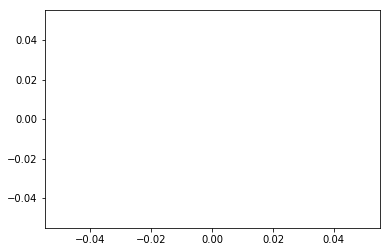

In [48]:
#Check the points on a plot if you want
plt.plot(pointlist[:,0],pointlist[:,1])

In [49]:
#Now run the coregistration
tic=time.time()
a=coregLoopHistory(pointlist,ts0=0,ts1=230,plateID=101)
toc=time.time()
print("Time taken:", toc-tic, " seconds")

('Time taken:', 89.39616084098816, ' seconds')


In [50]:
#And save out the dataset
andesPresent=numpy.array(a)
andeanOutSamp=open(r'Muller_Bertrand_coregistered_sampleMuller0.pkl','wb')
pickle.dump(andesPresent,andeanOutSamp)
andeanOutSamp.close()

In [51]:
#Now run the coregestration on the ore deposit data, to find the 
#Tectonmagmatic properties around the time a deposit was formed.

#Load in the data (in shapefile format)
#andeanPoints="CopperDeposits/XYBer14_t2_ANDES.shp"
#rint andeanPoints
#[recs,shapes,fields,Nshp]=readTopologyPlatepolygonFile(andeanPoints)

filename = '../data/EarthChemAU.txt'

# loadtxt() is a function that we can now use because we loaded the library called numpy
chemdata=numpy.loadtxt(filename, delimiter=',')


In [55]:
#Wrangle the data into a format we can use
#sampleData=numpy.zeros((Nshp,4))
#print sampleData

#for i in xrange(Nshp):
    #sampleData[i,2]=recs[i][6] #Ages
    #sampleData[i,3]=recs[i][7] #PlateIDs
    #sampleData[i,0]=recs[i][3] #Longs
    #sampleData[i,1]=recs[i][4] #Lats

#defining longitudes for North America
where_longitude_above_min = chemdata[:,1]>-140
audata=chemdata[where_longitude_above_min]

where_longitude_below_max = audata[:,1]<-50
audata2=audata[where_longitude_below_max]

#Defining latitudes for north america
audata3=audata2[audata2[:,0]<55]
audata4=audata3[audata3[:,0]>15]

#audata4 is the final data with clean data set for NA


#assigning the latitude, longitude, age and abundance according to their columns
latlon=audata4[:,0:2]
lat = audata4[:,0]
lon = audata4[:,1]

lonlat = latlon.copy()
lonlat[:, 0] = lonlat[:, 1]
lonlat[:, 1] = lat
age=audata4[:,2]



plateIDs = numpy.full(len(age),101)

print plateIDs
print latlon
print lonlat



print("We have removed", chemdata.shape[0]-audata4.shape[0], "samples")
#to find out how many outliers (rows) have been removed

[101 101 101 ... 101 101 101]
[[  37.4    -108.08  ]
 [  37.4    -108.08  ]
 [  37.4    -108.08  ]
 ...
 [  33.7753  -82.5639]
 [  33.7753  -82.5639]
 [  33.7753  -82.5639]]
[[-108.08     37.4   ]
 [-108.08     37.4   ]
 [-108.08     37.4   ]
 ...
 [ -82.5639   33.7753]
 [ -82.5639   33.7753]
 [ -82.5639   33.7753]]
('We have removed', 3778, 'samples')


In [56]:
#Run the coregistration
tic=time.time()
b=coregLoop(lonlat,age,plateIDs)
toc=time.time()
print("Time taken:", toc-tic, " seconds")

('Deposit:', 0, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 61.0, 'PlateID:', 101)
(0, 61, 61.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 61.0, 'PlateID:', 101)
(0, 61, 61.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 61.0, 'PlateID:', 101)
(0, 61, 61.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 61.0, 'PlateID:', 101)
(0, 61, 61.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 61.0, 'PlateID:', 101)
(0, 61, 61.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 61.0, 'PlateID:', 101)
(0, 61, 61.0)
('Trying raster region: ', 200.0)
('trying index r

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 49, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 61.0, 'PlateID:', 101)
(0, 61, 61.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 50, 'of', 14885, 'Lat:', 47.164, 'Lon:', -121.744, 'Age:', 21.0, 'PlateID:', 101)
(0, 21, 21.0)
('Deposit:', 51, 'of', 14885, 'Lat:', 47.155, 'Lon:', -121.828, 'Age:', 25.0, 'PlateID:', 101)
(0, 25, 25.0)
('Deposit:', 52, 'of', 14885, 'Lat:', 47.155, 'Lon:', -121.825, 'Age:', 25.0, 'PlateID:', 101)
(0, 25, 25.0)
('Deposit:', 53, 'of', 14885, 'Lat:', 47.15600000000001, 'Lon:', -121.861, 'Age:', 21.0, 'PlateID:', 101)
(0, 21, 21.0)
('Deposit:', 54, 'of', 14885, 'Lat:', 39.71, 'Lon:', -113.58, 'Age:', 4.65, 'PlateID:', 101)
(-1, 4, 4.65)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 5, 4.65)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 55, 'of', 14885, 'Lat:', 39.71, 'Lon:', -113.58, 'Age:', 4

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 90, 'of', 14885, 'Lat:', 32.935, 'Lon:', -107.546, 'Age:', 74.4, 'PlateID:', 101)
(-1, 74, 74.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 75, 74.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 91, 'of', 14885, 'Lat:', 32.9803, 'Lon:', -107.523, 'Age:', 72.5, 'PlateID:', 101)
(-1, 72, 72.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 73, 72.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 92, 'of', 14885, 'Lat:', 32.9664, 'Lon:', -107.538, 'Age:', 72.5, 'PlateID:', 101)
(-1, 72, 72.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 73, 72.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 93, 'of', 14885, 'Lat:', 32.9933, 'Lon:', -107.531, 'Age:', 72.5, 'PlateID:', 101)
(-1, 72, 72.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 23, 22.32)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 123, 'of', 14885, 'Lat:', 37.1558, 'Lon:', -105.019, 'Age:', 22.32, 'PlateID:', 101)
(-1, 22, 22.32)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 23, 22.32)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 124, 'of', 14885, 'Lat:', 37.4722, 'Lon:', -105.03, 'Age:', 22.19, 'PlateID:', 101)
(-1, 22, 22.19)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 23, 22.19)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 125, 'of', 14885, 'Lat:', 37.0892, 'Lon:', -105.043, 'Age:', 21.92, 'PlateID:', 101)
(-1, 21, 21.92)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 22, 21.92)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 126, 'of', 14885, 'Lat:', 37.1239, 'Lon:', -105.033, 'Age:', 22.61, 'Plate

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 11, 10.74)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 155, 'of', 14885, 'Lat:', 37.0647, 'Lon:', -105.34, 'Age:', 11.98, 'PlateID:', 101)
(-1, 11, 11.98)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 12, 11.98)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 156, 'of', 14885, 'Lat:', 37.0714, 'Lon:', -105.348, 'Age:', 4.37, 'PlateID:', 101)
(-1, 4, 4.37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 5, 4.37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 157, 'of', 14885, 'Lat:', 37.3203, 'Lon:', -105.367, 'Age:', 4.55, 'PlateID:', 101)
(-1, 4, 4.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 5, 4.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 158, 'of', 14885, 'Lat:', 37.2111, 'Lon:', -105.428, 'Age:', 4.59, 'PlateID:', 101)


('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 476, 226.3, -1, 226, nan, 'inf', -18.336069994626047, 5.58321509092963)
(0, 227, 226.3)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 476, 226.3, 0, 227, nan, 'inf', -18.31450840718821, 5.485786927164656)
('Deposit:', 477, 'of', 14885, 'Lat:', 44.45, 'Lon:', -66.13, 'Age:', 226.3, 'PlateID:', 101)
(-1, 226, 226.3)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 477, 226.3, -1, 226, nan, 'inf', -18.336069994626047, 5.58321509092963)
(0, 227, 226.3)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 477, 226.3, 0, 227, nan, 'inf', -18.31450840718821, 5.485786927164656)
('Deposit:', 478, 'of', 14885, 'Lat:', 44.45, 'Lon:', -66.13, 'Age:', 226.3, 'PlateID:', 101)
(-1, 226, 226.3)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 478, 226.3, -1, 226, nan, 'inf', -18.336069994626047, 5.58321509092963

('trying index region', 20.0)
('Skipping:', 513, 173.55, -1, 173, 16.076105, 'inf', -22.164446960801328, 24.04498393824405)
(0, 174, 173.55)
('trying index region', 20.0)
('Skipping:', 513, 173.55, 0, 174, 15.029341, 'inf', -22.06893433972101, 23.906724220278093)
('Deposit:', 514, 'of', 14885, 'Lat:', 41.5333, 'Lon:', -72.8833, 'Age:', 173.55, 'PlateID:', 101)
(-1, 173, 173.55)
('trying index region', 20.0)
('Skipping:', 514, 173.55, -1, 173, 16.148022, 'inf', -22.131819554451642, 24.074082266743527)
(0, 174, 173.55)
('trying index region', 20.0)
('Skipping:', 514, 173.55, 0, 174, 15.023288, 'inf', -22.03635668897887, 23.935836335832775)
('Deposit:', 515, 'of', 14885, 'Lat:', 40.33, 'Lon:', -74.79, 'Age:', 173.55, 'PlateID:', 101)
(-1, 173, 173.55)
('trying index region', 20.0)
('Skipping:', 515, 173.55, -1, 173, 15.9321375, 'inf', -23.89040489307981, 23.112030415550894)
(0, 174, 173.55)
('trying index region', 20.0)
('Skipping:', 515, 173.55, 0, 174, 14.854572, 'inf', -23.792648876283

('trying index region', 20.0)
('Skipping:', 535, 173.55, 0, 174, 14.862835, 'inf', -23.612784509067307, 22.611834081588178)
('Deposit:', 536, 'of', 14885, 'Lat:', 40.0, 'Lon:', -74.5, 'Age:', 173.55, 'PlateID:', 101)
(-1, 173, 173.55)
('trying index region', 20.0)
('Skipping:', 536, 173.55, -1, 173, 15.875492, 'inf', -23.71050695666624, 22.75069573481086)
(0, 174, 173.55)
('trying index region', 20.0)
('Skipping:', 536, 173.55, 0, 174, 14.862835, 'inf', -23.612784509067307, 22.611834081588178)
('Deposit:', 537, 'of', 14885, 'Lat:', 40.0, 'Lon:', -74.5, 'Age:', 173.55, 'PlateID:', 101)
(-1, 173, 173.55)
('trying index region', 20.0)
('Skipping:', 537, 173.55, -1, 173, 15.875492, 'inf', -23.71050695666624, 22.75069573481086)
(0, 174, 173.55)
('trying index region', 20.0)
('Skipping:', 537, 173.55, 0, 174, 14.862835, 'inf', -23.612784509067307, 22.611834081588178)
('Deposit:', 538, 'of', 14885, 'Lat:', 40.0, 'Lon:', -74.5, 'Age:', 173.55, 'PlateID:', 101)
(-1, 173, 173.55)
('trying index 

('trying index region', 20.0)
('Skipping:', 579, 173.55, -1, 173, 19.128944, 'inf', -26.86976215062892, 21.729181489268548)
(0, 174, 173.55)
('trying index region', 20.0)
('Skipping:', 579, 173.55, 0, 174, 17.274342, 'inf', -26.768564467358633, 21.589404034311794)
('Deposit:', 580, 'of', 14885, 'Lat:', 38.5, 'Lon:', -78.0, 'Age:', 173.55, 'PlateID:', 101)
(-1, 173, 173.55)
('trying index region', 20.0)
('Skipping:', 580, 173.55, -1, 173, 19.128944, 'inf', -26.86976215062892, 21.729181489268548)
(0, 174, 173.55)
('trying index region', 20.0)
('Skipping:', 580, 173.55, 0, 174, 17.274342, 'inf', -26.768564467358633, 21.589404034311794)
('Deposit:', 581, 'of', 14885, 'Lat:', 38.5, 'Lon:', -78.0, 'Age:', 173.55, 'PlateID:', 101)
(-1, 173, 173.55)
('trying index region', 20.0)
('Skipping:', 581, 173.55, -1, 173, 19.128944, 'inf', -26.86976215062892, 21.729181489268548)
(0, 174, 173.55)
('trying index region', 20.0)
('Skipping:', 581, 173.55, 0, 174, 17.274342, 'inf', -26.768564467358633, 21.

('trying index region', 20.0)
('Skipping:', 601, 173.55, 0, 174, 17.274342, 'inf', -26.768564467358633, 21.589404034311794)
('Deposit:', 602, 'of', 14885, 'Lat:', 38.5, 'Lon:', -78.0, 'Age:', 173.55, 'PlateID:', 101)
(-1, 173, 173.55)
('trying index region', 20.0)
('Skipping:', 602, 173.55, -1, 173, 19.128944, 'inf', -26.86976215062892, 21.729181489268548)
(0, 174, 173.55)
('trying index region', 20.0)
('Skipping:', 602, 173.55, 0, 174, 17.274342, 'inf', -26.768564467358633, 21.589404034311794)
('Deposit:', 603, 'of', 14885, 'Lat:', 38.5, 'Lon:', -78.0, 'Age:', 173.55, 'PlateID:', 101)
(-1, 173, 173.55)
('trying index region', 20.0)
('Skipping:', 603, 173.55, -1, 173, 19.128944, 'inf', -26.86976215062892, 21.729181489268548)
(0, 174, 173.55)
('trying index region', 20.0)
('Skipping:', 603, 173.55, 0, 174, 17.274342, 'inf', -26.768564467358633, 21.589404034311794)
('Deposit:', 604, 'of', 14885, 'Lat:', 38.5, 'Lon:', -78.0, 'Age:', 173.55, 'PlateID:', 101)
(-1, 173, 173.55)
('trying inde

('trying index region', 20.0)
('Skipping:', 624, 173.55, -1, 173, 18.7769, 'inf', -28.09859423117408, 19.39690105040279)
(0, 174, 173.55)
('trying index region', 20.0)
('Skipping:', 624, 173.55, 0, 174, 17.08848, 'inf', -27.995752140622557, 19.256881938462946)
('Deposit:', 625, 'of', 14885, 'Lat:', 36.0, 'Lon:', -78.9, 'Age:', 173.55, 'PlateID:', 101)
(-1, 173, 173.55)
('trying index region', 20.0)
('Skipping:', 625, 173.55, -1, 173, 18.7769, 'inf', -28.09859423117408, 19.39690105040279)
(0, 174, 173.55)
('trying index region', 20.0)
('Skipping:', 625, 173.55, 0, 174, 17.08848, 'inf', -27.995752140622557, 19.256881938462946)
('Deposit:', 626, 'of', 14885, 'Lat:', 48.67, 'Lon:', -90.43, 'Age:', 3175.0, 'PlateID:', 101)
('Deposit:', 627, 'of', 14885, 'Lat:', 48.67, 'Lon:', -90.43, 'Age:', 3175.0, 'PlateID:', 101)
('Deposit:', 628, 'of', 14885, 'Lat:', 51.4, 'Lon:', -90.0, 'Age:', 3175.0, 'PlateID:', 101)
('Deposit:', 629, 'of', 14885, 'Lat:', 51.4, 'Lon:', -90.0, 'Age:', 3175.0, 'PlateID

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1167, 'of', 14885, 'Lat:', 43.9372, 'Lon:', -110.352, 'Age:', 59.9, 'PlateID:', 101)
(-1, 59, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 60, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1168, 'of', 14885, 'Lat:', 43.9386, 'Lon:', -110.353, 'Age:', 59.9, 'PlateID:', 101)
(-1, 59, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 60, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1169, 'of', 14885, 'Lat:', 44.0236, 'Lon:', -110.37, 'Age:', 59.9, 'PlateID:', 101)
(-1, 59, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 60, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1170, 'of', 14885, 'Lat:', 43.9283, 'Lon:', -110.296, 'Age:', 104.5, 'PlateID:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1199, 'of', 14885, 'Lat:', 44.0336, 'Lon:', -110.532, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1200, 'of', 14885, 'Lat:', 44.0414, 'Lon:', -110.538, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1201, 'of', 14885, 'Lat:', 43.945, 'Lon:', -110.414, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1202, 'of', 14885, 'Lat:', 43.9236, 'Lon:', -110.414, 'Age:', 10

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1232, 'of', 14885, 'Lat:', 43.9914, 'Lon:', -110.335, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1233, 'of', 14885, 'Lat:', 44.0294, 'Lon:', -110.317, 'Age:', 59.9, 'PlateID:', 101)
(-1, 59, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 60, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1234, 'of', 14885, 'Lat:', 44.0294, 'Lon:', -110.317, 'Age:', 59.9, 'PlateID:', 101)
(-1, 59, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 60, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1235, 'of', 14885, 'Lat:', 44.0294, 'Lon:', -110.317, 'Age:', 59.9, 'Plat

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1264, 'of', 14885, 'Lat:', 44.0586, 'Lon:', -110.372, 'Age:', 59.9, 'PlateID:', 101)
(-1, 59, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 60, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1265, 'of', 14885, 'Lat:', 35.7208, 'Lon:', -80.0436, 'Age:', 467.0, 'PlateID:', 101)
('Deposit:', 1266, 'of', 14885, 'Lat:', 47.4617, 'Lon:', -115.963, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 1267, 'of', 14885, 'Lat:', 47.4631, 'Lon:', -115.962, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 1268, 'of', 14885, 'Lat:', 47.4636, 'Lon:', -115.962, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 1269, 'of', 14885, 'Lat:', 47.4675, 'Lon:', -115.957, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 1270, 'of', 14885, 'Lat:', 47.4694, 'Lon:', -115.955, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 1271, 'of', 14885, 'Lat:', 47.47, 'Lon:', -115.954, 'Age:', 3150.0, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1520, 'of', 14885, 'Lat:', 47.5306, 'Lon:', -115.94, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 1521, 'of', 14885, 'Lat:', 47.5306, 'Lon:', -115.94, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 1522, 'of', 14885, 'Lat:', 47.5308, 'Lon:', -115.939, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 1523, 'of', 14885, 'Lat:', 47.5319, 'Lon:', -115.938, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 1524, 'of', 14885, 'Lat:', 47.5328, 'Lon:', -115.937, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 1525, 'of', 14885, 'Lat:', 47.5169, 'Lon:', -115.937, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 1526, 'of', 14885, 'Lat:', 47.5247, 'Lon:', -115.93, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1696, 'of', 14885, 'Lat:', 47.5347, 'Lon:', -115.88, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1697, 'of', 14885, 'Lat:', 47.5361, 'Lon:', -115.862, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 1698, 'of', 14885, 'Lat:', 47.5347, 'Lon:', -115.864, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1699, 'of', 14885, 'Lat:', 47.5336, 'Lon:', -115.866, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('tryin

('Deposit:', 2358, 'of', 14885, 'Lat:', 47.4997, 'Lon:', -116.158, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2359, 'of', 14885, 'Lat:', 47.5006, 'Lon:', -116.158, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2360, 'of', 14885, 'Lat:', 47.5019, 'Lon:', -116.159, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2361, 'of', 14885, 'Lat:', 47.5031, 'Lon:', -116.161, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2362, 'of', 14885, 'Lat:', 47.5375, 'Lon:', -115.85, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2363, 'of', 14885, 'Lat:', 47.5367, 'Lon:', -115.848, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2364, 'of', 14885, 'Lat:', 47.5356, 'Lon:', -115.848, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2365, 'of', 14885, 'Lat:', 47.5342, 'Lon:', -115.847, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2366, 'of', 14885, 'Lat:', 47.5356, 'Lon:', -115.847, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2367, 'of', 14885, 'Lat:', 47.5361, 'Lon:', -115.846, 'Age:', 3150.0, 'PlateID:', 101)
(

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2824, 'of', 14885, 'Lat:', 45.0836, 'Lon:', -109.956, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2825, 'of', 14885, 'Lat:', 45.0839, 'Lon:', -109.955, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2826, 'of', 14885, 'Lat:', 45.0819, 'Lon:', -109.957, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2827, 'of', 14885, 'Lat:', 45.0808, 'Lon:', -109.952, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2828, 'of', 14885, 'Lat:', 45.0817, 'Lon:', -109.953, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2829, 'of', 14885, 'Lat:', 45.0817, 'Lon:', -109.953, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2830, 'of', 14885, 'Lat:', 45.0786, 'Lon:', -109.955, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('D

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2872, 'of', 14885, 'Lat:', 45.0619, 'Lon:', -109.956, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2873, 'of', 14885, 'Lat:', 45.0619, 'Lon:', -109.956, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 2874, 'of', 14885, 'Lat:', 45.0619, 'Lon:', -109.956, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 2875, 'of', 14885, 'Lat:', 45.0967, 'Lon:', -109.991, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2876, 'of', 14885, 'Lat:', 45.0844, 'Lon:', -109.949, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2877, 'of', 14885, 'Lat:', 45.0517, 'Lon:', -109.991, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 2878, 'of', 1488

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2917, 'of', 14885, 'Lat:', 45.0581, 'Lon:', -109.949, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 2918, 'of', 14885, 'Lat:', 45.0747, 'Lon:', -109.949, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 2919, 'of', 14885, 'Lat:', 45.0133, 'Lon:', -109.925, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2920, 'of', 14885, 'Lat:', 45.0378, 'Lon:', -109.953, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2921, 'of', 14885, 'Lat:', 45.0953, 'Lon:', -109.908, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 2922, 'of', 14885, 'Lat:', 45.0558, 'Lon:', -109.946, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 60, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2968, 'of', 14885, 'Lat:', 43.9583, 'Lon:', -110.411, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2969, 'of', 14885, 'Lat:', 44.0133, 'Lon:', -110.446, 'Age:', 59.9, 'PlateID:', 101)
(-1, 59, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 60, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2970, 'of', 14885, 'Lat:', 43.9961, 'Lon:', -110.466, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2971, 'of', 14885, 'Lat:', 43.995, 'Lon:', -110.465, 'Age:', 104.5, 'P

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3000, 'of', 14885, 'Lat:', 43.8972, 'Lon:', -110.349, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 2, 1.3)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3001, 'of', 14885, 'Lat:', 43.9461, 'Lon:', -110.414, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3002, 'of', 14885, 'Lat:', 44.1361, 'Lon:', -110.378, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3003, 'of', 14885, 'Lat:', 44.0139, 'Lon:', -110.532, 'Age:', 104.5, 'Pla

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 1, 0.005)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3047, 'of', 14885, 'Lat:', 45.0619, 'Lon:', -109.942, 'Age:', 0.005, 'PlateID:', 101)
(-1, 0, 0.005)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 1, 0.005)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3048, 'of', 14885, 'Lat:', 45.0519, 'Lon:', -109.951, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 3049, 'of', 14885, 'Lat:', 45.0519, 'Lon:', -109.951, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 3050, 'of', 14885, 'Lat:', 45.0622, 'Lon:', -109.917, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 3051, 'of', 14885, 'Lat:', 45.065, 'Lon:', -109.92, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3052, 'of', 14885, 'Lat:', 45.08, 'Lon:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3371, 'of', 14885, 'Lat:', 47.5258, 'Lon:', -115.94, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3372, 'of', 14885, 'Lat:', 47.5256, 'Lon:', -115.939, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3373, 'of', 14885, 'Lat:', 47.525, 'Lon:', -115.937, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3374, 'of', 14885, 'Lat:', 47.5261, 'Lon:', -115.938, 'Age:', 315

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3885, 'of', 14885, 'Lat:', 47.5372, 'Lon:', -115.916, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3886, 'of', 14885, 'Lat:', 47.5422, 'Lon:', -115.918, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3887, 'of', 14885, 'Lat:', 47.5444, 'Lon:', -115.92, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 3888, 'of', 14885, 'Lat:', 47.5458, 'Lon:', -115.919, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 3889, 'of', 14885, 'Lat:', 47.5489, 'Lon:', -115.92, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 3890, 'of', 14885, 'Lat:'

(0, 34, 33.4)
('Deposit:', 4071, 'of', 14885, 'Lat:', 35.0, 'Lon:', -116.917, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 4072, 'of', 14885, 'Lat:', 35.0, 'Lon:', -116.917, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 4073, 'of', 14885, 'Lat:', 33.9333, 'Lon:', -114.083, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 4074, 'of', 14885, 'Lat:', 33.9333, 'Lon:', -114.083, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 4075, 'of', 14885, 'Lat:', 33.9333, 'Lon:', -114.083, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 4076, 'of', 14885, 'Lat:', 33.9333, 'Lon:', -114.083, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 4077, 'of', 14885, 'Lat:', 33.9333, 'Lon:', -114.083, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 4078, 'of', 14885, 'Lat:', 33.9333, 'Lon:', -114.083, 'Age:', 33.4, 'PlateID:', 101)
(-1, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4116, 'of', 14885, 'Lat:', 37.8528, 'Lon:', -107.823, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 4117, 'of', 14885, 'Lat:', 37.8497, 'Lon:', -107.817, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 4118, 'of', 14885, 'Lat:', 37.8481, 'Lon:', -107.817, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 4119, 'of', 14885, 'Lat:', 37.8425, 'Lon:', -107.836, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4120, 'of', 14885, 'Lat:', 31.8667, 'Lon:', -109.25, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 4121, 'of', 14885, 'Lat:', 31.8667, 'Lon:', -109.25, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 4122, 'of', 14885, 'Lat:', 31.85, 'Lon:', -109.217, 'Age:', 14.55, 'P

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4154, 'of', 14885, 'Lat:', 40.1278, 'Lon:', -105.4, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4155, 'of', 14885, 'Lat:', 40.1278, 'Lon:', -105.4, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4156, 'of', 14885, 'Lat:', 40.1278, 'Lon:', -105.4, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4157, 'of', 14885, 'Lat:', 40.1278, 'Lon:', -105.4, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0

('Deposit:', 4220, 'of', 14885, 'Lat:', 40.88, 'Lon:', -117.342, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 4221, 'of', 14885, 'Lat:', 40.8783, 'Lon:', -117.34, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 4222, 'of', 14885, 'Lat:', 40.8792, 'Lon:', -117.334, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 4223, 'of', 14885, 'Lat:', 40.8786, 'Lon:', -117.332, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 4224, 'of', 14885, 'Lat:', 40.8783, 'Lon:', -117.337, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 4225, 'of', 14885, 'Lat:', 40.8783, 'Lon:', -117.337, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 4226, 'of', 14885, 'Lat:', 40.8783, 'Lon:', -117.337, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 4227, 'of', 14885, 'Lat:', 40.8922, 'Lon:', -117.341, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 4228, 'of', 14885, 'Lat:', 40.8858, 'Lon:', -117.329, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 4229, 'of', 14885, 'Lat:', 40.8897, 'Lon:', -117.333, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4289, 'of', 14885, 'Lat:', 45.0653, 'Lon:', -109.943, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 4290, 'of', 14885, 'Lat:', 45.0653, 'Lon:', -109.943, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 4291, 'of', 14885, 'Lat:', 45.0667, 'Lon:', -109.942, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 4292, 'of', 14885, 'Lat:', 45.0667, 'Lon:', -109.942, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 4293, 'of', 14885, 'Lat:', 45.0694, 'Lon:', -109.936, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 4294, 'of', 14885, 'Lat:', 45.0181, 'Lon:', -109.929, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 4295, 'of', 14885, 'Lat:', 45.0181, 'Lon:', -109.929, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 4296, 'of', 14885, 'Lat:', 45.0208, 'Lon:', -109.921, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying ind

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4332, 'of', 14885, 'Lat:', 45.0444, 'Lon:', -109.953, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 4333, 'of', 14885, 'Lat:', 45.0444, 'Lon:', -109.954, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 4334, 'of', 14885, 'Lat:', 45.0417, 'Lon:', -109.939, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 4335, 'of', 14885, 'Lat:', 45.0444, 'Lon:', -109.942, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 4336, 'of', 14885, 'Lat:', 45.0444, 'Lon:', -109.942, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4337, 'of', 14885, 'Lat:', 45.0444, 'Lon:', -109.944, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4338, 'of', 14885

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4383, 'of', 14885, 'Lat:', 38.35, 'Lon:', -109.07, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4384, 'of', 14885, 'Lat:', 37.9033, 'Lon:', -110.42, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4385, 'of', 14885, 'Lat:', 38.35, 'Lon:', -109.07, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4386, 'of', 14885, 'Lat:', 38.01, 'Lon:', -109.42, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4387, 'of', 14885, 'Lat:', 38.01, 'Lon:', -109.42, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4388, 'of', 14885, 'Lat:', 38.6956, 'Lon:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4421, 'of', 14885, 'Lat:', 37.8053, 'Lon:', -107.818, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4422, 'of', 14885, 'Lat:', 37.8053, 'Lon:', -107.818, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4423, 'of', 14885, 'Lat:', 37.8053, 'Lon:', -107.818, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4424, 'of', 14885, 'Lat:', 37.8053, 'Lon:', -107.818, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying inde

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4454, 'of', 14885, 'Lat:', 37.8031, 'Lon:', -107.814, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4455, 'of', 14885, 'Lat:', 37.8031, 'Lon:', -107.814, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4456, 'of', 14885, 'Lat:', 37.8056, 'Lon:', -107.819, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4457, 'of', 14885, 'Lat:', 44.2103, 'Lon:', -114.874, 'Age:', 156.5, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4513, 'of', 14885, 'Lat:', 38.0492, 'Lon:', -107.14, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4514, 'of', 14885, 'Lat:', 38.0492, 'Lon:', -107.14, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4515, 'of', 14885, 'Lat:', 38.0583, 'Lon:', -107.667, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4516, 'of', 14885, 'Lat:', 38.0583, 'Lon:', -107.667, 'Age:', 33.4, 'PlateID:', 10

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4553, 'of', 14885, 'Lat:', 45.0722, 'Lon:', -109.947, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4554, 'of', 14885, 'Lat:', 45.0722, 'Lon:', -109.954, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4555, 'of', 14885, 'Lat:', 45.0722, 'Lon:', -109.954, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4556, 'of', 14885, 'Lat:', 45.0736, 'Lon:', -109.951, 'Age:', 33.4, 'PlateID:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4590, 'of', 14885, 'Lat:', 45.0833, 'Lon:', -109.939, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 4591, 'of', 14885, 'Lat:', 45.0833, 'Lon:', -109.939, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 4592, 'of', 14885, 'Lat:', 45.0694, 'Lon:', -109.951, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4593, 'of', 14885, 'Lat:', 45.0625, 'Lon:', -109.949, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4594, 'of', 14885, 'Lat:', 45.0611, 'Lon:', -109.946, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 4595, 'of', 14885, 'Lat:', 45.0597, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4903, 'of', 14885, 'Lat:', 44.875, 'Lon:', -110.5, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4904, 'of', 14885, 'Lat:', 44.875, 'Lon:', -110.5, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4905, 'of', 14885, 'Lat:', 43.8889, 'Lon:', -110.513, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4906, 'of', 14885, 'Lat:', 43.8889, 'Lon:', -110.513, 'Age:', 104.5, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 2, 1.8)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5039, 'of', 14885, 'Lat:', 44.7264, 'Lon:', -113.017, 'Age:', 1.8, 'PlateID:', 101)
(-1, 1, 1.8)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 2, 1.8)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5040, 'of', 14885, 'Lat:', 44.7811, 'Lon:', -112.95, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 5041, 'of', 14885, 'Lat:', 44.7842, 'Lon:', -112.952, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 5042, 'of', 14885, 'Lat:', 44.7039, 'Lon:', -113.031, 'Age:', 304.0, 'PlateID:', 101)
('Deposit:', 5043, 'of', 14885, 'Lat:', 45.2167, 'Lon:', -111.932, 'Age:', 304.0, 'PlateID:', 101)
('Deposit:', 5044, 'of', 14885, 'Lat:', 42.595, 'Lon:', -104.521, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 5045, 'of', 14885, 'Lat:', 42.595, 'Lon:', -104.521, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 50

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5119, 'of', 14885, 'Lat:', 45.8853, 'Lon:', -68.6572, 'Age:', 467.0, 'PlateID:', 101)
('Deposit:', 5120, 'of', 14885, 'Lat:', 45.9578, 'Lon:', -68.6817, 'Age:', 467.0, 'PlateID:', 101)
('Deposit:', 5121, 'of', 14885, 'Lat:', 46.6003, 'Lon:', -68.7003, 'Age:', 467.0, 'PlateID:', 101)
('Deposit:', 5122, 'of', 14885, 'Lat:', 46.7, 'Lon:', -68.7083, 'Age:', 467.0, 'PlateID:', 101)
('Deposit:', 5123, 'of', 14885, 'Lat:', 44.8856, 'Lon:', -113.17, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5124, 'of', 14885, 'Lat:', 44.8856, 'Lon:', -113.17, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster regio

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5490, 'of', 14885, 'Lat:', 38.7867, 'Lon:', -106.649, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5491, 'of', 14885, 'Lat:', 38.7794, 'Lon:', -106.445, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5492, 'of', 14885, 'Lat:', 38.688, 'Lon:', -106.049, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5493, 'of', 14885, 'Lat:', 38.3567, 'Lon:', -106.694, 'Age:', 1521.0, 'PlateID:',

(0, 34, 33.4)
('Deposit:', 5593, 'of', 14885, 'Lat:', 38.1992, 'Lon:', -116.138, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 5594, 'of', 14885, 'Lat:', 38.1992, 'Lon:', -116.138, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 5595, 'of', 14885, 'Lat:', 38.2289, 'Lon:', -116.838, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 5596, 'of', 14885, 'Lat:', 38.1992, 'Lon:', -116.141, 'Age:', 338.5, 'PlateID:', 101)
('Deposit:', 5597, 'of', 14885, 'Lat:', 38.185, 'Lon:', -116.038, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 5598, 'of', 14885, 'Lat:', 45.3361, 'Lon:', -70.2167, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 5599, 'of', 14885, 'Lat:', 4

('trying index region', 20.0)
('Deposit:', 5667, 'of', 14885, 'Lat:', 35.3497, 'Lon:', -116.897, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3)
('trying index region', 20.0)
(0, 2, 1.3)
('trying index region', 20.0)
('Deposit:', 5668, 'of', 14885, 'Lat:', 33.5394, 'Lon:', -115.488, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 5669, 'of', 14885, 'Lat:', 35.3058, 'Lon:', -116.926, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 5670, 'of', 14885, 'Lat:', 33.2689, 'Lon:', -87.2967, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 5671, 'of', 14885, 'Lat:', 33.2689, 'Lon:', -87.2967, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 5672, 'of', 14885, 'Lat:', 33.2689, 'Lon:', -87.2967, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 5673, 'of', 14885, 'Lat:', 33.2689, 'Lon:', -87.2967, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 5674, 'of', 14885, 'Lat:', 33.2689, 'Lon:', -87.2967, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 5675, 'of', 14885, 'Lat:', 33.2689, 'Lon:', -87.2967, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5713, 'of', 14885, 'Lat:', 44.1856, 'Lon:', -114.557, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5714, 'of', 14885, 'Lat:', 44.1856, 'Lon:', -114.557, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5715, 'of', 14885, 'Lat:', 39.6379, 'Lon:', -105.766, 'Age:', 298.9, 'PlateID:', 101)
('Deposit:', 5716, 'of', 14885, 'Lat:', 39.6379, 'Lon:', -105.766, 'Age:', 298.9, 'PlateID:', 101)
('Deposit:', 5717, 'of', 14885, 'Lat:', 39.6379, 'Lon:', -105.766, 'Age:', 298.9, 'PlateID:', 101)
('Deposit:', 5718, 'of', 14885, 'Lat:', 39.6379, 'L

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5764, 'of', 14885, 'Lat:', 44.4389, 'Lon:', -114.875, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5765, 'of', 14885, 'Lat:', 44.4389, 'Lon:', -114.746, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5766, 'of', 14885, 'Lat:', 44.4375, 'Lon:', -114.736, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5767, 'of', 14885, 'Lat:', 44.4375, 'Lon:', -114.736, 'Age:', 33.4, 'PlateID:', 

('Deposit:', 5815, 'of', 14885, 'Lat:', 38.3897, 'Lon:', -120.572, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 5816, 'of', 14885, 'Lat:', 38.3897, 'Lon:', -120.572, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 5817, 'of', 14885, 'Lat:', 38.4083, 'Lon:', -120.812, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 5818, 'of', 14885, 'Lat:', 38.8197, 'Lon:', -120.781, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 5819, 'of', 14885, 'Lat:', 31.5294, 'Lon:', -110.717, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 5820, 'of', 14885, 'Lat:', 31.5103, 'Lon:', -110.748, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 5821, 'of', 14885, 'Lat:', 31.5167, 'Lon:', -110.714, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 5822, 'of', 14885, 'Lat:', 31.5208, 'Lon:', -110.71, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5861, 'of', 14885, 'Lat:', 44.3817, 'Lon:', -114.686, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5862, 'of', 14885, 'Lat:', 44.3789, 'Lon:', -114.683, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5863, 'of', 14885, 'Lat:', 44.3736, 'Lon:', -114.677, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5864, 'of', 14885, 'Lat:', 44.3733, 'Lon:', -114.679, 'Age:', 33.4, 'PlateID:', 

('Deposit:', 5916, 'of', 14885, 'Lat:', 33.09, 'Lon:', -111.01, 'Age:', 65.0, 'PlateID:', 101)
(0, 65, 65.0)
('Deposit:', 5917, 'of', 14885, 'Lat:', 33.0, 'Lon:', -110.97, 'Age:', 2171.5, 'PlateID:', 101)
('Deposit:', 5918, 'of', 14885, 'Lat:', 33.1, 'Lon:', -111.03, 'Age:', 2171.5, 'PlateID:', 101)
('Deposit:', 5919, 'of', 14885, 'Lat:', 33.1, 'Lon:', -111.03, 'Age:', 2171.5, 'PlateID:', 101)
('Deposit:', 5920, 'of', 14885, 'Lat:', 33.1, 'Lon:', -111.03, 'Age:', 65.0, 'PlateID:', 101)
(0, 65, 65.0)
('Deposit:', 5921, 'of', 14885, 'Lat:', 33.1, 'Lon:', -111.03, 'Age:', 65.0, 'PlateID:', 101)
(0, 65, 65.0)
('Deposit:', 5922, 'of', 14885, 'Lat:', 33.1, 'Lon:', -111.03, 'Age:', 65.0, 'PlateID:', 101)
(0, 65, 65.0)
('Deposit:', 5923, 'of', 14885, 'Lat:', 33.15, 'Lon:', -111.05, 'Age:', 65.0, 'PlateID:', 101)
(0, 65, 65.0)
('Deposit:', 5924, 'of', 14885, 'Lat:', 32.63, 'Lon:', -111.41, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 5925, 'of', 14885, 'Lat:', 33.1, 

('trying index region', 20.0)
('Deposit:', 5967, 'of', 14885, 'Lat:', 33.0939, 'Lon:', -110.975, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3)
('trying index region', 20.0)
(0, 2, 1.3)
('trying index region', 20.0)
('Deposit:', 5968, 'of', 14885, 'Lat:', 33.0939, 'Lon:', -110.975, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3)
('trying index region', 20.0)
(0, 2, 1.3)
('trying index region', 20.0)
('Deposit:', 5969, 'of', 14885, 'Lat:', 44.44, 'Lon:', -114.74, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5970, 'of', 14885, 'Lat:', 44.4419, 'Lon:', -114.739, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5971, 'of', 14885, 'Lat:', 44.4376, 'Lon:', -114.736, 'Age:', 44.25, 'PlateID:',

('Deposit:', 6017, 'of', 14885, 'Lat:', 42.2222, 'Lon:', -122.9, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 6018, 'of', 14885, 'Lat:', 43.125, 'Lon:', -120.0, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 6019, 'of', 14885, 'Lat:', 42.375, 'Lon:', -119.25, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6020, 'of', 14885, 'Lat:', 48.7667, 'Lon:', -120.667, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('trying index region', 20.0)
(0, 105, 104.5)
('trying index region', 20.0)
('Deposit:', 6021, 'of', 14885, 'Lat:', 48.7667, 'Lon:', -120.667, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('trying index region', 20.0)
(0, 105, 104.5)
('trying index region', 20.0)
('Deposit:', 6022, 'of', 14885, 'Lat:', 48.7667, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6056, 'of', 14885, 'Lat:', 43.75, 'Lon:', -110.5, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6057, 'of', 14885, 'Lat:', 43.75, 'Lon:', -110.5, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6058, 'of', 14885, 'Lat:', 43.75, 'Lon:', -110.5, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6059, 'of', 14885, 'Lat:', 43.75, 'Lon:', -110.5, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6093, 'of', 14885, 'Lat:', 37.3667, 'Lon:', -106.5, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6094, 'of', 14885, 'Lat:', 37.3667, 'Lon:', -106.5, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6095, 'of', 14885, 'Lat:', 37.3667, 'Lon:', -106.5, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6096, 'of', 14885, 'Lat:', 37.3667, 'Lon:', -106.5, 'Age:', 33.4, 'PlateID:', 101)
(-1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6135, 'of', 14885, 'Lat:', 40.6167, 'Lon:', -117.867, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6136, 'of', 14885, 'Lat:', 40.6167, 'Lon:', -117.75, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6137, 'of', 14885, 'Lat:', 40.6167, 'Lon:', -117.867, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6138, 'of', 14885, 'Lat:', 40.6167, 'Lon:', -117.867, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6139, 'of', 14885, 'Lat:', 40.6167, 'Lon:', -117.867, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6140, 'of', 14885, 'Lat:', 40

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6184, 'of', 14885, 'Lat:', 44.2192, 'Lon:', -103.692, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 6185, 'of', 14885, 'Lat:', 44.2192, 'Lon:', -103.692, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 6186, 'of', 14885, 'Lat:', 44.2192, 'Lon:', -103.692, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 6187, 'of', 14885, 'Lat:', 44.1256, 'Lon:', -103.459, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 6188, 'of', 14885, 'Lat:', 44.1747, 'Lon:', -103.581, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 6189, 'of', 14885, 'Lat:', 37.9881, 'Lon:', -107.294, 'Age:', 19.5, 'PlateID:', 101)
(-1, 19, 19.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 20, 19.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6190, 'of', 14885, 'Lat:', 37.9881, 'Lon:', -107.294, 'Age:', 19.5, 'PlateID:', 101)
(-1, 19, 19.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6230, 'of', 14885, 'Lat:', 40.5, 'Lon:', -111.375, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6231, 'of', 14885, 'Lat:', 40.5, 'Lon:', -111.375, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6232, 'of', 14885, 'Lat:', 34.3961, 'Lon:', -113.369, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 6233, 'of', 14885, 'Lat:', 39.3517, 'Lon:', -106.427, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 6234, 'of', 14885, 'Lat:', 39.4325, 'Lon:', -106.488, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 6235, 'of', 14885, 'Lat:', 39.4314, 'Lon:', -106.482, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 6236, 'of', 1

('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6291, 'of', 14885, 'Lat:', 36.125, 'Lon:', -114.875, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6292, 'of', 14885, 'Lat:', 34.6861, 'Lon:', -116.827, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 6293, 'of', 14885, 'Lat:', 34.6861, 'Lon:', -116.827, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 6294, 'of', 14885, 'Lat:', 34.6861, 'Lon:', -116.827, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 6295, 'of', 14885, 'Lat:', 33.25, 'Lon:', -110.25, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('Deposit:', 6296, 'of', 14885, 'Lat:', 33.25, 'Lon:', -110.5, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 6297, 'of', 14885, 'Lat:', 33.25, 'Lon:', -1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6382, 'of', 14885, 'Lat:', 37.9542, 'Lon:', -107.519, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6383, 'of', 14885, 'Lat:', 37.9542, 'Lon:', -107.519, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6384, 'of', 14885, 'Lat:', 37.9542, 'Lon:', -107.519, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6385, 'of', 14885, 'Lat:', 37.9542, 'Lon:', -107.519, 'Age:', 33.4, 'PlateID:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 1, 0.005)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6564, 'of', 14885, 'Lat:', 43.375, 'Lon:', -113.25, 'Age:', 0.005, 'PlateID:', 101)
(-1, 0, 0.005)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 1, 0.005)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6565, 'of', 14885, 'Lat:', 43.375, 'Lon:', -113.5, 'Age:', 0.005, 'PlateID:', 101)
(-1, 0, 0.005)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 1, 0.005)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6566, 'of', 14885, 'Lat:', 42.375, 'Lon:', -105.25, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 6567, 'of', 14885, 'Lat:', 42.1457, 'Lon:', -105.369, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 6568, 'of', 14885, 'Lat:', 42.1541, 'Lon:', -105.358, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 6569, 'of', 14885, 'Lat:', 42.1999, 'Lon

('Deposit:', 6626, 'of', 14885, 'Lat:', 34.295, 'Lon:', -114.062, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 6627, 'of', 14885, 'Lat:', 38.45, 'Lon:', -118.35, 'Age:', 19.5, 'PlateID:', 101)
(-1, 19, 19.5)
(0, 20, 19.5)
('Deposit:', 6628, 'of', 14885, 'Lat:', 39.45, 'Lon:', -118.35, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 6629, 'of', 14885, 'Lat:', 39.6667, 'Lon:', -118.183, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Deposit:', 6630, 'of', 14885, 'Lat:', 40.0, 'Lon:', -118.867, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 6631, 'of', 14885, 'Lat:', 39.9333, 'Lon:', -118.867, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 6632, 'of', 14885, 'Lat:', 39.9333, 'Lon:', -118.867, 'Age:', 33.4, 'PlateID:', 101)
(-1, 3

('Deposit:', 6714, 'of', 14885, 'Lat:', 39.4167, 'Lon:', -119.05, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 6715, 'of', 14885, 'Lat:', 39.6483, 'Lon:', -118.26, 'Age:', 19.5, 'PlateID:', 101)
(-1, 19, 19.5)
('trying index region', 20.0)
(0, 20, 19.5)
('trying index region', 20.0)
('Deposit:', 6716, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.917, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6717, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.917, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6718, 'of', 14885, 'Lat:', 41.0, 'Lon:', -116.0, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 6719, 'of', 14885, 'Lat:', 41.0, 'Lon:', -116.0, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 6720, 'of', 14885, 'Lat:', 41.0, 'Lon:', -116.0, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 6721, 'of', 14

('trying index region', 20.0)
('Deposit:', 6773, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6774, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6775, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6776, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6777, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6778, 'of', 14885

('trying index region', 20.0)
('Deposit:', 6817, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6818, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6819, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6820, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6821, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6822, 'of', 14885

('trying index region', 20.0)
('Deposit:', 6861, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6862, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6863, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6864, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6865, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6866, 'of', 14885

('trying index region', 20.0)
('Deposit:', 6905, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6906, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6907, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6908, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6909, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6910, 'of', 14885

('trying index region', 20.0)
('Deposit:', 6986, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6987, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6988, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6989, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6990, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 6991, 'of', 14885

(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 7039, 'of', 14885, 'Lat:', 30.6667, 'Lon:', -110.5, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 7040, 'of', 14885, 'Lat:', 30.6667, 'Lon:', -110.5, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 7041, 'of', 14885, 'Lat:', 30.6667, 'Lon:', -110.5, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 7042, 'of', 14885, 'Lat:', 30.6667, 'Lon:', -110.5, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 7043, 'of', 14885, 'Lat:', 30.6667, 'Lon:', -110.5, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 7044, 'of', 14885, 'Lat:', 30.6667, 'Lon:', -110.5, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 7045, 'of', 14885, 'Lat:', 30.6667, 'Lon:', -110.5, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 7046, 'of', 14885, 'Lat:', 40.955

('trying index region', 20.0)
('Deposit:', 7095, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7096, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7097, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7098, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raste

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7128, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7129, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7130, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7131, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 33.4, 'PlateID:', 

('Deposit:', 7175, 'of', 14885, 'Lat:', 33.0267, 'Lon:', -114.813, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7176, 'of', 14885, 'Lat:', 33.0272, 'Lon:', -114.81, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7177, 'of', 14885, 'Lat:', 33.0272, 'Lon:', -114.811, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7178, 'of', 14885, 'Lat:', 33.0272, 'Lon:', -114.811, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7179, 'of', 14885, 'Lat:', 33.0272, 'Lon:', -114.811, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7180, 'of', 14885, 'Lat:', 33.0272, 'Lon:', -114.812, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7181, 'of', 14885, 'Lat:', 33.0272, 'Lon:', -114.813, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7182, 'of', 14885, 'Lat:', 33.0278, 'Lon:', -114.81, 'Age:', 156

('trying index region', 20.0)
('Deposit:', 7232, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 7233, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 7234, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 7235, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 7236, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 7237, 'of', 14885

('trying index region', 20.0)
(0, 125, 124.9)
('trying index region', 20.0)
('Deposit:', 7275, 'of', 14885, 'Lat:', 38.1667, 'Lon:', -118.1, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
('trying index region', 20.0)
(0, 125, 124.9)
('trying index region', 20.0)
('Deposit:', 7276, 'of', 14885, 'Lat:', 38.1667, 'Lon:', -118.1, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
('trying index region', 20.0)
(0, 125, 124.9)
('trying index region', 20.0)
('Deposit:', 7277, 'of', 14885, 'Lat:', 38.1667, 'Lon:', -118.1, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
('trying index region', 20.0)
(0, 125, 124.9)
('trying index region', 20.0)
('Deposit:', 7278, 'of', 14885, 'Lat:', 38.1667, 'Lon:', -118.1, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
('trying index region', 20.0)
(0, 125, 124.9)
('trying index region', 20.0)
('Deposit:', 7279, 'of', 14885, 'Lat:', 38.1667, 'Lon:', -118.1, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
('trying index region', 20.0)
(0, 125, 124.9)
('tr

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 15, 14.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7356, 'of', 14885, 'Lat:', 45.0167, 'Lon:', -113.821, 'Age:', 1250.9, 'PlateID:', 101)
('Deposit:', 7357, 'of', 14885, 'Lat:', 44.9892, 'Lon:', -113.872, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 7358, 'of', 14885, 'Lat:', 44.9881, 'Lon:', -113.872, 'Age:', 1250.9, 'PlateID:', 101)
('Deposit:', 7359, 'of', 14885, 'Lat:', 44.9533, 'Lon:', -114.003, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 7360, 'of', 14885, 'Lat:', 44.9533, 'Lon:', -114.003, 'Age:', 1250.9, 'PlateID:', 101)
('Deposit:', 7361, 'of', 14885, 'Lat:', 45.2256, 'Lon:', -114.111, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 7362, 'of', 14885, 'Lat:', 45.2272, 'Lon:', -114.111, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 7363, 'of', 14885, 'Lat:', 45.2297, 'Lon:', -114.111, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 7364, 'of', 14885, 'Lat:', 45.2342, 'Lon:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7408, 'of', 14885, 'Lat:', 41.745, 'Lon:', -118.668, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7409, 'of', 14885, 'Lat:', 41.8056, 'Lon:', -118.669, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 125, 124.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7410, 'of', 14885, 'Lat:', 41.8056, 'Lon:', -118.669, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7411, 'of', 14885, 'Lat:', 41.8056, 'Lon:', -118.669, 'Age:', 15

('trying index region', 20.0)
('Deposit:', 7444, 'of', 14885, 'Lat:', 44.5194, 'Lon:', -118.088, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('trying index region', 20.0)
('Deposit:', 7445, 'of', 14885, 'Lat:', 44.5192, 'Lon:', -118.088, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7446, 'of', 14885, 'Lat:', 44.5197, 'Lon:', -118.088, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('trying index region', 20.0)
('Deposit:', 7447, 'of', 14885, 'Lat:', 44.5169, 'Lon:', -118.07, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7448, 'of', 14885, 'Lat:', 44.5119, 'Lon:', -118.051, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7489, 'of', 14885, 'Lat:', 43.9394, 'Lon:', -115.024, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7490, 'of', 14885, 'Lat:', 43.5089, 'Lon:', -115.922, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7491, 'of', 14885, 'Lat:', 43.7822, 'Lon:', -115.116, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7492, 'of', 14885, 'Lat:', 43.5061, 'Lon:', -115.906, 'Age:', 33.4, 'PlateID:', 

('Deposit:', 7547, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7548, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7549, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7550, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7551, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7552, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7553, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7554, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 1

(0, 157, 156.5)
('Deposit:', 7610, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7611, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7612, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7613, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7614, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7615, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7616, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7617, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -12

(0, 157, 156.5)
('Deposit:', 7673, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7674, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7675, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7676, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7677, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7678, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7679, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7680, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -12

('Deposit:', 7735, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7736, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7737, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7738, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7739, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7740, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7741, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7742, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 1

(0, 157, 156.5)
('Deposit:', 7798, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7799, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 7800, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7801, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7802, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying r

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7831, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7832, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7833, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7834, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7863, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7864, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7865, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7866, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index

('trying index region', 20.0)
('Deposit:', 7899, 'of', 14885, 'Lat:', 45.3819, 'Lon:', -111.576, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 7900, 'of', 14885, 'Lat:', 45.3625, 'Lon:', -111.585, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 7901, 'of', 14885, 'Lat:', 45.4722, 'Lon:', -111.647, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 7902, 'of', 14885, 'Lat:', 45.4944, 'Lon:', -111.65, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 7903, 'of', 14885, 'Lat:', 39.2583, 'Lon:', -115.0, 'Age:', 59.9, 'PlateID:', 101)
(-1, 59, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 60, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7904, 'of', 14885, 'Lat:', 39.2583, 'Lon:', -115.0, 'Age:', 59.9, 'PlateID:', 101)
(-1, 59, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 60, 59.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7905, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -116.0, '

('Deposit:', 7960, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 7961, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 7962, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 7963, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 7964, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 7965, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 7966, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3)
('trying index region', 20.0)
(0, 2, 1.3)
('trying index region', 20.0)
('Deposit:', 7967, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 14.55, 'PlateID:', 101)

('Deposit:', 8014, 'of', 14885, 'Lat:', 38.7875, 'Lon:', -118.406, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
(0, 29, 28.75)
('Deposit:', 8015, 'of', 14885, 'Lat:', 38.7875, 'Lon:', -118.406, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
(0, 29, 28.75)
('Deposit:', 8016, 'of', 14885, 'Lat:', 38.7869, 'Lon:', -118.404, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
(0, 29, 28.75)
('Deposit:', 8017, 'of', 14885, 'Lat:', 38.5833, 'Lon:', -118.125, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Deposit:', 8018, 'of', 14885, 'Lat:', 38.5833, 'Lon:', -118.125, 'Age:', 105.65, 'PlateID:', 101)
(-1, 105, 105.65)
('trying index region', 20.0)
(0, 106, 105.65)
('trying index region', 20.0)
('Deposit:', 8019, 'of', 14885, 'Lat:', 37.8617, 'Lon:', -106.94, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 8020, 'of', 14885, 'Lat:', 45.2064, 'Lon:', -115.656, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Try

('Deposit:', 8067, 'of', 14885, 'Lat:', 31.5047, 'Lon:', -110.723, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 8068, 'of', 14885, 'Lat:', 31.51, 'Lon:', -110.742, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 8069, 'of', 14885, 'Lat:', 31.5103, 'Lon:', -110.749, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 8070, 'of', 14885, 'Lat:', 31.5083, 'Lon:', -110.73, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 8071, 'of', 14885, 'Lat:', 31.5092, 'Lon:', -110.741, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 8072, 'of', 14885, 'Lat:', 31.5089, 'Lon:', -110.736, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 8073, 'of', 14885, 'Lat:', 31.5047, 'Lon:', -110.719, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 8074, 'of', 14885, 'Lat:', 31.5111, 'Lon:', -110.745, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33

('trying index region', 20.0)
('Deposit:', 8127, 'of', 14885, 'Lat:', 37.5008, 'Lon:', -114.759, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8128, 'of', 14885, 'Lat:', 37.4933, 'Lon:', -114.783, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8129, 'of', 14885, 'Lat:', 37.4978, 'Lon:', -114.798, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8130, 'of', 14885, 'Lat:', 37.5092, 'Lon:', -114.787, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8131, 'of', 14885, 'Lat:', 46.6475, 'Lon:', -114.843, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 8132, 'of', 14885, 'Lat:', 47.0644, 'Lon:', -115.185, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 15, 14.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8192, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 8193, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 8194, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 8195, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 8196, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 8197, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 8198, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 8199, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 8200, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639

('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8316, 'of', 14885, 'Lat:', 37.6361, 'Lon:', -114.316, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8317, 'of', 14885, 'Lat:', 37.6364, 'Lon:', -114.317, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8318, 'of', 14885, 'Lat:', 37.4633, 'Lon:', -114.767, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8319, 'of', 14885, 'Lat:', 37.4633, 'Lon:', -114.768, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8320, 'of', 14885, 'Lat:', 37.46, 'Lon:', -114.768, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('tryin

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 31, 30.05)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8362, 'of', 14885, 'Lat:', 37.3686, 'Lon:', -105.079, 'Age:', 30.05, 'PlateID:', 101)
(-1, 30, 30.05)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 31, 30.05)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8363, 'of', 14885, 'Lat:', 37.4697, 'Lon:', -105.043, 'Age:', 30.05, 'PlateID:', 101)
(-1, 30, 30.05)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 31, 30.05)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8364, 'of', 14885, 'Lat:', 37.6092, 'Lon:', -105.158, 'Age:', 30.05, 'PlateID:', 101)
(-1, 30, 30.05)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 31, 30.05)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8365, 'of', 14885, 'Lat:', 37.6908, 'Lon:', -105.196, 'Age:', 30.05, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8416, 'of', 14885, 'Lat:', 46.5, 'Lon:', -115.75, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8417, 'of', 14885, 'Lat:', 48.1661, 'Lon:', -109.72, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8418, 'of', 14885, 'Lat:', 48.1694, 'Lon:', -109.705, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8419, 'of', 14885, 'Lat:', 48.1661, 'Lon:', -109.696, 'Age:', 44.25, 'Pl

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8469, 'of', 14885, 'Lat:', 48.2031, 'Lon:', -109.651, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8470, 'of', 14885, 'Lat:', 48.2031, 'Lon:', -109.651, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8471, 'of', 14885, 'Lat:', 48.1661, 'Lon:', -109.696, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8472, 'of', 14885, 'Lat:', 48.1661, 'Lon:', -109.696, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying inde

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8513, 'of', 14885, 'Lat:', 48.2025, 'Lon:', -109.654, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8514, 'of', 14885, 'Lat:', 48.2044, 'Lon:', -109.658, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8515, 'of', 14885, 'Lat:', 48.2044, 'Lon:', -109.658, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8516, 'of', 14885, 'Lat:', 48.2036, 'Lon:', -109.661, 'Age:', 44.25, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8545, 'of', 14885, 'Lat:', 48.1717, 'Lon:', -109.691, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8546, 'of', 14885, 'Lat:', 48.1767, 'Lon:', -109.691, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8547, 'of', 14885, 'Lat:', 48.1767, 'Lon:', -109.691, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8548, 'of', 14885, 'Lat:', 48.1864, 'Lon:', -109.682, 'Age:', 44.25, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8583, 'of', 14885, 'Lat:', 45.0, 'Lon:', -116.0, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8584, 'of', 14885, 'Lat:', 45.0, 'Lon:', -116.0, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8585, 'of', 14885, 'Lat:', 45.0, 'Lon:', -116.0, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8586, 'of', 14885, 'Lat:', 45.0, 'Lon:', -116.0, 'Age:', 104.5, 'PlateID:', 10

('trying index region', 20.0)
('Deposit:', 8635, 'of', 14885, 'Lat:', 37.6372, 'Lon:', -114.919, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 8636, 'of', 14885, 'Lat:', 37.6517, 'Lon:', -114.914, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 8637, 'of', 14885, 'Lat:', 48.7069, 'Lon:', -118.553, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 8638, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 8639, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 8640, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 288.0, 'PlateID:', 101)
('Deposit:', 8641, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 8642, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 275.0, 'PlateID:', 

('Deposit:', 8711, 'of', 14885, 'Lat:', 39.0917, 'Lon:', -118.716, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 8712, 'of', 14885, 'Lat:', 39.075, 'Lon:', -118.708, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 8713, 'of', 14885, 'Lat:', 39.075, 'Lon:', -118.708, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 8714, 'of', 14885, 'Lat:', 39.075, 'Lon:', -118.708, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 8715, 'of', 14885, 'Lat:', 39.0833, 'Lon:', -118.717, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 8716, 'of', 14885, 'Lat:', 39.0667, 'Lon:', -118.683, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 8717, 'of', 14885, 'Lat:', 39.1, 'Lon:', -118.701, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 8718, 'of', 14885, 'Lat:', 48.1625, 'Lon:', -109.624, 'Age:', 33.4, 'PlateID:', 101

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8755, 'of', 14885, 'Lat:', 48.1644, 'Lon:', -109.711, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8756, 'of', 14885, 'Lat:', 48.1631, 'Lon:', -109.712, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8757, 'of', 14885, 'Lat:', 48.1564, 'Lon:', -109.714, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8758, 'of', 14885, 'Lat:', 48.1578, 'Lon:', -109.717, 'Age:', 33.4, 'PlateID:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8787, 'of', 14885, 'Lat:', 48.1417, 'Lon:', -109.708, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8788, 'of', 14885, 'Lat:', 48.1417, 'Lon:', -109.717, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8789, 'of', 14885, 'Lat:', 48.1417, 'Lon:', -109.717, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8790, 'of', 14885, 'Lat:', 48.1833, 'Lon:', -109.692, 'Age:', 33.4, 'PlateID:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8823, 'of', 14885, 'Lat:', 48.1853, 'Lon:', -109.756, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8824, 'of', 14885, 'Lat:', 48.1886, 'Lon:', -109.764, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8825, 'of', 14885, 'Lat:', 48.1806, 'Lon:', -109.772, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8826, 'of', 14885, 'Lat:', 48.2075, 'Lon:', -109.647, 'Age:', 44.25, '

('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8867, 'of', 14885, 'Lat:', 37.4494, 'Lon:', -114.696, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8868, 'of', 14885, 'Lat:', 37.45, 'Lon:', -114.695, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8869, 'of', 14885, 'Lat:', 37.5119, 'Lon:', -114.644, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8870, 'of', 14885, 'Lat:', 37.5128, 'Lon:', -114.645, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 8871, 'of', 14885, 'Lat:', 37.5136, 'Lon:', -114.643, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('tryin

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8906, 'of', 14885, 'Lat:', 40.8, 'Lon:', -117.483, 'Age:', 44.4, 'PlateID:', 101)
(-1, 44, 44.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8907, 'of', 14885, 'Lat:', 37.2958, 'Lon:', -121.317, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 8908, 'of', 14885, 'Lat:', 37.2958, 'Lon:', -121.317, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 8909, 'of', 14885, 'Lat:', 43.5653, 'Lon:', -122.794, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 8910, 'of', 14885, 'Lat:', 43.5644, 'Lon:', -122.794, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 8911, 'of', 14885, 'Lat:', 43.5597, 'Lon:', -122.806, 'Age:', 33.4, 'PlateI

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8952, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -118.05, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8953, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -118.05, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8954, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -118.05, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8955, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -118.05, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9002, 'of', 14885, 'Lat:', 31.7597, 'Lon:', -108.266, 'Age:', 304.0, 'PlateID:', 101)
('Deposit:', 9003, 'of', 14885, 'Lat:', 31.8381, 'Lon:', -108.492, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9004, 'of', 14885, 'Lat:', 32.3667, 'Lon:', -107.674, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9005, 'of', 14885, 'Lat:', 32.1964, 'Lon:', -106.588, 'Age:', 429.5, 'PlateID:', 101)
('Deposit:', 9006, 'of', 14885, 'Lat:', 39.1847, 'Lon:', -77.7736, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9007, 'of', 14885, 'Lat:', 34.31

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 89, 88.85)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9076, 'of', 14885, 'Lat:', 48.5339, 'Lon:', -117.153, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9077, 'of', 14885, 'Lat:', 45.2219, 'Lon:', -113.725, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9078, 'of', 14885, 'Lat:', 45.2214, 'Lon:', -113.724, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9079, 'of', 14885, 'Lat:', 45.2214, 'Lon:', -113.722, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9080, 'of', 14885, 'Lat:', 45.2242, 'Lon:', -113.718, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9081, 'of', 14885, 'Lat:', 45.2267, 'Lon:', -113.716, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9082, 'of', 14885, 'Lat:', 45.2267, 'Lon:', -113.716, 'Age:', 1521.0, 'PlateID:', 10

(0, 1, 0.905)
('Deposit:', 9155, 'of', 14885, 'Lat:', 41.5703, 'Lon:', -121.501, 'Age:', 0.905, 'PlateID:', 101)
(-1, 0, 0.905)
(0, 1, 0.905)
('Deposit:', 9156, 'of', 14885, 'Lat:', 41.3786, 'Lon:', -121.511, 'Age:', 0.905, 'PlateID:', 101)
(-1, 0, 0.905)
(0, 1, 0.905)
('Deposit:', 9157, 'of', 14885, 'Lat:', 41.4628, 'Lon:', -121.471, 'Age:', 0.905, 'PlateID:', 101)
(-1, 0, 0.905)
(0, 1, 0.905)
('Deposit:', 9158, 'of', 14885, 'Lat:', 41.5106, 'Lon:', -121.301, 'Age:', 0.905, 'PlateID:', 101)
(-1, 0, 0.905)
(0, 1, 0.905)
('Deposit:', 9159, 'of', 14885, 'Lat:', 41.6356, 'Lon:', -121.206, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3)
(0, 2, 1.3)
('Deposit:', 9160, 'of', 14885, 'Lat:', 41.5694, 'Lon:', -121.174, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3)
(0, 2, 1.3)
('Deposit:', 9161, 'of', 14885, 'Lat:', 41.6958, 'Lon:', -121.185, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3)
(0, 2, 1.3)
('Deposit:', 9162, 'of', 14885, 'Lat:', 41.7311, 'Lon:', -121.113, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9194, 'of', 14885, 'Lat:', 40.9769, 'Lon:', -117.912, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9195, 'of', 14885, 'Lat:', 41.0683, 'Lon:', -118.019, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9196, 'of', 14885, 'Lat:', 40.7406, 'Lon:', -118.623, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9197, 'of', 14885, 'Lat:', 40.7411, 'Lon:', -118.623, 'Age:', 33.4, 'PlateID:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9229, 'of', 14885, 'Lat:', 44.4581, 'Lon:', -117.817, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9230, 'of', 14885, 'Lat:', 44.4514, 'Lon:', -117.786, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9231, 'of', 14885, 'Lat:', 44.48, 'Lon:', -117.789, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9232, 'of', 14885, 'Lat:', 44.4833, 'Lon:', -117.811, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9233, 'of', 14885, 'Lat:', 44.4219, 'Lon:', -117.761, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9266, 'of', 14885, 'Lat:', 44.3178, 'Lon:', -117.85, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9267, 'of', 14885, 'Lat:', 44.3192, 'Lon:', -117.779, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9268, 'of', 14885, 'Lat:', 44.3717, 'Lon:', -117.762, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9269, 'of', 14885, 'Lat:', 44.3711, 'Lon:', -117.805, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9270, 'of', 14885, 'Lat:', 44.3747, 'Lon:', -117.801, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0

('trying index region', 20.0)
(0, 45, 44.25)
('trying index region', 20.0)
('Deposit:', 9391, 'of', 14885, 'Lat:', 47.3333, 'Lon:', -120.625, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('trying index region', 20.0)
(0, 45, 44.25)
('trying index region', 20.0)
('Deposit:', 9392, 'of', 14885, 'Lat:', 47.3333, 'Lon:', -120.625, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('trying index region', 20.0)
(0, 45, 44.25)
('trying index region', 20.0)
('Deposit:', 9393, 'of', 14885, 'Lat:', 37.875, 'Lon:', -107.77, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9394, 'of', 14885, 'Lat:', 37.9717, 'Lon:', -107.729, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9395, 'of', 14885,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9452, 'of', 14885, 'Lat:', 35.2231, 'Lon:', -116.57, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Deposit:', 9453, 'of', 14885, 'Lat:', 38.6958, 'Lon:', -116.812, 'Age:', 19.5, 'PlateID:', 101)
(-1, 19, 19.5)
('trying index region', 20.0)
(0, 20, 19.5)
('trying index region', 20.0)
('Deposit:', 9454, 'of', 14885, 'Lat:', 38.6944, 'Lon:', -116.817, 'Age:', 19.5, 'PlateID:', 101)
(-1, 19, 19.5)
('trying index region', 20.0)
(0, 20, 19.5)
('trying index region', 20.0)
('Deposit:', 9455, 'of', 14885, 'Lat:', 38.6922, 'Lon:', -116.804, 'Age:', 19.5, 'PlateID:', 101)
(-1, 19, 19.5)
('trying index region', 20.0)
(0, 20, 19.5)
('trying index region', 20.0)
('Deposit:', 9456, 'of', 14885, 'Lat:', 38.6914, 'Lon:', -116.821, 'Age:', 19.5, 'PlateID:', 101)
(-1, 19, 19.5)
('trying index region', 20.0)
(0, 20, 19.5)
('trying index region', 

('trying index region', 20.0)
(0, 33, 32.5)
('trying index region', 20.0)
('Deposit:', 9527, 'of', 14885, 'Lat:', 34.7631, 'Lon:', -111.013, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 9528, 'of', 14885, 'Lat:', 35.5406, 'Lon:', -111.751, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('trying index region', 20.0)
('Deposit:', 9529, 'of', 14885, 'Lat:', 46.6781, 'Lon:', -111.513, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9530, 'of', 14885, 'Lat:', 46.6219, 'Lon:', -111.466, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9531, 'of', 14885, 'Lat:', 46.6219, 'Lon:', -111.466, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9532, 'of', 14885, 'Lat:', 46.6856, 'Lon:', -111.522, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9533, 'of', 14885, 'Lat:', 46.7564, 'Lon:', -111.744, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9534, 'of', 14885, 'Lat:', 46.7261, 'Lon:', -111.692, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9535, 'of', 14885, 'Lat:', 46.7581, 'Lon:', -111.746, 'Age:', 1521.0,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('trying index region', 20.0)
('Deposit:', 9601, 'of', 14885, 'Lat:', 41.5225, 'Lon:', -118.816, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('trying index region', 20.0)
('Deposit:', 9602, 'of', 14885, 'Lat:', 41.5497, 'Lon:', -118.562, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9603, 'of', 14885, 'Lat:', 35.7722, 'Lon:', -105.726, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9604, 'of', 14885, 'Lat:', 35.7717, 'Lon:', -105.716, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 9605, 'of', 14885, 'Lat:', 35.6833, 'Lon:', -105.758, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9606, 'of', 14885, 'Lat:', 35.7, 'Lon:', -105.775, 'Age:', 1521.0, 'PlateID:', 101)
('Deposi

('Deposit:', 9682, 'of', 14885, 'Lat:', 32.8147, 'Lon:', -116.524, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Deposit:', 9683, 'of', 14885, 'Lat:', 33.0986, 'Lon:', -116.594, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Deposit:', 9684, 'of', 14885, 'Lat:', 43.915, 'Lon:', -72.0669, 'Age:', 493.5, 'PlateID:', 101)
('Deposit:', 9685, 'of', 14885, 'Lat:', 34.9564, 'Lon:', -80.7153, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9686, 'of', 14885, 'Lat:', 34.5778, 'Lon:', -80.5431, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 9687, 'of', 14885, 'Lat:', 34.2808, 'Lon:', -80.8797, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 9688, 'of', 14885, 'Lat:', 34.2808, 'Lon:', -80.8797, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 9689, 'of', 14885, 'Lat:', 34.2808, 'Lon:', -80.8797, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 9690, 'of', 14885, 'Lat:', 34.9564, 'Lon:', -80.7153, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 9691, 'of', 14885, 'Lat:', 34.9564, 'Lon:', -80.7153, 'Age:', 1

('Deposit:', 9753, 'of', 14885, 'Lat:', 41.0672, 'Lon:', -120.827, 'Age:', 11.905, 'PlateID:', 101)
(-1, 11, 11.905)
(0, 12, 11.905)
('Deposit:', 9754, 'of', 14885, 'Lat:', 41.8394, 'Lon:', -121.292, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 9755, 'of', 14885, 'Lat:', 41.8208, 'Lon:', -121.891, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 9756, 'of', 14885, 'Lat:', 48.9128, 'Lon:', -117.804, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9757, 'of', 14885, 'Lat:', 33.9139, 'Lon:', -82.2708, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 9758, 'of', 14885, 'Lat:', 33.9139, 'Lon:', -82.2708, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 9759, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 9760, 'of', 14885, 'Lat:', 33.7753, 'Lo

('Deposit:', 9818, 'of', 14885, 'Lat:', 31.5953, 'Lon:', -111.348, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 9819, 'of', 14885, 'Lat:', 31.6072, 'Lon:', -111.36, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 9820, 'of', 14885, 'Lat:', 31.6053, 'Lon:', -111.358, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 9821, 'of', 14885, 'Lat:', 31.6158, 'Lon:', -111.359, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 9822, 'of', 14885, 'Lat:', 31.6233, 'Lon:', -111.371, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 9823, 'of', 14885, 'Lat:', 31.6181, 'Lon:', -111.371, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 9824, 'of', 14885, 'Lat:', 31.6158, 'Lon:', -111.344, 'Age:', 135.5, 'PlateID:', 101)
(-1, 135, 135.5)
(0, 136, 135.5)
('Deposit:', 9825, 'of', 14885, 'Lat:', 31.6147, 'Lon:', -111.341, 'Age:', 13

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 10142, 227.0, 0, 227, nan, 'inf', -25.471302816896845, 1.6631741432820695)
('Deposit:', 10143, 'of', 14885, 'Lat:', 41.75, 'Lon:', -73.25, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 10144, 'of', 14885, 'Lat:', 41.75, 'Lon:', -73.25, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 10145, 'of', 14885, 'Lat:', 41.75, 'Lon:', -73.25, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 10146, 'of', 14885, 'Lat:', 41.75, 'Lon:', -73.25, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 10147, 'of', 14885, 'Lat:', 42.75, 'Lon:', -71.1167, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 10148, 'of', 14885, 'Lat:', 42.75, 'Lon:', -71.1167, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 10149, 'of', 14885, 'Lat:', 42.75, 'Lon:', -71.1167, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 10150, 'of', 14885, 'Lat:', 45.0897, 'Lon:', -67.4833, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 10151, 'of', 14885, 'Lat:', 45.0897, 'Lon:', -67.4833, '

('trying index region', 20.0)
('Skipping:', 10205, 175.0, 0, 175, 15.823933, 'inf', -26.211890476947705, 21.898719092884832)
('Deposit:', 10206, 'of', 14885, 'Lat:', 39.0, 'Lon:', -77.5667, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Skipping:', 10206, 175.0, 0, 175, 15.823933, 'inf', -26.215040603622466, 21.882276888310713)
('Deposit:', 10207, 'of', 14885, 'Lat:', 39.0167, 'Lon:', -77.55, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Skipping:', 10207, 175.0, 0, 175, 15.823933, 'inf', -26.198122052763956, 21.89644850284014)
('Deposit:', 10208, 'of', 14885, 'Lat:', 39.0167, 'Lon:', -77.55, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Skipping:', 10208, 175.0, 0, 175, 15.823933, 'inf', -26.198122052763956, 21.89644850284014)
('Deposit:', 10209, 'of', 14885, 'Lat:', 39.0167, 'Lon:', -77.5667, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Skipping:', 1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10241, 'of', 14885, 'Lat:', 44.0728, 'Lon:', -117.458, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10242, 'of', 14885, 'Lat:', 44.0725, 'Lon:', -117.453, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10243, 'of', 14885, 'Lat:', 44.0769, 'Lon:', -117.452, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10244, 'of', 14885, 'Lat:', 44.0767, 'Lon:', -117.451, 'Age:', 33.4, 'PlateID

(0, 157, 156.5)
('Deposit:', 10294, 'of', 14885, 'Lat:', 42.9192, 'Lon:', -123.468, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10295, 'of', 14885, 'Lat:', 42.2972, 'Lon:', -123.756, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10296, 'of', 14885, 'Lat:', 42.5667, 'Lon:', -123.467, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10297, 'of', 14885, 'Lat:', 42.2989, 'Lon:', -123.593, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10298, 'of', 14885, 'Lat:', 42.2942, 'Lon:', -123.309, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10299, 'of', 14885, 'Lat:', 42.3528, 'Lon:', -123.566, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10300, 'of', 14885, 'Lat:', 42.3414, 'Lon:', -123.569, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10301, 'of', 14885, 'Lat:', 42.3322, 'Lo

(0, 157, 156.5)
('Deposit:', 10356, 'of', 14885, 'Lat:', 42.0789, 'Lon:', -123.215, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10357, 'of', 14885, 'Lat:', 42.2639, 'Lon:', -123.136, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10358, 'of', 14885, 'Lat:', 42.2439, 'Lon:', -123.197, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10359, 'of', 14885, 'Lat:', 42.2547, 'Lon:', -123.113, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10360, 'of', 14885, 'Lat:', 42.2642, 'Lon:', -123.133, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10361, 'of', 14885, 'Lat:', 42.1419, 'Lon:', -123.875, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10362, 'of', 14885, 'Lat:', 42.2669, 'Lon:', -123.144, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10363, 'of', 14885, 'Lat:', 42.2581, 'Lo

('Deposit:', 10409, 'of', 14885, 'Lat:', 38.7822, 'Lon:', -117.982, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10410, 'of', 14885, 'Lat:', 38.7822, 'Lon:', -117.982, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10411, 'of', 14885, 'Lat:', 38.775, 'Lon:', -117.974, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 10412, 'of', 14885, 'Lat:', 38.7678, 'Lon:', -117.973, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10413, 'of', 14885, 'Lat:', 38.7581, 'Lon:', -117.976, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10414, 'of', 14885, 'Lat:', 38.7581, 'Lon:', -117.976, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10415, 'of', 14885, 'Lat:

('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10457, 'of', 14885, 'Lat:', 41.1481, 'Lon:', -119.454, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10458, 'of', 14885, 'Lat:', 43.2081, 'Lon:', -117.527, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 15, 14.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10459, 'of', 14885, 'Lat:', 33.4583, 'Lon:', -108.781, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10460, 'of', 14885, 'Lat:', 33.3736, 'Lon:', -108.813, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('tryin

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10509, 'of', 14885, 'Lat:', 46.0375, 'Lon:', -113.772, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10510, 'of', 14885, 'Lat:', 46.4308, 'Lon:', -113.89, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10511, 'of', 14885, 'Lat:', 46.315, 'Lon:', -113.895, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10512, 'of', 14885, 'Lat:', 46.3667, 'Lon:', -112.14, 'Age:', 15

(0, 15, 14.55)
('Deposit:', 10560, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10561, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10562, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10563, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10564, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10565, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10566, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10567, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, '

('trying index region', 20.0)
('Deposit:', 10603, 'of', 14885, 'Lat:', 37.9931, 'Lon:', -117.266, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 10604, 'of', 14885, 'Lat:', 37.9914, 'Lon:', -117.265, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 10605, 'of', 14885, 'Lat:', 37.9936, 'Lon:', -117.266, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 10606, 'of', 14885, 'Lat:', 37.9917, 'Lon:', -117.264, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 10607, 'of', 14885, 'Lat:', 37.9911, 'Lon:', -117.263, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 10

('trying index region', 20.0)
('Deposit:', 10649, 'of', 14885, 'Lat:', 37.9978, 'Lon:', -117.243, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 10650, 'of', 14885, 'Lat:', 37.9978, 'Lon:', -117.243, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 10651, 'of', 14885, 'Lat:', 37.9986, 'Lon:', -117.242, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 10652, 'of', 14885, 'Lat:', 37.9986, 'Lon:', -117.242, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 10653, 'of', 14885, 'Lat:', 37.9986, 'Lon:', -117.242, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('trying index region', 20.0)
(0, 15, 14.55)
('trying index region', 20.0)
('Deposit:', 10

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10699, 'of', 14885, 'Lat:', 46.8383, 'Lon:', -112.648, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10700, 'of', 14885, 'Lat:', 46.1014, 'Lon:', -112.228, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10701, 'of', 14885, 'Lat:', 46.1014, 'Lon:', -112.228, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10702, 'of', 14885, 'Lat:', 46.0931, 'Lon:', -112.064, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index regio

('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10742, 'of', 14885, 'Lat:', 38.6667, 'Lon:', -116.253, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10743, 'of', 14885, 'Lat:', 38.6667, 'Lon:', -116.253, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10744, 'of', 14885, 'Lat:', 38.6658, 'Lon:', -116.253, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10745, 'of', 14885, 'Lat:', 38.6656, 'Lon:', -116.253, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10746, 'of', 14885, 'Lat:', 38.665, 'Lon:', -116.264, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index re

('trying index region', 20.0)
('Deposit:', 10795, 'of', 14885, 'Lat:', 38.6667, 'Lon:', -116.253, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10796, 'of', 14885, 'Lat:', 38.4956, 'Lon:', -116.404, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 10797, 'of', 14885, 'Lat:', 38.4922, 'Lon:', -116.408, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10798, 'of', 14885, 'Lat:', 38.3589, 'Lon:', -116.38, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10799, 'of', 14885, 'Lat:', 38.6667, 'Lon:', -116.253, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 10800, 'of', 14885, 'Lat:', 35.0833, 'Lon:', -115.15, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 10801, 'of', 14885, 'Lat:', 32.9119, 'Lon:', -113.826, 'Age:', 395.5, 'PlateID:', 101)
('Deposi

('trying index region', 20.0)
('Deposit:', 10856, 'of', 14885, 'Lat:', 38.8653, 'Lon:', -117.519, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10857, 'of', 14885, 'Lat:', 38.8653, 'Lon:', -117.519, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10858, 'of', 14885, 'Lat:', 38.8225, 'Lon:', -117.588, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Deposit:', 10859, 'of', 14885, 'Lat:', 38.8225, 'Lon:', -117.588, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Deposit:', 10860, 'of', 14885, 'Lat:', 38.8281, 'Lon:', -117.589, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Deposit:', 10861, 'of', 14885, 'Lat:', 38.8283, 'Lon:', -117.589, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Deposit:', 10862, 'of', 14885, 'Lat:', 38.8256, 'Lon:', -117.589, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Deposit:', 1

('trying index region', 20.0)
('Deposit:', 10915, 'of', 14885, 'Lat:', 38.0797, 'Lon:', -117.644, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10916, 'of', 14885, 'Lat:', 38.0794, 'Lon:', -117.644, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10917, 'of', 14885, 'Lat:', 38.0792, 'Lon:', -117.644, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10918, 'of', 14885, 'Lat:', 38.0794, 'Lon:', -117.645, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 10919, 'of', 14885, 'Lat:', 38.0753, 'Lon:', -117.633, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Deposit:', 10920, 'of', 14885, 'Lat:', 38.0753, 'Lon:', -117.633, 'Age:', 227.0, 'PlateID:', 101)
(0

('Deposit:', 10970, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10971, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10972, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10973, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10974, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10975, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10976, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 10977, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 

('Deposit:', 11033, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11034, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11035, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11036, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11037, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11038, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11039, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11040, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 

('Deposit:', 11096, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11097, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11098, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11099, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11100, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11101, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11102, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11103, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 14.55, 

('Deposit:', 11159, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11160, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11161, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11162, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11163, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11164, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11165, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11166, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)

(0, 15, 14.55)
('Deposit:', 11209, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11210, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11211, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11212, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11213, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11214, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11215, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11216, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, '

('Deposit:', 11273, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11274, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11275, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11276, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11277, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11278, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11279, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11280, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)

('Deposit:', 11333, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11334, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11335, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11336, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11337, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11338, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11339, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 11340, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 14.55, 'PlateID:', 101)

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 15, 14.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11398, 'of', 14885, 'Lat:', 37.9786, 'Lon:', -107.459, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 15, 14.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11399, 'of', 14885, 'Lat:', 37.9978, 'Lon:', -107.39, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 15, 14.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11400, 'of', 14885, 'Lat:', 37.9817, 'Lon:', -107.432, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 15, 14.55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11401, 'of', 14885, 'Lat:', 37.9856, 'Lon:', -107.432, 'Age:', 14.55

('trying index region', 20.0)
('Deposit:', 11446, 'of', 14885, 'Lat:', 38.08, 'Lon:', -117.645, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 11447, 'of', 14885, 'Lat:', 38.0722, 'Lon:', -116.886, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 11448, 'of', 14885, 'Lat:', 38.0653, 'Lon:', -116.884, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('trying index region', 20.0)
(0, 34, 33.4)
('trying index region', 20.0)
('Deposit:', 11449, 'of', 14885, 'Lat:', 43.0658, 'Lon:', -73.5358, 'Age:', 467.0, 'PlateID:', 101)
('Deposit:', 11450, 'of', 14885, 'Lat:', 43.2089, 'Lon:', -73.3186, 'Age:', 467.0, 'PlateID:', 101)
('Deposit:', 11451, 'of', 14885, 'Lat:', 43.2558, 'Lon:', -73.2858, 'Age:', 467.0, 'PlateID:', 101)
('Deposit:', 11452, 'of', 14885, 'Lat:', 43.3167, 'Lon:', -73.2703, 'Age:', 467.0, 'PlateID:', 101)
('Deposi

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11511, 'of', 14885, 'Lat:', 43.4267, 'Lon:', -114.883, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11512, 'of', 14885, 'Lat:', 39.1667, 'Lon:', -118.583, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('trying index region', 20.0)
(0, 105, 104.5)
('trying index region', 20.0)
('Deposit:', 11513, 'of', 14885, 'Lat:', 39.1667, 'Lon:', -118.583, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('trying index region', 20.0)
(0, 105, 104.5)
('trying index region', 20.0)
('Deposit:', 11514, 'of', 14885, 'Lat:', 39.1667, 'Lon:', -118.583, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('trying index region', 20.0)
(0, 105, 104.5)
('trying index region', 20.0)
('Deposit:', 11515,

(0, 157, 156.5)
('Deposit:', 11624, 'of', 14885, 'Lat:', 38.4322, 'Lon:', -118.154, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 11625, 'of', 14885, 'Lat:', 38.4306, 'Lon:', -118.156, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 11626, 'of', 14885, 'Lat:', 38.4394, 'Lon:', -118.16, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 11627, 'of', 14885, 'Lat:', 38.4394, 'Lon:', -118.161, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 11628, 'of', 14885, 'Lat:', 38.4469, 'Lon:', -118.165, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 11629, 'of', 14885, 'Lat:', 38.58, 'Lon:', -118.155, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 11630, 'of', 14885, 'Lat:', 38.5831, 'Lon:', -118.158, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 11631, 'of', 14885, 'Lat:', 38.5833, 'Lon:'

(0, 34, 33.4)
('Deposit:', 11943, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 11944, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 11945, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 11946, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 11947, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 11948, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 11949, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 11950, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 33.4, 'PlateID

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11996, 'of', 14885, 'Lat:', 44.0428, 'Lon:', -114.35, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11997, 'of', 14885, 'Lat:', 48.8408, 'Lon:', -115.595, 'Age:', 2171.5, 'PlateID:', 101)
('Deposit:', 11998, 'of', 14885, 'Lat:', 44.5111, 'Lon:', -114.775, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11999, 'of', 14885, 'Lat:', 37.3831, 'Lon:', -104.988, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12000, 'of', 14885, 'Lat:', 37.3686, 'Lon:', -107.

('trying index region', 20.0)
('Deposit:', 12039, 'of', 14885, 'Lat:', 38.7728, 'Lon:', -117.052, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12040, 'of', 14885, 'Lat:', 38.7728, 'Lon:', -117.052, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12041, 'of', 14885, 'Lat:', 38.7728, 'Lon:', -117.052, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12042, 'of', 14885, 'Lat:', 38.7728, 'Lon:', -117.052, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12043, 'of', 14885, 'Lat:', 38.7728, 'Lon:', -117.052, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12

('trying index region', 20.0)
('Deposit:', 12082, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.051, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12083, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.051, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12084, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.051, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12085, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.051, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12086, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.051, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12

('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12126, 'of', 14885, 'Lat:', 38.7725, 'Lon:', -117.051, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12127, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.049, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12128, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.049, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12129, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.049, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 12130, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.049, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)


('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 12187, 227.0, 0, 227, nan, 'inf', -22.160892465895188, 5.9824997729335205)
('Deposit:', 12188, 'of', 14885, 'Lat:', 39.935, 'Lon:', -105.642, 'Age:', 2171.5, 'PlateID:', 101)
('Deposit:', 12189, 'of', 14885, 'Lat:', 39.9383, 'Lon:', -105.647, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12190, 'of', 14885, 'Lat:', 39.9522, 'Lon:', -105.628, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12191, 'of', 14885, 'Lat:', 39.9469, 'Lon:', -105.613, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12223, 'of', 14885, 'Lat:', 39.9994, 'Lon:', -105.593, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12224, 'of', 14885, 'Lat:', 40.0406, 'Lon:', -105.603, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12225, 'of', 14885, 'Lat:', 40.0406, 'Lon:', -105.603, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12226, 'of', 14885, 'Lat:', 43.9333, 'Lon:', -110.409, 'Age:', 104.5, 'PlateI

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12278, 'of', 14885, 'Lat:', 43.8244, 'Lon:', -110.134, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 12279, 'of', 14885, 'Lat:', 43.8103, 'Lon:', -110.11, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12280, 'of', 14885, 'Lat:', 43.8147, 'Lon:', -110.026, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 12281, 'of', 14885, 'Lat:', 40.0675, 'Lon:', -105.548, 'Age:', 2171.5, 'PlateID:', 101)
('Deposit:', 12282, 'of', 14885, 'Lat:', 43.8292, 'Lon:', -110.089, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12283, 'of', 14885, 'Lat:', 44.25, 'Lon:', -110.25, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Tryi

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12323, 'of', 14885, 'Lat:', 39.0528, 'Lon:', -106.876, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12324, 'of', 14885, 'Lat:', 39.0528, 'Lon:', -106.876, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12325, 'of', 14885, 'Lat:', 39.0539, 'Lon:', -106.875, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12326, 'of', 14885, 'Lat:', 39.055, 'Lon:', -106.875, 'Age:', 28.75

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12363, 'of', 14885, 'Lat:', 39.0586, 'Lon:', -106.877, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12364, 'of', 14885, 'Lat:', 39.0592, 'Lon:', -106.877, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12365, 'of', 14885, 'Lat:', 39.0592, 'Lon:', -106.877, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12366, 'of', 14885, 'Lat:', 39.0603, 'Lon:', -106.876, 'Age:', 28.7

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12409, 'of', 14885, 'Lat:', 39.065, 'Lon:', -106.888, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 12410, 'of', 14885, 'Lat:', 39.0214, 'Lon:', -107.031, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12411, 'of', 14885, 'Lat:', 39.0367, 'Lon:', -106.841, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 12412, 'of', 14885, 'Lat:', 39.0358, 'Lon:', -106.84, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 12413, 'of', 14885, 'Lat:', 39.04, 'Lon:', -106.838, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 12414, 'of', 14885, 'Lat:', 39.0308, 'Lon:', -106.967, 'Age:', 275.0, 'PlateID:', 101)
('Deposit:', 12415, 'of', 14885, 'Lat:', 39.0769, 'Lon:', -107.103, 'Age:', 33.4, 'PlateID:', 101)
(-1,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12457, 'of', 14885, 'Lat:', 46.8936, 'Lon:', -111.838, 'Age:', 385.5, 'PlateID:', 101)
('Deposit:', 12458, 'of', 14885, 'Lat:', 46.8967, 'Lon:', -111.836, 'Age:', 385.5, 'PlateID:', 101)
('Deposit:', 12459, 'of', 14885, 'Lat:', 46.8967, 'Lon:', -111.836, 'Age:', 385.5, 'PlateID:', 101)
('Deposit:', 12460, 'of', 14885, 'Lat:', 46.8847, 'Lon:', -111.818, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12461, 'of', 14885, 'Lat:', 43.9786, 'Lon:', -109.329, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12462, 'of', 14885, 'Lat:', 43

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12500, 'of', 14885, 'Lat:', 43.8958, 'Lon:', -109.325, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12501, 'of', 14885, 'Lat:', 43.9033, 'Lon:', -109.336, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12502, 'of', 14885, 'Lat:', 43.9033, 'Lon:', -109.336, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12503, 'of', 14885, 'Lat:', 43.9019, 'Lon:', -109.342, 'Age:', 44.2

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12532, 'of', 14885, 'Lat:', 44.2481, 'Lon:', -109.732, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12533, 'of', 14885, 'Lat:', 43.9953, 'Lon:', -109.613, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12534, 'of', 14885, 'Lat:', 43.9953, 'Lon:', -109.613, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12535, 'of', 14885, 'Lat:', 43.9956, 'Lon:', -109.61, 'Age:', 44.25

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12587, 'of', 14885, 'Lat:', 37.0872, 'Lon:', -111.985, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12588, 'of', 14885, 'Lat:', 36.9708, 'Lon:', -112.027, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12589, 'of', 14885, 'Lat:', 36.9703, 'Lon:', -112.026, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12590, 'of', 14885, 'Lat:', 36.8683, 'Lon:', -111.584, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12591, 'of', 14885, 'Lat:', 36.8683, 'Lon:', -111.584, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12592, 'of', 14885, 'La

('Deposit:', 12635, 'of', 14885, 'Lat:', 33.4778, 'Lon:', -116.269, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 12636, 'of', 14885, 'Lat:', 33.4778, 'Lon:', -116.269, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 12637, 'of', 14885, 'Lat:', 33.6194, 'Lon:', -116.575, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 12638, 'of', 14885, 'Lat:', 33.6194, 'Lon:', -116.575, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 12639, 'of', 14885, 'Lat:', 33.6194, 'Lon:', -116.575, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 12640, 'of', 14885, 'Lat:', 33.6131, 'Lon:', -116.573, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 12641, 'of', 14885, 'Lat:', 33.4367, 'Lon:', -116.195, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 12642, 'of', 14885, 'Lat:', 33.7222, 'Lon:', -116.447, '

('trying index region', 20.0)
(0, 20, 19.5)
('trying index region', 20.0)
('Deposit:', 12689, 'of', 14885, 'Lat:', 48.2356, 'Lon:', -121.125, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
(0, 125, 124.9)
('Deposit:', 12690, 'of', 14885, 'Lat:', 48.2644, 'Lon:', -121.141, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
(0, 125, 124.9)
('Deposit:', 12691, 'of', 14885, 'Lat:', 48.2361, 'Lon:', -121.123, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
(0, 125, 124.9)
('Deposit:', 12692, 'of', 14885, 'Lat:', 48.2444, 'Lon:', -121.029, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
(0, 125, 124.9)
('Deposit:', 12693, 'of', 14885, 'Lat:', 48.2561, 'Lon:', -121.052, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
(0, 125, 124.9)
('Deposit:', 12694, 'of', 14885, 'Lat:', 48.3925, 'Lon:', -121.412, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
(0, 125, 124.9)
('Deposit:', 12695, 'of', 14885, 'Lat:', 48.3736, 'Lon:', -121.325, 'Age:', 124.9, 'PlateID:', 101)
(-1, 124, 124.9)
(0, 125, 12

('Deposit:', 12784, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 12785, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 12786, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 12787, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 12788, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 12789, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 12790, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 12791, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 12792, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 12793, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 516.5, 'PlateID:', 101)


('Deposit:', 12852, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 12853, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 12854, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 12855, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 12856, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 12857, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 12858, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 12859, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 12860, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 12861, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 12862, 'of', 1488

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12916, 'of', 14885, 'Lat:', 41.1667, 'Lon:', -117.283, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12917, 'of', 14885, 'Lat:', 41.1667, 'Lon:', -117.283, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12918, 'of', 14885, 'Lat:', 41.1667, 'Lon:', -117.283, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12919, 'of', 14885, 'Lat:', 41.1667, 'Lon:', -117.283, 'Age:', 33.4, 'PlateID

('Deposit:', 12987, 'of', 14885, 'Lat:', 43.0572, 'Lon:', -122.032, 'Age:', 0.905, 'PlateID:', 101)
(-1, 0, 0.905)
(0, 1, 0.905)
('Deposit:', 12988, 'of', 14885, 'Lat:', 42.8864, 'Lon:', -122.048, 'Age:', 0.905, 'PlateID:', 101)
(-1, 0, 0.905)
(0, 1, 0.905)
('Deposit:', 12989, 'of', 14885, 'Lat:', 42.8922, 'Lon:', -122.146, 'Age:', 0.905, 'PlateID:', 101)
(-1, 0, 0.905)
(0, 1, 0.905)
('Deposit:', 12990, 'of', 14885, 'Lat:', 45.6889, 'Lon:', -123.637, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
(0, 45, 44.25)
('Deposit:', 12991, 'of', 14885, 'Lat:', 45.6889, 'Lon:', -123.637, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
(0, 45, 44.25)
('Deposit:', 12992, 'of', 14885, 'Lat:', 45.6889, 'Lon:', -123.637, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
(0, 45, 44.25)
('Deposit:', 12993, 'of', 14885, 'Lat:', 40.0, 'Lon:', -117.75, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('trying index region', 20.0)
('Deposit:', 12994, 'of', 14885, 'Lat:', 40.0, 'Lon:', -117.75, 'Age:', 227.0,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13159, 'of', 14885, 'Lat:', 40.25, 'Lon:', -115.875, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13160, 'of', 14885, 'Lat:', 40.5, 'Lon:', -116.0, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13161, 'of', 14885, 'Lat:', 40.5, 'Lon:', -116.0, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 157, 156.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13162, 'of', 14885, 'Lat:', 40.25, 'Lon:', -116.0, 'Age:', 33.4, 'PlateID:', 10

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13251, 'of', 14885, 'Lat:', 39.9383, 'Lon:', -117.965, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13252, 'of', 14885, 'Lat:', 40.0361, 'Lon:', -118.36, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Deposit:', 13253, 'of', 14885, 'Lat:', 40.0347, 'Lon:', -118.362, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Deposit:', 13254, 'of', 14885, 'Lat:', 40.0347, 'Lon:', -118.362, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Deposit:', 13255, 'of', 14885, 'Lat:', 40.0347, 'Lon:', -118.362, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Deposit:', 13256, 'of', 14885, 'Lat:', 40.0364, 'Lon:', -118.363, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Deposit:', 13257, 'of', 1

(0, 15, 14.55)
('Deposit:', 13338, 'of', 14885, 'Lat:', 34.4272, 'Lon:', -114.459, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)
(0, 15, 14.55)
('Deposit:', 13339, 'of', 14885, 'Lat:', 48.1403, 'Lon:', -116.722, 'Age:', 88.85, 'PlateID:', 101)
(-1, 88, 88.85)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 89, 88.85)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13340, 'of', 14885, 'Lat:', 40.725, 'Lon:', -117.849, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13341, 'of', 14885, 'Lat:', 40.7217, 'Lon:', -117.881, 'Age:', 227.0, 'PlateID:', 101)
(0, 227, 227.0)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13342, 'of', 14885, 'Lat:', 37.1542, 'Lon:', -121.896, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Deposit:', 13343, 'of', 14885, 'Lat:', 37.1069, 'Lon:', -121.846, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('De

('Deposit:', 13403, 'of', 14885, 'Lat:', 42.9689, 'Lon:', -122.125, 'Age:', 0.905, 'PlateID:', 101)
(-1, 0, 0.905)
(0, 1, 0.905)
('Deposit:', 13404, 'of', 14885, 'Lat:', 41.7867, 'Lon:', -121.567, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3)
(0, 2, 1.3)
('Deposit:', 13405, 'of', 14885, 'Lat:', 41.5117, 'Lon:', -121.625, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3)
(0, 2, 1.3)
('Deposit:', 13406, 'of', 14885, 'Lat:', 43.0219, 'Lon:', -122.193, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3)
(0, 2, 1.3)
('Deposit:', 13407, 'of', 14885, 'Lat:', 46.0356, 'Lon:', -121.497, 'Age:', 1.3, 'PlateID:', 101)
(-1, 1, 1.3)
('trying index region', 20.0)
(0, 2, 1.3)
('Deposit:', 13408, 'of', 14885, 'Lat:', 33.9047, 'Lon:', -115.929, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 13409, 'of', 14885, 'Lat:', 36.515, 'Lon:', -118.957, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 13410, 'of', 14885, 'Lat:', 35.2644, 'Lon:', -115.254, 'Age:', 14.55, 'PlateID:', 101)
(-1, 14, 14.55)


('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13498, 'of', 14885, 'Lat:', 48.9667, 'Lon:', -118.55, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13499, 'of', 14885, 'Lat:', 48.9667, 'Lon:', -118.55, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13500, 'of', 14885, 'Lat:', 48.9667, 'Lon:', -118.55, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13501, 'of', 14885, 'Lat:', 48.9667, 'Lon:', -118.55, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('tryi

(0, 45, 44.25)
('Deposit:', 13558, 'of', 14885, 'Lat:', 35.505, 'Lon:', -115.474, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 13559, 'of', 14885, 'Lat:', 35.505, 'Lon:', -115.479, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 13560, 'of', 14885, 'Lat:', 35.5028, 'Lon:', -115.495, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 13561, 'of', 14885, 'Lat:', 39.6531, 'Lon:', -118.263, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('trying index region', 20.0)
(0, 29, 28.75)
('trying index region', 20.0)
('Deposit:', 13562, 'of', 14885, 'Lat:', 34.7786, 'Lon:', -115.376, 'Age:', 103.9, 'PlateID:', 101)
(-1, 103, 103.9)
(0, 104, 103.9)
('Deposit:', 13563, 'of', 14885, 'Lat:', 45.75, 'Lon:', -115.25, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13564, 'of', 14885, 'Lat:', 45.75, 'Lon:', -115.25, 'Age:', 104.5, 'PlateID:', 101)
(-1, 

(0, 157, 156.5)
('Deposit:', 13602, 'of', 14885, 'Lat:', 42.1397, 'Lon:', -123.139, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 13603, 'of', 14885, 'Lat:', 42.1439, 'Lon:', -123.11, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 13604, 'of', 14885, 'Lat:', 42.2094, 'Lon:', -123.155, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
(0, 157, 156.5)
('Deposit:', 13605, 'of', 14885, 'Lat:', 34.5, 'Lon:', -116.617, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 13606, 'of', 14885, 'Lat:', 35.1167, 'Lon:', -117.25, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
(0, 34, 33.4)
('Deposit:', 13607, 'of', 14885, 'Lat:', 40.7106, 'Lon:', -117.157, 'Age:', 467.0, 'PlateID:', 101)
('Deposit:', 13608, 'of', 14885, 'Lat:', 42.8106, 'Lon:', -122.034, 'Age:', 0.905, 'PlateID:', 101)
(-1, 0, 0.905)
(0, 1, 0.905)
('Deposit:', 13609, 'of', 14885, 'Lat:', 45.3917, 'Lon:', -109.9, 'Age:', 3150.0, 'PlateID:', 101)
('Depo

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13680, 'of', 14885, 'Lat:', 44.5, 'Lon:', -115.0, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 13681, 'of', 14885, 'Lat:', 44.5, 'Lon:', -115.0, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 13682, 'of', 14885, 'Lat:', 45.4975, 'Lon:', -110.246, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 13683, 'of', 14885, 'Lat:', 45.4975, 'Lon:', -110.246, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 13684, 'of', 14885, 'Lat:', 45.4975, 'Lon:', -110.246, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 13685, 'of', 14885, 'Lat:', 45.4975, 'Lon:', -110.246, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 13686, 'of', 14885, 'Lat:', 45.4975, 'Lon:', -110.246, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 13687, 'of', 14885, 'Lat:', 45.4833, 'Lon:', -110.19, 'Age:', 3150.0, 'PlateID:', 101)
('Deposit:', 13688, 'of', 14885, 'Lat:', 45.4833, 'Lon:', -11

('trying index region', 20.0)
(0, 105, 104.5)
('trying index region', 20.0)
('Deposit:', 13765, 'of', 14885, 'Lat:', 48.0, 'Lon:', -120.5, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('trying index region', 20.0)
(0, 105, 104.5)
('trying index region', 20.0)
('Deposit:', 13766, 'of', 14885, 'Lat:', 48.2094, 'Lon:', -116.678, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13767, 'of', 14885, 'Lat:', 41.0572, 'Lon:', -114.031, 'Age:', 44.25, 'PlateID:', 101)
(-1, 44, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13768, 'of', 14885, 'Lat:', 41.6167, 'Lon:', -121.457, 'Age:', 0.005, 'PlateID:', 101)
(-1, 0, 0.005)
(0, 1, 0.005)
('Deposit:', 13769, 'of', 14885, 'Lat:', 41.56, 'Lon:', -121.503, 'Age:', 0.905, 'PlateID

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13829, 'of', 14885, 'Lat:', 40.625, 'Lon:', -117.0, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13830, 'of', 14885, 'Lat:', 40.625, 'Lon:', -117.0, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13831, 'of', 14885, 'Lat:', 40.625, 'Lon:', -117.0, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13832, 'of', 14885, 'Lat:', 45.3833, 'Lon:', -109.917, 'Age:', 3150.0

('trying index region', 20.0)
('Skipping:', 13972, 156.5, -1, 156, 38.27181, 'inf', -30.349133393709078, 20.990958900730217)
(0, 157, 156.5)
('trying index region', 20.0)
('Skipping:', 13972, 156.5, 0, 157, 37.139774, 'inf', -30.13775978521797, 20.84906242040872)
('Deposit:', 13973, 'of', 14885, 'Lat:', 40.2008, 'Lon:', -76.8681, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('trying index region', 20.0)
('Skipping:', 13973, 156.5, -1, 156, 38.27181, 'inf', -30.349133393709078, 20.990958900730217)
(0, 157, 156.5)
('trying index region', 20.0)
('Skipping:', 13973, 156.5, 0, 157, 37.139774, 'inf', -30.13775978521797, 20.84906242040872)
('Deposit:', 13974, 'of', 14885, 'Lat:', 40.2008, 'Lon:', -76.8681, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('trying index region', 20.0)
('Skipping:', 13974, 156.5, -1, 156, 38.27181, 'inf', -30.349133393709078, 20.990958900730217)
(0, 157, 156.5)
('trying index region', 20.0)
('Skipping:', 13974, 156.5, 0, 157, 37.139774, 'inf', -30.137759785

('trying index region', 20.0)
('Skipping:', 14011, 156.5, 0, 157, 37.822094, 'inf', -30.642098639711335, 20.461456914524593)
('Deposit:', 14012, 'of', 14885, 'Lat:', 35.8833, 'Lon:', -79.3667, 'Age:', 1495.0, 'PlateID:', 101)
('Deposit:', 14013, 'of', 14885, 'Lat:', 35.8667, 'Lon:', -79.3833, 'Age:', 1495.0, 'PlateID:', 101)
('Deposit:', 14014, 'of', 14885, 'Lat:', 35.9083, 'Lon:', -79.3667, 'Age:', 1495.0, 'PlateID:', 101)
('Deposit:', 14015, 'of', 14885, 'Lat:', 35.8583, 'Lon:', -79.375, 'Age:', 1495.0, 'PlateID:', 101)
('Deposit:', 14016, 'of', 14885, 'Lat:', 35.8833, 'Lon:', -79.3667, 'Age:', 1374.0, 'PlateID:', 101)
('Deposit:', 14017, 'of', 14885, 'Lat:', 42.5, 'Lon:', -72.95, 'Age:', 453.0, 'PlateID:', 101)
('Deposit:', 14018, 'of', 14885, 'Lat:', 42.64, 'Lon:', -72.8872, 'Age:', 453.0, 'PlateID:', 101)
('Deposit:', 14019, 'of', 14885, 'Lat:', 42.6083, 'Lon:', -72.9083, 'Age:', 453.0, 'PlateID:', 101)
('Deposit:', 14020, 'of', 14885, 'Lat:', 43.7917, 'Lon:', -72.6333, 'Age:', 45

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14100, 'of', 14885, 'Lat:', 44.7667, 'Lon:', -72.5167, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 14101, 'of', 14885, 'Lat:', 44.7439, 'Lon:', -72.1547, 'Age:', 453.0, 'PlateID:', 101)
('Deposit:', 14102, 'of', 14885, 'Lat:', 44.7831, 'Lon:', -71.9889, 'Age:', 453.0, 'PlateID:', 101)
('Deposit:', 14103, 'of', 14885, 'Lat:', 44.7669, 'Lon:', -71.9897, 'Age:', 453.0, 'PlateID:', 101)
('Deposit:', 14104, 'of', 14885, 'Lat:', 46.0333, 'Lon:', -88.3, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14105, 'of', 14885, 'Lat:', 45.1, 'Lon:', -88.6667, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14106, 'of', 14885, 'Lat:', 44.8667, 'Lon:', -88.6833, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14107, 'of', 14885, 'Lat:', 44.7833, 'Lon:', -88.8333, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14108, 'of', 14885, 'Lat:', 44.6667, 'Lon:', 

('trying index region', 20.0)
('Skipping:', 14164, 104.5, 0, 105, 18.685247, 'inf', -36.590873869699706, 9.364557006097595)
('Deposit:', 14165, 'of', 14885, 'Lat:', 40.8667, 'Lon:', -74.2, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Skipping:', 14165, 175.0, 0, 175, 14.397768, 'inf', -23.121361548671004, 23.292385509028655)
('Deposit:', 14166, 'of', 14885, 'Lat:', 40.8667, 'Lon:', -74.2, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Skipping:', 14166, 175.0, 0, 175, 14.397768, 'inf', -23.121361548671004, 23.292385509028655)
('Deposit:', 14167, 'of', 14885, 'Lat:', 40.8667, 'Lon:', -74.2, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Skipping:', 14167, 175.0, 0, 175, 14.397768, 'inf', -23.121361548671004, 23.292385509028655)
('Deposit:', 14168, 'of', 14885, 'Lat:', 40.8667, 'Lon:', -74.2, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Skipping:', 14168

('trying index region', 20.0)
('Skipping:', 14201, 175.0, 0, 175, 16.439816, 'inf', -25.41439188339086, 22.972433652335162)
('Deposit:', 14202, 'of', 14885, 'Lat:', 40.2022, 'Lon:', -76.8667, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Skipping:', 14202, 175.0, 0, 175, 16.439816, 'inf', -25.41439188339086, 22.972433652335162)
('Deposit:', 14203, 'of', 14885, 'Lat:', 40.2022, 'Lon:', -76.8667, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Skipping:', 14203, 175.0, 0, 175, 16.439816, 'inf', -25.41439188339086, 22.972433652335162)
('Deposit:', 14204, 'of', 14885, 'Lat:', 34.8, 'Lon:', -99.95, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 14205, 'of', 14885, 'Lat:', 34.8, 'Lon:', -99.95, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 14206, 'of', 14885, 'Lat:', 34.8, 'Lon:', -99.95, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 14207, 'of', 14885, 'Lat:', 34.8, 'Lon:', -99.95, 'Age:', 516.5, 'PlateID:', 101)
('Deposit:', 142

('trying index region', 20.0)
('Skipping:', 14242, 175.0, 0, 175, 14.446935, 'inf', -24.525303518246467, 22.809837630133966)
('Deposit:', 14243, 'of', 14885, 'Lat:', 40.3417, 'Lon:', -74.8778, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('trying index region', 20.0)
('Skipping:', 14243, 156.5, -1, 156, 33.397385, 'inf', -28.728035130063642, 20.811005431700533)
(0, 157, 156.5)
('trying index region', 20.0)
('Skipping:', 14243, 156.5, 0, 157, 32.508385, 'inf', -28.516463407492854, 20.68262789725103)
('Deposit:', 14244, 'of', 14885, 'Lat:', 40.4625, 'Lon:', -74.8042, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 156.5)
('trying index region', 20.0)
('Skipping:', 14244, 156.5, -1, 156, 33.49114, 'inf', -28.643057803195838, 20.917911024207488)
(0, 157, 156.5)
('trying index region', 20.0)
('Skipping:', 14244, 156.5, 0, 157, 32.60037, 'inf', -28.432585461526216, 20.790240428111588)
('Deposit:', 14245, 'of', 14885, 'Lat:', 40.3542, 'Lon:', -74.9361, 'Age:', 156.5, 'PlateID:', 101)
(-1, 156, 

('trying index region', 20.0)
('Skipping:', 14284, 175.0, 0, 175, 14.565786, 'inf', -21.980371928841347, 23.769323264556608)
('Deposit:', 14285, 'of', 14885, 'Lat:', 41.5472, 'Lon:', -72.8917, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Skipping:', 14285, 175.0, 0, 175, 14.556457, 'inf', -21.945621273185893, 23.81219874848322)
('Deposit:', 14286, 'of', 14885, 'Lat:', 46.8917, 'Lon:', -88.225, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14287, 'of', 14885, 'Lat:', 46.8917, 'Lon:', -88.225, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14288, 'of', 14885, 'Lat:', 46.05, 'Lon:', -88.3333, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14289, 'of', 14885, 'Lat:', 46.0, 'Lon:', -88.3667, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14290, 'of', 14885, 'Lat:', 46.05, 'Lon:', -88.4, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14291, 'of', 14885, 'Lat:', 46.0583, 'Lon:', -88.4, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14292, 'of', 14885, 'Lat:', 46.

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 45, 44.25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14331, 'of', 14885, 'Lat:', 46.425, 'Lon:', -107.292, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14332, 'of', 14885, 'Lat:', 40.3, 'Lon:', -117.2, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14333, 'of', 14885, 'Lat:', 40.6167, 'Lon:', -117.05, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14334, 'of', 14885, 'Lat:', 39.75, 'Lon:', -76.1167, 'Age:', 395.5, 'PlateID:', 101

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14366, 'of', 14885, 'Lat:', 38.9361, 'Lon:', -107.954, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14367, 'of', 14885, 'Lat:', 38.9361, 'Lon:', -107.954, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14368, 'of', 14885, 'Lat:', 38.9361, 'Lon:', -107.954, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14369, 'of', 14885, 'Lat:', 38.9361, 'Lon:', -107.954, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index regio

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14415, 'of', 14885, 'Lat:', 39.2833, 'Lon:', -77.6833, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14416, 'of', 14885, 'Lat:', 37.4, 'Lon:', -118.131, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 14417, 'of', 14885, 'Lat:', 37.4, 'Lon:', -118.131, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 14418, 'of', 14885, 'Lat:', 37.4, 'Lon:', -118.131, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 14419, 'of', 14885, 'Lat:', 39.8833, 'Lon:', -114.917, 'Age:', 28.75, 'PlateID:', 101)
(-1, 28, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 29, 28.75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14420, 'of', 14885, 'Lat:', 38.6333, 'Lon:', -77.7958, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('trying index region', 20.0)
('Skipping:', 14420, 175.0, 0, 175, 15.9

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14483, 'of', 14885, 'Lat:', 34.4681, 'Lon:', -92.845, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14484, 'of', 14885, 'Lat:', 34.4681, 'Lon:', -92.845, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14485, 'of', 14885, 'Lat:', 34.4681, 'Lon:', -92.845, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 105, 104.5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14486, 'of', 14885, 'Lat:', 34.4681, 'Lon:', -92.845, 'Age:', 1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14530, 'of', 14885, 'Lat:', 35.7056, 'Lon:', -79.6764, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14531, 'of', 14885, 'Lat:', 37.5417, 'Lon:', -88.3583, 'Age:', 338.5, 'PlateID:', 101)
('Deposit:', 14532, 'of', 14885, 'Lat:', 37.5019, 'Lon:', -88.1583, 'Age:', 338.5, 'PlateID:', 101)
('Deposit:', 14533, 'of', 14885, 'Lat:', 37.5019, 'Lon:', -88.1583, 'Age:', 338.5, 'PlateID:', 101)
('Deposit:', 14534, 'of', 14885, 'Lat:', 37.5019, 'Lon:', -88.1583, 'Age:', 338.5, 'PlateID:', 101)
('Deposit:', 14535, 'of', 14885, 'Lat:', 37.5019, 'Lon:', -88.1583, 'Age:', 338.5, 'PlateID:', 101)
('Deposit:', 14536, 'of', 14885, 'Lat:', 37.5019, 'Lon:', -88.1583, 'Age:', 338.5, 'PlateID:', 101)
('Deposit:', 14537, 'of', 14885, 'Lat:', 46.2367, 'Lon:', -59.8683, 'Age:', 312.0, 'PlateID:', 101)
('Deposit:', 14538, 'of', 14885, 'Lat:', 38.3131, 'Lon:',

('trying index region', 20.0)
(0, 73, 72.9)
('trying index region', 20.0)
('Deposit:', 14613, 'of', 14885, 'Lat:', 39.0567, 'Lon:', -77.6733, 'Age:', 1495.0, 'PlateID:', 101)
('Deposit:', 14614, 'of', 14885, 'Lat:', 39.1194, 'Lon:', -77.8056, 'Age:', 2171.5, 'PlateID:', 101)
('Deposit:', 14615, 'of', 14885, 'Lat:', 46.6, 'Lon:', -89.85, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14616, 'of', 14885, 'Lat:', 46.6, 'Lon:', -90.1667, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14617, 'of', 14885, 'Lat:', 46.7667, 'Lon:', -89.7333, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14618, 'of', 14885, 'Lat:', 46.775, 'Lon:', -89.6833, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14619, 'of', 14885, 'Lat:', 46.775, 'Lon:', -89.7, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14620, 'of', 14885, 'Lat:', 46.4667, 'Lon:', -90.0833, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14621, 'of', 14885, 'Lat:', 46.4667, 'Lon:', -90.0833, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14622, 'of', 1488

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14677, 'of', 14885, 'Lat:', 45.2533, 'Lon:', -110.651, 'Age:', 33.4, 'PlateID:', 101)
(-1, 33, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 34, 33.4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14678, 'of', 14885, 'Lat:', 45.2583, 'Lon:', -110.279, 'Age:', 72.9, 'PlateID:', 101)
(-1, 72, 72.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 73, 72.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14679, 'of', 14885, 'Lat:', 45.2594, 'Lon:', -110.277, 'Age:', 72.9, 'PlateID:', 101)
(-1, 72, 72.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
(0, 73, 72.9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14680, 'of', 14885, 'Lat:', 45.2594, 'Lon:', -110.277, 'Age:', 72.9, 'PlateID:', 101)
(-1, 72, 72.9)
('Trying raster region: ', 200.0)
('trying index regio

('Deposit:', 14729, 'of', 14885, 'Lat:', 37.8667, 'Lon:', -122.45, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Deposit:', 14730, 'of', 14885, 'Lat:', 37.8667, 'Lon:', -122.45, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Deposit:', 14731, 'of', 14885, 'Lat:', 37.8667, 'Lon:', -122.45, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Deposit:', 14732, 'of', 14885, 'Lat:', 37.8667, 'Lon:', -122.45, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Deposit:', 14733, 'of', 14885, 'Lat:', 37.8667, 'Lon:', -122.45, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Deposit:', 14734, 'of', 14885, 'Lat:', 37.8667, 'Lon:', -122.45, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Deposit:', 14735, 'of', 14885, 'Lat:', 37.8667, 'Lon:', -122.45, 'Age:', 175.0, 'PlateID:', 101)
(0, 175, 175.0)
('Deposit:', 14736, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 14737, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 395.5, 'PlateID:', 

('Deposit:', 14783, 'of', 14885, 'Lat:', 37.7, 'Lon:', -119.167, 'Age:', 104.5, 'PlateID:', 101)
(-1, 104, 104.5)
(0, 105, 104.5)
('Deposit:', 14784, 'of', 14885, 'Lat:', 39.25, 'Lon:', -76.75, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 14785, 'of', 14885, 'Lat:', 39.25, 'Lon:', -76.75, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 14786, 'of', 14885, 'Lat:', 39.25, 'Lon:', -76.75, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 14787, 'of', 14885, 'Lat:', 39.25, 'Lon:', -76.75, 'Age:', 395.5, 'PlateID:', 101)
('Deposit:', 14788, 'of', 14885, 'Lat:', 46.4167, 'Lon:', -90.4167, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14789, 'of', 14885, 'Lat:', 46.4167, 'Lon:', -90.45, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14790, 'of', 14885, 'Lat:', 46.4167, 'Lon:', -89.3667, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14791, 'of', 14885, 'Lat:', 46.4333, 'Lon:', -89.4833, 'Age:', 1521.0, 'PlateID:', 101)
('Deposit:', 14792, 'of', 14885, 'Lat:', 46.4333, 'Lon:', -89.4833, 'Age:', 1521.0, 

('Time taken:', 3228.9233689308167, ' seconds')


In [57]:
#Save the data out
andes=numpy.array(b)
andeanOut=open(r'Muller_Bertrand_coregistered.pkl','wb')
pickle.dump(andes,andeanOut)
andeanOut.close()

In [58]:
#Now make a set of "non-deposits" using a random formation age
randomAges=numpy.random.randint(1,230,size=len(audata4))

In [60]:
tic=time.time()
c=coregLoop(lonlat,randomAges,plateIDs)
toc=time.time()
print("Time taken:", toc-tic, " seconds")

('Deposit:', 0, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 154, 'PlateID:', 101)
(0, 154, 154)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 53, 'PlateID:', 101)
(0, 53, 53)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 114, 'PlateID:', 101)
(0, 114, 114)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 123, 'PlateID:', 101)
(0, 123, 123)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 122, 'PlateID:', 101)
(0, 122, 122)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5, 'of', 14885, 'Lat:', 37.4, 'Lon:', -108.08, 'Age:', 203, 'PlateID:', 101)
(0, 203, 203)
('Trying raster region: ', 200.0)
('trying index region', 2

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 50, 'of', 14885, 'Lat:', 47.164, 'Lon:', -121.744, 'Age:', 223, 'PlateID:', 101)
(0, 223, 223)
('Deposit:', 51, 'of', 14885, 'Lat:', 47.155, 'Lon:', -121.828, 'Age:', 24, 'PlateID:', 101)
(0, 24, 24)
('Deposit:', 52, 'of', 14885, 'Lat:', 47.155, 'Lon:', -121.825, 'Age:', 60, 'PlateID:', 101)
(0, 60, 60)
('Deposit:', 53, 'of', 14885, 'Lat:', 47.15600000000001, 'Lon:', -121.861, 'Age:', 186, 'PlateID:', 101)
(0, 186, 186)
('Deposit:', 54, 'of', 14885, 'Lat:', 39.71, 'Lon:', -113.58, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 55, 'of', 14885, 'Lat:', 39.71, 'Lon:', -113.58, 'Age:', 40, 'PlateID:', 101)
(0, 40, 40)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 56, 'of', 14885, 'Lat:', 39.71, 'Lon:', -113.58, 'Age:', 206, 'PlateID:', 101)
(0, 206, 206)
('Trying raster region: ', 200.0)
('trying index region', 2

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 105, 'of', 14885, 'Lat:', 37.2142, 'Lon:', -105.051, 'Age:', 199, 'PlateID:', 101)
(0, 199, 199)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 106, 'of', 14885, 'Lat:', 36.7852, 'Lon:', -105.184, 'Age:', 42, 'PlateID:', 101)
(0, 42, 42)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 107, 'of', 14885, 'Lat:', 36.9381, 'Lon:', -105.165, 'Age:', 178, 'PlateID:', 101)
(0, 178, 178)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 108, 'of', 14885, 'Lat:', 37.015, 'Lon:', -105.103, 'Age:', 84, 'PlateID:', 101)
(0, 84, 84)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 109, 'of', 14885, 'Lat:', 36.9272, 'Lon:', -104.492, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 110, 'of', 14885, 'Lat:', 36.9272, 'Lon:', -104.492, 'Age:', 17

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 153, 'of', 14885, 'Lat:', 37.0381, 'Lon:', -105.232, 'Age:', 88, 'PlateID:', 101)
(0, 88, 88)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 154, 'of', 14885, 'Lat:', 37.0647, 'Lon:', -105.34, 'Age:', 224, 'PlateID:', 101)
(0, 224, 224)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 155, 'of', 14885, 'Lat:', 37.0647, 'Lon:', -105.34, 'Age:', 68, 'PlateID:', 101)
(0, 68, 68)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 156, 'of', 14885, 'Lat:', 37.0714, 'Lon:', -105.348, 'Age:', 41, 'PlateID:', 101)
(0, 41, 41)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 157, 'of', 14885, 'Lat:', 37.3203, 'Lon:', -105.367, 'Age:', 48, 'PlateID:', 101)
(0, 48, 48)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 158, 'of', 14885, 'Lat:', 37.2111, 'Lon:', -105.428, 'Age:', 29, 'P

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 208, 208, 0, 208, nan, 'inf', -28.4739150575066, 16.930053179437422)
('Deposit:', 209, 'of', 14885, 'Lat:', 48.47, 'Lon:', -81.4, 'Age:', 190, 'PlateID:', 101)
(0, 190, 190)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 209, 190, 0, 190, 6.011666, 'inf', -29.033940630923404, 27.06351532485445)
('Deposit:', 210, 'of', 14885, 'Lat:', 48.47, 'Lon:', -81.4, 'Age:', 92, 'PlateID:', 101)
(0, 92, 92)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 210, 92, 0, 92, 78.08159, 'inf', -47.33466449024358, 46.37964270894918)
('Deposit:', 211, 'of', 14885, 'Lat:', 48.47, 'Lon:', -81.4, 'Age:', 128, 'PlateID:', 101)
(0, 128, 128)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 211, 128, 0, 128, 40.1061, 'inf', -34.005978467767974, 35.97279788584829)
('Deposit:', 212, 'of', 14885, 'Lat:', 48.47, 'Lon:', -81.4, 'Age:', 88, 'PlateID:', 1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 241, 139, 0, 139, 27.408104, 'inf', -30.805978871481994, 32.34951903962204)
('Deposit:', 242, 'of', 14885, 'Lat:', 47.9, 'Lon:', -80.0, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 242, 207, 0, 207, nan, 'inf', -27.57109688921758, 16.77532699547363)
('Deposit:', 243, 'of', 14885, 'Lat:', 47.9, 'Lon:', -80.0, 'Age:', 10, 'PlateID:', 101)
(0, 10, 10)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 243, 10, 0, 10, 161.01506, 'inf', -77.01217965703924, 49.028536482690704)
('Deposit:', 244, 'of', 14885, 'Lat:', 47.9, 'Lon:', -80.0, 'Age:', 162, 'PlateID:', 101)
(0, 162, 162)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 244, 162, 0, 162, 21.605143, 'inf', -29.503584847966266, 28.866475052984246)
('Deposit:', 245, 'of', 14885, 'Lat:', 47.9, 'Lon:', -80.0, 'Age:', 92, 'PlateID:',

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 274, 165, 0, 165, 19.347881, 'inf', -28.593079756119966, 30.336244427618347)
('Deposit:', 275, 'of', 14885, 'Lat:', 48.6, 'Lon:', -80.5, 'Age:', 108, 'PlateID:', 101)
(0, 108, 108)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 275, 108, 0, 108, 59.077663, 'inf', -41.14250863700344, 41.324140913806495)
('Deposit:', 276, 'of', 14885, 'Lat:', 48.6, 'Lon:', -80.5, 'Age:', 227, 'PlateID:', 101)
(0, 227, 227)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 276, 227, 0, 227, nan, 'inf', -27.996616498272548, 10.238955898372968)
('Deposit:', 277, 'of', 14885, 'Lat:', 48.6, 'Lon:', -80.5, 'Age:', 57, 'PlateID:', 101)
(0, 57, 57)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 277, 57, 0, 57, 114.70342, 'inf', -61.52157365302951, 51.74199101336124)
('Deposit:', 278, 'of', 14885, 'Lat:', 48.6, 'Lon:', -80.5, 'Age:', 183, 'PlateID:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 307, 144, 0, 144, 24.794062, 'inf', -31.56086294329658, 31.946432762433986)
('Deposit:', 308, 'of', 14885, 'Lat:', 48.6, 'Lon:', -80.5, 'Age:', 107, 'PlateID:', 101)
(0, 107, 107)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 308, 107, 0, 107, 60.384823, 'inf', -41.69666401445112, 41.46574629067624)
('Deposit:', 309, 'of', 14885, 'Lat:', 48.6, 'Lon:', -80.5, 'Age:', 180, 'PlateID:', 101)
(0, 180, 180)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 309, 180, 0, 180, 10.992153, 'inf', -26.00288252646826, 31.007169874128714)
('Deposit:', 310, 'of', 14885, 'Lat:', 48.2, 'Lon:', -80.1, 'Age:', 92, 'PlateID:', 101)
(0, 92, 92)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 310, 92, 0, 92, 74.71029, 'inf', -46.25414049360108, 45.8708111442856)
('Deposit:', 311, 'of', 14885, 'Lat:', 48.2, 'Lon:', -80.1, 'Age:', 110, 'PlateID

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 340, 117, 0, 117, nan, 'inf', -46.43745789109923, 44.15908795811215)
('Deposit:', 341, 'of', 14885, 'Lat:', 48.3, 'Lon:', -79.0, 'Age:', 22, 'PlateID:', 101)
(0, 22, 22)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 341, 22, 0, 22, 146.98885, 'inf', -71.79847275017174, 50.24811442905664)
('Deposit:', 342, 'of', 14885, 'Lat:', 48.3, 'Lon:', -79.0, 'Age:', 214, 'PlateID:', 101)
(0, 214, 214)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 342, 214, 0, 214, nan, 'inf', -26.954586567151733, 13.5640505523647)
('Deposit:', 343, 'of', 14885, 'Lat:', 48.3, 'Lon:', -79.0, 'Age:', 103, 'PlateID:', 101)
(0, 103, 103)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 343, 103, 0, 103, 60.30441, 'inf', -42.14320354771029, 41.888413125729734)
('Deposit:', 344, 'of', 14885, 'Lat:', 48.3, 'Lon:', -79.0, 'Age:', 100, 'PlateID:', 101)
(0,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 373, 20, 0, 20, 149.31528, 'inf', -72.45254218847363, 50.21158634483109)
('Deposit:', 374, 'of', 14885, 'Lat:', 48.3, 'Lon:', -79.0, 'Age:', 30, 'PlateID:', 101)
(0, 30, 30)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 374, 30, 0, 30, 138.63864, 'inf', -69.17971799875782, 50.31586181244951)
('Deposit:', 375, 'of', 14885, 'Lat:', 48.3, 'Lon:', -79.0, 'Age:', 199, 'PlateID:', 101)
(0, 199, 199)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 375, 199, 0, 199, nan, 'inf', -26.765723081011377, 21.457388058899145)
('Deposit:', 376, 'of', 14885, 'Lat:', 48.3, 'Lon:', -79.0, 'Age:', 193, 'PlateID:', 101)
(0, 193, 193)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 376, 193, 0, 193, 4.4961267, 'inf', -27.083548379240483, 24.97581859062038)
('Deposit:', 377, 'of', 14885, 'Lat:', 48.3, 'Lon:', -79.0, 'Age:', 167, 'PlateID:', 1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 406, 172, 0, 172, 15.514197, 'inf', -26.567746810600344, 31.37350799679449)
('Deposit:', 407, 'of', 14885, 'Lat:', 47.9, 'Lon:', -80.0, 'Age:', 58, 'PlateID:', 101)
(0, 58, 58)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 407, 58, 0, 58, 111.20851, 'inf', -61.005712142081, 51.05954813040868)
('Deposit:', 408, 'of', 14885, 'Lat:', 47.9, 'Lon:', -80.0, 'Age:', 23, 'PlateID:', 101)
(0, 23, 23)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 408, 23, 0, 23, 147.54958, 'inf', -72.56314595660587, 49.91993600539018)
('Deposit:', 409, 'of', 14885, 'Lat:', 47.9, 'Lon:', -80.0, 'Age:', 26, 'PlateID:', 101)
(0, 26, 26)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 409, 26, 0, 26, 144.48412, 'inf', -71.58854512374569, 49.95792734486254)
('Deposit:', 410, 'of', 14885, 'Lat:', 47.9, 'Lon:', -80.0, 'Age:', 139, 'PlateID:', 101)
(0

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 439, 20, 0, 20, 151.43333, 'inf', -73.03141197378729, 50.55339433327672)
('Deposit:', 440, 'of', 14885, 'Lat:', 48.6138, 'Lon:', -79.6977, 'Age:', 27, 'PlateID:', 101)
(0, 27, 27)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 440, 27, 0, 27, 144.22992, 'inf', -70.83973399656783, 50.658598293492474)
('Deposit:', 441, 'of', 14885, 'Lat:', 48.6155, 'Lon:', -79.5917, 'Age:', 151, 'PlateID:', 101)
(0, 151, 151)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 441, 151, 0, 151, 22.189165, 'inf', -31.242566446664277, 30.18120231011483)
('Deposit:', 442, 'of', 14885, 'Lat:', 48.6155, 'Lon:', -79.5917, 'Age:', 134, 'PlateID:', 101)
(0, 134, 134)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 442, 134, 0, 134, 31.690893, 'inf', -31.29548219782548, 34.251339637168535)
('Deposit:', 443, 'of', 14885, 'Lat:', 48.0238, 'Lon:', -80.00

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 471, 1, 0, 1, 173.87294, 'inf', -80.823916819487, 48.419662845393795)
('Deposit:', 472, 'of', 14885, 'Lat:', 48.2982, 'Lon:', -81.1139, 'Age:', 115, 'PlateID:', 101)
(0, 115, 115)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 472, 115, 0, 115, 52.633575, 'inf', -38.282471126938574, 39.63538591442993)
('Deposit:', 473, 'of', 14885, 'Lat:', 48.2966, 'Lon:', -81.1171, 'Age:', 221, 'PlateID:', 101)
(0, 221, 221)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 473, 221, 0, 221, nan, 'inf', -28.495467589901764, 10.797383183229227)
('Deposit:', 474, 'of', 14885, 'Lat:', 48.2966, 'Lon:', -81.1143, 'Age:', 38, 'PlateID:', 101)
(0, 38, 38)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 474, 38, 0, 38, 135.12015, 'inf', -68.6282259343633, 50.334505149261226)
('Deposit:', 475, 'of', 14885, 'Lat:', 48.227, 'Lon:', -81.2732, 'Age:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 506, 213, 0, 213, nan, 'inf', -28.53897643039546, 14.440455457591021)
('Deposit:', 507, 'of', 14885, 'Lat:', 48.6, 'Lon:', -80.5, 'Age:', 119, 'PlateID:', 101)
(0, 119, 119)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 507, 119, 0, 119, 47.947815, 'inf', -35.78956539576772, 38.79159026806078)
('Deposit:', 508, 'of', 14885, 'Lat:', 48.6, 'Lon:', -80.5, 'Age:', 120, 'PlateID:', 101)
(0, 120, 120)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 508, 120, 0, 120, 46.707756, 'inf', -35.32442335843251, 38.531039166522866)
('Deposit:', 509, 'of', 14885, 'Lat:', 48.6, 'Lon:', -80.5, 'Age:', 102, 'PlateID:', 101)
(0, 102, 102)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 509, 102, 0, 102, 65.52457, 'inf', -43.57129795639244, 42.823859663065164)
('Deposit:', 510, 'of', 14885, 'Lat:', 41.4167, 'Lon:', -72.95, 'Age:', 81, 'Pla

('trying index region', 20.0)
('Skipping:', 543, 103, 0, 103, 92.83347, 'inf', -43.45785814193102, 33.3541727144065)
('Deposit:', 544, 'of', 14885, 'Lat:', 39.8, 'Lon:', -77.2, 'Age:', 4, 'PlateID:', 101)
(0, 4, 4)
('trying index region', 20.0)
('Skipping:', 544, 4, 0, 4, 193.60072, 'inf', -76.15636817045895, 40.24095348759122)
('Deposit:', 545, 'of', 14885, 'Lat:', 47.9, 'Lon:', -80.0, 'Age:', 58, 'PlateID:', 101)
(0, 58, 58)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 545, 58, 0, 58, 111.20851, 'inf', -61.005712142081, 51.05954813040868)
('Deposit:', 546, 'of', 14885, 'Lat:', 47.9, 'Lon:', -80.0, 'Age:', 140, 'PlateID:', 101)
(0, 140, 140)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 546, 140, 0, 140, 26.764292, 'inf', -30.60791388194031, 32.11050335336147)
('Deposit:', 547, 'of', 14885, 'Lat:', 47.9, 'Lon:', -80.0, 'Age:', 96, 'PlateID:', 101)
(0, 96, 96)
('Trying raster region: ', 200.0)
('trying index region', 20.0

('trying index region', 20.0)
('Deposit:', 577, 'of', 14885, 'Lat:', 38.5, 'Lon:', -78.0, 'Age:', 8, 'PlateID:', 101)
(0, 8, 8)
('trying index region', 20.0)
('Skipping:', 577, 8, 0, 8, 189.56503, 'inf', -75.94571974728588, 39.37794867077645)
('Deposit:', 578, 'of', 14885, 'Lat:', 38.5, 'Lon:', -78.0, 'Age:', 138, 'PlateID:', 101)
(0, 138, 138)
('trying index region', 20.0)
('Skipping:', 578, 138, 0, 138, 56.771717, 'inf', -32.63882009938894, 23.18484735503834)
('Deposit:', 579, 'of', 14885, 'Lat:', 38.5, 'Lon:', -78.0, 'Age:', 55, 'PlateID:', 101)
(0, 55, 55)
('trying index region', 20.0)
('Deposit:', 580, 'of', 14885, 'Lat:', 38.5, 'Lon:', -78.0, 'Age:', 103, 'PlateID:', 101)
(0, 103, 103)
('trying index region', 20.0)
('Skipping:', 580, 103, 0, 103, 93.118965, 'inf', -44.56081720228304, 32.251707147442445)
('Deposit:', 581, 'of', 14885, 'Lat:', 38.5, 'Lon:', -78.0, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('trying index region', 20.0)
('Skipping:', 581, 149, 0, 149, 45.59471, 'in

('trying index region', 20.0)
('Skipping:', 616, 191, 0, 191, 6.0612545, 'inf', -28.310523127008334, 13.890170952215737)
('Deposit:', 617, 'of', 14885, 'Lat:', 36.0, 'Lon:', -78.9, 'Age:', 62, 'PlateID:', 101)
(0, 62, 62)
('trying index region', 20.0)
('Deposit:', 618, 'of', 14885, 'Lat:', 36.0, 'Lon:', -78.9, 'Age:', 142, 'PlateID:', 101)
(0, 142, 142)
('trying index region', 20.0)
('Skipping:', 618, 142, 0, 142, 52.828705, 'inf', -34.112757800476345, 20.041519596875563)
('Deposit:', 619, 'of', 14885, 'Lat:', 36.0, 'Lon:', -78.9, 'Age:', 2, 'PlateID:', 101)
(0, 2, 2)
('trying index region', 20.0)
('Skipping:', 619, 2, 0, 2, 195.75676, 'inf', -78.41513762072465, 36.23111175701173)
('Deposit:', 620, 'of', 14885, 'Lat:', 36.0, 'Lon:', -78.9, 'Age:', 64, 'PlateID:', 101)
(0, 64, 64)
('trying index region', 20.0)
('Deposit:', 621, 'of', 14885, 'Lat:', 36.0, 'Lon:', -78.9, 'Age:', 53, 'PlateID:', 101)
(0, 53, 53)
('trying index region', 20.0)
('Deposit:', 622, 'of', 14885, 'Lat:', 36.0, 'Lo

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 651, 165, 0, 165, 18.937687, 'inf', -18.542537046241574, 28.714793276267088)
('Deposit:', 652, 'of', 14885, 'Lat:', 48.33, 'Lon:', -67.08, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 652, 207, 0, 207, nan, 'inf', -18.56554991652395, 16.623059024771262)
('Deposit:', 653, 'of', 14885, 'Lat:', 48.33, 'Lon:', -67.08, 'Age:', 170, 'PlateID:', 101)
(0, 170, 170)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 653, 170, 0, 170, 15.995564, 'inf', -16.752600846493284, 30.636269484470862)
('Deposit:', 654, 'of', 14885, 'Lat:', 48.33, 'Lon:', -67.08, 'Age:', 196, 'PlateID:', 101)
(0, 196, 196)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 654, 196, 0, 196, 2.25359, 'inf', -18.31742741623713, 22.842020639105982)
('Deposit:', 655, 'of', 14885, 'Lat:', 48.33, 'Lon:', -67.08, 'Age:', 87

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 685, 'of', 14885, 'Lat:', 47.4767, 'Lon:', -115.801, 'Age:', 229, 'PlateID:', 101)
(0, 229, 229)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 686, 'of', 14885, 'Lat:', 47.4756, 'Lon:', -115.803, 'Age:', 108, 'PlateID:', 101)
(0, 108, 108)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 687, 'of', 14885, 'Lat:', 47.4744, 'Lon:', -115.804, 'Age:', 132, 'PlateID:', 101)
(0, 132, 132)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 688, 'of', 14885, 'Lat:', 47.4731, 'Lon:', -115.804, 'Age:', 130, 'PlateID:', 101)
(0, 130, 130)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 689, 'of', 14885, 'Lat:', 47.4731, 'Lon:', -115.807, 'Age:', 123, 'PlateID:', 101)
(0, 123, 123)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 690, 'of', 14885, 'Lat:', 47.4708, 'Lon:', -115.81, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 733, 'of', 14885, 'Lat:', 47.4781, 'Lon:', -115.805, 'Age:', 178, 'PlateID:', 101)
(0, 178, 178)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 734, 'of', 14885, 'Lat:', 47.4781, 'Lon:', -115.805, 'Age:', 100, 'PlateID:', 101)
(0, 100, 100)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 735, 'of', 14885, 'Lat:', 47.4789, 'Lon:', -115.804, 'Age:', 42, 'PlateID:', 101)
(0, 42, 42)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 736, 'of', 14885, 'Lat:', 47.48, 'Lon:', -115.804, 'Age:', 64, 'PlateID:', 101)
(0, 64, 64)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 737, 'of', 14885, 'Lat:', 47.4814, 'Lon:', -115.803, 'Age:', 24, 'PlateID:', 101)
(0, 24, 24)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 738, 'of', 14885, 'Lat:', 47.4828, 'Lon:', -115.803, 'Age:', 171

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 781, 'of', 14885, 'Lat:', 47.4736, 'Lon:', -115.768, 'Age:', 16, 'PlateID:', 101)
(0, 16, 16)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 782, 'of', 14885, 'Lat:', 47.4744, 'Lon:', -115.766, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 783, 'of', 14885, 'Lat:', 47.4756, 'Lon:', -115.765, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 784, 'of', 14885, 'Lat:', 47.4769, 'Lon:', -115.765, 'Age:', 2, 'PlateID:', 101)
(0, 2, 2)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 785, 'of', 14885, 'Lat:', 47.4775, 'Lon:', -115.766, 'Age:', 25, 'PlateID:', 101)
(0, 25, 25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 786, 'of', 14885, 'Lat:', 47.4781, 'Lon:', -115.766, 'Age:', 172, 'P

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 829, 'of', 14885, 'Lat:', 47.5411, 'Lon:', -115.811, 'Age:', 152, 'PlateID:', 101)
(0, 152, 152)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 830, 'of', 14885, 'Lat:', 47.5397, 'Lon:', -115.811, 'Age:', 93, 'PlateID:', 101)
(0, 93, 93)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 831, 'of', 14885, 'Lat:', 47.5386, 'Lon:', -115.812, 'Age:', 3, 'PlateID:', 101)
(0, 3, 3)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 832, 'of', 14885, 'Lat:', 47.5375, 'Lon:', -115.814, 'Age:', 50, 'PlateID:', 101)
(0, 50, 50)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 833, 'of', 14885, 'Lat:', 47.5375, 'Lon:', -115.814, 'Age:', 88, 'PlateID:', 101)
(0, 88, 88)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 834, 'of', 14885, 'Lat:', 47.5364, 'Lon:', -115.815, 'Age:', 74, 'Pl

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 877, 'of', 14885, 'Lat:', 47.5281, 'Lon:', -115.811, 'Age:', 44, 'PlateID:', 101)
(0, 44, 44)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 878, 'of', 14885, 'Lat:', 47.5297, 'Lon:', -115.811, 'Age:', 4, 'PlateID:', 101)
(0, 4, 4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 879, 'of', 14885, 'Lat:', 47.5028, 'Lon:', -115.822, 'Age:', 54, 'PlateID:', 101)
(0, 54, 54)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 880, 'of', 14885, 'Lat:', 47.5078, 'Lon:', -115.818, 'Age:', 194, 'PlateID:', 101)
(0, 194, 194)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 881, 'of', 14885, 'Lat:', 47.5083, 'Lon:', -115.817, 'Age:', 72, 'PlateID:', 101)
(0, 72, 72)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 882, 'of', 14885, 'Lat:', 47.5097, 'Lon:', -115.816, 'Age:', 123, 'P

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 925, 'of', 14885, 'Lat:', 47.5142, 'Lon:', -115.81, 'Age:', 107, 'PlateID:', 101)
(0, 107, 107)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 926, 'of', 14885, 'Lat:', 47.5158, 'Lon:', -115.812, 'Age:', 105, 'PlateID:', 101)
(0, 105, 105)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 927, 'of', 14885, 'Lat:', 47.4881, 'Lon:', -115.952, 'Age:', 157, 'PlateID:', 101)
(0, 157, 157)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 928, 'of', 14885, 'Lat:', 47.4861, 'Lon:', -115.958, 'Age:', 212, 'PlateID:', 101)
(0, 212, 212)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 929, 'of', 14885, 'Lat:', 47.4853, 'Lon:', -115.959, 'Age:', 115, 'PlateID:', 101)
(0, 115, 115)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 930, 'of', 14885, 'Lat:', 47.4842, 'Lon:', -115.961, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 973, 'of', 14885, 'Lat:', 47.4972, 'Lon:', -116.043, 'Age:', 94, 'PlateID:', 101)
(0, 94, 94)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 974, 'of', 14885, 'Lat:', 47.495, 'Lon:', -116.043, 'Age:', 194, 'PlateID:', 101)
(0, 194, 194)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 975, 'of', 14885, 'Lat:', 47.4947, 'Lon:', -116.04, 'Age:', 153, 'PlateID:', 101)
(0, 153, 153)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 976, 'of', 14885, 'Lat:', 47.4919, 'Lon:', -116.041, 'Age:', 71, 'PlateID:', 101)
(0, 71, 71)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 977, 'of', 14885, 'Lat:', 47.4911, 'Lon:', -116.039, 'Age:', 222, 'PlateID:', 101)
(0, 222, 222)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 978, 'of', 14885, 'Lat:', 47.4892, 'Lon:', -116.038, 'Age:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1021, 'of', 14885, 'Lat:', 47.4861, 'Lon:', -115.964, 'Age:', 72, 'PlateID:', 101)
(0, 72, 72)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1022, 'of', 14885, 'Lat:', 47.4889, 'Lon:', -115.955, 'Age:', 55, 'PlateID:', 101)
(0, 55, 55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1023, 'of', 14885, 'Lat:', 47.4931, 'Lon:', -115.98, 'Age:', 188, 'PlateID:', 101)
(0, 188, 188)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1024, 'of', 14885, 'Lat:', 47.4981, 'Lon:', -115.997, 'Age:', 122, 'PlateID:', 101)
(0, 122, 122)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1025, 'of', 14885, 'Lat:', 47.4969, 'Lon:', -115.996, 'Age:', 213, 'PlateID:', 101)
(0, 213, 213)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1026, 'of', 14885, 'Lat:', 47.4964, 'Lon:', -115.998, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1069, 'of', 14885, 'Lat:', 47.5169, 'Lon:', -116.161, 'Age:', 174, 'PlateID:', 101)
(0, 174, 174)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1070, 'of', 14885, 'Lat:', 47.5183, 'Lon:', -116.161, 'Age:', 47, 'PlateID:', 101)
(0, 47, 47)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1071, 'of', 14885, 'Lat:', 47.5197, 'Lon:', -116.161, 'Age:', 89, 'PlateID:', 101)
(0, 89, 89)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1072, 'of', 14885, 'Lat:', 47.5211, 'Lon:', -116.161, 'Age:', 186, 'PlateID:', 101)
(0, 186, 186)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1073, 'of', 14885, 'Lat:', 47.5228, 'Lon:', -116.162, 'Age:', 13, 'PlateID:', 101)
(0, 13, 13)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1074, 'of', 14885, 'Lat:', 47.5242, 'Lon:', -116.162, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1117, 'of', 14885, 'Lat:', 47.4875, 'Lon:', -116.062, 'Age:', 9, 'PlateID:', 101)
(0, 9, 9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1118, 'of', 14885, 'Lat:', 47.4889, 'Lon:', -116.063, 'Age:', 128, 'PlateID:', 101)
(0, 128, 128)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1119, 'of', 14885, 'Lat:', 47.4892, 'Lon:', -116.065, 'Age:', 19, 'PlateID:', 101)
(0, 19, 19)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1120, 'of', 14885, 'Lat:', 47.49, 'Lon:', -116.066, 'Age:', 23, 'PlateID:', 101)
(0, 23, 23)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1121, 'of', 14885, 'Lat:', 47.4917, 'Lon:', -116.067, 'Age:', 35, 'PlateID:', 101)
(0, 35, 35)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1122, 'of', 14885, 'Lat:', 47.4925, 'Lon:', -116.069, 'Age:', 159

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1165, 'of', 14885, 'Lat:', 35.7331, 'Lon:', -80.1886, 'Age:', 119, 'PlateID:', 101)
(0, 119, 119)
('trying index region', 20.0)
('Skipping:', 1165, 119, 0, 119, 80.22802, 'inf', -39.41076658550439, 26.286649468560743)
('Deposit:', 1166, 'of', 14885, 'Lat:', 43.9328, 'Lon:', -110.293, 'Age:', 135, 'PlateID:', 101)
(0, 135, 135)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1167, 'of', 14885, 'Lat:', 43.9372, 'Lon:', -110.352, 'Age:', 229, 'PlateID:', 101)
(0, 229, 229)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1168, 'of', 14885, 'Lat:', 43.9386, 'Lon:', -110.353, 'Age:', 180, 'PlateID:', 101)
(0, 180, 180)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1169, 'of', 14885, 'Lat:', 44.0236, 'Lon:', -110.37, 'Age:', 139, 'PlateID:', 101)
(0, 139, 139)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Depo

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1212, 'of', 14885, 'Lat:', 43.9147, 'Lon:', -110.318, 'Age:', 61, 'PlateID:', 101)
(0, 61, 61)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1213, 'of', 14885, 'Lat:', 43.9147, 'Lon:', -110.318, 'Age:', 145, 'PlateID:', 101)
(0, 145, 145)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1214, 'of', 14885, 'Lat:', 43.9147, 'Lon:', -110.318, 'Age:', 213, 'PlateID:', 101)
(0, 213, 213)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1215, 'of', 14885, 'Lat:', 43.9147, 'Lon:', -110.318, 'Age:', 184, 'PlateID:', 101)
(0, 184, 184)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1216, 'of', 14885, 'Lat:', 43.9147, 'Lon:', -110.318, 'Age:', 15, 'PlateID:', 101)
(0, 15, 15)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1217, 'of', 14885, 'Lat:', 43.9147, 'Lon:', -110.318, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1260, 'of', 14885, 'Lat:', 43.9786, 'Lon:', -110.436, 'Age:', 21, 'PlateID:', 101)
(0, 21, 21)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1261, 'of', 14885, 'Lat:', 44.0133, 'Lon:', -110.446, 'Age:', 28, 'PlateID:', 101)
(0, 28, 28)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1262, 'of', 14885, 'Lat:', 43.9958, 'Lon:', -110.467, 'Age:', 32, 'PlateID:', 101)
(0, 32, 32)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1263, 'of', 14885, 'Lat:', 43.9961, 'Lon:', -110.466, 'Age:', 24, 'PlateID:', 101)
(0, 24, 24)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1264, 'of', 14885, 'Lat:', 44.0586, 'Lon:', -110.372, 'Age:', 87, 'PlateID:', 101)
(0, 87, 87)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1265, 'of', 14885, 'Lat:', 35.7208, 'Lon:', -80.0436, 'Age:', 1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1307, 'of', 14885, 'Lat:', 47.4414, 'Lon:', -115.918, 'Age:', 206, 'PlateID:', 101)
(0, 206, 206)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1308, 'of', 14885, 'Lat:', 47.4708, 'Lon:', -116.011, 'Age:', 159, 'PlateID:', 101)
(0, 159, 159)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1309, 'of', 14885, 'Lat:', 47.4703, 'Lon:', -116.007, 'Age:', 76, 'PlateID:', 101)
(0, 76, 76)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1310, 'of', 14885, 'Lat:', 47.4692, 'Lon:', -116.004, 'Age:', 3, 'PlateID:', 101)
(0, 3, 3)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1311, 'of', 14885, 'Lat:', 47.4681, 'Lon:', -115.995, 'Age:', 14, 'PlateID:', 101)
(0, 14, 14)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1312, 'of', 14885, 'Lat:', 47.5303, 'Lon:', -116.062, 'Age:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1355, 'of', 14885, 'Lat:', 47.5075, 'Lon:', -116.048, 'Age:', 208, 'PlateID:', 101)
(0, 208, 208)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1356, 'of', 14885, 'Lat:', 47.5078, 'Lon:', -116.048, 'Age:', 173, 'PlateID:', 101)
(0, 173, 173)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1357, 'of', 14885, 'Lat:', 47.5092, 'Lon:', -116.048, 'Age:', 124, 'PlateID:', 101)
(0, 124, 124)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1358, 'of', 14885, 'Lat:', 47.5106, 'Lon:', -116.048, 'Age:', 112, 'PlateID:', 101)
(0, 112, 112)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1359, 'of', 14885, 'Lat:', 47.5114, 'Lon:', -116.047, 'Age:', 95, 'PlateID:', 101)
(0, 95, 95)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1360, 'of', 14885, 'Lat:', 47.4972, 'Lon:', -116.03

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1403, 'of', 14885, 'Lat:', 47.4786, 'Lon:', -116.04, 'Age:', 168, 'PlateID:', 101)
(0, 168, 168)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1404, 'of', 14885, 'Lat:', 47.4786, 'Lon:', -116.04, 'Age:', 4, 'PlateID:', 101)
(0, 4, 4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1405, 'of', 14885, 'Lat:', 47.4731, 'Lon:', -116.039, 'Age:', 61, 'PlateID:', 101)
(0, 61, 61)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1406, 'of', 14885, 'Lat:', 47.4772, 'Lon:', -116.047, 'Age:', 2, 'PlateID:', 101)
(0, 2, 2)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1407, 'of', 14885, 'Lat:', 47.4792, 'Lon:', -116.046, 'Age:', 222, 'PlateID:', 101)
(0, 222, 222)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1408, 'of', 14885, 'Lat:', 47.4758, 'Lon:', -116.043, 'Age:', 89,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1451, 'of', 14885, 'Lat:', 47.5236, 'Lon:', -115.924, 'Age:', 94, 'PlateID:', 101)
(0, 94, 94)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1452, 'of', 14885, 'Lat:', 47.5244, 'Lon:', -115.931, 'Age:', 112, 'PlateID:', 101)
(0, 112, 112)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1453, 'of', 14885, 'Lat:', 47.5222, 'Lon:', -115.938, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1454, 'of', 14885, 'Lat:', 47.5231, 'Lon:', -115.944, 'Age:', 214, 'PlateID:', 101)
(0, 214, 214)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1455, 'of', 14885, 'Lat:', 47.5128, 'Lon:', -115.893, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1456, 'of', 14885, 'Lat:', 47.5317, 'Lon:', -115.88

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1499, 'of', 14885, 'Lat:', 47.5392, 'Lon:', -115.953, 'Age:', 136, 'PlateID:', 101)
(0, 136, 136)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1500, 'of', 14885, 'Lat:', 47.5383, 'Lon:', -115.954, 'Age:', 63, 'PlateID:', 101)
(0, 63, 63)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1501, 'of', 14885, 'Lat:', 47.5383, 'Lon:', -115.956, 'Age:', 22, 'PlateID:', 101)
(0, 22, 22)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1502, 'of', 14885, 'Lat:', 47.5378, 'Lon:', -115.959, 'Age:', 201, 'PlateID:', 101)
(0, 201, 201)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1503, 'of', 14885, 'Lat:', 47.5386, 'Lon:', -115.961, 'Age:', 73, 'PlateID:', 101)
(0, 73, 73)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1504, 'of', 14885, 'Lat:', 47.5336, 'Lon:', -115.973, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1547, 'of', 14885, 'Lat:', 47.52, 'Lon:', -115.908, 'Age:', 98, 'PlateID:', 101)
(0, 98, 98)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1548, 'of', 14885, 'Lat:', 47.5178, 'Lon:', -115.908, 'Age:', 116, 'PlateID:', 101)
(0, 116, 116)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1549, 'of', 14885, 'Lat:', 47.5161, 'Lon:', -115.907, 'Age:', 205, 'PlateID:', 101)
(0, 205, 205)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1550, 'of', 14885, 'Lat:', 47.5133, 'Lon:', -115.909, 'Age:', 142, 'PlateID:', 101)
(0, 142, 142)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1551, 'of', 14885, 'Lat:', 47.5122, 'Lon:', -115.908, 'Age:', 99, 'PlateID:', 101)
(0, 99, 99)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1552, 'of', 14885, 'Lat:', 47.5111, 'Lon:', -115.906, 'A

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1595, 'of', 14885, 'Lat:', 47.5681, 'Lon:', -115.929, 'Age:', 134, 'PlateID:', 101)
(0, 134, 134)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1596, 'of', 14885, 'Lat:', 47.5708, 'Lon:', -115.929, 'Age:', 201, 'PlateID:', 101)
(0, 201, 201)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1597, 'of', 14885, 'Lat:', 47.5708, 'Lon:', -115.929, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1598, 'of', 14885, 'Lat:', 47.5742, 'Lon:', -115.93, 'Age:', 138, 'PlateID:', 101)
(0, 138, 138)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1599, 'of', 14885, 'Lat:', 47.58, 'Lon:', -115.93, 'Age:', 84, 'PlateID:', 101)
(0, 84, 84)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1600, 'of', 14885, 'Lat:', 47.5967, 'Lon:', -115.919, 'Age

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1643, 'of', 14885, 'Lat:', 47.4831, 'Lon:', -116.229, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1644, 'of', 14885, 'Lat:', 47.4792, 'Lon:', -116.225, 'Age:', 168, 'PlateID:', 101)
(0, 168, 168)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1645, 'of', 14885, 'Lat:', 47.4781, 'Lon:', -116.221, 'Age:', 191, 'PlateID:', 101)
(0, 191, 191)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1646, 'of', 14885, 'Lat:', 47.4739, 'Lon:', -116.22, 'Age:', 124, 'PlateID:', 101)
(0, 124, 124)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1647, 'of', 14885, 'Lat:', 47.4736, 'Lon:', -116.219, 'Age:', 106, 'PlateID:', 101)
(0, 106, 106)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1648, 'of', 14885, 'Lat:', 47.4717, 'Lon:', -116.

('trying index region', 20.0)
('Skipping:', 1689, 113, 0, 113, 86.44497, 'inf', -42.65837958099917, 27.642503703165975)
('Deposit:', 1690, 'of', 14885, 'Lat:', 35.5008, 'Lon:', -80.3458, 'Age:', 153, 'PlateID:', 101)
(0, 153, 153)
('trying index region', 20.0)
('Skipping:', 1690, 153, 0, 153, 45.83068, 'inf', -35.04614624355611, 17.46990797926403)
('Deposit:', 1691, 'of', 14885, 'Lat:', 47.5367, 'Lon:', -115.881, 'Age:', 198, 'PlateID:', 101)
(0, 198, 198)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1692, 'of', 14885, 'Lat:', 47.5347, 'Lon:', -115.88, 'Age:', 204, 'PlateID:', 101)
(0, 204, 204)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1693, 'of', 14885, 'Lat:', 47.5347, 'Lon:', -115.88, 'Age:', 211, 'PlateID:', 101)
(0, 211, 211)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1694, 'of', 14885, 'Lat:', 47.5342, 'Lon:', -115.878, 'Age:', 193, 'PlateID:', 101)
(0, 193, 193)
('Trying raster 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1737, 'of', 14885, 'Lat:', 47.5508, 'Lon:', -115.857, 'Age:', 18, 'PlateID:', 101)
(0, 18, 18)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1738, 'of', 14885, 'Lat:', 47.5469, 'Lon:', -115.861, 'Age:', 60, 'PlateID:', 101)
(0, 60, 60)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1739, 'of', 14885, 'Lat:', 47.5364, 'Lon:', -115.874, 'Age:', 227, 'PlateID:', 101)
(0, 227, 227)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1740, 'of', 14885, 'Lat:', 47.5372, 'Lon:', -115.872, 'Age:', 166, 'PlateID:', 101)
(0, 166, 166)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1741, 'of', 14885, 'Lat:', 47.5378, 'Lon:', -115.869, 'Age:', 215, 'PlateID:', 101)
(0, 215, 215)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1742, 'of', 14885, 'Lat:', 47.5406, 'Lon:', -115.867, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1785, 'of', 14885, 'Lat:', 47.4725, 'Lon:', -116.121, 'Age:', 212, 'PlateID:', 101)
(0, 212, 212)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1786, 'of', 14885, 'Lat:', 47.4669, 'Lon:', -116.197, 'Age:', 138, 'PlateID:', 101)
(0, 138, 138)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1787, 'of', 14885, 'Lat:', 47.4672, 'Lon:', -116.194, 'Age:', 123, 'PlateID:', 101)
(0, 123, 123)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1788, 'of', 14885, 'Lat:', 47.4678, 'Lon:', -116.192, 'Age:', 134, 'PlateID:', 101)
(0, 134, 134)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1789, 'of', 14885, 'Lat:', 47.4686, 'Lon:', -116.19, 'Age:', 200, 'PlateID:', 101)
(0, 200, 200)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1790, 'of', 14885, 'Lat:', 47.4692, 'Lon:', -116.

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1833, 'of', 14885, 'Lat:', 47.5617, 'Lon:', -115.858, 'Age:', 42, 'PlateID:', 101)
(0, 42, 42)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1834, 'of', 14885, 'Lat:', 47.5622, 'Lon:', -115.856, 'Age:', 60, 'PlateID:', 101)
(0, 60, 60)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1835, 'of', 14885, 'Lat:', 47.5636, 'Lon:', -115.856, 'Age:', 118, 'PlateID:', 101)
(0, 118, 118)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1836, 'of', 14885, 'Lat:', 47.565, 'Lon:', -115.857, 'Age:', 158, 'PlateID:', 101)
(0, 158, 158)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1837, 'of', 14885, 'Lat:', 47.5678, 'Lon:', -115.859, 'Age:', 176, 'PlateID:', 101)
(0, 176, 176)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1838, 'of', 14885, 'Lat:', 47.5689, 'Lon:', -115.861, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1881, 'of', 14885, 'Lat:', 47.4575, 'Lon:', -116.115, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1882, 'of', 14885, 'Lat:', 47.4583, 'Lon:', -116.116, 'Age:', 158, 'PlateID:', 101)
(0, 158, 158)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1883, 'of', 14885, 'Lat:', 47.4583, 'Lon:', -116.116, 'Age:', 36, 'PlateID:', 101)
(0, 36, 36)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1884, 'of', 14885, 'Lat:', 47.4575, 'Lon:', -116.102, 'Age:', 137, 'PlateID:', 101)
(0, 137, 137)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1885, 'of', 14885, 'Lat:', 47.4558, 'Lon:', -116.102, 'Age:', 204, 'PlateID:', 101)
(0, 204, 204)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1886, 'of', 14885, 'Lat:', 47.455, 'Lon:', -116.1, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1929, 'of', 14885, 'Lat:', 47.48, 'Lon:', -116.059, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1930, 'of', 14885, 'Lat:', 47.5286, 'Lon:', -115.853, 'Age:', 90, 'PlateID:', 101)
(0, 90, 90)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1931, 'of', 14885, 'Lat:', 47.5253, 'Lon:', -115.865, 'Age:', 158, 'PlateID:', 101)
(0, 158, 158)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1932, 'of', 14885, 'Lat:', 47.4542, 'Lon:', -115.915, 'Age:', 7, 'PlateID:', 101)
(0, 7, 7)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1933, 'of', 14885, 'Lat:', 47.4506, 'Lon:', -115.934, 'Age:', 55, 'PlateID:', 101)
(0, 55, 55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1934, 'of', 14885, 'Lat:', 47.4511, 'Lon:', -115.934, 'Age:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1977, 'of', 14885, 'Lat:', 47.4447, 'Lon:', -115.936, 'Age:', 145, 'PlateID:', 101)
(0, 145, 145)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1978, 'of', 14885, 'Lat:', 47.4447, 'Lon:', -115.936, 'Age:', 1, 'PlateID:', 101)
(0, 1, 1)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1979, 'of', 14885, 'Lat:', 47.4417, 'Lon:', -115.929, 'Age:', 116, 'PlateID:', 101)
(0, 116, 116)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1980, 'of', 14885, 'Lat:', 47.4361, 'Lon:', -115.897, 'Age:', 47, 'PlateID:', 101)
(0, 47, 47)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1981, 'of', 14885, 'Lat:', 47.4364, 'Lon:', -115.899, 'Age:', 184, 'PlateID:', 101)
(0, 184, 184)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 1982, 'of', 14885, 'Lat:', 47.4364, 'Lon:', -115.899, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2025, 'of', 14885, 'Lat:', 47.4708, 'Lon:', -116.144, 'Age:', 2, 'PlateID:', 101)
(0, 2, 2)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2026, 'of', 14885, 'Lat:', 47.4711, 'Lon:', -116.146, 'Age:', 185, 'PlateID:', 101)
(0, 185, 185)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2027, 'of', 14885, 'Lat:', 47.4703, 'Lon:', -116.146, 'Age:', 136, 'PlateID:', 101)
(0, 136, 136)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2028, 'of', 14885, 'Lat:', 47.47, 'Lon:', -116.146, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2029, 'of', 14885, 'Lat:', 47.4667, 'Lon:', -116.152, 'Age:', 87, 'PlateID:', 101)
(0, 87, 87)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2030, 'of', 14885, 'Lat:', 47.4656, 'Lon:', -116.151, 'Age:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2073, 'of', 14885, 'Lat:', 47.5692, 'Lon:', -115.845, 'Age:', 91, 'PlateID:', 101)
(0, 91, 91)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2074, 'of', 14885, 'Lat:', 47.5686, 'Lon:', -115.842, 'Age:', 206, 'PlateID:', 101)
(0, 206, 206)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2075, 'of', 14885, 'Lat:', 47.5672, 'Lon:', -115.842, 'Age:', 9, 'PlateID:', 101)
(0, 9, 9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2076, 'of', 14885, 'Lat:', 47.5658, 'Lon:', -115.84, 'Age:', 81, 'PlateID:', 101)
(0, 81, 81)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2077, 'of', 14885, 'Lat:', 47.5658, 'Lon:', -115.84, 'Age:', 223, 'PlateID:', 101)
(0, 223, 223)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2078, 'of', 14885, 'Lat:', 47.5658, 'Lon:', -115.84, 'Age:', 2

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2121, 'of', 14885, 'Lat:', 47.4467, 'Lon:', -115.908, 'Age:', 3, 'PlateID:', 101)
(0, 3, 3)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2122, 'of', 14885, 'Lat:', 47.4461, 'Lon:', -115.91, 'Age:', 140, 'PlateID:', 101)
(0, 140, 140)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2123, 'of', 14885, 'Lat:', 47.4461, 'Lon:', -115.91, 'Age:', 199, 'PlateID:', 101)
(0, 199, 199)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2124, 'of', 14885, 'Lat:', 47.4467, 'Lon:', -115.911, 'Age:', 23, 'PlateID:', 101)
(0, 23, 23)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2125, 'of', 14885, 'Lat:', 47.4481, 'Lon:', -115.911, 'Age:', 17, 'PlateID:', 101)
(0, 17, 17)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2126, 'of', 14885, 'Lat:', 47.4531, 'Lon:', -115.92, 'Age:', 2

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2169, 'of', 14885, 'Lat:', 47.5222, 'Lon:', -115.85, 'Age:', 163, 'PlateID:', 101)
(0, 163, 163)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2170, 'of', 14885, 'Lat:', 47.5236, 'Lon:', -115.849, 'Age:', 20, 'PlateID:', 101)
(0, 20, 20)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2171, 'of', 14885, 'Lat:', 47.5244, 'Lon:', -115.848, 'Age:', 120, 'PlateID:', 101)
(0, 120, 120)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2172, 'of', 14885, 'Lat:', 47.5244, 'Lon:', -115.848, 'Age:', 146, 'PlateID:', 101)
(0, 146, 146)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2173, 'of', 14885, 'Lat:', 47.5306, 'Lon:', -115.784, 'Age:', 64, 'PlateID:', 101)
(0, 64, 64)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2174, 'of', 14885, 'Lat:', 47.5333, 'Lon:', -115.786, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2217, 'of', 14885, 'Lat:', 47.4758, 'Lon:', -116.218, 'Age:', 147, 'PlateID:', 101)
(0, 147, 147)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2218, 'of', 14885, 'Lat:', 47.4747, 'Lon:', -116.217, 'Age:', 80, 'PlateID:', 101)
(0, 80, 80)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2219, 'of', 14885, 'Lat:', 47.475, 'Lon:', -116.215, 'Age:', 134, 'PlateID:', 101)
(0, 134, 134)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2220, 'of', 14885, 'Lat:', 47.4758, 'Lon:', -116.214, 'Age:', 152, 'PlateID:', 101)
(0, 152, 152)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2221, 'of', 14885, 'Lat:', 47.4761, 'Lon:', -116.212, 'Age:', 48, 'PlateID:', 101)
(0, 48, 48)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2222, 'of', 14885, 'Lat:', 47.4753, 'Lon:', -116.213, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2265, 'of', 14885, 'Lat:', 47.4917, 'Lon:', -116.226, 'Age:', 108, 'PlateID:', 101)
(0, 108, 108)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2266, 'of', 14885, 'Lat:', 47.4997, 'Lon:', -116.227, 'Age:', 32, 'PlateID:', 101)
(0, 32, 32)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2267, 'of', 14885, 'Lat:', 47.4983, 'Lon:', -116.227, 'Age:', 108, 'PlateID:', 101)
(0, 108, 108)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2268, 'of', 14885, 'Lat:', 47.4958, 'Lon:', -116.229, 'Age:', 210, 'PlateID:', 101)
(0, 210, 210)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2269, 'of', 14885, 'Lat:', 47.4958, 'Lon:', -116.229, 'Age:', 3, 'PlateID:', 101)
(0, 3, 3)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2270, 'of', 14885, 'Lat:', 47.4944, 'Lon:', -116.229, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2313, 'of', 14885, 'Lat:', 47.4969, 'Lon:', -116.194, 'Age:', 184, 'PlateID:', 101)
(0, 184, 184)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2314, 'of', 14885, 'Lat:', 47.4975, 'Lon:', -116.192, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2315, 'of', 14885, 'Lat:', 47.4972, 'Lon:', -116.191, 'Age:', 188, 'PlateID:', 101)
(0, 188, 188)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2316, 'of', 14885, 'Lat:', 47.4969, 'Lon:', -116.188, 'Age:', 26, 'PlateID:', 101)
(0, 26, 26)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2317, 'of', 14885, 'Lat:', 47.4961, 'Lon:', -116.187, 'Age:', 195, 'PlateID:', 101)
(0, 195, 195)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2318, 'of', 14885, 'Lat:', 47.495, 'Lon:', -116.186

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2361, 'of', 14885, 'Lat:', 47.5031, 'Lon:', -116.161, 'Age:', 187, 'PlateID:', 101)
(0, 187, 187)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2362, 'of', 14885, 'Lat:', 47.5375, 'Lon:', -115.85, 'Age:', 21, 'PlateID:', 101)
(0, 21, 21)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2363, 'of', 14885, 'Lat:', 47.5367, 'Lon:', -115.848, 'Age:', 102, 'PlateID:', 101)
(0, 102, 102)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2364, 'of', 14885, 'Lat:', 47.5356, 'Lon:', -115.848, 'Age:', 173, 'PlateID:', 101)
(0, 173, 173)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2365, 'of', 14885, 'Lat:', 47.5342, 'Lon:', -115.847, 'Age:', 34, 'PlateID:', 101)
(0, 34, 34)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2366, 'of', 14885, 'Lat:', 47.5356, 'Lon:', -115.847, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2409, 'of', 14885, 'Lat:', 47.4642, 'Lon:', -115.937, 'Age:', 162, 'PlateID:', 101)
(0, 162, 162)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2410, 'of', 14885, 'Lat:', 47.4606, 'Lon:', -115.937, 'Age:', 89, 'PlateID:', 101)
(0, 89, 89)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2411, 'of', 14885, 'Lat:', 47.4642, 'Lon:', -115.939, 'Age:', 24, 'PlateID:', 101)
(0, 24, 24)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2412, 'of', 14885, 'Lat:', 47.4647, 'Lon:', -115.94, 'Age:', 181, 'PlateID:', 101)
(0, 181, 181)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2413, 'of', 14885, 'Lat:', 47.4656, 'Lon:', -115.941, 'Age:', 158, 'PlateID:', 101)
(0, 158, 158)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2414, 'of', 14885, 'Lat:', 47.4639, 'Lon:', -115.941, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2457, 'of', 14885, 'Lat:', 47.4494, 'Lon:', -115.971, 'Age:', 112, 'PlateID:', 101)
(0, 112, 112)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2458, 'of', 14885, 'Lat:', 47.4456, 'Lon:', -115.966, 'Age:', 21, 'PlateID:', 101)
(0, 21, 21)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2459, 'of', 14885, 'Lat:', 47.4369, 'Lon:', -115.917, 'Age:', 71, 'PlateID:', 101)
(0, 71, 71)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2460, 'of', 14885, 'Lat:', 47.4369, 'Lon:', -115.917, 'Age:', 121, 'PlateID:', 101)
(0, 121, 121)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2461, 'of', 14885, 'Lat:', 47.4686, 'Lon:', -115.942, 'Age:', 213, 'PlateID:', 101)
(0, 213, 213)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2462, 'of', 14885, 'Lat:', 47.4731, 'Lon:', -115.942, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2505, 'of', 14885, 'Lat:', 47.4803, 'Lon:', -115.856, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2506, 'of', 14885, 'Lat:', 47.4797, 'Lon:', -115.855, 'Age:', 174, 'PlateID:', 101)
(0, 174, 174)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2507, 'of', 14885, 'Lat:', 47.48, 'Lon:', -115.854, 'Age:', 42, 'PlateID:', 101)
(0, 42, 42)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2508, 'of', 14885, 'Lat:', 47.4811, 'Lon:', -115.854, 'Age:', 122, 'PlateID:', 101)
(0, 122, 122)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2509, 'of', 14885, 'Lat:', 47.4831, 'Lon:', -115.853, 'Age:', 1, 'PlateID:', 101)
(0, 1, 1)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2510, 'of', 14885, 'Lat:', 47.4847, 'Lon:', -115.853, 'Age:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2553, 'of', 14885, 'Lat:', 47.4864, 'Lon:', -115.856, 'Age:', 200, 'PlateID:', 101)
(0, 200, 200)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2554, 'of', 14885, 'Lat:', 47.4861, 'Lon:', -115.858, 'Age:', 47, 'PlateID:', 101)
(0, 47, 47)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2555, 'of', 14885, 'Lat:', 47.4853, 'Lon:', -115.861, 'Age:', 161, 'PlateID:', 101)
(0, 161, 161)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2556, 'of', 14885, 'Lat:', 47.4869, 'Lon:', -115.859, 'Age:', 101, 'PlateID:', 101)
(0, 101, 101)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2557, 'of', 14885, 'Lat:', 47.4881, 'Lon:', -115.858, 'Age:', 201, 'PlateID:', 101)
(0, 201, 201)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2558, 'of', 14885, 'Lat:', 47.4892, 'Lon:', -115.86

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2601, 'of', 14885, 'Lat:', 47.4922, 'Lon:', -115.87, 'Age:', 51, 'PlateID:', 101)
(0, 51, 51)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2602, 'of', 14885, 'Lat:', 47.4875, 'Lon:', -115.855, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2603, 'of', 14885, 'Lat:', 47.4881, 'Lon:', -115.853, 'Age:', 84, 'PlateID:', 101)
(0, 84, 84)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2604, 'of', 14885, 'Lat:', 47.4883, 'Lon:', -115.851, 'Age:', 9, 'PlateID:', 101)
(0, 9, 9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2605, 'of', 14885, 'Lat:', 47.4875, 'Lon:', -115.85, 'Age:', 183, 'PlateID:', 101)
(0, 183, 183)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2606, 'of', 14885, 'Lat:', 47.4869, 'Lon:', -115.849, 'Age:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2649, 'of', 14885, 'Lat:', 47.5161, 'Lon:', -115.816, 'Age:', 179, 'PlateID:', 101)
(0, 179, 179)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2650, 'of', 14885, 'Lat:', 47.5153, 'Lon:', -115.817, 'Age:', 97, 'PlateID:', 101)
(0, 97, 97)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2651, 'of', 14885, 'Lat:', 47.5153, 'Lon:', -115.817, 'Age:', 200, 'PlateID:', 101)
(0, 200, 200)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2652, 'of', 14885, 'Lat:', 47.5142, 'Lon:', -116.021, 'Age:', 222, 'PlateID:', 101)
(0, 222, 222)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2653, 'of', 14885, 'Lat:', 47.5153, 'Lon:', -116.021, 'Age:', 61, 'PlateID:', 101)
(0, 61, 61)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2654, 'of', 14885, 'Lat:', 47.5153, 'Lon:', -116.021, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2697, 'of', 14885, 'Lat:', 47.4461, 'Lon:', -116.104, 'Age:', 56, 'PlateID:', 101)
(0, 56, 56)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2698, 'of', 14885, 'Lat:', 47.445, 'Lon:', -116.103, 'Age:', 7, 'PlateID:', 101)
(0, 7, 7)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2699, 'of', 14885, 'Lat:', 47.4442, 'Lon:', -116.104, 'Age:', 185, 'PlateID:', 101)
(0, 185, 185)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2700, 'of', 14885, 'Lat:', 47.4442, 'Lon:', -116.106, 'Age:', 15, 'PlateID:', 101)
(0, 15, 15)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2701, 'of', 14885, 'Lat:', 47.4456, 'Lon:', -116.107, 'Age:', 205, 'PlateID:', 101)
(0, 205, 205)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2702, 'of', 14885, 'Lat:', 47.4458, 'Lon:', -116.109, 'Age:',

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2745, 'of', 14885, 'Lat:', 47.4767, 'Lon:', -116.17, 'Age:', 38, 'PlateID:', 101)
(0, 38, 38)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2746, 'of', 14885, 'Lat:', 47.4764, 'Lon:', -116.168, 'Age:', 160, 'PlateID:', 101)
(0, 160, 160)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2747, 'of', 14885, 'Lat:', 47.4767, 'Lon:', -116.167, 'Age:', 51, 'PlateID:', 101)
(0, 51, 51)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2748, 'of', 14885, 'Lat:', 47.4775, 'Lon:', -116.165, 'Age:', 118, 'PlateID:', 101)
(0, 118, 118)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2749, 'of', 14885, 'Lat:', 47.4778, 'Lon:', -116.163, 'Age:', 204, 'PlateID:', 101)
(0, 204, 204)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2750, 'of', 14885, 'Lat:', 47.4786, 'Lon:', -116.162, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2793, 'of', 14885, 'Lat:', 47.4778, 'Lon:', -116.141, 'Age:', 11, 'PlateID:', 101)
(0, 11, 11)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2794, 'of', 14885, 'Lat:', 47.4794, 'Lon:', -116.141, 'Age:', 199, 'PlateID:', 101)
(0, 199, 199)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2795, 'of', 14885, 'Lat:', 47.4792, 'Lon:', -116.143, 'Age:', 138, 'PlateID:', 101)
(0, 138, 138)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2796, 'of', 14885, 'Lat:', 47.465, 'Lon:', -116.097, 'Age:', 4, 'PlateID:', 101)
(0, 4, 4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2797, 'of', 14885, 'Lat:', 47.4664, 'Lon:', -116.095, 'Age:', 103, 'PlateID:', 101)
(0, 103, 103)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2798, 'of', 14885, 'Lat:', 47.4672, 'Lon:', -116.092, 'Age

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2841, 'of', 14885, 'Lat:', 45.0097, 'Lon:', -109.934, 'Age:', 84, 'PlateID:', 101)
(0, 84, 84)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2842, 'of', 14885, 'Lat:', 45.0097, 'Lon:', -109.934, 'Age:', 114, 'PlateID:', 101)
(0, 114, 114)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2843, 'of', 14885, 'Lat:', 45.0097, 'Lon:', -109.934, 'Age:', 140, 'PlateID:', 101)
(0, 140, 140)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2844, 'of', 14885, 'Lat:', 45.0097, 'Lon:', -109.934, 'Age:', 156, 'PlateID:', 101)
(0, 156, 156)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2845, 'of', 14885, 'Lat:', 45.0097, 'Lon:', -109.934, 'Age:', 47, 'PlateID:', 101)
(0, 47, 47)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2846, 'of', 14885, 'Lat:', 45.0031, 'Lon:', -109.931, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2889, 'of', 14885, 'Lat:', 45.0806, 'Lon:', -109.955, 'Age:', 3, 'PlateID:', 101)
(0, 3, 3)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2890, 'of', 14885, 'Lat:', 45.0797, 'Lon:', -109.949, 'Age:', 22, 'PlateID:', 101)
(0, 22, 22)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2891, 'of', 14885, 'Lat:', 45.0789, 'Lon:', -109.951, 'Age:', 137, 'PlateID:', 101)
(0, 137, 137)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2892, 'of', 14885, 'Lat:', 45.0789, 'Lon:', -109.951, 'Age:', 159, 'PlateID:', 101)
(0, 159, 159)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2893, 'of', 14885, 'Lat:', 45.0794, 'Lon:', -109.957, 'Age:', 58, 'PlateID:', 101)
(0, 58, 58)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2894, 'of', 14885, 'Lat:', 45.0794, 'Lon:', -109.957, 'Age:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2937, 'of', 14885, 'Lat:', 45.0722, 'Lon:', -109.943, 'Age:', 198, 'PlateID:', 101)
(0, 198, 198)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2938, 'of', 14885, 'Lat:', 45.0722, 'Lon:', -109.943, 'Age:', 152, 'PlateID:', 101)
(0, 152, 152)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2939, 'of', 14885, 'Lat:', 45.0722, 'Lon:', -109.943, 'Age:', 129, 'PlateID:', 101)
(0, 129, 129)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2940, 'of', 14885, 'Lat:', 45.0594, 'Lon:', -109.944, 'Age:', 32, 'PlateID:', 101)
(0, 32, 32)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2941, 'of', 14885, 'Lat:', 45.0594, 'Lon:', -109.944, 'Age:', 118, 'PlateID:', 101)
(0, 118, 118)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2942, 'of', 14885, 'Lat:', 45.0572, 'Lon:', -109.94

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2985, 'of', 14885, 'Lat:', 44.1244, 'Lon:', -110.359, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2986, 'of', 14885, 'Lat:', 44.1194, 'Lon:', -110.356, 'Age:', 126, 'PlateID:', 101)
(0, 126, 126)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2987, 'of', 14885, 'Lat:', 44.1056, 'Lon:', -110.347, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2988, 'of', 14885, 'Lat:', 44.1056, 'Lon:', -110.356, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2989, 'of', 14885, 'Lat:', 44.0942, 'Lon:', -110.342, 'Age:', 195, 'PlateID:', 101)
(0, 195, 195)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 2990, 'of', 14885, 'Lat:', 43.9228, 'Lon:', -110.36

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3033, 'of', 14885, 'Lat:', 45.0506, 'Lon:', -109.963, 'Age:', 23, 'PlateID:', 101)
(0, 23, 23)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3034, 'of', 14885, 'Lat:', 45.0547, 'Lon:', -109.997, 'Age:', 150, 'PlateID:', 101)
(0, 150, 150)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3035, 'of', 14885, 'Lat:', 45.0592, 'Lon:', -110.967, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3036, 'of', 14885, 'Lat:', 45.0506, 'Lon:', -110.967, 'Age:', 109, 'PlateID:', 101)
(0, 109, 109)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3037, 'of', 14885, 'Lat:', 45.0542, 'Lon:', -110.992, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3038, 'of', 14885, 'Lat:', 45.0736, 'Lon:', -109.955, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3081, 'of', 14885, 'Lat:', 47.5253, 'Lon:', -116.021, 'Age:', 123, 'PlateID:', 101)
(0, 123, 123)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3082, 'of', 14885, 'Lat:', 47.5261, 'Lon:', -116.021, 'Age:', 18, 'PlateID:', 101)
(0, 18, 18)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3083, 'of', 14885, 'Lat:', 47.5283, 'Lon:', -116.02, 'Age:', 76, 'PlateID:', 101)
(0, 76, 76)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3084, 'of', 14885, 'Lat:', 47.5297, 'Lon:', -116.02, 'Age:', 134, 'PlateID:', 101)
(0, 134, 134)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3085, 'of', 14885, 'Lat:', 47.5336, 'Lon:', -116.024, 'Age:', 88, 'PlateID:', 101)
(0, 88, 88)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3086, 'of', 14885, 'Lat:', 47.535, 'Lon:', -116.024, 'Age:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3129, 'of', 14885, 'Lat:', 47.5322, 'Lon:', -116.035, 'Age:', 50, 'PlateID:', 101)
(0, 50, 50)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3130, 'of', 14885, 'Lat:', 47.5322, 'Lon:', -116.035, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3131, 'of', 14885, 'Lat:', 47.5314, 'Lon:', -116.05, 'Age:', 221, 'PlateID:', 101)
(0, 221, 221)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3132, 'of', 14885, 'Lat:', 47.5303, 'Lon:', -116.049, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3133, 'of', 14885, 'Lat:', 47.5283, 'Lon:', -116.045, 'Age:', 65, 'PlateID:', 101)
(0, 65, 65)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3134, 'of', 14885, 'Lat:', 47.5683, 'Lon:', -116.039, 'Age:',

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3177, 'of', 14885, 'Lat:', 47.4722, 'Lon:', -115.638, 'Age:', 75, 'PlateID:', 101)
(0, 75, 75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3178, 'of', 14885, 'Lat:', 47.4736, 'Lon:', -115.638, 'Age:', 206, 'PlateID:', 101)
(0, 206, 206)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3179, 'of', 14885, 'Lat:', 47.4736, 'Lon:', -115.638, 'Age:', 28, 'PlateID:', 101)
(0, 28, 28)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3180, 'of', 14885, 'Lat:', 47.475, 'Lon:', -115.638, 'Age:', 166, 'PlateID:', 101)
(0, 166, 166)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3181, 'of', 14885, 'Lat:', 47.4764, 'Lon:', -115.637, 'Age:', 81, 'PlateID:', 101)
(0, 81, 81)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3182, 'of', 14885, 'Lat:', 47.4764, 'Lon:', -115.637, 'Age

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3225, 'of', 14885, 'Lat:', 47.4692, 'Lon:', -115.729, 'Age:', 40, 'PlateID:', 101)
(0, 40, 40)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3226, 'of', 14885, 'Lat:', 47.47, 'Lon:', -115.728, 'Age:', 194, 'PlateID:', 101)
(0, 194, 194)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3227, 'of', 14885, 'Lat:', 47.4706, 'Lon:', -115.726, 'Age:', 203, 'PlateID:', 101)
(0, 203, 203)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3228, 'of', 14885, 'Lat:', 47.4714, 'Lon:', -115.725, 'Age:', 55, 'PlateID:', 101)
(0, 55, 55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3229, 'of', 14885, 'Lat:', 47.4722, 'Lon:', -115.725, 'Age:', 19, 'PlateID:', 101)
(0, 19, 19)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3230, 'of', 14885, 'Lat:', 47.4739, 'Lon:', -115.725, 'Age:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3273, 'of', 14885, 'Lat:', 47.4836, 'Lon:', -115.705, 'Age:', 228, 'PlateID:', 101)
(0, 228, 228)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3274, 'of', 14885, 'Lat:', 47.485, 'Lon:', -115.704, 'Age:', 51, 'PlateID:', 101)
(0, 51, 51)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3275, 'of', 14885, 'Lat:', 47.485, 'Lon:', -115.704, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3276, 'of', 14885, 'Lat:', 47.4864, 'Lon:', -115.703, 'Age:', 25, 'PlateID:', 101)
(0, 25, 25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3277, 'of', 14885, 'Lat:', 47.4872, 'Lon:', -115.703, 'Age:', 157, 'PlateID:', 101)
(0, 157, 157)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3278, 'of', 14885, 'Lat:', 47.4886, 'Lon:', -115.703, 'Age:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3321, 'of', 14885, 'Lat:', 47.4908, 'Lon:', -115.742, 'Age:', 115, 'PlateID:', 101)
(0, 115, 115)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3322, 'of', 14885, 'Lat:', 47.4908, 'Lon:', -115.744, 'Age:', 136, 'PlateID:', 101)
(0, 136, 136)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3323, 'of', 14885, 'Lat:', 47.4903, 'Lon:', -115.746, 'Age:', 109, 'PlateID:', 101)
(0, 109, 109)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3324, 'of', 14885, 'Lat:', 47.4958, 'Lon:', -115.74, 'Age:', 90, 'PlateID:', 101)
(0, 90, 90)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3325, 'of', 14885, 'Lat:', 47.4961, 'Lon:', -115.742, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3326, 'of', 14885, 'Lat:', 47.4947, 'Lon:', -115.743, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3369, 'of', 14885, 'Lat:', 47.525, 'Lon:', -115.945, 'Age:', 65, 'PlateID:', 101)
(0, 65, 65)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3370, 'of', 14885, 'Lat:', 47.5275, 'Lon:', -115.942, 'Age:', 74, 'PlateID:', 101)
(0, 74, 74)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3371, 'of', 14885, 'Lat:', 47.5258, 'Lon:', -115.94, 'Age:', 46, 'PlateID:', 101)
(0, 46, 46)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3372, 'of', 14885, 'Lat:', 47.5256, 'Lon:', -115.939, 'Age:', 173, 'PlateID:', 101)
(0, 173, 173)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3373, 'of', 14885, 'Lat:', 47.525, 'Lon:', -115.937, 'Age:', 185, 'PlateID:', 101)
(0, 185, 185)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3374, 'of', 14885, 'Lat:', 47.5261, 'Lon:', -115.938, 'Age:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3417, 'of', 14885, 'Lat:', 47.5036, 'Lon:', -115.808, 'Age:', 106, 'PlateID:', 101)
(0, 106, 106)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3418, 'of', 14885, 'Lat:', 47.5039, 'Lon:', -115.806, 'Age:', 73, 'PlateID:', 101)
(0, 73, 73)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3419, 'of', 14885, 'Lat:', 47.5039, 'Lon:', -115.803, 'Age:', 83, 'PlateID:', 101)
(0, 83, 83)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3420, 'of', 14885, 'Lat:', 47.5044, 'Lon:', -115.801, 'Age:', 158, 'PlateID:', 101)
(0, 158, 158)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3421, 'of', 14885, 'Lat:', 47.505, 'Lon:', -115.8, 'Age:', 91, 'PlateID:', 101)
(0, 91, 91)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3422, 'of', 14885, 'Lat:', 47.5058, 'Lon:', -115.799, 'Age:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3465, 'of', 14885, 'Lat:', 47.4606, 'Lon:', -115.779, 'Age:', 50, 'PlateID:', 101)
(0, 50, 50)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3466, 'of', 14885, 'Lat:', 47.4597, 'Lon:', -115.779, 'Age:', 111, 'PlateID:', 101)
(0, 111, 111)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3467, 'of', 14885, 'Lat:', 47.4583, 'Lon:', -115.78, 'Age:', 91, 'PlateID:', 101)
(0, 91, 91)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3468, 'of', 14885, 'Lat:', 47.4578, 'Lon:', -115.783, 'Age:', 155, 'PlateID:', 101)
(0, 155, 155)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3469, 'of', 14885, 'Lat:', 47.4569, 'Lon:', -115.781, 'Age:', 64, 'PlateID:', 101)
(0, 64, 64)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3470, 'of', 14885, 'Lat:', 47.4558, 'Lon:', -115.782, 'Age

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3513, 'of', 14885, 'Lat:', 47.4531, 'Lon:', -115.689, 'Age:', 74, 'PlateID:', 101)
(0, 74, 74)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3514, 'of', 14885, 'Lat:', 47.4514, 'Lon:', -115.689, 'Age:', 175, 'PlateID:', 101)
(0, 175, 175)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3515, 'of', 14885, 'Lat:', 47.4503, 'Lon:', -115.688, 'Age:', 31, 'PlateID:', 101)
(0, 31, 31)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3516, 'of', 14885, 'Lat:', 47.4494, 'Lon:', -115.686, 'Age:', 205, 'PlateID:', 101)
(0, 205, 205)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3517, 'of', 14885, 'Lat:', 47.4503, 'Lon:', -115.686, 'Age:', 93, 'PlateID:', 101)
(0, 93, 93)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3518, 'of', 14885, 'Lat:', 47.4517, 'Lon:', -115.686, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3561, 'of', 14885, 'Lat:', 47.5694, 'Lon:', -116.101, 'Age:', 112, 'PlateID:', 101)
(0, 112, 112)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3562, 'of', 14885, 'Lat:', 47.5683, 'Lon:', -116.1, 'Age:', 220, 'PlateID:', 101)
(0, 220, 220)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3563, 'of', 14885, 'Lat:', 47.5672, 'Lon:', -116.101, 'Age:', 217, 'PlateID:', 101)
(0, 217, 217)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3564, 'of', 14885, 'Lat:', 47.5658, 'Lon:', -116.099, 'Age:', 135, 'PlateID:', 101)
(0, 135, 135)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3565, 'of', 14885, 'Lat:', 47.5656, 'Lon:', -116.098, 'Age:', 187, 'PlateID:', 101)
(0, 187, 187)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3566, 'of', 14885, 'Lat:', 47.56, 'Lon:', -116.094

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3609, 'of', 14885, 'Lat:', 47.4858, 'Lon:', -115.777, 'Age:', 54, 'PlateID:', 101)
(0, 54, 54)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3610, 'of', 14885, 'Lat:', 47.4844, 'Lon:', -115.776, 'Age:', 66, 'PlateID:', 101)
(0, 66, 66)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3611, 'of', 14885, 'Lat:', 47.4825, 'Lon:', -115.775, 'Age:', 45, 'PlateID:', 101)
(0, 45, 45)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3612, 'of', 14885, 'Lat:', 47.4781, 'Lon:', -115.776, 'Age:', 116, 'PlateID:', 101)
(0, 116, 116)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3613, 'of', 14885, 'Lat:', 47.4767, 'Lon:', -115.775, 'Age:', 191, 'PlateID:', 101)
(0, 191, 191)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3614, 'of', 14885, 'Lat:', 47.4744, 'Lon:', -115.775, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3657, 'of', 14885, 'Lat:', 47.5656, 'Lon:', -116.222, 'Age:', 172, 'PlateID:', 101)
(0, 172, 172)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3658, 'of', 14885, 'Lat:', 47.5653, 'Lon:', -116.22, 'Age:', 139, 'PlateID:', 101)
(0, 139, 139)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3659, 'of', 14885, 'Lat:', 47.5647, 'Lon:', -116.218, 'Age:', 135, 'PlateID:', 101)
(0, 135, 135)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3660, 'of', 14885, 'Lat:', 47.565, 'Lon:', -116.214, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3661, 'of', 14885, 'Lat:', 47.5653, 'Lon:', -116.212, 'Age:', 177, 'PlateID:', 101)
(0, 177, 177)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3662, 'of', 14885, 'Lat:', 47.5658, 'Lon:', -116.2

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3705, 'of', 14885, 'Lat:', 47.4775, 'Lon:', -115.904, 'Age:', 103, 'PlateID:', 101)
(0, 103, 103)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3706, 'of', 14885, 'Lat:', 47.4769, 'Lon:', -115.906, 'Age:', 154, 'PlateID:', 101)
(0, 154, 154)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3707, 'of', 14885, 'Lat:', 47.4758, 'Lon:', -115.911, 'Age:', 74, 'PlateID:', 101)
(0, 74, 74)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3708, 'of', 14885, 'Lat:', 47.4758, 'Lon:', -115.911, 'Age:', 157, 'PlateID:', 101)
(0, 157, 157)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3709, 'of', 14885, 'Lat:', 47.4744, 'Lon:', -115.911, 'Age:', 19, 'PlateID:', 101)
(0, 19, 19)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3710, 'of', 14885, 'Lat:', 47.4778, 'Lon:', -115.902, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3753, 'of', 14885, 'Lat:', 47.4481, 'Lon:', -115.829, 'Age:', 24, 'PlateID:', 101)
(0, 24, 24)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3754, 'of', 14885, 'Lat:', 47.4497, 'Lon:', -115.828, 'Age:', 104, 'PlateID:', 101)
(0, 104, 104)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3755, 'of', 14885, 'Lat:', 47.4511, 'Lon:', -115.827, 'Age:', 171, 'PlateID:', 101)
(0, 171, 171)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3756, 'of', 14885, 'Lat:', 47.4514, 'Lon:', -115.832, 'Age:', 165, 'PlateID:', 101)
(0, 165, 165)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3757, 'of', 14885, 'Lat:', 47.4531, 'Lon:', -115.83, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3758, 'of', 14885, 'Lat:', 47.4303, 'Lon:', -115.812

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3801, 'of', 14885, 'Lat:', 47.4378, 'Lon:', -115.699, 'Age:', 182, 'PlateID:', 101)
(0, 182, 182)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3802, 'of', 14885, 'Lat:', 47.4325, 'Lon:', -115.702, 'Age:', 165, 'PlateID:', 101)
(0, 165, 165)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3803, 'of', 14885, 'Lat:', 47.4325, 'Lon:', -115.702, 'Age:', 196, 'PlateID:', 101)
(0, 196, 196)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3804, 'of', 14885, 'Lat:', 47.4311, 'Lon:', -115.702, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3805, 'of', 14885, 'Lat:', 47.4325, 'Lon:', -115.702, 'Age:', 83, 'PlateID:', 101)
(0, 83, 83)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3806, 'of', 14885, 'Lat:', 47.4339, 'Lon:', -115.701, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3849, 'of', 14885, 'Lat:', 47.4175, 'Lon:', -115.757, 'Age:', 38, 'PlateID:', 101)
(0, 38, 38)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3850, 'of', 14885, 'Lat:', 47.4186, 'Lon:', -115.757, 'Age:', 93, 'PlateID:', 101)
(0, 93, 93)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3851, 'of', 14885, 'Lat:', 47.4231, 'Lon:', -115.757, 'Age:', 66, 'PlateID:', 101)
(0, 66, 66)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3852, 'of', 14885, 'Lat:', 47.4211, 'Lon:', -115.756, 'Age:', 100, 'PlateID:', 101)
(0, 100, 100)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3853, 'of', 14885, 'Lat:', 47.4228, 'Lon:', -115.753, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3854, 'of', 14885, 'Lat:', 47.4211, 'Lon:', -115.749, 'Age:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3897, 'of', 14885, 'Lat:', 47.5453, 'Lon:', -115.909, 'Age:', 18, 'PlateID:', 101)
(0, 18, 18)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3898, 'of', 14885, 'Lat:', 47.5467, 'Lon:', -115.908, 'Age:', 35, 'PlateID:', 101)
(0, 35, 35)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3899, 'of', 14885, 'Lat:', 47.5508, 'Lon:', -115.908, 'Age:', 63, 'PlateID:', 101)
(0, 63, 63)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3900, 'of', 14885, 'Lat:', 47.4228, 'Lon:', -115.777, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3901, 'of', 14885, 'Lat:', 47.4214, 'Lon:', -115.778, 'Age:', 187, 'PlateID:', 101)
(0, 187, 187)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3902, 'of', 14885, 'Lat:', 47.4206, 'Lon:', -115.779, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3945, 'of', 14885, 'Lat:', 47.4236, 'Lon:', -115.808, 'Age:', 188, 'PlateID:', 101)
(0, 188, 188)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3946, 'of', 14885, 'Lat:', 47.4222, 'Lon:', -115.807, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3947, 'of', 14885, 'Lat:', 47.4208, 'Lon:', -115.809, 'Age:', 130, 'PlateID:', 101)
(0, 130, 130)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3948, 'of', 14885, 'Lat:', 47.42, 'Lon:', -115.809, 'Age:', 200, 'PlateID:', 101)
(0, 200, 200)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3949, 'of', 14885, 'Lat:', 47.4192, 'Lon:', -115.81, 'Age:', 77, 'PlateID:', 101)
(0, 77, 77)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3950, 'of', 14885, 'Lat:', 47.4183, 'Lon:', -115.812, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3993, 'of', 14885, 'Lat:', 47.3958, 'Lon:', -115.732, 'Age:', 138, 'PlateID:', 101)
(0, 138, 138)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3994, 'of', 14885, 'Lat:', 47.3944, 'Lon:', -115.733, 'Age:', 184, 'PlateID:', 101)
(0, 184, 184)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3995, 'of', 14885, 'Lat:', 47.4744, 'Lon:', -115.82, 'Age:', 129, 'PlateID:', 101)
(0, 129, 129)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3996, 'of', 14885, 'Lat:', 47.4725, 'Lon:', -115.826, 'Age:', 31, 'PlateID:', 101)
(0, 31, 31)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3997, 'of', 14885, 'Lat:', 47.4719, 'Lon:', -115.828, 'Age:', 10, 'PlateID:', 101)
(0, 10, 10)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 3998, 'of', 14885, 'Lat:', 47.3931, 'Lon:', -115.733, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4041, 'of', 14885, 'Lat:', 47.4181, 'Lon:', -115.831, 'Age:', 212, 'PlateID:', 101)
(0, 212, 212)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4042, 'of', 14885, 'Lat:', 47.4175, 'Lon:', -115.833, 'Age:', 189, 'PlateID:', 101)
(0, 189, 189)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4043, 'of', 14885, 'Lat:', 47.4497, 'Lon:', -115.834, 'Age:', 170, 'PlateID:', 101)
(0, 170, 170)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4044, 'of', 14885, 'Lat:', 47.4492, 'Lon:', -115.835, 'Age:', 96, 'PlateID:', 101)
(0, 96, 96)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4045, 'of', 14885, 'Lat:', 47.41, 'Lon:', -115.761, 'Age:', 1, 'PlateID:', 101)
(0, 1, 1)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4046, 'of', 14885, 'Lat:', 47.4092, 'Lon:', -115.76, 'Age:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4095, 'of', 14885, 'Lat:', 37.7897, 'Lon:', -107.82, 'Age:', 11, 'PlateID:', 101)
(0, 11, 11)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4096, 'of', 14885, 'Lat:', 37.7842, 'Lon:', -107.823, 'Age:', 154, 'PlateID:', 101)
(0, 154, 154)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4097, 'of', 14885, 'Lat:', 37.7764, 'Lon:', -107.826, 'Age:', 48, 'PlateID:', 101)
(0, 48, 48)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4098, 'of', 14885, 'Lat:', 37.7764, 'Lon:', -107.828, 'Age:', 182, 'PlateID:', 101)
(0, 182, 182)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4099, 'of', 14885, 'Lat:', 37.8206, 'Lon:', -107.774, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4100, 'of', 14885, 'Lat:', 37.8211, 'Lon:', -107.773, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4145, 'of', 14885, 'Lat:', 40.1278, 'Lon:', -105.4, 'Age:', 57, 'PlateID:', 101)
(0, 57, 57)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4146, 'of', 14885, 'Lat:', 40.1278, 'Lon:', -105.4, 'Age:', 229, 'PlateID:', 101)
(0, 229, 229)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4147, 'of', 14885, 'Lat:', 40.1278, 'Lon:', -105.4, 'Age:', 115, 'PlateID:', 101)
(0, 115, 115)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4148, 'of', 14885, 'Lat:', 40.1278, 'Lon:', -105.4, 'Age:', 111, 'PlateID:', 101)
(0, 111, 111)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4149, 'of', 14885, 'Lat:', 40.1278, 'Lon:', -105.4, 'Age:', 187, 'PlateID:', 101)
(0, 187, 187)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4150, 'of', 14885, 'Lat:', 40.1278, 'Lon:', -105.4, 'Age:', 2

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4195, 'of', 14885, 'Lat:', 40.9228, 'Lon:', -117.317, 'Age:', 103, 'PlateID:', 101)
(0, 103, 103)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4196, 'of', 14885, 'Lat:', 40.9231, 'Lon:', -117.314, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4197, 'of', 14885, 'Lat:', 40.9231, 'Lon:', -117.314, 'Age:', 199, 'PlateID:', 101)
(0, 199, 199)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4198, 'of', 14885, 'Lat:', 40.8886, 'Lon:', -117.364, 'Age:', 157, 'PlateID:', 101)
(0, 157, 157)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4199, 'of', 14885, 'Lat:', 40.8978, 'Lon:', -117.402, 'Age:', 195, 'PlateID:', 101)
(0, 195, 195)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4200, 'of', 14885, 'Lat:', 40.9292, 'Lon:', -117

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4243, 'of', 14885, 'Lat:', 40.8856, 'Lon:', -117.34, 'Age:', 39, 'PlateID:', 101)
(0, 39, 39)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4244, 'of', 14885, 'Lat:', 40.9236, 'Lon:', -117.315, 'Age:', 88, 'PlateID:', 101)
(0, 88, 88)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4245, 'of', 14885, 'Lat:', 40.8811, 'Lon:', -117.337, 'Age:', 97, 'PlateID:', 101)
(0, 97, 97)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4246, 'of', 14885, 'Lat:', 40.8806, 'Lon:', -117.335, 'Age:', 67, 'PlateID:', 101)
(0, 67, 67)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4247, 'of', 14885, 'Lat:', 40.9297, 'Lon:', -117.319, 'Age:', 189, 'PlateID:', 101)
(0, 189, 189)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4248, 'of', 14885, 'Lat:', 40.93, 'Lon:', -117.319, 'Age:', 6

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4291, 'of', 14885, 'Lat:', 45.0667, 'Lon:', -109.942, 'Age:', 9, 'PlateID:', 101)
(0, 9, 9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4292, 'of', 14885, 'Lat:', 45.0667, 'Lon:', -109.942, 'Age:', 69, 'PlateID:', 101)
(0, 69, 69)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4293, 'of', 14885, 'Lat:', 45.0694, 'Lon:', -109.936, 'Age:', 30, 'PlateID:', 101)
(0, 30, 30)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4294, 'of', 14885, 'Lat:', 45.0181, 'Lon:', -109.929, 'Age:', 94, 'PlateID:', 101)
(0, 94, 94)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4295, 'of', 14885, 'Lat:', 45.0181, 'Lon:', -109.929, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4296, 'of', 14885, 'Lat:', 45.0208, 'Lon:', -109.921, 'Age:', 72, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4339, 'of', 14885, 'Lat:', 45.0431, 'Lon:', -109.946, 'Age:', 76, 'PlateID:', 101)
(0, 76, 76)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4340, 'of', 14885, 'Lat:', 45.0431, 'Lon:', -109.946, 'Age:', 110, 'PlateID:', 101)
(0, 110, 110)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4341, 'of', 14885, 'Lat:', 45.0347, 'Lon:', -109.944, 'Age:', 107, 'PlateID:', 101)
(0, 107, 107)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4342, 'of', 14885, 'Lat:', 45.0347, 'Lon:', -109.933, 'Age:', 35, 'PlateID:', 101)
(0, 35, 35)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4343, 'of', 14885, 'Lat:', 45.0347, 'Lon:', -109.935, 'Age:', 157, 'PlateID:', 101)
(0, 157, 157)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4344, 'of', 14885, 'Lat:', 45.0347, 'Lon:', -109.935, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4387, 'of', 14885, 'Lat:', 38.01, 'Lon:', -109.42, 'Age:', 18, 'PlateID:', 101)
(0, 18, 18)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4388, 'of', 14885, 'Lat:', 38.6956, 'Lon:', -107.126, 'Age:', 88, 'PlateID:', 101)
(0, 88, 88)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4389, 'of', 14885, 'Lat:', 45.1264, 'Lon:', -109.908, 'Age:', 193, 'PlateID:', 101)
(0, 193, 193)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4390, 'of', 14885, 'Lat:', 45.1264, 'Lon:', -109.911, 'Age:', 217, 'PlateID:', 101)
(0, 217, 217)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4391, 'of', 14885, 'Lat:', 45.0686, 'Lon:', -109.949, 'Age:', 134, 'PlateID:', 101)
(0, 134, 134)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4392, 'of', 14885, 'Lat:', 45.0486, 'Lon:', -109.922, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4435, 'of', 14885, 'Lat:', 37.8053, 'Lon:', -107.818, 'Age:', 125, 'PlateID:', 101)
(0, 125, 125)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4436, 'of', 14885, 'Lat:', 37.8053, 'Lon:', -107.818, 'Age:', 205, 'PlateID:', 101)
(0, 205, 205)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4437, 'of', 14885, 'Lat:', 37.8053, 'Lon:', -107.818, 'Age:', 125, 'PlateID:', 101)
(0, 125, 125)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4438, 'of', 14885, 'Lat:', 37.8053, 'Lon:', -107.818, 'Age:', 86, 'PlateID:', 101)
(0, 86, 86)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4439, 'of', 14885, 'Lat:', 37.8053, 'Lon:', -107.818, 'Age:', 8, 'PlateID:', 101)
(0, 8, 8)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4440, 'of', 14885, 'Lat:', 37.8053, 'Lon:', -107.818, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4483, 'of', 14885, 'Lat:', 40.8922, 'Lon:', -117.384, 'Age:', 225, 'PlateID:', 101)
(0, 225, 225)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4484, 'of', 14885, 'Lat:', 40.8925, 'Lon:', -117.386, 'Age:', 44, 'PlateID:', 101)
(0, 44, 44)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4485, 'of', 14885, 'Lat:', 40.8925, 'Lon:', -117.386, 'Age:', 31, 'PlateID:', 101)
(0, 31, 31)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4486, 'of', 14885, 'Lat:', 40.895, 'Lon:', -117.389, 'Age:', 177, 'PlateID:', 101)
(0, 177, 177)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4487, 'of', 14885, 'Lat:', 40.9331, 'Lon:', -117.399, 'Age:', 130, 'PlateID:', 101)
(0, 130, 130)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4488, 'of', 14885, 'Lat:', 40.8836, 'Lon:', -117.393, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4531, 'of', 14885, 'Lat:', 43.8981, 'Lon:', -114.654, 'Age:', 161, 'PlateID:', 101)
(0, 161, 161)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4532, 'of', 14885, 'Lat:', 44.1269, 'Lon:', -114.574, 'Age:', 183, 'PlateID:', 101)
(0, 183, 183)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4533, 'of', 14885, 'Lat:', 44.1311, 'Lon:', -114.57, 'Age:', 107, 'PlateID:', 101)
(0, 107, 107)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4534, 'of', 14885, 'Lat:', 44.1381, 'Lon:', -114.588, 'Age:', 96, 'PlateID:', 101)
(0, 96, 96)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4535, 'of', 14885, 'Lat:', 43.9606, 'Lon:', -114.402, 'Age:', 1, 'PlateID:', 101)
(0, 1, 1)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4536, 'of', 14885, 'Lat:', 43.9244, 'Lon:', -114.46, 'Age:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4579, 'of', 14885, 'Lat:', 45.0361, 'Lon:', -109.933, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4580, 'of', 14885, 'Lat:', 45.0361, 'Lon:', -109.933, 'Age:', 206, 'PlateID:', 101)
(0, 206, 206)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4581, 'of', 14885, 'Lat:', 45.0361, 'Lon:', -109.933, 'Age:', 209, 'PlateID:', 101)
(0, 209, 209)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4582, 'of', 14885, 'Lat:', 45.0361, 'Lon:', -109.932, 'Age:', 67, 'PlateID:', 101)
(0, 67, 67)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4583, 'of', 14885, 'Lat:', 45.0347, 'Lon:', -109.928, 'Age:', 143, 'PlateID:', 101)
(0, 143, 143)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4584, 'of', 14885, 'Lat:', 45.0361, 'Lon:', -109.935, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4627, 'of', 14885, 'Lat:', 35.75, 'Lon:', -109.03, 'Age:', 117, 'PlateID:', 101)
(0, 117, 117)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4628, 'of', 14885, 'Lat:', 47.3542, 'Lon:', -115.567, 'Age:', 110, 'PlateID:', 101)
(0, 110, 110)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4629, 'of', 14885, 'Lat:', 47.3544, 'Lon:', -115.569, 'Age:', 146, 'PlateID:', 101)
(0, 146, 146)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4630, 'of', 14885, 'Lat:', 47.3544, 'Lon:', -115.569, 'Age:', 193, 'PlateID:', 101)
(0, 193, 193)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4631, 'of', 14885, 'Lat:', 47.3544, 'Lon:', -115.571, 'Age:', 154, 'PlateID:', 101)
(0, 154, 154)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4632, 'of', 14885, 'Lat:', 47.3536, 'Lon:', -115.57

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4675, 'of', 14885, 'Lat:', 47.425, 'Lon:', -116.029, 'Age:', 229, 'PlateID:', 101)
(0, 229, 229)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4676, 'of', 14885, 'Lat:', 47.4281, 'Lon:', -116.027, 'Age:', 55, 'PlateID:', 101)
(0, 55, 55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4677, 'of', 14885, 'Lat:', 47.4347, 'Lon:', -116.03, 'Age:', 30, 'PlateID:', 101)
(0, 30, 30)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4678, 'of', 14885, 'Lat:', 47.4358, 'Lon:', -116.031, 'Age:', 34, 'PlateID:', 101)
(0, 34, 34)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4679, 'of', 14885, 'Lat:', 47.4369, 'Lon:', -116.033, 'Age:', 30, 'PlateID:', 101)
(0, 30, 30)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4680, 'of', 14885, 'Lat:', 47.4381, 'Lon:', -116.034, 'Age:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4723, 'of', 14885, 'Lat:', 47.4089, 'Lon:', -115.929, 'Age:', 60, 'PlateID:', 101)
(0, 60, 60)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4724, 'of', 14885, 'Lat:', 47.4064, 'Lon:', -115.924, 'Age:', 98, 'PlateID:', 101)
(0, 98, 98)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4725, 'of', 14885, 'Lat:', 47.4042, 'Lon:', -115.921, 'Age:', 210, 'PlateID:', 101)
(0, 210, 210)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4726, 'of', 14885, 'Lat:', 47.4139, 'Lon:', -115.833, 'Age:', 32, 'PlateID:', 101)
(0, 32, 32)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4727, 'of', 14885, 'Lat:', 47.4139, 'Lon:', -115.833, 'Age:', 123, 'PlateID:', 101)
(0, 123, 123)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4728, 'of', 14885, 'Lat:', 47.4136, 'Lon:', -115.834, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4771, 'of', 14885, 'Lat:', 47.3983, 'Lon:', -115.656, 'Age:', 103, 'PlateID:', 101)
(0, 103, 103)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4772, 'of', 14885, 'Lat:', 47.3997, 'Lon:', -115.657, 'Age:', 106, 'PlateID:', 101)
(0, 106, 106)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4773, 'of', 14885, 'Lat:', 47.4006, 'Lon:', -115.657, 'Age:', 222, 'PlateID:', 101)
(0, 222, 222)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4774, 'of', 14885, 'Lat:', 47.4025, 'Lon:', -115.662, 'Age:', 125, 'PlateID:', 101)
(0, 125, 125)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4775, 'of', 14885, 'Lat:', 47.4039, 'Lon:', -115.663, 'Age:', 185, 'PlateID:', 101)
(0, 185, 185)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4776, 'of', 14885, 'Lat:', 47.405, 'Lon:', -115.

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4819, 'of', 14885, 'Lat:', 47.4211, 'Lon:', -115.588, 'Age:', 130, 'PlateID:', 101)
(0, 130, 130)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4820, 'of', 14885, 'Lat:', 47.4231, 'Lon:', -115.589, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4821, 'of', 14885, 'Lat:', 47.425, 'Lon:', -115.588, 'Age:', 212, 'PlateID:', 101)
(0, 212, 212)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4822, 'of', 14885, 'Lat:', 47.4264, 'Lon:', -115.587, 'Age:', 218, 'PlateID:', 101)
(0, 218, 218)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4823, 'of', 14885, 'Lat:', 47.4272, 'Lon:', -115.585, 'Age:', 167, 'PlateID:', 101)
(0, 167, 167)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4824, 'of', 14885, 'Lat:', 47.4283, 'Lon:', -115.584

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4867, 'of', 14885, 'Lat:', 47.4381, 'Lon:', -115.516, 'Age:', 178, 'PlateID:', 101)
(0, 178, 178)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4868, 'of', 14885, 'Lat:', 47.4381, 'Lon:', -115.516, 'Age:', 91, 'PlateID:', 101)
(0, 91, 91)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4869, 'of', 14885, 'Lat:', 47.4392, 'Lon:', -115.518, 'Age:', 34, 'PlateID:', 101)
(0, 34, 34)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4870, 'of', 14885, 'Lat:', 47.44, 'Lon:', -115.518, 'Age:', 64, 'PlateID:', 101)
(0, 64, 64)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4871, 'of', 14885, 'Lat:', 47.4439, 'Lon:', -115.524, 'Age:', 56, 'PlateID:', 101)
(0, 56, 56)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4872, 'of', 14885, 'Lat:', 47.4428, 'Lon:', -115.524, 'Age:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 4913, 150, 0, 150, 23.170815, 'inf', -40.89200448503464, 16.839056297305795)
('Deposit:', 4914, 'of', 14885, 'Lat:', 33.3333, 'Lon:', -85.45, 'Age:', 76, 'PlateID:', 101)
(0, 76, 76)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 4915, 'of', 14885, 'Lat:', 33.3333, 'Lon:', -85.45, 'Age:', 200, 'PlateID:', 101)
(0, 200, 200)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 4915, 200, 0, 200, nan, 'inf', -33.631257281043716, 6.636609610480832)
('Deposit:', 4916, 'of', 14885, 'Lat:', 33.0833, 'Lon:', -85.7625, 'Age:', 148, 'PlateID:', 101)
(0, 148, 148)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 4916, 148, 0, 148, 22.786722, 'inf', -41.08063460562211, 17.28017936034797)
('Deposit:', 4917, 'of', 14885, 'Lat:', 34.2922, 'Lon:', -112.309, 'Age:', 150, 'PlateID:', 101)
(0, 150, 150)
('trying index region', 20.0)
('Deposit:'

('trying index region', 20.0)
('Deposit:', 4974, 'of', 14885, 'Lat:', 34.6422, 'Lon:', -112.026, 'Age:', 197, 'PlateID:', 101)
(0, 197, 197)
('trying index region', 20.0)
('Deposit:', 4975, 'of', 14885, 'Lat:', 34.6422, 'Lon:', -112.026, 'Age:', 139, 'PlateID:', 101)
(0, 139, 139)
('trying index region', 20.0)
('Deposit:', 4976, 'of', 14885, 'Lat:', 34.6422, 'Lon:', -112.026, 'Age:', 195, 'PlateID:', 101)
(0, 195, 195)
('trying index region', 20.0)
('Deposit:', 4977, 'of', 14885, 'Lat:', 34.6422, 'Lon:', -112.026, 'Age:', 198, 'PlateID:', 101)
(0, 198, 198)
('trying index region', 20.0)
('Deposit:', 4978, 'of', 14885, 'Lat:', 34.6422, 'Lon:', -112.026, 'Age:', 15, 'PlateID:', 101)
(0, 15, 15)
('Deposit:', 4979, 'of', 14885, 'Lat:', 34.6422, 'Lon:', -112.026, 'Age:', 83, 'PlateID:', 101)
(0, 83, 83)
('trying index region', 20.0)
('Deposit:', 4980, 'of', 14885, 'Lat:', 34.6422, 'Lon:', -112.026, 'Age:', 33, 'PlateID:', 101)
(0, 33, 33)
('trying index region', 20.0)
('Deposit:', 4981, 'of

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5032, 'of', 14885, 'Lat:', 42.5417, 'Lon:', -108.742, 'Age:', 68, 'PlateID:', 101)
(0, 68, 68)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5033, 'of', 14885, 'Lat:', 42.3269, 'Lon:', -104.686, 'Age:', 112, 'PlateID:', 101)
(0, 112, 112)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5034, 'of', 14885, 'Lat:', 42.3358, 'Lon:', -104.687, 'Age:', 69, 'PlateID:', 101)
(0, 69, 69)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5035, 'of', 14885, 'Lat:', 42.3333, 'Lon:', -104.686, 'Age:', 63, 'PlateID:', 101)
(0, 63, 63)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5036, 'of', 14885, 'Lat:', 42.5647, 'Lon:', -104.609, 'Age:', 4, 'PlateID:', 101)
(0, 4, 4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5037, 'of', 14885, 'Lat:', 45.2294, 'Lon:', -111.931, 'Age:', 1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5080, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 83, 'PlateID:', 101)
(0, 83, 83)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5081, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 194, 'PlateID:', 101)
(0, 194, 194)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5082, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 11, 'PlateID:', 101)
(0, 11, 11)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5082, 11, 0, 11, 5.834314, 'inf', -101.27676539797045, 46.087410125295825)
('Deposit:', 5083, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 76, 'PlateID:', 101)
(0, 76, 76)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5084, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 148, 'PlateID:', 101)
(0, 148, 148)
('Trying raster region: ', 200.0)
('trying index region', 20

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5125, 'of', 14885, 'Lat:', 44.8856, 'Lon:', -113.17, 'Age:', 137, 'PlateID:', 101)
(0, 137, 137)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5126, 'of', 14885, 'Lat:', 44.8856, 'Lon:', -113.17, 'Age:', 143, 'PlateID:', 101)
(0, 143, 143)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5127, 'of', 14885, 'Lat:', 44.8856, 'Lon:', -113.17, 'Age:', 180, 'PlateID:', 101)
(0, 180, 180)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5128, 'of', 14885, 'Lat:', 44.8856, 'Lon:', -113.17, 'Age:', 45, 'PlateID:', 101)
(0, 45, 45)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5129, 'of', 14885, 'Lat:', 44.8856, 'Lon:', -113.17, 'Age:', 18, 'PlateID:', 101)
(0, 18, 18)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5130, 'of', 14885, 'Lat:', 44.8856, 'Lon:', -113.17, 'Age:'

('trying index region', 20.0)
('Skipping:', 5169, 100, 0, 100, 98.239204, 'inf', -48.69496188535329, 30.05516334632401)
('Deposit:', 5170, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 125, 'PlateID:', 101)
(0, 125, 125)
('trying index region', 20.0)
('Skipping:', 5170, 125, 0, 125, 72.530396, 'inf', -37.93726358751789, 23.20008846732698)
('Deposit:', 5171, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 84, 'PlateID:', 101)
(0, 84, 84)
('trying index region', 20.0)
('Skipping:', 5171, 84, 0, 84, 114.67262, 'inf', -53.884887842456564, 35.45942585305731)
('Deposit:', 5172, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 169, 'PlateID:', 101)
(0, 169, 169)
('trying index region', 20.0)
('Skipping:', 5172, 169, 0, 169, 28.395628, 'inf', -30.228344859979725, 18.27512994705959)
('Deposit:', 5173, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 193, 'PlateID:', 101)
(0, 193, 193)
('trying index region', 20.0)
('Skipping:', 5173, 193, 0, 193, 5.228032, 'inf',

('trying index region', 20.0)
('Skipping:', 5208, 112, 0, 112, 86.092804, 'inf', -43.45741792442076, 27.055099012728874)
('Deposit:', 5209, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 34, 'PlateID:', 101)
(0, 34, 34)
('trying index region', 20.0)
('Skipping:', 5209, 34, 0, 34, 165.07477, 'inf', -71.28930482678528, 36.79267633700572)
('Deposit:', 5210, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 125, 'PlateID:', 101)
(0, 125, 125)
('trying index region', 20.0)
('Skipping:', 5210, 125, 0, 125, 72.530396, 'inf', -37.93726358751789, 23.20008846732698)
('Deposit:', 5211, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 101, 'PlateID:', 101)
(0, 101, 101)
('trying index region', 20.0)
('Skipping:', 5211, 101, 0, 101, 97.06972, 'inf', -48.407329827739154, 29.699050505017208)
('Deposit:', 5212, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 179, 'PlateID:', 101)
(0, 179, 179)
('trying index region', 20.0)
('Skipping:', 5212, 179, 0, 179, 16.805742, 'inf'

('trying index region', 20.0)
('Skipping:', 5248, 24, 0, 24, 175.01604, 'inf', -74.08555876630834, 36.72796902176995)
('Deposit:', 5249, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 113, 'PlateID:', 101)
(0, 113, 113)
('trying index region', 20.0)
('Skipping:', 5249, 113, 0, 113, 84.7333, 'inf', -42.94289659765804, 26.805037958333838)
('Deposit:', 5250, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 6, 'PlateID:', 101)
(0, 6, 6)
('trying index region', 20.0)
('Skipping:', 5250, 6, 0, 6, 193.0718, 'inf', -78.97130709133572, 35.33109585932351)
('Deposit:', 5251, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('trying index region', 20.0)
('Skipping:', 5251, 149, 0, 149, 48.085407, 'inf', -36.13042422308794, 17.243942770112906)
('Deposit:', 5252, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 169, 'PlateID:', 101)
(0, 169, 169)
('trying index region', 20.0)
('Skipping:', 5252, 169, 0, 169, 28.395628, 'inf', -30.2283

('trying index region', 20.0)
('Skipping:', 5284, 191, 0, 191, 6.0049114, 'inf', -29.68856537361129, 12.637629869617351)
('Deposit:', 5285, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 153, 'PlateID:', 101)
(0, 153, 153)
('trying index region', 20.0)
('Skipping:', 5285, 153, 0, 153, 44.117855, 'inf', -35.3137564024305, 16.636802406013015)
('Deposit:', 5286, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 31, 'PlateID:', 101)
(0, 31, 31)
('trying index region', 20.0)
('Skipping:', 5286, 31, 0, 31, 168.05827, 'inf', -72.15764384477768, 36.810315352748866)
('Deposit:', 5287, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 80, 'PlateID:', 101)
(0, 80, 80)
('trying index region', 20.0)
('Skipping:', 5287, 80, 0, 80, 118.66912, 'inf', -55.33620661048911, 36.25465482234814)
('Deposit:', 5288, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 215, 'PlateID:', 101)
(0, 215, 215)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5288, 

('trying index region', 20.0)
('Skipping:', 5321, 128, 0, 128, 69.503685, 'inf', -37.39957930379564, 22.430407539054908)
('Deposit:', 5322, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('trying index region', 20.0)
('Skipping:', 5322, 29, 0, 29, 170.04364, 'inf', -72.7096611841528, 36.79735739028203)
('Deposit:', 5323, 'of', 14885, 'Lat:', 34.6417, 'Lon:', -80.4139, 'Age:', 191, 'PlateID:', 101)
(0, 191, 191)
('trying index region', 20.0)
('Skipping:', 5323, 191, 0, 191, 6.0320544, 'inf', -29.70171181151219, 12.650320622984662)
('Deposit:', 5324, 'of', 14885, 'Lat:', 34.6417, 'Lon:', -80.4139, 'Age:', 18, 'PlateID:', 101)
(0, 18, 18)
('trying index region', 20.0)
('Skipping:', 5324, 18, 0, 18, 181.25293, 'inf', -75.77658812777183, 36.495391780235245)
('Deposit:', 5325, 'of', 14885, 'Lat:', 34.6417, 'Lon:', -80.4139, 'Age:', 65, 'PlateID:', 101)
(0, 65, 65)
('trying index region', 20.0)
('Deposit:', 5326, 'of', 14885, 'Lat:', 34.6417, 'Lon:', 

('trying index region', 20.0)
('Deposit:', 5360, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 47, 'PlateID:', 101)
(0, 47, 47)
('trying index region', 20.0)
('Deposit:', 5361, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 124, 'PlateID:', 101)
(0, 124, 124)
('trying index region', 20.0)
('Skipping:', 5361, 124, 0, 124, 73.48329, 'inf', -38.21109615106082, 23.54657713638003)
('Deposit:', 5362, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 20, 'PlateID:', 101)
(0, 20, 20)
('trying index region', 20.0)
('Skipping:', 5362, 20, 0, 20, 179.01616, 'inf', -75.18327480864357, 36.644183968396646)
('Deposit:', 5363, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 228, 'PlateID:', 101)
(0, 228, 228)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5363, 228, 0, 228, nan, 'inf', -29.83778389141926, -3.7405457581560095)
('Deposit:', 5364, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 65, 'PlateID:', 101)
(0, 65, 65)
('tryi

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5397, 30, 0, 30, 126.41027, 'inf', -81.82869202472995, 49.216004024121375)
('Deposit:', 5398, 'of', 14885, 'Lat:', 46.3828, 'Lon:', -90.8583, 'Age:', 77, 'PlateID:', 101)
(0, 77, 77)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5398, 77, 0, 77, 101.13282, 'inf', -63.449357471566884, 49.938094614336244)
('Deposit:', 5399, 'of', 14885, 'Lat:', 46.4, 'Lon:', -90.8583, 'Age:', 83, 'PlateID:', 101)
(0, 83, 83)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5399, 83, 0, 83, 97.20298, 'inf', -60.75068254920489, 49.13142217148876)
('Deposit:', 5400, 'of', 14885, 'Lat:', 45.2583, 'Lon:', -90.6083, 'Age:', 140, 'PlateID:', 101)
(0, 140, 140)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5400, 140, 0, 140, 35.62608, 'inf', -39.76224172147191, 32.224071947176974)
('Deposit:', 5401, 'of', 14885, 'Lat:', 45.2583, 'Lon:', -90.608

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5429, 171, 0, 171, 16.841682, 'inf', -35.52039149886155, 31.66873254450496)
('Deposit:', 5430, 'of', 14885, 'Lat:', 46.2917, 'Lon:', -90.8333, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5430, 49, 0, 49, 112.21908, 'inf', -75.81147784220882, 49.287394329773825)
('Deposit:', 5431, 'of', 14885, 'Lat:', 46.2917, 'Lon:', -90.8333, 'Age:', 143, 'PlateID:', 101)
(0, 143, 143)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5431, 143, 0, 143, 37.194405, 'inf', -40.046364273549, 32.388742977530335)
('Deposit:', 5432, 'of', 14885, 'Lat:', 46.2917, 'Lon:', -90.8333, 'Age:', 81, 'PlateID:', 101)
(0, 81, 81)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5432, 81, 0, 81, 97.52093, 'inf', -61.652582445458314, 49.31024043919737)
('Deposit:', 5433, 'of', 14885, 'Lat:', 46.2917, 'Lon:', -90.

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5464, 'of', 14885, 'Lat:', 38.3717, 'Lon:', -107.035, 'Age:', 165, 'PlateID:', 101)
(0, 165, 165)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5465, 'of', 14885, 'Lat:', 38.35, 'Lon:', -107.017, 'Age:', 153, 'PlateID:', 101)
(0, 153, 153)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5466, 'of', 14885, 'Lat:', 38.3417, 'Lon:', -107.008, 'Age:', 24, 'PlateID:', 101)
(0, 24, 24)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5467, 'of', 14885, 'Lat:', 38.3447, 'Lon:', -107.001, 'Age:', 185, 'PlateID:', 101)
(0, 185, 185)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5468, 'of', 14885, 'Lat:', 38.3414, 'Lon:', -107.007, 'Age:', 45, 'PlateID:', 101)
(0, 45, 45)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5469, 'of', 14885, 'Lat:', 38.3486, 'Lon:', -106.946, 'A

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5512, 'of', 14885, 'Lat:', 38.333, 'Lon:', -107.021, 'Age:', 165, 'PlateID:', 101)
(0, 165, 165)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5513, 'of', 14885, 'Lat:', 38.3683, 'Lon:', -106.376, 'Age:', 84, 'PlateID:', 101)
(0, 84, 84)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5514, 'of', 14885, 'Lat:', 38.3569, 'Lon:', -107.918, 'Age:', 100, 'PlateID:', 101)
(0, 100, 100)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5515, 'of', 14885, 'Lat:', 38.3436, 'Lon:', -107.6, 'Age:', 127, 'PlateID:', 101)
(0, 127, 127)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5516, 'of', 14885, 'Lat:', 37.973, 'Lon:', -107.058, 'Age:', 13, 'PlateID:', 101)
(0, 13, 13)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5517, 'of', 14885, 'Lat:', 38.015, 'Lon:', -107.043, 'Age:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5553, 53, 0, 53, 82.02347, 'inf', -51.298585724139926, 48.119050112102705)
('Deposit:', 5554, 'of', 14885, 'Lat:', 46.7333, 'Lon:', -68.7444, 'Age:', 165, 'PlateID:', 101)
(0, 165, 165)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5554, 165, 0, 165, 18.945654, 'inf', -20.010580959544413, 27.254840497536755)
('Deposit:', 5555, 'of', 14885, 'Lat:', 46.7333, 'Lon:', -68.7444, 'Age:', 132, 'PlateID:', 101)
(0, 132, 132)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5555, 132, 0, 132, 30.725273, 'inf', -23.94966390148927, 31.055577233771608)
('Deposit:', 5556, 'of', 14885, 'Lat:', 46.743, 'Lon:', -68.7569, 'Age:', 174, 'PlateID:', 101)
(0, 174, 174)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5556, 174, 0, 174, 14.082685, 'inf', -17.937796107767905, 28.66871583945612)
('Deposit:', 5557, 'of', 14885, 'Lat:', 46.743, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5585, 34, 0, 34, 99.958694, 'inf', -57.65726304008225, 47.88369251023839)
('Deposit:', 5586, 'of', 14885, 'Lat:', 46.7361, 'Lon:', -68.7583, 'Age:', 156, 'PlateID:', 101)
(0, 156, 156)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5586, 156, 0, 156, 22.953503, 'inf', -22.66798743134556, 26.256579015789676)
('Deposit:', 5587, 'of', 14885, 'Lat:', 46.743, 'Lon:', -68.7569, 'Age:', 129, 'PlateID:', 101)
(0, 129, 129)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5587, 129, 0, 129, 32.431404, 'inf', -24.4366927410455, 31.89395655330538)
('Deposit:', 5588, 'of', 14885, 'Lat:', 46.743, 'Lon:', -68.7569, 'Age:', 130, 'PlateID:', 101)
(0, 130, 130)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5588, 130, 0, 130, 31.738895, 'inf', -24.29390060162213, 31.636099771737317)
('Deposit:', 5589, 'of', 14885, 'Lat:', 46.743, 'Lon:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5630, 60, 0, 60, 77.3381, 'inf', -49.29582475236129, 48.68239266088009)
('Deposit:', 5631, 'of', 14885, 'Lat:', 46.7333, 'Lon:', -68.7555, 'Age:', 222, 'PlateID:', 101)
(0, 222, 222)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5631, 222, 0, 222, nan, 'inf', -20.231430690547636, 8.28739197322614)
('Deposit:', 5632, 'of', 14885, 'Lat:', 46.7333, 'Lon:', -68.7555, 'Age:', 201, 'PlateID:', 101)
(0, 201, 201)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5632, 201, 0, 201, nan, 'inf', -19.51629587247996, 18.352417499136173)
('Deposit:', 5633, 'of', 14885, 'Lat:', 46.7333, 'Lon:', -68.7555, 'Age:', 69, 'PlateID:', 101)
(0, 69, 69)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5633, 69, 0, 69, 70.17694, 'inf', -44.38609665870116, 47.854826479725794)
('Deposit:', 5634, 'of', 14885, 'Lat:', 46.7333, 'Lon:', -68.7555, 'Age

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 5662, 128, 0, 128, 33.08565, 'inf', -24.579058453798194, 32.14944923345871)
('Deposit:', 5663, 'of', 14885, 'Lat:', 47.0789, 'Lon:', -116.933, 'Age:', 109, 'PlateID:', 101)
(0, 109, 109)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5664, 'of', 14885, 'Lat:', 47.38, 'Lon:', -116.228, 'Age:', 209, 'PlateID:', 101)
(0, 209, 209)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5665, 'of', 14885, 'Lat:', 47.06, 'Lon:', -116.8, 'Age:', 9, 'PlateID:', 101)
(0, 9, 9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5666, 'of', 14885, 'Lat:', 35.3503, 'Lon:', -116.897, 'Age:', 169, 'PlateID:', 101)
(0, 169, 169)
('Deposit:', 5667, 'of', 14885, 'Lat:', 35.3497, 'Lon:', -116.897, 'Age:', 147, 'PlateID:', 101)
(0, 147, 147)
('Deposit:', 5668, 'of', 14885, 'Lat:', 33.5394, 'Lon:', -115.488, 'Age:', 23, 'PlateID:', 101)
(0, 23, 23)
('t

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5708, 'of', 14885, 'Lat:', 44.1694, 'Lon:', -114.463, 'Age:', 137, 'PlateID:', 101)
(0, 137, 137)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5709, 'of', 14885, 'Lat:', 44.2142, 'Lon:', -114.596, 'Age:', 188, 'PlateID:', 101)
(0, 188, 188)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5710, 'of', 14885, 'Lat:', 44.2972, 'Lon:', -114.842, 'Age:', 122, 'PlateID:', 101)
(0, 122, 122)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5711, 'of', 14885, 'Lat:', 44.1856, 'Lon:', -114.569, 'Age:', 126, 'PlateID:', 101)
(0, 126, 126)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5712, 'of', 14885, 'Lat:', 44.1856, 'Lon:', -114.557, 'Age:', 32, 'PlateID:', 101)
(0, 32, 32)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5713, 'of', 14885, 'Lat:', 44.1856, 'Lon:', -114.55

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5756, 'of', 14885, 'Lat:', 44.1336, 'Lon:', -114.652, 'Age:', 71, 'PlateID:', 101)
(0, 71, 71)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5757, 'of', 14885, 'Lat:', 44.4386, 'Lon:', -114.74, 'Age:', 221, 'PlateID:', 101)
(0, 221, 221)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5758, 'of', 14885, 'Lat:', 44.4386, 'Lon:', -114.74, 'Age:', 93, 'PlateID:', 101)
(0, 93, 93)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5759, 'of', 14885, 'Lat:', 44.4386, 'Lon:', -114.74, 'Age:', 134, 'PlateID:', 101)
(0, 134, 134)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5760, 'of', 14885, 'Lat:', 44.44, 'Lon:', -114.74, 'Age:', 50, 'PlateID:', 101)
(0, 50, 50)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5761, 'of', 14885, 'Lat:', 44.4419, 'Lon:', -114.739, 'Age:', 1

('Deposit:', 5811, 'of', 14885, 'Lat:', 37.9503, 'Lon:', -120.216, 'Age:', 168, 'PlateID:', 101)
(0, 168, 168)
('Deposit:', 5812, 'of', 14885, 'Lat:', 37.9503, 'Lon:', -120.216, 'Age:', 55, 'PlateID:', 101)
(0, 55, 55)
('Deposit:', 5813, 'of', 14885, 'Lat:', 37.5581, 'Lon:', -120.007, 'Age:', 20, 'PlateID:', 101)
(0, 20, 20)
('Deposit:', 5814, 'of', 14885, 'Lat:', 38.3897, 'Lon:', -120.572, 'Age:', 101, 'PlateID:', 101)
(0, 101, 101)
('Deposit:', 5815, 'of', 14885, 'Lat:', 38.3897, 'Lon:', -120.572, 'Age:', 221, 'PlateID:', 101)
(0, 221, 221)
('Deposit:', 5816, 'of', 14885, 'Lat:', 38.3897, 'Lon:', -120.572, 'Age:', 200, 'PlateID:', 101)
(0, 200, 200)
('Deposit:', 5817, 'of', 14885, 'Lat:', 38.4083, 'Lon:', -120.812, 'Age:', 15, 'PlateID:', 101)
(0, 15, 15)
('Deposit:', 5818, 'of', 14885, 'Lat:', 38.8197, 'Lon:', -120.781, 'Age:', 71, 'PlateID:', 101)
(0, 71, 71)
('Deposit:', 5819, 'of', 14885, 'Lat:', 31.5294, 'Lon:', -110.717, 'Age:', 228, 'PlateID:', 101)
(0, 228, 228)
('Deposit:', 

('trying index region', 20.0)
('Deposit:', 5874, 'of', 14885, 'Lat:', 31.4872, 'Lon:', -110.727, 'Age:', 51, 'PlateID:', 101)
(0, 51, 51)
('Deposit:', 5875, 'of', 14885, 'Lat:', 31.4944, 'Lon:', -110.747, 'Age:', 87, 'PlateID:', 101)
(0, 87, 87)
('Deposit:', 5876, 'of', 14885, 'Lat:', 31.525, 'Lon:', -110.711, 'Age:', 156, 'PlateID:', 101)
(0, 156, 156)
('Deposit:', 5877, 'of', 14885, 'Lat:', 31.4817, 'Lon:', -110.706, 'Age:', 191, 'PlateID:', 101)
(0, 191, 191)
('Deposit:', 5878, 'of', 14885, 'Lat:', 54.7883, 'Lon:', -132.464, 'Age:', 223, 'PlateID:', 101)
(0, 223, 223)
('Deposit:', 5879, 'of', 14885, 'Lat:', 37.0954, 'Lon:', -76.3858, 'Age:', 11, 'PlateID:', 101)
(0, 11, 11)
('trying index region', 20.0)
('Skipping:', 5879, 11, 0, 11, 179.65408, 'inf', -73.57595078500935, 38.230942049953)
('Deposit:', 5880, 'of', 14885, 'Lat:', 44.4488, 'Lon:', -114.71, 'Age:', 174, 'PlateID:', 101)
(0, 174, 174)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5881, 'of',

('Deposit:', 5936, 'of', 14885, 'Lat:', 33.05, 'Lon:', -110.812, 'Age:', 67, 'PlateID:', 101)
(0, 67, 67)
('Deposit:', 5937, 'of', 14885, 'Lat:', 33.05, 'Lon:', -110.811, 'Age:', 141, 'PlateID:', 101)
(0, 141, 141)
('trying index region', 20.0)
('Deposit:', 5938, 'of', 14885, 'Lat:', 44.148, 'Lon:', -114.588, 'Age:', 218, 'PlateID:', 101)
(0, 218, 218)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5939, 'of', 14885, 'Lat:', 44.148, 'Lon:', -114.588, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5940, 'of', 14885, 'Lat:', 44.1852, 'Lon:', -114.57, 'Age:', 108, 'PlateID:', 101)
(0, 108, 108)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5941, 'of', 14885, 'Lat:', 44.1915, 'Lon:', -114.578, 'Age:', 199, 'PlateID:', 101)
(0, 199, 199)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 5942, 'of', 14885, 'Lat:', 44.40600000000001,

('Deposit:', 5987, 'of', 14885, 'Lat:', 43.5044, 'Lon:', -122.839, 'Age:', 26, 'PlateID:', 101)
(0, 26, 26)
('Deposit:', 5988, 'of', 14885, 'Lat:', 43.5015, 'Lon:', -122.84, 'Age:', 82, 'PlateID:', 101)
(0, 82, 82)
('Deposit:', 5989, 'of', 14885, 'Lat:', 43.1628, 'Lon:', -122.679, 'Age:', 228, 'PlateID:', 101)
(0, 228, 228)
('Deposit:', 5990, 'of', 14885, 'Lat:', 43.5586, 'Lon:', -123.059, 'Age:', 80, 'PlateID:', 101)
(0, 80, 80)
('Deposit:', 5991, 'of', 14885, 'Lat:', 43.5572, 'Lon:', -123.054, 'Age:', 74, 'PlateID:', 101)
(0, 74, 74)
('Deposit:', 5992, 'of', 14885, 'Lat:', 43.5708, 'Lon:', -123.058, 'Age:', 87, 'PlateID:', 101)
(0, 87, 87)
('Deposit:', 5993, 'of', 14885, 'Lat:', 43.0571, 'Lon:', -123.061, 'Age:', 33, 'PlateID:', 101)
(0, 33, 33)
('Deposit:', 5994, 'of', 14885, 'Lat:', 47.1404, 'Lon:', -121.631, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Deposit:', 5995, 'of', 14885, 'Lat:', 40.3604, 'Lon:', -121.554, 'Age:', 99, 'PlateID:', 101)
(0, 99, 99)
('Deposit:', 5996, 'of', 1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6052, 'of', 14885, 'Lat:', 43.5, 'Lon:', -110.367, 'Age:', 21, 'PlateID:', 101)
(0, 21, 21)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6053, 'of', 14885, 'Lat:', 43.75, 'Lon:', -110.5, 'Age:', 1, 'PlateID:', 101)
(0, 1, 1)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6054, 'of', 14885, 'Lat:', 43.75, 'Lon:', -110.5, 'Age:', 225, 'PlateID:', 101)
(0, 225, 225)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6055, 'of', 14885, 'Lat:', 43.75, 'Lon:', -110.5, 'Age:', 118, 'PlateID:', 101)
(0, 118, 118)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6056, 'of', 14885, 'Lat:', 43.75, 'Lon:', -110.5, 'Age:', 15, 'PlateID:', 101)
(0, 15, 15)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6057, 'of', 14885, 'Lat:', 43.75, 'Lon:', -110.5, 'Age:', 6, 'PlateID:', 101)
(

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6100, 'of', 14885, 'Lat:', 37.3667, 'Lon:', -106.5, 'Age:', 217, 'PlateID:', 101)
(0, 217, 217)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6101, 'of', 14885, 'Lat:', 37.3667, 'Lon:', -106.5, 'Age:', 98, 'PlateID:', 101)
(0, 98, 98)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6102, 'of', 14885, 'Lat:', 37.3667, 'Lon:', -106.5, 'Age:', 123, 'PlateID:', 101)
(0, 123, 123)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6103, 'of', 14885, 'Lat:', 37.3667, 'Lon:', -106.5, 'Age:', 193, 'PlateID:', 101)
(0, 193, 193)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6104, 'of', 14885, 'Lat:', 37.3667, 'Lon:', -106.5, 'Age:', 144, 'PlateID:', 101)
(0, 144, 144)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6105, 'of', 14885, 'Lat:', 37.3667, 'Lon:', -106.5, 'Age:', 2

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6149, 'of', 14885, 'Lat:', 44.2333, 'Lon:', -103.517, 'Age:', 141, 'PlateID:', 101)
(0, 141, 141)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6150, 'of', 14885, 'Lat:', 44.2333, 'Lon:', -103.517, 'Age:', 19, 'PlateID:', 101)
(0, 19, 19)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6151, 'of', 14885, 'Lat:', 40.9583, 'Lon:', -106.533, 'Age:', 111, 'PlateID:', 101)
(0, 111, 111)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6152, 'of', 14885, 'Lat:', 34.0683, 'Lon:', -115.719, 'Age:', 137, 'PlateID:', 101)
(0, 137, 137)
('Deposit:', 6153, 'of', 14885, 'Lat:', 35.32, 'Lon:', -115.253, 'Age:', 85, 'PlateID:', 101)
(0, 85, 85)
('Deposit:', 6154, 'of', 14885, 'Lat:', 35.3278, 'Lon:', -115.249, 'Age:', 34, 'PlateID:', 101)
(0, 34, 34)
('Deposit:', 6155, 'of', 14885, 'Lat:', 47.3, 'Lon:', -109.45, 'Age:', 226, 'PlateID:', 1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6201, 'of', 14885, 'Lat:', 38.0042, 'Lon:', -107.279, 'Age:', 161, 'PlateID:', 101)
(0, 161, 161)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6202, 'of', 14885, 'Lat:', 38.0042, 'Lon:', -107.279, 'Age:', 56, 'PlateID:', 101)
(0, 56, 56)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6203, 'of', 14885, 'Lat:', 38.0042, 'Lon:', -107.279, 'Age:', 20, 'PlateID:', 101)
(0, 20, 20)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6204, 'of', 14885, 'Lat:', 36.2714, 'Lon:', -113.801, 'Age:', 82, 'PlateID:', 101)
(0, 82, 82)
('trying index region', 20.0)
('Deposit:', 6205, 'of', 14885, 'Lat:', 36.1692, 'Lon:', -113.335, 'Age:', 40, 'PlateID:', 101)
(0, 40, 40)
('trying index region', 20.0)
('Deposit:', 6206, 'of', 14885, 'Lat:', 36.1978, 'Lon:', -113.432, 'Age:', 8, 'PlateID:', 101)
(0, 8, 8)
('trying index region', 20.0)
('Depo

('trying index region', 20.0)
('Deposit:', 6252, 'of', 14885, 'Lat:', 36.1692, 'Lon:', -113.335, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('trying index region', 20.0)
('Deposit:', 6253, 'of', 14885, 'Lat:', 36.1692, 'Lon:', -113.335, 'Age:', 9, 'PlateID:', 101)
(0, 9, 9)
('trying index region', 20.0)
('Deposit:', 6254, 'of', 14885, 'Lat:', 36.1692, 'Lon:', -113.335, 'Age:', 200, 'PlateID:', 101)
(0, 200, 200)
('trying index region', 20.0)
('Deposit:', 6255, 'of', 14885, 'Lat:', 36.1692, 'Lon:', -113.335, 'Age:', 218, 'PlateID:', 101)
(0, 218, 218)
('trying index region', 20.0)
('Deposit:', 6256, 'of', 14885, 'Lat:', 36.1692, 'Lon:', -113.335, 'Age:', 90, 'PlateID:', 101)
(0, 90, 90)
('trying index region', 20.0)
('Deposit:', 6257, 'of', 14885, 'Lat:', 36.1692, 'Lon:', -113.335, 'Age:', 31, 'PlateID:', 101)
(0, 31, 31)
('trying index region', 20.0)
('Deposit:', 6258, 'of', 14885, 'Lat:', 36.1692, 'Lon:', -113.335, 'Age:', 182, 'PlateID:', 101)
(0, 182, 182)
('trying index region', 2

('Deposit:', 6305, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -115.5, 'Age:', 68, 'PlateID:', 101)
(0, 68, 68)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6306, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -115.5, 'Age:', 115, 'PlateID:', 101)
(0, 115, 115)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6307, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -115.5, 'Age:', 200, 'PlateID:', 101)
(0, 200, 200)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6308, 'of', 14885, 'Lat:', 45.1333, 'Lon:', -114.367, 'Age:', 40, 'PlateID:', 101)
(0, 40, 40)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6309, 'of', 14885, 'Lat:', 45.1333, 'Lon:', -114.367, 'Age:', 48, 'PlateID:', 101)
(0, 48, 48)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6310, 'of', 14885, 'Lat:', 45.1333, 'Lon:', -114.367, 'Age:', 104, 'PlateID:', 101)
(0, 104, 104)
('Trying raster region: ', 20

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6358, 'of', 14885, 'Lat:', 40.8233, 'Lon:', -117.53, 'Age:', 109, 'PlateID:', 101)
(0, 109, 109)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6359, 'of', 14885, 'Lat:', 40.8233, 'Lon:', -117.53, 'Age:', 100, 'PlateID:', 101)
(0, 100, 100)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6360, 'of', 14885, 'Lat:', 40.8211, 'Lon:', -117.529, 'Age:', 126, 'PlateID:', 101)
(0, 126, 126)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6361, 'of', 14885, 'Lat:', 40.8214, 'Lon:', -117.528, 'Age:', 48, 'PlateID:', 101)
(0, 48, 48)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6362, 'of', 14885, 'Lat:', 40.8111, 'Lon:', -117.528, 'Age:', 208, 'PlateID:', 101)
(0, 208, 208)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6363, 'of', 14885, 'Lat:', 40.8111, 'Lon:', -117.528,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6406, 'of', 14885, 'Lat:', 40.2167, 'Lon:', -118.167, 'Age:', 12, 'PlateID:', 101)
(0, 12, 12)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6407, 'of', 14885, 'Lat:', 40.2167, 'Lon:', -118.167, 'Age:', 223, 'PlateID:', 101)
(0, 223, 223)
('trying index region', 20.0)
('Deposit:', 6408, 'of', 14885, 'Lat:', 40.2167, 'Lon:', -118.167, 'Age:', 157, 'PlateID:', 101)
(0, 157, 157)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6409, 'of', 14885, 'Lat:', 40.2167, 'Lon:', -118.167, 'Age:', 75, 'PlateID:', 101)
(0, 75, 75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6410, 'of', 14885, 'Lat:', 40.2167, 'Lon:', -118.167, 'Age:', 180, 'PlateID:', 101)
(0, 180, 180)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6411, 'of', 14885, 'Lat:', 40.2167, 'Lon:', -118.167, 'Age:', 74, 'PlateID:', 101)
(0, 7

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6455, 'of', 14885, 'Lat:', 40.8267, 'Lon:', -117.529, 'Age:', 19, 'PlateID:', 101)
(0, 19, 19)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6456, 'of', 14885, 'Lat:', 40.8267, 'Lon:', -117.529, 'Age:', 43, 'PlateID:', 101)
(0, 43, 43)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6457, 'of', 14885, 'Lat:', 40.8253, 'Lon:', -117.522, 'Age:', 82, 'PlateID:', 101)
(0, 82, 82)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6458, 'of', 14885, 'Lat:', 40.8253, 'Lon:', -117.522, 'Age:', 186, 'PlateID:', 101)
(0, 186, 186)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6459, 'of', 14885, 'Lat:', 40.8014, 'Lon:', -117.526, 'Age:', 152, 'PlateID:', 101)
(0, 152, 152)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6460, 'of', 14885, 'Lat:', 40.8014, 'Lon:', -117.526, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6503, 'of', 14885, 'Lat:', 40.8, 'Lon:', -117.483, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6504, 'of', 14885, 'Lat:', 40.8, 'Lon:', -117.483, 'Age:', 42, 'PlateID:', 101)
(0, 42, 42)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6505, 'of', 14885, 'Lat:', 40.8092, 'Lon:', -117.49, 'Age:', 33, 'PlateID:', 101)
(0, 33, 33)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6506, 'of', 14885, 'Lat:', 40.8325, 'Lon:', -117.522, 'Age:', 76, 'PlateID:', 101)
(0, 76, 76)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6507, 'of', 14885, 'Lat:', 40.8325, 'Lon:', -117.523, 'Age:', 20, 'PlateID:', 101)
(0, 20, 20)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6508, 'of', 14885, 'Lat:', 40.8317, 'Lon:', -117.523, 'Age:', 99, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6551, 'of', 14885, 'Lat:', 40.8056, 'Lon:', -117.521, 'Age:', 205, 'PlateID:', 101)
(0, 205, 205)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6552, 'of', 14885, 'Lat:', 40.8003, 'Lon:', -117.537, 'Age:', 94, 'PlateID:', 101)
(0, 94, 94)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6553, 'of', 14885, 'Lat:', 40.8053, 'Lon:', -117.524, 'Age:', 14, 'PlateID:', 101)
(0, 14, 14)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6554, 'of', 14885, 'Lat:', 40.8053, 'Lon:', -117.524, 'Age:', 112, 'PlateID:', 101)
(0, 112, 112)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6555, 'of', 14885, 'Lat:', 42.4886, 'Lon:', -108.757, 'Age:', 82, 'PlateID:', 101)
(0, 82, 82)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6556, 'of', 14885, 'Lat:', 42.4875, 'Lon:', -108.736, 'Ag

('Deposit:', 6602, 'of', 14885, 'Lat:', 38.625, 'Lon:', -116.875, 'Age:', 38, 'PlateID:', 101)
(0, 38, 38)
('trying index region', 20.0)
('Deposit:', 6603, 'of', 14885, 'Lat:', 38.625, 'Lon:', -116.875, 'Age:', 130, 'PlateID:', 101)
(0, 130, 130)
('trying index region', 20.0)
('Deposit:', 6604, 'of', 14885, 'Lat:', 38.625, 'Lon:', -116.875, 'Age:', 67, 'PlateID:', 101)
(0, 67, 67)
('trying index region', 20.0)
('Deposit:', 6605, 'of', 14885, 'Lat:', 38.6222, 'Lon:', -116.875, 'Age:', 158, 'PlateID:', 101)
(0, 158, 158)
('trying index region', 20.0)
('Deposit:', 6606, 'of', 14885, 'Lat:', 38.625, 'Lon:', -116.875, 'Age:', 51, 'PlateID:', 101)
(0, 51, 51)
('trying index region', 20.0)
('Deposit:', 6607, 'of', 14885, 'Lat:', 38.625, 'Lon:', -116.875, 'Age:', 14, 'PlateID:', 101)
(0, 14, 14)
('trying index region', 20.0)
('Deposit:', 6608, 'of', 14885, 'Lat:', 38.625, 'Lon:', -116.875, 'Age:', 145, 'PlateID:', 101)
(0, 145, 145)
('trying index region', 20.0)
('Deposit:', 6609, 'of', 14885,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6659, 'of', 14885, 'Lat:', 41.125, 'Lon:', -106.125, 'Age:', 98, 'PlateID:', 101)
(0, 98, 98)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6660, 'of', 14885, 'Lat:', 41.125, 'Lon:', -106.125, 'Age:', 211, 'PlateID:', 101)
(0, 211, 211)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6661, 'of', 14885, 'Lat:', 41.125, 'Lon:', -106.125, 'Age:', 57, 'PlateID:', 101)
(0, 57, 57)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6662, 'of', 14885, 'Lat:', 41.125, 'Lon:', -106.125, 'Age:', 195, 'PlateID:', 101)
(0, 195, 195)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6663, 'of', 14885, 'Lat:', 41.125, 'Lon:', -106.125, 'Age:', 161, 'PlateID:', 101)
(0, 161, 161)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6664, 'of', 14885, 'Lat:', 41.125, 'Lon:', -106.125, 'Age:'

('trying index region', 20.0)
('Deposit:', 6718, 'of', 14885, 'Lat:', 41.0, 'Lon:', -116.0, 'Age:', 144, 'PlateID:', 101)
(0, 144, 144)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6719, 'of', 14885, 'Lat:', 41.0, 'Lon:', -116.0, 'Age:', 99, 'PlateID:', 101)
(0, 99, 99)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6720, 'of', 14885, 'Lat:', 41.0, 'Lon:', -116.0, 'Age:', 107, 'PlateID:', 101)
(0, 107, 107)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6721, 'of', 14885, 'Lat:', 41.0, 'Lon:', -116.0, 'Age:', 161, 'PlateID:', 101)
(0, 161, 161)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6722, 'of', 14885, 'Lat:', 41.0, 'Lon:', -116.0, 'Age:', 27, 'PlateID:', 101)
(0, 27, 27)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6723, 'of', 14885, 'Lat:', 41.0, 'Lon:', -116.0, 'Age:', 43, 'PlateID:', 101)
(0, 43, 43)
('Trying raster region:

('Deposit:', 6775, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 55, 'PlateID:', 101)
(0, 55, 55)
('trying index region', 20.0)
('Deposit:', 6776, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 226, 'PlateID:', 101)
(0, 226, 226)
('Deposit:', 6777, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 220, 'PlateID:', 101)
(0, 220, 220)
('Deposit:', 6778, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 198, 'PlateID:', 101)
(0, 198, 198)
('Deposit:', 6779, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 52, 'PlateID:', 101)
(0, 52, 52)
('trying index region', 20.0)
('Deposit:', 6780, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 9, 'PlateID:', 101)
(0, 9, 9)
('Deposit:', 6781, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 210, 'PlateID:', 101)
(0, 210, 210)
('Deposit:', 6782, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 99, 'PlateID:', 101)
(0, 99, 99)
('trying index region', 20.0)
('Deposit:', 6783, 'of', 14885, 'Lat:', 38.75, 'Lon:'

('Deposit:', 6843, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 71, 'PlateID:', 101)
(0, 71, 71)
('trying index region', 20.0)
('Deposit:', 6844, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 137, 'PlateID:', 101)
(0, 137, 137)
('trying index region', 20.0)
('Deposit:', 6845, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 148, 'PlateID:', 101)
(0, 148, 148)
('Deposit:', 6846, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 170, 'PlateID:', 101)
(0, 170, 170)
('Deposit:', 6847, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 105, 'PlateID:', 101)
(0, 105, 105)
('trying index region', 20.0)
('Deposit:', 6848, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 154, 'PlateID:', 101)
(0, 154, 154)
('Deposit:', 6849, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 43, 'PlateID:', 101)
(0, 43, 43)
('trying index region', 20.0)
('Deposit:', 6850, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 133, 'PlateID:', 101)
(0, 133, 133)
('trying index

('Deposit:', 6909, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 140, 'PlateID:', 101)
(0, 140, 140)
('trying index region', 20.0)
('Deposit:', 6910, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 41, 'PlateID:', 101)
(0, 41, 41)
('trying index region', 20.0)
('Deposit:', 6911, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 57, 'PlateID:', 101)
(0, 57, 57)
('trying index region', 20.0)
('Deposit:', 6912, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 24, 'PlateID:', 101)
(0, 24, 24)
('Deposit:', 6913, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 147, 'PlateID:', 101)
(0, 147, 147)
('Deposit:', 6914, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 204, 'PlateID:', 101)
(0, 204, 204)
('Deposit:', 6915, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 109, 'PlateID:', 101)
(0, 109, 109)
('trying index region', 20.0)
('Deposit:', 6916, 'of', 14885, 'Lat:', 41.0, 'Lon:', -116.0, 'Age:', 180, 'PlateID:', 101)
(0, 180, 180)
('Trying raster regi

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6959, 'of', 14885, 'Lat:', 34.0528, 'Lon:', -107.181, 'Age:', 167, 'PlateID:', 101)
(0, 167, 167)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6960, 'of', 14885, 'Lat:', 34.0819, 'Lon:', -107.181, 'Age:', 133, 'PlateID:', 101)
(0, 133, 133)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6961, 'of', 14885, 'Lat:', 34.0817, 'Lon:', -107.181, 'Age:', 161, 'PlateID:', 101)
(0, 161, 161)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6962, 'of', 14885, 'Lat:', 34.0814, 'Lon:', -107.182, 'Age:', 160, 'PlateID:', 101)
(0, 160, 160)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6963, 'of', 14885, 'Lat:', 34.0758, 'Lon:', -107.184, 'Age:', 83, 'PlateID:', 101)
(0, 83, 83)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 6964, 'of', 14885, 'Lat:', 34.0758, 'Lon:', -107.18

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7015, 'of', 14885, 'Lat:', 35.1042, 'Lon:', -107.19, 'Age:', 222, 'PlateID:', 101)
(0, 222, 222)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7016, 'of', 14885, 'Lat:', 34.1042, 'Lon:', -107.19, 'Age:', 154, 'PlateID:', 101)
(0, 154, 154)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7017, 'of', 14885, 'Lat:', 34.0806, 'Lon:', -107.182, 'Age:', 20, 'PlateID:', 101)
(0, 20, 20)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7018, 'of', 14885, 'Lat:', 34.0861, 'Lon:', -107.186, 'Age:', 128, 'PlateID:', 101)
(0, 128, 128)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7019, 'of', 14885, 'Lat:', 34.0725, 'Lon:', -107.186, 'Age:', 100, 'PlateID:', 101)
(0, 100, 100)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7020, 'of', 14885, 'Lat:', 34.0764, 'Lon:', -107.187,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7067, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 97, 'PlateID:', 101)
(0, 97, 97)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7068, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 94, 'PlateID:', 101)
(0, 94, 94)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7069, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 186, 'PlateID:', 101)
(0, 186, 186)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7070, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 18, 'PlateID:', 101)
(0, 18, 18)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7071, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 228, 'PlateID:', 101)
(0, 228, 228)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7072, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 123, 'PlateID:', 10

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7119, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 47, 'PlateID:', 101)
(0, 47, 47)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7120, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 62, 'PlateID:', 101)
(0, 62, 62)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7121, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7122, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 100, 'PlateID:', 101)
(0, 100, 100)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7123, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Age:', 172, 'PlateID:', 101)
(0, 172, 172)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7124, 'of', 14885, 'Lat:', 37.4292, 'Lon:', -106.599, 'Ag

('Deposit:', 7167, 'of', 14885, 'Lat:', 33.0258, 'Lon:', -114.813, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Deposit:', 7168, 'of', 14885, 'Lat:', 33.0258, 'Lon:', -114.812, 'Age:', 39, 'PlateID:', 101)
(0, 39, 39)
('Deposit:', 7169, 'of', 14885, 'Lat:', 33.0264, 'Lon:', -114.812, 'Age:', 99, 'PlateID:', 101)
(0, 99, 99)
('Deposit:', 7170, 'of', 14885, 'Lat:', 33.0264, 'Lon:', -114.813, 'Age:', 125, 'PlateID:', 101)
(0, 125, 125)
('Deposit:', 7171, 'of', 14885, 'Lat:', 33.0267, 'Lon:', -114.811, 'Age:', 81, 'PlateID:', 101)
(0, 81, 81)
('Deposit:', 7172, 'of', 14885, 'Lat:', 33.0267, 'Lon:', -114.811, 'Age:', 32, 'PlateID:', 101)
(0, 32, 32)
('Deposit:', 7173, 'of', 14885, 'Lat:', 33.0267, 'Lon:', -114.811, 'Age:', 115, 'PlateID:', 101)
(0, 115, 115)
('Deposit:', 7174, 'of', 14885, 'Lat:', 33.0267, 'Lon:', -114.812, 'Age:', 15, 'PlateID:', 101)
(0, 15, 15)
('Deposit:', 7175, 'of', 14885, 'Lat:', 33.0267, 'Lon:', -114.813, 'Age:', 209, 'PlateID:', 101)
(0, 209, 209)
('Deposit:', 7176, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7223, 'of', 14885, 'Lat:', 42.9833, 'Lon:', -115.5, 'Age:', 13, 'PlateID:', 101)
(0, 13, 13)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7224, 'of', 14885, 'Lat:', 42.9833, 'Lon:', -115.5, 'Age:', 22, 'PlateID:', 101)
(0, 22, 22)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7225, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 21, 'PlateID:', 101)
(0, 21, 21)
('Deposit:', 7226, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 134, 'PlateID:', 101)
(0, 134, 134)
('trying index region', 20.0)
('Deposit:', 7227, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 178, 'PlateID:', 101)
(0, 178, 178)
('Deposit:', 7228, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 158, 'PlateID:', 101)
(0, 158, 158)
('Deposit:', 7229, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 40, 'PlateID:', 101)
(0, 40, 40)
('trying index region', 20.

('Deposit:', 7277, 'of', 14885, 'Lat:', 38.1667, 'Lon:', -118.1, 'Age:', 101, 'PlateID:', 101)
(0, 101, 101)
('trying index region', 20.0)
('Deposit:', 7278, 'of', 14885, 'Lat:', 38.1667, 'Lon:', -118.1, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Deposit:', 7279, 'of', 14885, 'Lat:', 38.1667, 'Lon:', -118.1, 'Age:', 59, 'PlateID:', 101)
(0, 59, 59)
('Deposit:', 7280, 'of', 14885, 'Lat:', 38.1667, 'Lon:', -118.1, 'Age:', 18, 'PlateID:', 101)
(0, 18, 18)
('Deposit:', 7281, 'of', 14885, 'Lat:', 38.1333, 'Lon:', -91.05, 'Age:', 172, 'PlateID:', 101)
(0, 172, 172)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 7281, 172, 0, 172, 15.759715, 'inf', -37.90288778174179, 23.67312555059398)
('Deposit:', 7282, 'of', 14885, 'Lat:', 45.025, 'Lon:', -113.883, 'Age:', 129, 'PlateID:', 101)
(0, 129, 129)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7283, 'of', 14885, 'Lat:', 45.05, 'Lon:', -113.844, 'Age:', 176, 'PlateID:', 101)
(0, 176, 17

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7314, 'of', 14885, 'Lat:', 33.8739, 'Lon:', -82.2953, 'Age:', 32, 'PlateID:', 101)
(0, 32, 32)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 7314, 32, 0, 32, 117.156784, 'inf', -73.90910276752919, 36.19738467196018)
('Deposit:', 7315, 'of', 14885, 'Lat:', 33.8739, 'Lon:', -82.2953, 'Age:', 215, 'PlateID:', 101)
(0, 215, 215)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 7315, 215, 0, 215, nan, 'inf', -31.6507324100254, -0.7922261946093829)
('Deposit:', 7316, 'of', 14885, 'Lat:', 33.8739, 'Lon:', -82.2953, 'Age:', 89, 'PlateID:', 101)
(0, 89, 89)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 7316, 89, 0, 89, 51.13383, 'inf', -54.186308190614525, 33.46817833146202)
('Deposit:', 7317, 'of', 14885, 'Lat:', 33.8739, 'Lon:', -82.2953, 'Age:', 51, 'PlateID:', 101)
(0, 51, 51)
('Trying raster region: ', 200.0)
('trying inde

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 7351, 184, 0, 184, 8.641732, 'inf', -31.04072377672461, 15.152902123808193)
('Deposit:', 7352, 'of', 14885, 'Lat:', 33.8703, 'Lon:', -82.3164, 'Age:', 192, 'PlateID:', 101)
(0, 192, 192)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 7352, 192, 0, 192, 5.0843096, 'inf', -31.326713553519472, 11.464078689886371)
('Deposit:', 7353, 'of', 14885, 'Lat:', 33.8703, 'Lon:', -82.3164, 'Age:', 177, 'PlateID:', 101)
(0, 177, 177)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 7353, 177, 0, 177, 12.648153, 'inf', -31.000346058556758, 17.266338184683274)
('Deposit:', 7354, 'of', 14885, 'Lat:', 33.8703, 'Lon:', -82.3164, 'Age:', 180, 'PlateID:', 101)
(0, 180, 180)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 7354, 180, 0, 180, 11.112246, 'inf', -30.687084131572437, 16.843370014559895)
('Deposit:', 7355, 'of', 14885, 'Lat:', 44.5,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7400, 'of', 14885, 'Lat:', 41.8639, 'Lon:', -118.689, 'Age:', 205, 'PlateID:', 101)
(0, 205, 205)
('trying index region', 20.0)
('Deposit:', 7401, 'of', 14885, 'Lat:', 41.8639, 'Lon:', -118.689, 'Age:', 66, 'PlateID:', 101)
(0, 66, 66)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7402, 'of', 14885, 'Lat:', 41.8133, 'Lon:', -118.691, 'Age:', 226, 'PlateID:', 101)
(0, 226, 226)
('trying index region', 20.0)
('Deposit:', 7403, 'of', 14885, 'Lat:', 41.7222, 'Lon:', -118.661, 'Age:', 10, 'PlateID:', 101)
(0, 10, 10)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7404, 'of', 14885, 'Lat:', 41.7222, 'Lon:', -118.661, 'Age:', 82, 'PlateID:', 101)
(0, 82, 82)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7405, 'of', 14885, 'Lat:', 41.7222, 'Lon:', -118.661, 'Age:', 38, 'PlateID:', 101)
(0, 38, 38)
('Trying raster region: ', 200

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7450, 'of', 14885, 'Lat:', 44.515, 'Lon:', -118.056, 'Age:', 5, 'PlateID:', 101)
(0, 5, 5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7451, 'of', 14885, 'Lat:', 44.5158, 'Lon:', -118.06, 'Age:', 21, 'PlateID:', 101)
(0, 21, 21)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7452, 'of', 14885, 'Lat:', 44.5197, 'Lon:', -118.059, 'Age:', 157, 'PlateID:', 101)
(0, 157, 157)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7453, 'of', 14885, 'Lat:', 44.5247, 'Lon:', -118.106, 'Age:', 4, 'PlateID:', 101)
(0, 4, 4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7454, 'of', 14885, 'Lat:', 44.5289, 'Lon:', -118.101, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7455, 'of', 14885, 'Lat:', 44.5283, 'Lon:', -118.101, 'Age:', 214, '

('Deposit:', 7502, 'of', 14885, 'Lat:', 37.9889, 'Lon:', -120.686, 'Age:', 120, 'PlateID:', 101)
(0, 120, 120)
('Deposit:', 7503, 'of', 14885, 'Lat:', 37.9889, 'Lon:', -120.686, 'Age:', 45, 'PlateID:', 101)
(0, 45, 45)
('Deposit:', 7504, 'of', 14885, 'Lat:', 37.9889, 'Lon:', -120.686, 'Age:', 73, 'PlateID:', 101)
(0, 73, 73)
('Deposit:', 7505, 'of', 14885, 'Lat:', 37.9889, 'Lon:', -120.686, 'Age:', 148, 'PlateID:', 101)
(0, 148, 148)
('Deposit:', 7506, 'of', 14885, 'Lat:', 37.9889, 'Lon:', -120.686, 'Age:', 71, 'PlateID:', 101)
(0, 71, 71)
('Deposit:', 7507, 'of', 14885, 'Lat:', 37.9889, 'Lon:', -120.686, 'Age:', 183, 'PlateID:', 101)
(0, 183, 183)
('Deposit:', 7508, 'of', 14885, 'Lat:', 37.9889, 'Lon:', -120.686, 'Age:', 97, 'PlateID:', 101)
(0, 97, 97)
('Deposit:', 7509, 'of', 14885, 'Lat:', 37.9889, 'Lon:', -120.686, 'Age:', 61, 'PlateID:', 101)
(0, 61, 61)
('Deposit:', 7510, 'of', 14885, 'Lat:', 37.9889, 'Lon:', -120.686, 'Age:', 63, 'PlateID:', 101)
(0, 63, 63)
('Deposit:', 7511, 

('Deposit:', 7577, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 26, 'PlateID:', 101)
(0, 26, 26)
('Deposit:', 7578, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 126, 'PlateID:', 101)
(0, 126, 126)
('Deposit:', 7579, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 22, 'PlateID:', 101)
(0, 22, 22)
('Deposit:', 7580, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 86, 'PlateID:', 101)
(0, 86, 86)
('Deposit:', 7581, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 135, 'PlateID:', 101)
(0, 135, 135)
('Deposit:', 7582, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 94, 'PlateID:', 101)
(0, 94, 94)
('Deposit:', 7583, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 10, 'PlateID:', 101)
(0, 10, 10)
('Deposit:', 7584, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 58, 'PlateID:', 101)
(0, 58, 58)
('Deposit:', 7585, 'of', 14885, 'Lat:', 38.0039, 'Lon:', -120.698, 'Age:', 98, 'PlateID:', 101)
(0, 98, 98)
('Deposit:', 7586, 'of

('Deposit:', 7652, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 116, 'PlateID:', 101)
(0, 116, 116)
('Deposit:', 7653, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 179, 'PlateID:', 101)
(0, 179, 179)
('Deposit:', 7654, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 150, 'PlateID:', 101)
(0, 150, 150)
('Deposit:', 7655, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 123, 'PlateID:', 101)
(0, 123, 123)
('Deposit:', 7656, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('Deposit:', 7657, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 55, 'PlateID:', 101)
(0, 55, 55)
('Deposit:', 7658, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 166, 'PlateID:', 101)
(0, 166, 166)
('Deposit:', 7659, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 22, 'PlateID:', 101)
(0, 22, 22)
('Deposit:', 7660, 'of', 14885, 'Lat:', 37.9867, 'Lon:', -120.677, 'Age:', 23, 'PlateID:', 101)
(0, 23, 23)
('Deposit:', 

('Deposit:', 7727, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 158, 'PlateID:', 101)
(0, 158, 158)
('Deposit:', 7728, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 217, 'PlateID:', 101)
(0, 217, 217)
('Deposit:', 7729, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 223, 'PlateID:', 101)
(0, 223, 223)
('Deposit:', 7730, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 122, 'PlateID:', 101)
(0, 122, 122)
('Deposit:', 7731, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 205, 'PlateID:', 101)
(0, 205, 205)
('Deposit:', 7732, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 109, 'PlateID:', 101)
(0, 109, 109)
('Deposit:', 7733, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 107, 'PlateID:', 101)
(0, 107, 107)
('Deposit:', 7734, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 44, 'PlateID:', 101)
(0, 44, 44)
('Deposit:', 7735, 'of', 14885, 'Lat:', 37.9956, 'Lon:', -120.688, 'Age:', 101, 'PlateID:', 101)
(0, 101, 101)
('De

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7802, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 24, 'PlateID:', 101)
(0, 24, 24)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7803, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 110, 'PlateID:', 101)
(0, 110, 110)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7804, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 190, 'PlateID:', 101)
(0, 190, 190)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7805, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 52, 'PlateID:', 101)
(0, 52, 52)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7806, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 55, 'PlateID:', 101)
(0, 55, 55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7807, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 111, 'P

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7850, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 191, 'PlateID:', 101)
(0, 191, 191)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7851, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 170, 'PlateID:', 101)
(0, 170, 170)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7852, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 146, 'PlateID:', 101)
(0, 146, 146)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7853, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 76, 'PlateID:', 101)
(0, 76, 76)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7854, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 103, 'PlateID:', 101)
(0, 103, 103)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7855, 'of', 14885, 'Lat:', 32.95, 'Lon:', -107.525, 'Age:', 1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7901, 'of', 14885, 'Lat:', 45.4722, 'Lon:', -111.647, 'Age:', 162, 'PlateID:', 101)
(0, 162, 162)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7902, 'of', 14885, 'Lat:', 45.4944, 'Lon:', -111.65, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7903, 'of', 14885, 'Lat:', 39.2583, 'Lon:', -115.0, 'Age:', 76, 'PlateID:', 101)
(0, 76, 76)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7904, 'of', 14885, 'Lat:', 39.2583, 'Lon:', -115.0, 'Age:', 61, 'PlateID:', 101)
(0, 61, 61)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7905, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -116.0, 'Age:', 27, 'PlateID:', 101)
(0, 27, 27)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 7906, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -116.0, 'Age:', 206,

('Deposit:', 7965, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 114, 'PlateID:', 101)
(0, 114, 114)
('Deposit:', 7966, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 195, 'PlateID:', 101)
(0, 195, 195)
('Deposit:', 7967, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 142, 'PlateID:', 101)
(0, 142, 142)
('Deposit:', 7968, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 92, 'PlateID:', 101)
(0, 92, 92)
('Deposit:', 7969, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 69, 'PlateID:', 101)
(0, 69, 69)
('Deposit:', 7970, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 208, 'PlateID:', 101)
(0, 208, 208)
('Deposit:', 7971, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 54, 'PlateID:', 101)
(0, 54, 54)
('Deposit:', 7972, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 114, 'PlateID:', 101)
(0, 114, 114)
('Deposit:', 7973, 'of', 14885, 'Lat:', 35.2883, 'Lon:', -115.093, 'Age:', 138, 'PlateID:', 101)
(0, 138, 138)
('Deposit:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8029, 'of', 14885, 'Lat:', 44.1633, 'Lon:', -115.4, 'Age:', 142, 'PlateID:', 101)
(0, 142, 142)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8030, 'of', 14885, 'Lat:', 44.9861, 'Lon:', -115.413, 'Age:', 73, 'PlateID:', 101)
(0, 73, 73)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8031, 'of', 14885, 'Lat:', 45.1, 'Lon:', -115.404, 'Age:', 115, 'PlateID:', 101)
(0, 115, 115)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8032, 'of', 14885, 'Lat:', 45.1, 'Lon:', -115.404, 'Age:', 99, 'PlateID:', 101)
(0, 99, 99)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8033, 'of', 14885, 'Lat:', 45.2686, 'Lon:', -113.754, 'Age:', 67, 'PlateID:', 101)
(0, 67, 67)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8034, 'of', 14885, 'Lat:', 45.1464, 'Lon:', -113.615, 'Age:', 169

('Deposit:', 8091, 'of', 14885, 'Lat:', 31.5042, 'Lon:', -110.728, 'Age:', 54, 'PlateID:', 101)
(0, 54, 54)
('Deposit:', 8092, 'of', 14885, 'Lat:', 31.5047, 'Lon:', -110.729, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Deposit:', 8093, 'of', 14885, 'Lat:', 31.5044, 'Lon:', -110.719, 'Age:', 132, 'PlateID:', 101)
(0, 132, 132)
('Deposit:', 8094, 'of', 14885, 'Lat:', 35.8978, 'Lon:', -112.187, 'Age:', 10, 'PlateID:', 101)
(0, 10, 10)
('trying index region', 20.0)
('Deposit:', 8095, 'of', 14885, 'Lat:', 35.8872, 'Lon:', -112.195, 'Age:', 112, 'PlateID:', 101)
(0, 112, 112)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8096, 'of', 14885, 'Lat:', 35.8944, 'Lon:', -112.218, 'Age:', 102, 'PlateID:', 101)
(0, 102, 102)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8097, 'of', 14885, 'Lat:', 37.1781, 'Lon:', -114.86, 'Age:', 205, 'PlateID:', 101)
(0, 205, 205)
('trying index region', 20.0)
('Deposit:', 8098, 'of', 14885, 'Lat:', 37

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8144, 193, 0, 193, 4.9303184, 'inf', -33.82672466308369, 11.240103262186926)
('Deposit:', 8145, 'of', 14885, 'Lat:', 44.1911, 'Lon:', -113.774, 'Age:', 65, 'PlateID:', 101)
(0, 65, 65)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8146, 'of', 14885, 'Lat:', 38.5894, 'Lon:', -118.136, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Deposit:', 8147, 'of', 14885, 'Lat:', 38.5894, 'Lon:', -118.134, 'Age:', 70, 'PlateID:', 101)
(0, 70, 70)
('trying index region', 20.0)
('Deposit:', 8148, 'of', 14885, 'Lat:', 38.5894, 'Lon:', -118.136, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('Deposit:', 8149, 'of', 14885, 'Lat:', 41.375, 'Lon:', -116.0, 'Age:', 40, 'PlateID:', 101)
(0, 40, 40)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8150, 'of', 14885, 'Lat:', 41.375, 'Lon:', -116.0, 'Age:', 44, 'PlateID:', 101)
(0, 44, 44)
('Trying raster region: ', 200.0)
('try

('Deposit:', 8190, 'of', 14885, 'Lat:', 32.5267, 'Lon:', -110.698, 'Age:', 1, 'PlateID:', 101)
(0, 1, 1)
('trying index region', 20.0)
('Deposit:', 8191, 'of', 14885, 'Lat:', 33.1606, 'Lon:', -108.825, 'Age:', 109, 'PlateID:', 101)
(0, 109, 109)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8192, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 48, 'PlateID:', 101)
(0, 48, 48)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8193, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 181, 'PlateID:', 101)
(0, 181, 181)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8193, 181, 0, 181, 10.304545, 'inf', -31.011065251296106, 16.365558178607735)
('Deposit:', 8194, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 114, 'PlateID:', 101)
(0, 114, 114)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8194, 114, 0, 114, 31.390247, 'inf', -44.60226824865407, 26.16

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8223, 166, 0, 166, 19.248604, 'inf', -33.065307246494655, 16.502979191067805)
('Deposit:', 8224, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8224, 149, 0, 149, 23.03653, 'inf', -38.173222774301955, 16.88451353196574)
('Deposit:', 8225, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 167, 'PlateID:', 101)
(0, 167, 167)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8225, 167, 0, 167, 18.751017, 'inf', -32.7953124403659, 16.927602339258645)
('Deposit:', 8226, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 212, 'PlateID:', 101)
(0, 212, 212)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8226, 212, 0, 212, nan, 'inf', -31.73542568492799, 0.5378531976986851)
('Deposit:', 8227, 'of', 14885, 'Lat:', 33.7753, 'Lon:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8256, 87, 0, 87, 52.928352, 'inf', -55.174562465091576, 34.076536817248055)
('Deposit:', 8257, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 46, 'PlateID:', 101)
(0, 46, 46)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8258, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 66, 'PlateID:', 101)
(0, 66, 66)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8259, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 225, 'PlateID:', 101)
(0, 225, 225)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8259, 225, 0, 225, nan, 'inf', -31.906883241958727, -3.888556116829043)
('Deposit:', 8260, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 18, 'PlateID:', 101)
(0, 18, 18)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8260, 18, 0, 18, 130.42453, 'inf', -78.0311172439908, 3

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8289, 198, 0, 198, nan, 'inf', -31.251554800076217, 7.909423759338235)
('Deposit:', 8290, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 64, 'PlateID:', 101)
(0, 64, 64)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8291, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 119, 'PlateID:', 101)
(0, 119, 119)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8291, 119, 0, 119, 29.717585, 'inf', -42.02956370313996, 24.851187873718686)
('Deposit:', 8292, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 192, 'PlateID:', 101)
(0, 192, 192)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8292, 192, 0, 192, 5.110561, 'inf', -31.545951290611725, 11.392497448928777)
('Deposit:', 8293, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 195, 'PlateID:', 101)
(0, 195, 195)
('Trying raster region: ', 200.0)
('

('trying index region', 20.0)
('Deposit:', 8330, 'of', 14885, 'Lat:', 37.7028, 'Lon:', -114.194, 'Age:', 15, 'PlateID:', 101)
(0, 15, 15)
('trying index region', 20.0)
('Deposit:', 8331, 'of', 14885, 'Lat:', 35.4642, 'Lon:', -112.111, 'Age:', 63, 'PlateID:', 101)
(0, 63, 63)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8332, 'of', 14885, 'Lat:', 35.4008, 'Lon:', -112.398, 'Age:', 141, 'PlateID:', 101)
(0, 141, 141)
('trying index region', 20.0)
('Deposit:', 8333, 'of', 14885, 'Lat:', 35.8106, 'Lon:', -112.021, 'Age:', 208, 'PlateID:', 101)
(0, 208, 208)
('trying index region', 20.0)
('Deposit:', 8334, 'of', 14885, 'Lat:', 35.3478, 'Lon:', -112.501, 'Age:', 32, 'PlateID:', 101)
(0, 32, 32)
('trying index region', 20.0)
('Deposit:', 8335, 'of', 14885, 'Lat:', 35.825, 'Lon:', -112.156, 'Age:', 43, 'PlateID:', 101)
(0, 43, 43)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8336, 'of', 14885, 'Lat:', 35.8467, 'Lon:', -111.868, 'A

('Deposit:', 8384, 'of', 14885, 'Lat:', 39.2569, 'Lon:', -114.915, 'Age:', 156, 'PlateID:', 101)
(0, 156, 156)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8385, 'of', 14885, 'Lat:', 39.2569, 'Lon:', -114.915, 'Age:', 169, 'PlateID:', 101)
(0, 169, 169)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8386, 'of', 14885, 'Lat:', 39.2569, 'Lon:', -114.915, 'Age:', 171, 'PlateID:', 101)
(0, 171, 171)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8387, 'of', 14885, 'Lat:', 39.2658, 'Lon:', -114.946, 'Age:', 33, 'PlateID:', 101)
(0, 33, 33)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8388, 'of', 14885, 'Lat:', 39.2658, 'Lon:', -114.946, 'Age:', 198, 'PlateID:', 101)
(0, 198, 198)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8389, 'of', 14885, 'Lat:', 39.2658, 'Lon:', -114.946, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('Trying raster regi

('trying index region', 20.0)
('Deposit:', 8438, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 102, 'PlateID:', 101)
(0, 102, 102)
('trying index region', 20.0)
('Deposit:', 8439, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 97, 'PlateID:', 101)
(0, 97, 97)
('trying index region', 20.0)
('Deposit:', 8440, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 57, 'PlateID:', 101)
(0, 57, 57)
('trying index region', 20.0)
('Deposit:', 8441, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 203, 'PlateID:', 101)
(0, 203, 203)
('trying index region', 20.0)
('Deposit:', 8442, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 125, 'PlateID:', 101)
(0, 125, 125)
('trying index region', 20.0)
('Deposit:', 8443, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 100, 'PlateID:', 101)
(0, 100, 100)
('trying index region', 20.0)
('Deposit:', 8444, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 21, 'PlateID:', 101)
(0, 21, 21)
('trying index region'

('Deposit:', 8493, 'of', 14885, 'Lat:', 34.25, 'Lon:', -113.5, 'Age:', 74, 'PlateID:', 101)
(0, 74, 74)
('Deposit:', 8494, 'of', 14885, 'Lat:', 34.25, 'Lon:', -113.5, 'Age:', 224, 'PlateID:', 101)
(0, 224, 224)
('Deposit:', 8495, 'of', 14885, 'Lat:', 34.25, 'Lon:', -113.5, 'Age:', 2, 'PlateID:', 101)
(0, 2, 2)
('trying index region', 20.0)
('Deposit:', 8496, 'of', 14885, 'Lat:', 34.25, 'Lon:', -113.5, 'Age:', 104, 'PlateID:', 101)
(0, 104, 104)
('Deposit:', 8497, 'of', 14885, 'Lat:', 34.25, 'Lon:', -113.5, 'Age:', 128, 'PlateID:', 101)
(0, 128, 128)
('Deposit:', 8498, 'of', 14885, 'Lat:', 34.25, 'Lon:', -113.5, 'Age:', 160, 'PlateID:', 101)
(0, 160, 160)
('Deposit:', 8499, 'of', 14885, 'Lat:', 34.25, 'Lon:', -113.5, 'Age:', 184, 'PlateID:', 101)
(0, 184, 184)
('Deposit:', 8500, 'of', 14885, 'Lat:', 34.25, 'Lon:', -113.5, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('Deposit:', 8501, 'of', 14885, 'Lat:', 36.0, 'Lon:', -114.867, 'Age:', 59, 'PlateID:', 101)
(0, 59, 59)
('Deposit:', 8502, 'o

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8546, 'of', 14885, 'Lat:', 48.1767, 'Lon:', -109.691, 'Age:', 196, 'PlateID:', 101)
(0, 196, 196)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8547, 'of', 14885, 'Lat:', 48.1767, 'Lon:', -109.691, 'Age:', 58, 'PlateID:', 101)
(0, 58, 58)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8548, 'of', 14885, 'Lat:', 48.1864, 'Lon:', -109.682, 'Age:', 116, 'PlateID:', 101)
(0, 116, 116)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8549, 'of', 14885, 'Lat:', 48.1872, 'Lon:', -109.672, 'Age:', 82, 'PlateID:', 101)
(0, 82, 82)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8550, 'of', 14885, 'Lat:', 48.1889, 'Lon:', -109.668, 'Age:', 141, 'PlateID:', 101)
(0, 141, 141)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8551, 'of', 14885, 'Lat:', 48.1914, 'Lon:', -109.668, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8596, 'of', 14885, 'Lat:', 45.1, 'Lon:', -115.333, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8597, 'of', 14885, 'Lat:', 45.1, 'Lon:', -115.333, 'Age:', 71, 'PlateID:', 101)
(0, 71, 71)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8598, 'of', 14885, 'Lat:', 45.1, 'Lon:', -115.333, 'Age:', 191, 'PlateID:', 101)
(0, 191, 191)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8599, 'of', 14885, 'Lat:', 45.1, 'Lon:', -115.333, 'Age:', 216, 'PlateID:', 101)
(0, 216, 216)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8600, 'of', 14885, 'Lat:', 45.1, 'Lon:', -115.333, 'Age:', 177, 'PlateID:', 101)
(0, 177, 177)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8601, 'of', 14885, 'Lat:', 45.1, 'Lon:', -115.333, 'Age:', 176, 'Plat

('trying index region', 20.0)
('Deposit:', 8640, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 181, 'PlateID:', 101)
(0, 181, 181)
('trying index region', 20.0)
('Deposit:', 8641, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 170, 'PlateID:', 101)
(0, 170, 170)
('trying index region', 20.0)
('Deposit:', 8642, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 3, 'PlateID:', 101)
(0, 3, 3)
('trying index region', 20.0)
('Deposit:', 8643, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 114, 'PlateID:', 101)
(0, 114, 114)
('trying index region', 20.0)
('Deposit:', 8644, 'of', 14885, 'Lat:', 36.0675, 'Lon:', -112.786, 'Age:', 159, 'PlateID:', 101)
(0, 159, 159)
('trying index region', 20.0)
('Deposit:', 8645, 'of', 14885, 'Lat:', 37.4642, 'Lon:', -114.768, 'Age:', 8, 'PlateID:', 101)
(0, 8, 8)
('trying index region', 20.0)
('Deposit:', 8646, 'of', 14885, 'Lat:', 37.4611, 'Lon:', -114.766, 'Age:', 43, 'PlateID:', 101)
(0, 43, 43)
('trying index region', 20.0

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8681, 178, 0, 178, nan, 'inf', -37.20191962689456, 33.55759188542261)
('Deposit:', 8682, 'of', 14885, 'Lat:', 48.5428, 'Lon:', -94.8825, 'Age:', 187, 'PlateID:', 101)
(0, 187, 187)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8682, 187, 0, 187, 6.7093315, 'inf', -38.41853429022417, 29.987807562464077)
('Deposit:', 8683, 'of', 14885, 'Lat:', 48.4664, 'Lon:', -94.9264, 'Age:', 101, 'PlateID:', 101)
(0, 101, 101)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8683, 101, 0, 101, nan, 'inf', -56.65098133563104, 46.00641275388563)
('Deposit:', 8684, 'of', 14885, 'Lat:', 48.4808, 'Lon:', -94.9319, 'Age:', 209, 'PlateID:', 101)
(0, 209, 209)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 8684, 209, 0, 209, nan, 'inf', -37.6647148018774, 18.295801174670576)
('Deposit:', 8685, 'of', 14885, 'Lat:', 48.4808, 'Lon:', -94.9319, '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8720, 'of', 14885, 'Lat:', 48.1628, 'Lon:', -109.625, 'Age:', 58, 'PlateID:', 101)
(0, 58, 58)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8721, 'of', 14885, 'Lat:', 48.1628, 'Lon:', -109.625, 'Age:', 175, 'PlateID:', 101)
(0, 175, 175)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8722, 'of', 14885, 'Lat:', 48.16, 'Lon:', -109.626, 'Age:', 98, 'PlateID:', 101)
(0, 98, 98)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8723, 'of', 14885, 'Lat:', 48.1608, 'Lon:', -109.624, 'Age:', 147, 'PlateID:', 101)
(0, 147, 147)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8724, 'of', 14885, 'Lat:', 48.1608, 'Lon:', -109.624, 'Age:', 184, 'PlateID:', 101)
(0, 184, 184)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8725, 'of', 14885, 'Lat:', 48.1628, 'Lon:', -109.624, 'A

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8768, 'of', 14885, 'Lat:', 48.175, 'Lon:', -109.744, 'Age:', 60, 'PlateID:', 101)
(0, 60, 60)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8769, 'of', 14885, 'Lat:', 48.1728, 'Lon:', -109.748, 'Age:', 107, 'PlateID:', 101)
(0, 107, 107)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8770, 'of', 14885, 'Lat:', 48.1536, 'Lon:', -109.764, 'Age:', 220, 'PlateID:', 101)
(0, 220, 220)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8771, 'of', 14885, 'Lat:', 48.1558, 'Lon:', -109.766, 'Age:', 183, 'PlateID:', 101)
(0, 183, 183)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8772, 'of', 14885, 'Lat:', 48.1619, 'Lon:', -109.763, 'Age:', 57, 'PlateID:', 101)
(0, 57, 57)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8773, 'of', 14885, 'Lat:', 48.1672, 'Lon:', -109.728, '

('trying index region', 20.0)
('Deposit:', 8818, 'of', 14885, 'Lat:', 48.1478, 'Lon:', -109.749, 'Age:', 79, 'PlateID:', 101)
(0, 79, 79)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8819, 'of', 14885, 'Lat:', 48.1472, 'Lon:', -109.747, 'Age:', 91, 'PlateID:', 101)
(0, 91, 91)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8820, 'of', 14885, 'Lat:', 48.1464, 'Lon:', -109.748, 'Age:', 47, 'PlateID:', 101)
(0, 47, 47)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8821, 'of', 14885, 'Lat:', 48.1558, 'Lon:', -109.755, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8822, 'of', 14885, 'Lat:', 48.1969, 'Lon:', -109.658, 'Age:', 163, 'PlateID:', 101)
(0, 163, 163)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8823, 'of', 14885, 'Lat:', 48.1853, 'Lon:', -109.756, 'Age:', 73, 'PlateID:', 101)
(0, 73, 

('trying index region', 20.0)
('Deposit:', 8863, 'of', 14885, 'Lat:', 37.4756, 'Lon:', -114.712, 'Age:', 228, 'PlateID:', 101)
(0, 228, 228)
('trying index region', 20.0)
('Deposit:', 8864, 'of', 14885, 'Lat:', 37.4689, 'Lon:', -114.696, 'Age:', 74, 'PlateID:', 101)
(0, 74, 74)
('trying index region', 20.0)
('Deposit:', 8865, 'of', 14885, 'Lat:', 37.4358, 'Lon:', -114.769, 'Age:', 135, 'PlateID:', 101)
(0, 135, 135)
('trying index region', 20.0)
('Deposit:', 8866, 'of', 14885, 'Lat:', 37.4878, 'Lon:', -114.609, 'Age:', 8, 'PlateID:', 101)
(0, 8, 8)
('trying index region', 20.0)
('Deposit:', 8867, 'of', 14885, 'Lat:', 37.4494, 'Lon:', -114.696, 'Age:', 87, 'PlateID:', 101)
(0, 87, 87)
('trying index region', 20.0)
('Deposit:', 8868, 'of', 14885, 'Lat:', 37.45, 'Lon:', -114.695, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('trying index region', 20.0)
('Deposit:', 8869, 'of', 14885, 'Lat:', 37.5119, 'Lon:', -114.644, 'Age:', 123, 'PlateID:', 101)
(0, 123, 123)
('trying index region', 20.0)


('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8920, 'of', 14885, 'Lat:', 44.9583, 'Lon:', -115.375, 'Age:', 75, 'PlateID:', 101)
(0, 75, 75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8921, 'of', 14885, 'Lat:', 44.9583, 'Lon:', -115.375, 'Age:', 13, 'PlateID:', 101)
(0, 13, 13)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8922, 'of', 14885, 'Lat:', 44.9583, 'Lon:', -115.375, 'Age:', 4, 'PlateID:', 101)
(0, 4, 4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8923, 'of', 14885, 'Lat:', 44.9583, 'Lon:', -115.375, 'Age:', 121, 'PlateID:', 101)
(0, 121, 121)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8924, 'of', 14885, 'Lat:', 44.9583, 'Lon:', -115.375, 'Age:', 139, 'PlateID:', 101)
(0, 139, 139)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8925, 'of', 14885, 'Lat:', 44.9583, 'Lon:', -115.375, 'Age:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8968, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -118.05, 'Age:', 26, 'PlateID:', 101)
(0, 26, 26)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8969, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -118.05, 'Age:', 214, 'PlateID:', 101)
(0, 214, 214)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8970, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -118.05, 'Age:', 63, 'PlateID:', 101)
(0, 63, 63)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8971, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -118.05, 'Age:', 217, 'PlateID:', 101)
(0, 217, 217)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8972, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -118.05, 'Age:', 60, 'PlateID:', 101)
(0, 60, 60)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 8973, 'of', 14885, 'Lat:', 41.3333, 'Lon:', -118.05, 'Age:', 3

('trying index region', 20.0)
('Deposit:', 9014, 'of', 14885, 'Lat:', 41.7736, 'Lon:', -121.186, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Deposit:', 9015, 'of', 14885, 'Lat:', 41.8389, 'Lon:', -121.25, 'Age:', 118, 'PlateID:', 101)
(0, 118, 118)
('trying index region', 20.0)
('Deposit:', 9016, 'of', 14885, 'Lat:', 43.9, 'Lon:', -103.417, 'Age:', 89, 'PlateID:', 101)
(0, 89, 89)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9017, 'of', 14885, 'Lat:', 43.9, 'Lon:', -103.417, 'Age:', 87, 'PlateID:', 101)
(0, 87, 87)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9018, 'of', 14885, 'Lat:', 43.9, 'Lon:', -103.417, 'Age:', 116, 'PlateID:', 101)
(0, 116, 116)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9019, 'of', 14885, 'Lat:', 43.9, 'Lon:', -103.417, 'Age:', 104, 'PlateID:', 101)
(0, 104, 104)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9020, 'of', 14885, 'Lat:

('trying index region', 20.0)
('Deposit:', 9063, 'of', 14885, 'Lat:', 37.4761, 'Lon:', -114.567, 'Age:', 32, 'PlateID:', 101)
(0, 32, 32)
('trying index region', 20.0)
('Deposit:', 9064, 'of', 14885, 'Lat:', 44.9, 'Lon:', -115.283, 'Age:', 113, 'PlateID:', 101)
(0, 113, 113)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9065, 'of', 14885, 'Lat:', 44.9, 'Lon:', -115.283, 'Age:', 171, 'PlateID:', 101)
(0, 171, 171)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9066, 'of', 14885, 'Lat:', 44.9, 'Lon:', -115.283, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9067, 'of', 14885, 'Lat:', 44.9, 'Lon:', -115.283, 'Age:', 109, 'PlateID:', 101)
(0, 109, 109)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9068, 'of', 14885, 'Lat:', 44.9, 'Lon:', -115.283, 'Age:', 121, 'PlateID:', 101)
(0, 121, 121)
('Trying raster region: ', 200.0)
('try

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 9110, 114, 0, 114, 66.81525, 'inf', -45.55746249522593, 39.76480605967707)
('Deposit:', 9111, 'of', 14885, 'Lat:', 46.6833, 'Lon:', -88.1333, 'Age:', 199, 'PlateID:', 101)
(0, 199, 199)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 9111, 199, 0, 199, nan, 'inf', -33.55312784658108, 20.718591404606325)
('Deposit:', 9112, 'of', 14885, 'Lat:', 46.7, 'Lon:', -87.6667, 'Age:', 95, 'PlateID:', 101)
(0, 95, 95)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 9112, 95, 0, 95, 86.480576, 'inf', -52.860585815898325, 44.897430359982906)
('Deposit:', 9113, 'of', 14885, 'Lat:', 46.5667, 'Lon:', -87.55, 'Age:', 140, 'PlateID:', 101)
(0, 140, 140)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 9113, 140, 0, 140, 35.906727, 'inf', -36.84583861347876, 32.64843804004418)
('Deposit:', 9114, 'of', 14885, 'Lat:', 46.5667, 'Lon:', -87.55, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9152, 'of', 14885, 'Lat:', 49.7167, 'Lon:', -116.0, 'Age:', 142, 'PlateID:', 101)
(0, 142, 142)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9153, 'of', 14885, 'Lat:', 49.7167, 'Lon:', -116.0, 'Age:', 191, 'PlateID:', 101)
(0, 191, 191)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9154, 'of', 14885, 'Lat:', 41.6922, 'Lon:', -121.548, 'Age:', 70, 'PlateID:', 101)
(0, 70, 70)
('trying index region', 20.0)
('Deposit:', 9155, 'of', 14885, 'Lat:', 41.5703, 'Lon:', -121.501, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('trying index region', 20.0)
('Deposit:', 9156, 'of', 14885, 'Lat:', 41.3786, 'Lon:', -121.511, 'Age:', 83, 'PlateID:', 101)
(0, 83, 83)
('trying index region', 20.0)
('Deposit:', 9157, 'of', 14885, 'Lat:', 41.4628, 'Lon:', -121.471, 'Age:', 119, 'PlateID:', 101)
(0, 119, 119)
('Deposit:', 9158, 'of', 14885, 'Lat:', 41.5106, 'Lon:', -121.301

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9205, 'of', 14885, 'Lat:', 40.4983, 'Lon:', -118.226, 'Age:', 25, 'PlateID:', 101)
(0, 25, 25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9206, 'of', 14885, 'Lat:', 40.5056, 'Lon:', -118.228, 'Age:', 160, 'PlateID:', 101)
(0, 160, 160)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9207, 'of', 14885, 'Lat:', 40.5056, 'Lon:', -118.228, 'Age:', 215, 'PlateID:', 101)
(0, 215, 215)
('trying index region', 20.0)
('Deposit:', 9208, 'of', 14885, 'Lat:', 40.5056, 'Lon:', -118.228, 'Age:', 28, 'PlateID:', 101)
(0, 28, 28)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9209, 'of', 14885, 'Lat:', 40.4522, 'Lon:', -118.778, 'Age:', 10, 'PlateID:', 101)
(0, 10, 10)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9210, 'of', 14885, 'Lat:', 43.6692, 'Lon:', -117.357, 'Age:', 29, 'PlateID:', 101)
(0, 29, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9254, 'of', 14885, 'Lat:', 44.2964, 'Lon:', -117.865, 'Age:', 94, 'PlateID:', 101)
(0, 94, 94)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9255, 'of', 14885, 'Lat:', 44.4147, 'Lon:', -118.079, 'Age:', 208, 'PlateID:', 101)
(0, 208, 208)
('trying index region', 20.0)
('Deposit:', 9256, 'of', 14885, 'Lat:', 44.3828, 'Lon:', -118.008, 'Age:', 134, 'PlateID:', 101)
(0, 134, 134)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9257, 'of', 14885, 'Lat:', 44.3903, 'Lon:', -118.026, 'Age:', 54, 'PlateID:', 101)
(0, 54, 54)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9258, 'of', 14885, 'Lat:', 44.3728, 'Lon:', -117.824, 'Age:', 71, 'PlateID:', 101)
(0, 71, 71)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9259, 'of', 14885, 'Lat:', 44.2986, 'Lon:', -117.754, 'Age:', 11, 'PlateID:', 101)
(0, 11, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9304, 'of', 14885, 'Lat:', 45.4347, 'Lon:', -110.092, 'Age:', 129, 'PlateID:', 101)
(0, 129, 129)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9305, 'of', 14885, 'Lat:', 45.4347, 'Lon:', -110.092, 'Age:', 16, 'PlateID:', 101)
(0, 16, 16)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9306, 'of', 14885, 'Lat:', 45.4347, 'Lon:', -110.092, 'Age:', 138, 'PlateID:', 101)
(0, 138, 138)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9307, 'of', 14885, 'Lat:', 45.4347, 'Lon:', -110.092, 'Age:', 65, 'PlateID:', 101)
(0, 65, 65)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9308, 'of', 14885, 'Lat:', 45.4375, 'Lon:', -110.094, 'Age:', 132, 'PlateID:', 101)
(0, 132, 132)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9309, 'of', 14885, 'Lat:', 45.4417, 'Lon:', -110.096, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9352, 'of', 14885, 'Lat:', 45.4347, 'Lon:', -110.092, 'Age:', 1, 'PlateID:', 101)
(0, 1, 1)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9353, 'of', 14885, 'Lat:', 45.4347, 'Lon:', -110.092, 'Age:', 31, 'PlateID:', 101)
(0, 31, 31)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9354, 'of', 14885, 'Lat:', 45.4347, 'Lon:', -110.092, 'Age:', 60, 'PlateID:', 101)
(0, 60, 60)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9355, 'of', 14885, 'Lat:', 45.4347, 'Lon:', -110.092, 'Age:', 79, 'PlateID:', 101)
(0, 79, 79)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9356, 'of', 14885, 'Lat:', 45.4347, 'Lon:', -110.092, 'Age:', 226, 'PlateID:', 101)
(0, 226, 226)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9357, 'of', 14885, 'Lat:', 45.4347, 'Lon:', -110.092, 'Age:', 9

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9400, 'of', 14885, 'Lat:', 35.3989, 'Lon:', -111.623, 'Age:', 122, 'PlateID:', 101)
(0, 122, 122)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9401, 'of', 14885, 'Lat:', 37.3678, 'Lon:', -114.514, 'Age:', 80, 'PlateID:', 101)
(0, 80, 80)
('trying index region', 20.0)
('Deposit:', 9402, 'of', 14885, 'Lat:', 37.4214, 'Lon:', -114.476, 'Age:', 206, 'PlateID:', 101)
(0, 206, 206)
('trying index region', 20.0)
('Deposit:', 9403, 'of', 14885, 'Lat:', 37.4211, 'Lon:', -114.476, 'Age:', 110, 'PlateID:', 101)
(0, 110, 110)
('trying index region', 20.0)
('Deposit:', 9404, 'of', 14885, 'Lat:', 37.4167, 'Lon:', -114.474, 'Age:', 137, 'PlateID:', 101)
(0, 137, 137)
('trying index region', 20.0)
('Deposit:', 9405, 'of', 14885, 'Lat:', 37.4131, 'Lon:', -114.475, 'Age:', 106, 'PlateID:', 101)
(0, 106, 106)
('trying index region', 20.0)
('Deposit:', 9406, 'of', 14885, 'Lat:', 37.4131, 'Lon:', -1

('trying index region', 20.0)
('Skipping:', 9442, 174, 0, 174, 17.065773, 'inf', -18.63580242125732, 25.9837468790045)
('Deposit:', 9443, 'of', 14885, 'Lat:', 45.625, 'Lon:', -69.1214, 'Age:', 209, 'PlateID:', 101)
(0, 209, 209)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 9443, 209, 0, 209, nan, 'inf', -20.142095590624532, 12.837577183869069)
('Deposit:', 9444, 'of', 14885, 'Lat:', 43.9689, 'Lon:', -69.0633, 'Age:', 204, 'PlateID:', 101)
(0, 204, 204)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 9444, 204, 0, 204, 1.4529672, 'inf', -19.91715481848562, 13.937376722240314)
('Deposit:', 9445, 'of', 14885, 'Lat:', 43.9972, 'Lon:', -69.09, 'Age:', 124, 'PlateID:', 101)
(0, 124, 124)
('trying index region', 20.0)
('Skipping:', 9445, 124, 0, 124, 69.75491, 'inf', -26.28640516750974, 30.71401329829761)
('Deposit:', 9446, 'of', 14885, 'Lat:', 43.9997, 'Lon:', -69.1761, 'Age:', 224, 'PlateID:', 101)
(0, 224, 224)
('Trying raster 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9491, 'of', 14885, 'Lat:', 49.7167, 'Lon:', -116.0, 'Age:', 113, 'PlateID:', 101)
(0, 113, 113)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9492, 'of', 14885, 'Lat:', 49.7167, 'Lon:', -116.0, 'Age:', 211, 'PlateID:', 101)
(0, 211, 211)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9493, 'of', 14885, 'Lat:', 49.7167, 'Lon:', -116.0, 'Age:', 204, 'PlateID:', 101)
(0, 204, 204)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9494, 'of', 14885, 'Lat:', 49.7167, 'Lon:', -116.0, 'Age:', 96, 'PlateID:', 101)
(0, 96, 96)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9495, 'of', 14885, 'Lat:', 49.7167, 'Lon:', -116.0, 'Age:', 3, 'PlateID:', 101)
(0, 3, 3)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9496, 'of', 14885, 'Lat:', 49.7167, 'Lon:', -116.0, 'Age:', 50, 'Pl

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9539, 'of', 14885, 'Lat:', 46.7586, 'Lon:', -111.744, 'Age:', 223, 'PlateID:', 101)
(0, 223, 223)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9540, 'of', 14885, 'Lat:', 46.3242, 'Lon:', -91.085, 'Age:', 62, 'PlateID:', 101)
(0, 62, 62)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 9540, 62, 0, 62, 91.55973, 'inf', -71.68823156851413, 50.957410209597576)
('Deposit:', 9541, 'of', 14885, 'Lat:', 46.3128, 'Lon:', -91.0894, 'Age:', 182, 'PlateID:', 101)
(0, 182, 182)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 9541, 182, 0, 182, 9.636402, 'inf', -35.14593742699818, 29.557308549160776)
('Deposit:', 9542, 'of', 14885, 'Lat:', 34.6125, 'Lon:', -111.296, 'Age:', 166, 'PlateID:', 101)
(0, 166, 166)
('trying index region', 20.0)
('Deposit:', 9543, 'of', 14885, 'Lat:', 40.6508, 'Lon:', -115.096, 'Age:', 68, 'PlateID:', 101)


('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9587, 'of', 14885, 'Lat:', 41.2083, 'Lon:', -117.258, 'Age:', 22, 'PlateID:', 101)
(0, 22, 22)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9588, 'of', 14885, 'Lat:', 41.2083, 'Lon:', -117.258, 'Age:', 137, 'PlateID:', 101)
(0, 137, 137)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9589, 'of', 14885, 'Lat:', 41.2083, 'Lon:', -117.258, 'Age:', 30, 'PlateID:', 101)
(0, 30, 30)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9590, 'of', 14885, 'Lat:', 41.2083, 'Lon:', -117.258, 'Age:', 15, 'PlateID:', 101)
(0, 15, 15)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9591, 'of', 14885, 'Lat:', 41.2083, 'Lon:', -117.258, 'Age:', 130, 'PlateID:', 101)
(0, 130, 130)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9592, 'of', 14885, 'Lat:', 41.2083, 'Lon:', -117.258, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9636, 'of', 14885, 'Lat:', 44.1247, 'Lon:', -103.708, 'Age:', 75, 'PlateID:', 101)
(0, 75, 75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9637, 'of', 14885, 'Lat:', 44.1247, 'Lon:', -103.708, 'Age:', 27, 'PlateID:', 101)
(0, 27, 27)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9638, 'of', 14885, 'Lat:', 44.1247, 'Lon:', -103.708, 'Age:', 104, 'PlateID:', 101)
(0, 104, 104)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9639, 'of', 14885, 'Lat:', 44.1247, 'Lon:', -103.708, 'Age:', 11, 'PlateID:', 101)
(0, 11, 11)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 9639, 11, 0, 11, 7.8627644, 'inf', -101.24050818016784, 45.8615105303301)
('Deposit:', 9640, 'of', 14885, 'Lat:', 44.1247, 'Lon:', -103.708, 'Age:', 173, 'PlateID:', 101)
(0, 173, 173)
('Trying raster region: ', 200.0)
('trying ind

('Deposit:', 9683, 'of', 14885, 'Lat:', 33.0986, 'Lon:', -116.594, 'Age:', 186, 'PlateID:', 101)
(0, 186, 186)
('Deposit:', 9684, 'of', 14885, 'Lat:', 43.915, 'Lon:', -72.0669, 'Age:', 229, 'PlateID:', 101)
(0, 229, 229)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 9684, 229, 0, 229, nan, 'inf', -22.548304805431204, 4.7963472096706505)
('Deposit:', 9685, 'of', 14885, 'Lat:', 34.9564, 'Lon:', -80.7153, 'Age:', 107, 'PlateID:', 101)
(0, 107, 107)
('trying index region', 20.0)
('Skipping:', 9685, 107, 0, 107, 92.587585, 'inf', -46.36934363489864, 28.364121813766403)
('Deposit:', 9686, 'of', 14885, 'Lat:', 34.5778, 'Lon:', -80.5431, 'Age:', 161, 'PlateID:', 101)
(0, 161, 161)
('trying index region', 20.0)
('Skipping:', 9686, 161, 0, 161, 36.712032, 'inf', -33.1818145779664, 15.670349224878716)
('Deposit:', 9687, 'of', 14885, 'Lat:', 34.2808, 'Lon:', -80.8797, 'Age:', 162, 'PlateID:', 101)
(0, 162, 162)
('trying index region', 20.0)
('Skipping:', 9687, 162, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9723, 'of', 14885, 'Lat:', 35.7328, 'Lon:', -105.731, 'Age:', 117, 'PlateID:', 101)
(0, 117, 117)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9724, 'of', 14885, 'Lat:', 35.7592, 'Lon:', -105.662, 'Age:', 99, 'PlateID:', 101)
(0, 99, 99)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9725, 'of', 14885, 'Lat:', 35.7592, 'Lon:', -105.662, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9726, 'of', 14885, 'Lat:', 35.7592, 'Lon:', -105.662, 'Age:', 52, 'PlateID:', 101)
(0, 52, 52)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9727, 'of', 14885, 'Lat:', 35.7592, 'Lon:', -105.662, 'Age:', 175, 'PlateID:', 101)
(0, 175, 175)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9728, 'of', 14885, 'Lat:', 47.8514, 'Lon:', -108.692, 'Ag

('Deposit:', 9778, 'of', 14885, 'Lat:', 31.5242, 'Lon:', -111.314, 'Age:', 166, 'PlateID:', 101)
(0, 166, 166)
('Deposit:', 9779, 'of', 14885, 'Lat:', 31.5344, 'Lon:', -111.309, 'Age:', 155, 'PlateID:', 101)
(0, 155, 155)
('Deposit:', 9780, 'of', 14885, 'Lat:', 31.5286, 'Lon:', -111.353, 'Age:', 31, 'PlateID:', 101)
(0, 31, 31)
('Deposit:', 9781, 'of', 14885, 'Lat:', 31.5186, 'Lon:', -111.275, 'Age:', 199, 'PlateID:', 101)
(0, 199, 199)
('Deposit:', 9782, 'of', 14885, 'Lat:', 31.5106, 'Lon:', -111.268, 'Age:', 66, 'PlateID:', 101)
(0, 66, 66)
('Deposit:', 9783, 'of', 14885, 'Lat:', 31.5081, 'Lon:', -111.259, 'Age:', 148, 'PlateID:', 101)
(0, 148, 148)
('Deposit:', 9784, 'of', 14885, 'Lat:', 31.4972, 'Lon:', -111.272, 'Age:', 111, 'PlateID:', 101)
(0, 111, 111)
('Deposit:', 9785, 'of', 14885, 'Lat:', 31.5239, 'Lon:', -111.28, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Deposit:', 9786, 'of', 14885, 'Lat:', 31.5231, 'Lon:', -111.28, 'Age:', 19, 'PlateID:', 101)
(0, 19, 19)
('Deposit:',

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9849, 'of', 14885, 'Lat:', 49.7, 'Lon:', -116.033, 'Age:', 108, 'PlateID:', 101)
(0, 108, 108)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9850, 'of', 14885, 'Lat:', 49.65, 'Lon:', -115.95, 'Age:', 69, 'PlateID:', 101)
(0, 69, 69)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9851, 'of', 14885, 'Lat:', 49.65, 'Lon:', -115.95, 'Age:', 122, 'PlateID:', 101)
(0, 122, 122)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9852, 'of', 14885, 'Lat:', 49.7, 'Lon:', -116.033, 'Age:', 118, 'PlateID:', 101)
(0, 118, 118)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9853, 'of', 14885, 'Lat:', 49.7, 'Lon:', -116.117, 'Age:', 223, 'PlateID:', 101)
(0, 223, 223)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9854, 'of', 14885, 'Lat:', 46.3725, 'Lon:', -111.743, 'Age:', 203,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9897, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 81, 'PlateID:', 101)
(0, 81, 81)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9898, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 208, 'PlateID:', 101)
(0, 208, 208)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9899, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 214, 'PlateID:', 101)
(0, 214, 214)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9900, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 78, 'PlateID:', 101)
(0, 78, 78)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9901, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 132, 'PlateID:', 101)
(0, 132, 132)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9902, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 100, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9945, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 59, 'PlateID:', 101)
(0, 59, 59)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9946, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 134, 'PlateID:', 101)
(0, 134, 134)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9947, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 151, 'PlateID:', 101)
(0, 151, 151)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9948, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 102, 'PlateID:', 101)
(0, 102, 102)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9949, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 134, 'PlateID:', 101)
(0, 134, 134)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9950, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 32, 'Pl

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9993, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 132, 'PlateID:', 101)
(0, 132, 132)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9994, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 116, 'PlateID:', 101)
(0, 116, 116)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9995, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 89, 'PlateID:', 101)
(0, 89, 89)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9996, 'of', 14885, 'Lat:', 44.3167, 'Lon:', -103.767, 'Age:', 206, 'PlateID:', 101)
(0, 206, 206)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9997, 'of', 14885, 'Lat:', 44.3167, 'Lon:', -103.767, 'Age:', 209, 'PlateID:', 101)
(0, 209, 209)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 9998, 'of', 14885, 'Lat:', 44.3167, 'Lon:', -103.767, 'Age:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10040, 'of', 14885, 'Lat:', 44.3167, 'Lon:', -103.767, 'Age:', 104, 'PlateID:', 101)
(0, 104, 104)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10041, 'of', 14885, 'Lat:', 44.3167, 'Lon:', -103.767, 'Age:', 116, 'PlateID:', 101)
(0, 116, 116)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10042, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 19, 'PlateID:', 101)
(0, 19, 19)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10043, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 35, 'PlateID:', 101)
(0, 35, 35)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10044, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 114, 'PlateID:', 101)
(0, 114, 114)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10045, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10087, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 12, 'PlateID:', 101)
(0, 12, 12)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 10087, 12, 0, 12, 5.4184647, 'inf', -100.98270650227857, 46.22733609091544)
('Deposit:', 10088, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 60, 'PlateID:', 101)
(0, 60, 60)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10089, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10090, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 69, 'PlateID:', 101)
(0, 69, 69)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10091, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.733, 'Age:', 54, 'PlateID:', 101)
(0, 54, 54)
('Trying raster region: ', 200.0)
('trying index region

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10133, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 94, 'PlateID:', 101)
(0, 94, 94)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10134, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 83, 'PlateID:', 101)
(0, 83, 83)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10135, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 216, 'PlateID:', 101)
(0, 216, 216)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10136, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 105, 'PlateID:', 101)
(0, 105, 105)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10137, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 92, 'PlateID:', 101)
(0, 92, 92)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10138, 'of', 14885, 'Lat:', 44.35, 'Lon:', -103.75, 'Age:', 185, 'P

('trying index region', 20.0)
('Skipping:', 10170, 28, 0, 28, 164.17024, 'inf', -66.52146408845172, 42.50079105425757)
('Deposit:', 10171, 'of', 14885, 'Lat:', 40.75, 'Lon:', -74.75, 'Age:', 163, 'PlateID:', 101)
(0, 163, 163)
('trying index region', 20.0)
('Skipping:', 10171, 163, 0, 163, 26.56952, 'inf', -26.431895905269418, 21.390201395473703)
('Deposit:', 10172, 'of', 14885, 'Lat:', 40.75, 'Lon:', -74.75, 'Age:', 182, 'PlateID:', 101)
(0, 182, 182)
('trying index region', 20.0)
('Skipping:', 10172, 182, 0, 182, 10.029292, 'inf', -23.444760128516602, 21.837446967358755)
('Deposit:', 10173, 'of', 14885, 'Lat:', 40.75, 'Lon:', -74.75, 'Age:', 212, 'PlateID:', 101)
(0, 212, 212)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 10173, 212, 0, 212, nan, 'inf', -24.691350970319125, 6.685512511649166)
('Deposit:', 10174, 'of', 14885, 'Lat:', 40.75, 'Lon:', -74.75, 'Age:', 16, 'PlateID:', 101)
(0, 16, 16)
('trying index region', 20.0)
('Skipping:', 10174, 16, 0,

('trying index region', 20.0)
('Skipping:', 10206, 103, 0, 103, 92.31054, 'inf', -44.024664003441686, 32.65107976490624)
('Deposit:', 10207, 'of', 14885, 'Lat:', 39.0167, 'Lon:', -77.55, 'Age:', 218, 'PlateID:', 101)
(0, 218, 218)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 10207, 218, 0, 218, nan, 'inf', -27.263683026025365, 2.319707553518991)
('Deposit:', 10208, 'of', 14885, 'Lat:', 39.0167, 'Lon:', -77.55, 'Age:', 216, 'PlateID:', 101)
(0, 216, 216)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 10208, 216, 0, 216, nan, 'inf', -27.175255160228577, 3.2712224618712598)
('Deposit:', 10209, 'of', 14885, 'Lat:', 39.0167, 'Lon:', -77.5667, 'Age:', 181, 'PlateID:', 101)
(0, 181, 181)
('trying index region', 20.0)
('Skipping:', 10209, 181, 0, 181, 11.157801, 'inf', -25.86397435486307, 20.81944584198904)
('Deposit:', 10210, 'of', 14885, 'Lat:', 39.0167, 'Lon:', -77.55, 'Age:', 151, 'PlateID:', 101)
(0, 151, 151)
('trying index 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10247, 'of', 14885, 'Lat:', 44.0394, 'Lon:', -117.477, 'Age:', 57, 'PlateID:', 101)
(0, 57, 57)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10248, 'of', 14885, 'Lat:', 44.0081, 'Lon:', -117.452, 'Age:', 163, 'PlateID:', 101)
(0, 163, 163)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10249, 'of', 14885, 'Lat:', 44.0172, 'Lon:', -117.45, 'Age:', 14, 'PlateID:', 101)
(0, 14, 14)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10250, 'of', 14885, 'Lat:', 44.0728, 'Lon:', -117.493, 'Age:', 75, 'PlateID:', 101)
(0, 75, 75)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10251, 'of', 14885, 'Lat:', 44.0703, 'Lon:', -117.493, 'Age:', 20, 'PlateID:', 101)
(0, 20, 20)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10252, 'of', 14885, 'Lat:', 49.3667, 'Lon:', -115.9, 'Ag

('Deposit:', 10315, 'of', 14885, 'Lat:', 42.2589, 'Lon:', -123.287, 'Age:', 125, 'PlateID:', 101)
(0, 125, 125)
('Deposit:', 10316, 'of', 14885, 'Lat:', 42.2639, 'Lon:', -123.279, 'Age:', 185, 'PlateID:', 101)
(0, 185, 185)
('Deposit:', 10317, 'of', 14885, 'Lat:', 42.2219, 'Lon:', -123.168, 'Age:', 168, 'PlateID:', 101)
(0, 168, 168)
('Deposit:', 10318, 'of', 14885, 'Lat:', 42.4314, 'Lon:', -123.847, 'Age:', 132, 'PlateID:', 101)
(0, 132, 132)
('Deposit:', 10319, 'of', 14885, 'Lat:', 42.2761, 'Lon:', -123.833, 'Age:', 133, 'PlateID:', 101)
(0, 133, 133)
('Deposit:', 10320, 'of', 14885, 'Lat:', 42.0503, 'Lon:', -123.141, 'Age:', 14, 'PlateID:', 101)
(0, 14, 14)
('Deposit:', 10321, 'of', 14885, 'Lat:', 42.2206, 'Lon:', -122.947, 'Age:', 24, 'PlateID:', 101)
(0, 24, 24)
('Deposit:', 10322, 'of', 14885, 'Lat:', 42.1661, 'Lon:', -122.551, 'Age:', 227, 'PlateID:', 101)
(0, 227, 227)
('Deposit:', 10323, 'of', 14885, 'Lat:', 42.2894, 'Lon:', -123.789, 'Age:', 113, 'PlateID:', 101)
(0, 113, 113

('Deposit:', 10387, 'of', 14885, 'Lat:', 38.3861, 'Lon:', -116.849, 'Age:', 102, 'PlateID:', 101)
(0, 102, 102)
('trying index region', 20.0)
('Deposit:', 10388, 'of', 14885, 'Lat:', 38.3231, 'Lon:', -116.788, 'Age:', 138, 'PlateID:', 101)
(0, 138, 138)
('trying index region', 20.0)
('Deposit:', 10389, 'of', 14885, 'Lat:', 38.4306, 'Lon:', -116.889, 'Age:', 128, 'PlateID:', 101)
(0, 128, 128)
('trying index region', 20.0)
('Deposit:', 10390, 'of', 14885, 'Lat:', 38.3311, 'Lon:', -116.774, 'Age:', 220, 'PlateID:', 101)
(0, 220, 220)
('Deposit:', 10391, 'of', 14885, 'Lat:', 38.2381, 'Lon:', -117.543, 'Age:', 16, 'PlateID:', 101)
(0, 16, 16)
('trying index region', 20.0)
('Deposit:', 10392, 'of', 14885, 'Lat:', 38.2361, 'Lon:', -117.54, 'Age:', 40, 'PlateID:', 101)
(0, 40, 40)
('trying index region', 20.0)
('Deposit:', 10393, 'of', 14885, 'Lat:', 38.3992, 'Lon:', -117.496, 'Age:', 1, 'PlateID:', 101)
(0, 1, 1)
('trying index region', 20.0)
('Deposit:', 10394, 'of', 14885, 'Lat:', 38.6681,

('trying index region', 20.0)
('Deposit:', 10452, 'of', 14885, 'Lat:', 38.9653, 'Lon:', -117.77, 'Age:', 99, 'PlateID:', 101)
(0, 99, 99)
('trying index region', 20.0)
('Deposit:', 10453, 'of', 14885, 'Lat:', 38.7283, 'Lon:', -117.867, 'Age:', 208, 'PlateID:', 101)
(0, 208, 208)
('Deposit:', 10454, 'of', 14885, 'Lat:', 38.7283, 'Lon:', -117.867, 'Age:', 126, 'PlateID:', 101)
(0, 126, 126)
('trying index region', 20.0)
('Deposit:', 10455, 'of', 14885, 'Lat:', 38.7278, 'Lon:', -117.873, 'Age:', 127, 'PlateID:', 101)
(0, 127, 127)
('trying index region', 20.0)
('Deposit:', 10456, 'of', 14885, 'Lat:', 38.7258, 'Lon:', -117.869, 'Age:', 195, 'PlateID:', 101)
(0, 195, 195)
('Deposit:', 10457, 'of', 14885, 'Lat:', 41.1481, 'Lon:', -119.454, 'Age:', 225, 'PlateID:', 101)
(0, 225, 225)
('Deposit:', 10458, 'of', 14885, 'Lat:', 43.2081, 'Lon:', -117.527, 'Age:', 153, 'PlateID:', 101)
(0, 153, 153)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10459, 'of', 14885, 'La

('trying index region', 20.0)
('Deposit:', 10506, 'of', 14885, 'Lat:', 32.1792, 'Lon:', -109.582, 'Age:', 210, 'PlateID:', 101)
(0, 210, 210)
('trying index region', 20.0)
('Deposit:', 10507, 'of', 14885, 'Lat:', 32.1831, 'Lon:', -109.578, 'Age:', 38, 'PlateID:', 101)
(0, 38, 38)
('trying index region', 20.0)
('Deposit:', 10508, 'of', 14885, 'Lat:', 46.0753, 'Lon:', -113.714, 'Age:', 121, 'PlateID:', 101)
(0, 121, 121)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10509, 'of', 14885, 'Lat:', 46.0375, 'Lon:', -113.772, 'Age:', 143, 'PlateID:', 101)
(0, 143, 143)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10510, 'of', 14885, 'Lat:', 46.4308, 'Lon:', -113.89, 'Age:', 73, 'PlateID:', 101)
(0, 73, 73)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10511, 'of', 14885, 'Lat:', 46.315, 'Lon:', -113.895, 'Age:', 131, 'PlateID:', 101)
(0, 131, 131)
('Trying raster region: ', 200.0)
('trying index regio

('Deposit:', 10573, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 193, 'PlateID:', 101)
(0, 193, 193)
('Deposit:', 10574, 'of', 14885, 'Lat:', 46.3244, 'Lon:', -113.15, 'Age:', 1, 'PlateID:', 101)
(0, 1, 1)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10575, 'of', 14885, 'Lat:', 46.3861, 'Lon:', -112.124, 'Age:', 179, 'PlateID:', 101)
(0, 179, 179)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10576, 'of', 14885, 'Lat:', 46.1747, 'Lon:', -113.244, 'Age:', 145, 'PlateID:', 101)
(0, 145, 145)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10577, 'of', 14885, 'Lat:', 46.8053, 'Lon:', -113.453, 'Age:', 143, 'PlateID:', 101)
(0, 143, 143)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10578, 'of', 14885, 'Lat:', 46.7264, 'Lon:', -112.349, 'Age:', 48, 'PlateID:', 101)
(0, 48, 48)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10579, 

('trying index region', 20.0)
('Deposit:', 10631, 'of', 14885, 'Lat:', 37.9928, 'Lon:', -117.245, 'Age:', 165, 'PlateID:', 101)
(0, 165, 165)
('trying index region', 20.0)
('Deposit:', 10632, 'of', 14885, 'Lat:', 37.9988, 'Lon:', -117.249, 'Age:', 26, 'PlateID:', 101)
(0, 26, 26)
('Deposit:', 10633, 'of', 14885, 'Lat:', 37.9994, 'Lon:', -117.248, 'Age:', 160, 'PlateID:', 101)
(0, 160, 160)
('trying index region', 20.0)
('Deposit:', 10634, 'of', 14885, 'Lat:', 37.9994, 'Lon:', -117.248, 'Age:', 173, 'PlateID:', 101)
(0, 173, 173)
('Deposit:', 10635, 'of', 14885, 'Lat:', 37.9983, 'Lon:', -117.246, 'Age:', 43, 'PlateID:', 101)
(0, 43, 43)
('trying index region', 20.0)
('Deposit:', 10636, 'of', 14885, 'Lat:', 37.9983, 'Lon:', -117.246, 'Age:', 212, 'PlateID:', 101)
(0, 212, 212)
('Deposit:', 10637, 'of', 14885, 'Lat:', 38.0022, 'Lon:', -117.245, 'Age:', 165, 'PlateID:', 101)
(0, 165, 165)
('trying index region', 20.0)
('Deposit:', 10638, 'of', 14885, 'Lat:', 38.5944, 'Lon:', -116.872, 'Age

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10690, 'of', 14885, 'Lat:', 46.4778, 'Lon:', -113.597, 'Age:', 115, 'PlateID:', 101)
(0, 115, 115)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10691, 'of', 14885, 'Lat:', 46.0025, 'Lon:', -113.675, 'Age:', 89, 'PlateID:', 101)
(0, 89, 89)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10692, 'of', 14885, 'Lat:', 46.1089, 'Lon:', -112.744, 'Age:', 112, 'PlateID:', 101)
(0, 112, 112)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10693, 'of', 14885, 'Lat:', 46.0708, 'Lon:', -112.717, 'Age:', 183, 'PlateID:', 101)
(0, 183, 183)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10694, 'of', 14885, 'Lat:', 46.3911, 'Lon:', -113.086, 'Age:', 77, 'PlateID:', 101)
(0, 77, 77)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 10695, 'of', 14885, 'Lat:', 46.4017, 'Lon:', -113

('trying index region', 20.0)
('Deposit:', 10746, 'of', 14885, 'Lat:', 38.665, 'Lon:', -116.264, 'Age:', 8, 'PlateID:', 101)
(0, 8, 8)
('trying index region', 20.0)
('Deposit:', 10747, 'of', 14885, 'Lat:', 38.4767, 'Lon:', -117.602, 'Age:', 209, 'PlateID:', 101)
(0, 209, 209)
('Deposit:', 10748, 'of', 14885, 'Lat:', 38.5094, 'Lon:', -117.797, 'Age:', 193, 'PlateID:', 101)
(0, 193, 193)
('Deposit:', 10749, 'of', 14885, 'Lat:', 38.5097, 'Lon:', -117.795, 'Age:', 177, 'PlateID:', 101)
(0, 177, 177)
('Deposit:', 10750, 'of', 14885, 'Lat:', 38.5097, 'Lon:', -117.794, 'Age:', 106, 'PlateID:', 101)
(0, 106, 106)
('trying index region', 20.0)
('Deposit:', 10751, 'of', 14885, 'Lat:', 38.5089, 'Lon:', -117.793, 'Age:', 223, 'PlateID:', 101)
(0, 223, 223)
('Deposit:', 10752, 'of', 14885, 'Lat:', 38.5086, 'Lon:', -117.791, 'Age:', 222, 'PlateID:', 101)
(0, 222, 222)
('Deposit:', 10753, 'of', 14885, 'Lat:', 38.5539, 'Lon:', -117.837, 'Age:', 159, 'PlateID:', 101)
(0, 159, 159)
('Deposit:', 10754, '

('Deposit:', 10811, 'of', 14885, 'Lat:', 38.3306, 'Lon:', -117.239, 'Age:', 130, 'PlateID:', 101)
(0, 130, 130)
('trying index region', 20.0)
('Deposit:', 10812, 'of', 14885, 'Lat:', 38.3306, 'Lon:', -117.239, 'Age:', 51, 'PlateID:', 101)
(0, 51, 51)
('trying index region', 20.0)
('Deposit:', 10813, 'of', 14885, 'Lat:', 38.3306, 'Lon:', -117.239, 'Age:', 206, 'PlateID:', 101)
(0, 206, 206)
('Deposit:', 10814, 'of', 14885, 'Lat:', 38.3306, 'Lon:', -117.239, 'Age:', 211, 'PlateID:', 101)
(0, 211, 211)
('Deposit:', 10815, 'of', 14885, 'Lat:', 38.3333, 'Lon:', -117.242, 'Age:', 137, 'PlateID:', 101)
(0, 137, 137)
('trying index region', 20.0)
('Deposit:', 10816, 'of', 14885, 'Lat:', 38.3333, 'Lon:', -117.242, 'Age:', 184, 'PlateID:', 101)
(0, 184, 184)
('Deposit:', 10817, 'of', 14885, 'Lat:', 38.3333, 'Lon:', -117.242, 'Age:', 155, 'PlateID:', 101)
(0, 155, 155)
('trying index region', 20.0)
('Deposit:', 10818, 'of', 14885, 'Lat:', 38.33, 'Lon:', -117.242, 'Age:', 51, 'PlateID:', 101)
(0, 

('trying index region', 20.0)
('Deposit:', 10873, 'of', 14885, 'Lat:', 38.7831, 'Lon:', -117.949, 'Age:', 113, 'PlateID:', 101)
(0, 113, 113)
('trying index region', 20.0)
('Deposit:', 10874, 'of', 14885, 'Lat:', 38.7828, 'Lon:', -117.949, 'Age:', 85, 'PlateID:', 101)
(0, 85, 85)
('trying index region', 20.0)
('Deposit:', 10875, 'of', 14885, 'Lat:', 38.7825, 'Lon:', -117.948, 'Age:', 96, 'PlateID:', 101)
(0, 96, 96)
('trying index region', 20.0)
('Deposit:', 10876, 'of', 14885, 'Lat:', 38.7822, 'Lon:', -117.947, 'Age:', 12, 'PlateID:', 101)
(0, 12, 12)
('Deposit:', 10877, 'of', 14885, 'Lat:', 38.7494, 'Lon:', -117.969, 'Age:', 23, 'PlateID:', 101)
(0, 23, 23)
('Deposit:', 10878, 'of', 14885, 'Lat:', 38.7483, 'Lon:', -117.969, 'Age:', 194, 'PlateID:', 101)
(0, 194, 194)
('Deposit:', 10879, 'of', 14885, 'Lat:', 38.7483, 'Lon:', -117.971, 'Age:', 130, 'PlateID:', 101)
(0, 130, 130)
('trying index region', 20.0)
('Deposit:', 10880, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.969, 'Age:', 162,

('trying index region', 20.0)
('Deposit:', 10940, 'of', 14885, 'Lat:', 38.1944, 'Lon:', -117.231, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('Deposit:', 10941, 'of', 14885, 'Lat:', 38.195, 'Lon:', -117.232, 'Age:', 4, 'PlateID:', 101)
(0, 4, 4)
('trying index region', 20.0)
('Deposit:', 10942, 'of', 14885, 'Lat:', 38.1956, 'Lon:', -117.232, 'Age:', 172, 'PlateID:', 101)
(0, 172, 172)
('Deposit:', 10943, 'of', 14885, 'Lat:', 38.1958, 'Lon:', -117.232, 'Age:', 45, 'PlateID:', 101)
(0, 45, 45)
('trying index region', 20.0)
('Deposit:', 10944, 'of', 14885, 'Lat:', 38.7278, 'Lon:', -116.548, 'Age:', 50, 'PlateID:', 101)
(0, 50, 50)
('trying index region', 20.0)
('Deposit:', 10945, 'of', 14885, 'Lat:', 38.3792, 'Lon:', -116.71, 'Age:', 194, 'PlateID:', 101)
(0, 194, 194)
('Deposit:', 10946, 'of', 14885, 'Lat:', 38.8219, 'Lon:', -116.516, 'Age:', 190, 'PlateID:', 101)
(0, 190, 190)
('trying index region', 20.0)
('Deposit:', 10947, 'of', 14885, 'Lat:', 38.7728, 'Lon:', -116.532, 'Age:', 128,

('Deposit:', 11011, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 87, 'PlateID:', 101)
(0, 87, 87)
('Deposit:', 11012, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 30, 'PlateID:', 101)
(0, 30, 30)
('Deposit:', 11013, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 101, 'PlateID:', 101)
(0, 101, 101)
('Deposit:', 11014, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 99, 'PlateID:', 101)
(0, 99, 99)
('Deposit:', 11015, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 96, 'PlateID:', 101)
(0, 96, 96)
('Deposit:', 11016, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 85, 'PlateID:', 101)
(0, 85, 85)
('Deposit:', 11017, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 123, 'PlateID:', 101)
(0, 123, 123)
('Deposit:', 11018, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 27, 'PlateID:', 101)
(0, 27, 27)
('Deposit:', 11019, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 227, 'PlateID:', 101)
(0, 227, 227)
('Deposit:

('Deposit:', 11085, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 152, 'PlateID:', 101)
(0, 152, 152)
('Deposit:', 11086, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 47, 'PlateID:', 101)
(0, 47, 47)
('Deposit:', 11087, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 135, 'PlateID:', 101)
(0, 135, 135)
('Deposit:', 11088, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 164, 'PlateID:', 101)
(0, 164, 164)
('Deposit:', 11089, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 101, 'PlateID:', 101)
(0, 101, 101)
('Deposit:', 11090, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 150, 'PlateID:', 101)
(0, 150, 150)
('Deposit:', 11091, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 22, 'PlateID:', 101)
(0, 22, 22)
('Deposit:', 11092, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 16, 'PlateID:', 101)
(0, 16, 16)
('Deposit:', 11093, 'of', 14885, 'Lat:', 38.2917, 'Lon:', -119.058, 'Age:', 34, 'PlateID:', 101)
(0, 34, 34)
('De

('Deposit:', 11160, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 130, 'PlateID:', 101)
(0, 130, 130)
('Deposit:', 11161, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 141, 'PlateID:', 101)
(0, 141, 141)
('Deposit:', 11162, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 69, 'PlateID:', 101)
(0, 69, 69)
('Deposit:', 11163, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('Deposit:', 11164, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 30, 'PlateID:', 101)
(0, 30, 30)
('Deposit:', 11165, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 143, 'PlateID:', 101)
(0, 143, 143)
('Deposit:', 11166, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 121, 'PlateID:', 101)
(0, 121, 121)
('Deposit:', 11167, 'of', 14885, 'Lat:', 30.125, 'Lon:', -104.583, 'Age:', 97, 'PlateID:', 101)
(0, 97, 97)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11168, 'of', 14885, 'Lat:', 30.125, 'Lon:', -104.58

('Deposit:', 11225, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 64, 'PlateID:', 101)
(0, 64, 64)
('Deposit:', 11226, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 103, 'PlateID:', 101)
(0, 103, 103)
('Deposit:', 11227, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 145, 'PlateID:', 101)
(0, 145, 145)
('Deposit:', 11228, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 209, 'PlateID:', 101)
(0, 209, 209)
('Deposit:', 11229, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 86, 'PlateID:', 101)
(0, 86, 86)
('Deposit:', 11230, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 208, 'PlateID:', 101)
(0, 208, 208)
('Deposit:', 11231, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 73, 'PlateID:', 101)
(0, 73, 73)
('Deposit:', 11232, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 195, 'PlateID:', 101)
(0, 195, 195)
('Deposit:', 11233, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 194, 'PlateID:', 101)
(0, 194, 194)
('Deposit:', 11234,

('Deposit:', 11299, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 148, 'PlateID:', 101)
(0, 148, 148)
('Deposit:', 11300, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 69, 'PlateID:', 101)
(0, 69, 69)
('Deposit:', 11301, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 194, 'PlateID:', 101)
(0, 194, 194)
('Deposit:', 11302, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 168, 'PlateID:', 101)
(0, 168, 168)
('Deposit:', 11303, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 97, 'PlateID:', 101)
(0, 97, 97)
('Deposit:', 11304, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 98, 'PlateID:', 101)
(0, 98, 98)
('Deposit:', 11305, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 97, 'PlateID:', 101)
(0, 97, 97)
('Deposit:', 11306, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 203, 'PlateID:', 101)
(0, 203, 203)
('Deposit:', 11307, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('Deposit:', 11308, 'of',

('Deposit:', 11375, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 162, 'PlateID:', 101)
(0, 162, 162)
('Deposit:', 11376, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 150, 'PlateID:', 101)
(0, 150, 150)
('Deposit:', 11377, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 223, 'PlateID:', 101)
(0, 223, 223)
('Deposit:', 11378, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 223, 'PlateID:', 101)
(0, 223, 223)
('Deposit:', 11379, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 197, 'PlateID:', 101)
(0, 197, 197)
('Deposit:', 11380, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 73, 'PlateID:', 101)
(0, 73, 73)
('Deposit:', 11381, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 194, 'PlateID:', 101)
(0, 194, 194)
('Deposit:', 11382, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 64, 'PlateID:', 101)
(0, 64, 64)
('Deposit:', 11383, 'of', 14885, 'Lat:', 38.2167, 'Lon:', -119.0, 'Age:', 143, 'PlateID:', 101)
(0, 143, 143)
('Deposit:', 113

('trying index region', 20.0)
('Deposit:', 11435, 'of', 14885, 'Lat:', 38.7728, 'Lon:', -117.052, 'Age:', 84, 'PlateID:', 101)
(0, 84, 84)
('trying index region', 20.0)
('Deposit:', 11436, 'of', 14885, 'Lat:', 38.7731, 'Lon:', -117.052, 'Age:', 57, 'PlateID:', 101)
(0, 57, 57)
('trying index region', 20.0)
('Deposit:', 11437, 'of', 14885, 'Lat:', 38.7719, 'Lon:', -117.051, 'Age:', 159, 'PlateID:', 101)
(0, 159, 159)
('trying index region', 20.0)
('Deposit:', 11438, 'of', 14885, 'Lat:', 38.7722, 'Lon:', -117.049, 'Age:', 28, 'PlateID:', 101)
(0, 28, 28)
('trying index region', 20.0)
('Deposit:', 11439, 'of', 14885, 'Lat:', 38.7722, 'Lon:', -117.05, 'Age:', 177, 'PlateID:', 101)
(0, 177, 177)
('trying index region', 20.0)
('Deposit:', 11440, 'of', 14885, 'Lat:', 38.7725, 'Lon:', -117.049, 'Age:', 31, 'PlateID:', 101)
(0, 31, 31)
('trying index region', 20.0)
('Deposit:', 11441, 'of', 14885, 'Lat:', 38.0783, 'Lon:', -117.642, 'Age:', 62, 'PlateID:', 101)
(0, 62, 62)
('trying index region'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11477, 'of', 14885, 'Lat:', 45.5472, 'Lon:', -112.229, 'Age:', 54, 'PlateID:', 101)
(0, 54, 54)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11478, 'of', 14885, 'Lat:', 45.5472, 'Lon:', -112.229, 'Age:', 159, 'PlateID:', 101)
(0, 159, 159)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11479, 'of', 14885, 'Lat:', 45.5472, 'Lon:', -112.229, 'Age:', 133, 'PlateID:', 101)
(0, 133, 133)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11480, 'of', 14885, 'Lat:', 45.5389, 'Lon:', -112.188, 'Age:', 92, 'PlateID:', 101)
(0, 92, 92)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11481, 'of', 14885, 'Lat:', 45.5528, 'Lon:', -112.217, 'Age:', 102, 'PlateID:', 101)
(0, 102, 102)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11482, 'of', 14885, 'Lat:', 45.5528, 'Lon:', -112

('Deposit:', 11533, 'of', 14885, 'Lat:', 33.9564, 'Lon:', -113.506, 'Age:', 65, 'PlateID:', 101)
(0, 65, 65)
('Deposit:', 11534, 'of', 14885, 'Lat:', 34.0092, 'Lon:', -113.479, 'Age:', 1, 'PlateID:', 101)
(0, 1, 1)
('trying index region', 20.0)
('Deposit:', 11535, 'of', 14885, 'Lat:', 40.6083, 'Lon:', -116.008, 'Age:', 24, 'PlateID:', 101)
(0, 24, 24)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11536, 'of', 14885, 'Lat:', 40.6083, 'Lon:', -116.005, 'Age:', 221, 'PlateID:', 101)
(0, 221, 221)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11537, 'of', 14885, 'Lat:', 40.6078, 'Lon:', -116.009, 'Age:', 221, 'PlateID:', 101)
(0, 221, 221)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11538, 'of', 14885, 'Lat:', 40.6072, 'Lon:', -116.008, 'Age:', 143, 'PlateID:', 101)
(0, 143, 143)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11539, 'of', 14885, 'Lat:', 40.6083, 'Lon

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11588, 'of', 14885, 'Lat:', 41.1333, 'Lon:', -117.267, 'Age:', 38, 'PlateID:', 101)
(0, 38, 38)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11589, 'of', 14885, 'Lat:', 41.1333, 'Lon:', -117.267, 'Age:', 91, 'PlateID:', 101)
(0, 91, 91)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11590, 'of', 14885, 'Lat:', 41.1333, 'Lon:', -117.267, 'Age:', 123, 'PlateID:', 101)
(0, 123, 123)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11591, 'of', 14885, 'Lat:', 41.1333, 'Lon:', -117.267, 'Age:', 151, 'PlateID:', 101)
(0, 151, 151)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11592, 'of', 14885, 'Lat:', 41.1333, 'Lon:', -117.267, 'Age:', 186, 'PlateID:', 101)
(0, 186, 186)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 11593, 'of', 14885, 'Lat:', 41.1333, 'Lon:', -117

('Deposit:', 11639, 'of', 14885, 'Lat:', 38.4708, 'Lon:', -118.463, 'Age:', 31, 'PlateID:', 101)
(0, 31, 31)
('Deposit:', 11640, 'of', 14885, 'Lat:', 38.4708, 'Lon:', -118.463, 'Age:', 117, 'PlateID:', 101)
(0, 117, 117)
('trying index region', 20.0)
('Deposit:', 11641, 'of', 14885, 'Lat:', 38.4556, 'Lon:', -118.45, 'Age:', 81, 'PlateID:', 101)
(0, 81, 81)
('trying index region', 20.0)
('Deposit:', 11642, 'of', 14885, 'Lat:', 38.4556, 'Lon:', -118.45, 'Age:', 59, 'PlateID:', 101)
(0, 59, 59)
('trying index region', 20.0)
('Deposit:', 11643, 'of', 14885, 'Lat:', 38.5644, 'Lon:', -118.394, 'Age:', 174, 'PlateID:', 101)
(0, 174, 174)
('Deposit:', 11644, 'of', 14885, 'Lat:', 38.5644, 'Lon:', -118.394, 'Age:', 142, 'PlateID:', 101)
(0, 142, 142)
('Deposit:', 11645, 'of', 14885, 'Lat:', 38.5728, 'Lon:', -118.42, 'Age:', 20, 'PlateID:', 101)
(0, 20, 20)
('Deposit:', 11646, 'of', 14885, 'Lat:', 39.0583, 'Lon:', -118.7, 'Age:', 18, 'PlateID:', 101)
(0, 18, 18)
('Deposit:', 11647, 'of', 14885, '

('trying index region', 20.0)
('Skipping:', 11689, 176, 0, 176, 20.811743, 'inf', -29.33158929021226, 17.865750165716797)
('Deposit:', 11690, 'of', 14885, 'Lat:', 34.2694, 'Lon:', -80.8805, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('trying index region', 20.0)
('Skipping:', 11690, 37, 0, 37, 162.47818, 'inf', -70.86740257283114, 36.40035524704736)
('Deposit:', 11691, 'of', 14885, 'Lat:', 34.2694, 'Lon:', -80.8805, 'Age:', 6, 'PlateID:', 101)
(0, 6, 6)
('trying index region', 20.0)
('Skipping:', 11691, 6, 0, 6, 193.5489, 'inf', -79.46647955826565, 34.97701781732388)
('Deposit:', 11692, 'of', 14885, 'Lat:', 34.2694, 'Lon:', -80.8805, 'Age:', 133, 'PlateID:', 101)
(0, 133, 133)
('trying index region', 20.0)
('Skipping:', 11692, 133, 0, 133, 64.94898, 'inf', -37.14656453535851, 21.018652277780536)
('Deposit:', 11693, 'of', 14885, 'Lat:', 34.2694, 'Lon:', -80.8805, 'Age:', 124, 'PlateID:', 101)
(0, 124, 124)
('trying index region', 20.0)
('Skipping:', 11693, 124, 0, 124, 74.28177, 'inf', -3

('trying index region', 20.0)
('Skipping:', 11726, 26, 0, 26, 173.04317, 'inf', -73.64898087924114, 36.716389475262766)
('Deposit:', 11727, 'of', 14885, 'Lat:', 34.5806, 'Lon:', -80.5028, 'Age:', 193, 'PlateID:', 101)
(0, 193, 193)
('trying index region', 20.0)
('Skipping:', 11727, 193, 0, 193, 5.18216, 'inf', -29.675683469526952, 11.431636081028392)
('Deposit:', 11728, 'of', 14885, 'Lat:', 34.5806, 'Lon:', -80.5028, 'Age:', 148, 'PlateID:', 101)
(0, 148, 148)
('trying index region', 20.0)
('Skipping:', 11728, 148, 0, 148, 49.270794, 'inf', -36.248424368528816, 17.535156100491594)
('Deposit:', 11729, 'of', 14885, 'Lat:', 34.5806, 'Lon:', -80.5028, 'Age:', 76, 'PlateID:', 101)
(0, 76, 76)
('trying index region', 20.0)
('Skipping:', 11729, 76, 0, 76, 122.709335, 'inf', -56.94322888537026, 36.81894847840779)
('Deposit:', 11730, 'of', 14885, 'Lat:', 34.5806, 'Lon:', -80.5028, 'Age:', 104, 'PlateID:', 101)
(0, 104, 104)
('trying index region', 20.0)
('Skipping:', 11730, 104, 0, 104, 94.2544

('trying index region', 20.0)
('Skipping:', 11763, 89, 0, 89, 109.246185, 'inf', -52.140509199641, 33.834568708590886)
('Deposit:', 11764, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 210, 'PlateID:', 101)
(0, 210, 210)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 11764, 210, 0, 210, nan, 'inf', -29.744364050810894, 2.0516332363098186)
('Deposit:', 11765, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 170, 'PlateID:', 101)
(0, 170, 170)
('trying index region', 20.0)
('Skipping:', 11765, 170, 0, 170, 27.312906, 'inf', -29.945889446517086, 18.692968488859375)
('Deposit:', 11766, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 58, 'PlateID:', 101)
(0, 58, 58)
('trying index region', 20.0)
('Deposit:', 11767, 'of', 14885, 'Lat:', 34.6303, 'Lon:', -80.3969, 'Age:', 211, 'PlateID:', 101)
(0, 211, 211)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 11767, 211, 0, 211, nan, 'inf', -29.788840669996056, 1

('trying index region', 20.0)
('Skipping:', 11800, 11, 0, 11, 188.26675, 'inf', -77.78374203793878, 35.89350104212646)
('Deposit:', 11801, 'of', 14885, 'Lat:', 34.6472, 'Lon:', -80.4308, 'Age:', 76, 'PlateID:', 101)
(0, 76, 76)
('trying index region', 20.0)
('Skipping:', 11801, 76, 0, 76, 122.92192, 'inf', -56.85360739081526, 36.871892223673)
('Deposit:', 11802, 'of', 14885, 'Lat:', 34.6472, 'Lon:', -80.4308, 'Age:', 205, 'PlateID:', 101)
(0, 205, 205)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 11802, 205, 0, 205, nan, 'inf', -29.516214837661746, 4.737597171400034)
('Deposit:', 11803, 'of', 14885, 'Lat:', 34.6472, 'Lon:', -80.4308, 'Age:', 43, 'PlateID:', 101)
(0, 43, 43)
('trying index region', 20.0)
('Deposit:', 11804, 'of', 14885, 'Lat:', 34.6472, 'Lon:', -80.4308, 'Age:', 117, 'PlateID:', 101)
(0, 117, 117)
('trying index region', 20.0)
('Skipping:', 11804, 117, 0, 117, 80.84314, 'inf', -40.92341124625638, 25.804282733303094)
('Deposit:', 11805, '

('trying index region', 20.0)
('Deposit:', 11838, 'of', 14885, 'Lat:', 34.6472, 'Lon:', -80.4136, 'Age:', 148, 'PlateID:', 101)
(0, 148, 148)
('trying index region', 20.0)
('Skipping:', 11838, 148, 0, 148, 49.56297, 'inf', -36.15598027432439, 17.58050588175771)
('Deposit:', 11839, 'of', 14885, 'Lat:', 34.6472, 'Lon:', -80.4136, 'Age:', 27, 'PlateID:', 101)
(0, 27, 27)
('trying index region', 20.0)
('Skipping:', 11839, 27, 0, 27, 172.15256, 'inf', -73.27614182430244, 36.79121031955571)
('Deposit:', 11840, 'of', 14885, 'Lat:', 34.6472, 'Lon:', -80.4136, 'Age:', 120, 'PlateID:', 101)
(0, 120, 120)
('trying index region', 20.0)
('Skipping:', 11840, 120, 0, 120, 77.83279, 'inf', -39.38890493798377, 25.008275058020487)
('Deposit:', 11841, 'of', 14885, 'Lat:', 34.6472, 'Lon:', -80.4136, 'Age:', 129, 'PlateID:', 101)
(0, 129, 129)
('trying index region', 20.0)
('Skipping:', 11841, 129, 0, 129, 68.66287, 'inf', -37.26190445282377, 22.220149105231933)
('Deposit:', 11842, 'of', 14885, 'Lat:', 34.

('trying index region', 20.0)
('Skipping:', 11875, 127, 0, 127, 70.81728, 'inf', -37.55952366276009, 22.67983465097311)
('Deposit:', 11876, 'of', 14885, 'Lat:', 34.6475, 'Lon:', -80.4139, 'Age:', 228, 'PlateID:', 101)
(0, 228, 228)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 11876, 228, 0, 228, nan, 'inf', -29.849315674357342, -3.7215971280102806)
('Deposit:', 11877, 'of', 14885, 'Lat:', 34.6475, 'Lon:', -80.4139, 'Age:', 85, 'PlateID:', 101)
(0, 85, 85)
('trying index region', 20.0)
('Skipping:', 11877, 85, 0, 85, 113.6094, 'inf', -53.53860166410978, 35.159495713365466)
('Deposit:', 11878, 'of', 14885, 'Lat:', 34.6475, 'Lon:', -80.4139, 'Age:', 55, 'PlateID:', 101)
(0, 55, 55)
('trying index region', 20.0)
('Deposit:', 11879, 'of', 14885, 'Lat:', 34.6475, 'Lon:', -80.4139, 'Age:', 206, 'PlateID:', 101)
(0, 206, 206)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 11879, 206, 0, 206, nan, 'inf', -29.5497609035243, 4.202825

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 11913, 77, 0, 77, 59.75994, 'inf', -40.94732264489537, 46.12691983710967)
('Deposit:', 11914, 'of', 14885, 'Lat:', 46.4589, 'Lon:', -68.3589, 'Age:', 187, 'PlateID:', 101)
(0, 187, 187)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 11914, 187, 0, 187, 7.783618, 'inf', -18.7812682299917, 25.426240072520976)
('Deposit:', 11915, 'of', 14885, 'Lat:', 45.8922, 'Lon:', -68.1255, 'Age:', 112, 'PlateID:', 101)
(0, 112, 112)
('trying index region', 20.0)
('Skipping:', 11915, 112, 0, 112, 85.29925, 'inf', -29.665904528017474, 35.75432587747602)
('Deposit:', 11916, 'of', 14885, 'Lat:', 46.6255, 'Lon:', -68.6255, 'Age:', 36, 'PlateID:', 101)
(0, 36, 36)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 11916, 36, 0, 36, 97.39832, 'inf', -56.86501922601479, 47.68896774765263)
('Deposit:', 11917, 'of', 14885, 'Lat:', 46.6255, 'Lon:', -68.6255, 'Age:', 136, 'PlateI

('Deposit:', 11954, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 109, 'PlateID:', 101)
(0, 109, 109)
('Deposit:', 11955, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 104, 'PlateID:', 101)
(0, 104, 104)
('Deposit:', 11956, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('Deposit:', 11957, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 140, 'PlateID:', 101)
(0, 140, 140)
('Deposit:', 11958, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 101, 'PlateID:', 101)
(0, 101, 101)
('Deposit:', 11959, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 119, 'PlateID:', 101)
(0, 119, 119)
('Deposit:', 11960, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 186, 'PlateID:', 101)
(0, 186, 186)
('Deposit:', 11961, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 208, 'PlateID:', 101)
(0, 208, 208)
('Deposit:', 11962, 'of', 14885, 'Lat:', 29.7922, 'Lon:', -110.059, 'Age:', 160, 'PlateID:', 101)
(0, 160, 

('trying index region', 20.0)
('Deposit:', 12006, 'of', 14885, 'Lat:', 31.6767, 'Lon:', -109.402, 'Age:', 53, 'PlateID:', 101)
(0, 53, 53)
('trying index region', 20.0)
('Deposit:', 12007, 'of', 14885, 'Lat:', 31.5603, 'Lon:', -109.393, 'Age:', 31, 'PlateID:', 101)
(0, 31, 31)
('trying index region', 20.0)
('Deposit:', 12008, 'of', 14885, 'Lat:', 31.5711, 'Lon:', -109.41, 'Age:', 41, 'PlateID:', 101)
(0, 41, 41)
('trying index region', 20.0)
('Deposit:', 12009, 'of', 14885, 'Lat:', 31.5178, 'Lon:', -109.387, 'Age:', 66, 'PlateID:', 101)
(0, 66, 66)
('trying index region', 20.0)
('Deposit:', 12010, 'of', 14885, 'Lat:', 31.5236, 'Lon:', -109.387, 'Age:', 116, 'PlateID:', 101)
(0, 116, 116)
('trying index region', 20.0)
('Deposit:', 12011, 'of', 14885, 'Lat:', 31.5239, 'Lon:', -109.388, 'Age:', 79, 'PlateID:', 101)
(0, 79, 79)
('trying index region', 20.0)
('Deposit:', 12012, 'of', 14885, 'Lat:', 39.3519, 'Lon:', -106.427, 'Age:', 84, 'PlateID:', 101)
(0, 84, 84)
('Trying raster region: '

('trying index region', 20.0)
('Deposit:', 12066, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.051, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('trying index region', 20.0)
('Deposit:', 12067, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.051, 'Age:', 50, 'PlateID:', 101)
(0, 50, 50)
('trying index region', 20.0)
('Deposit:', 12068, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.051, 'Age:', 38, 'PlateID:', 101)
(0, 38, 38)
('trying index region', 20.0)
('Deposit:', 12069, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.051, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('trying index region', 20.0)
('Deposit:', 12070, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.051, 'Age:', 221, 'PlateID:', 101)
(0, 221, 221)
('Deposit:', 12071, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.051, 'Age:', 6, 'PlateID:', 101)
(0, 6, 6)
('trying index region', 20.0)
('Deposit:', 12072, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.051, 'Age:', 96, 'PlateID:', 101)
(0, 96, 96)
('trying index region', 20.0)
('Deposit:', 12073, 'of'

('trying index region', 20.0)
('Deposit:', 12127, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.049, 'Age:', 41, 'PlateID:', 101)
(0, 41, 41)
('trying index region', 20.0)
('Deposit:', 12128, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.049, 'Age:', 216, 'PlateID:', 101)
(0, 216, 216)
('Deposit:', 12129, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.049, 'Age:', 201, 'PlateID:', 101)
(0, 201, 201)
('Deposit:', 12130, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.049, 'Age:', 171, 'PlateID:', 101)
(0, 171, 171)
('trying index region', 20.0)
('Deposit:', 12131, 'of', 14885, 'Lat:', 38.7733, 'Lon:', -117.049, 'Age:', 90, 'PlateID:', 101)
(0, 90, 90)
('trying index region', 20.0)
('Deposit:', 12132, 'of', 14885, 'Lat:', 43.4753, 'Lon:', -114.828, 'Age:', 178, 'PlateID:', 101)
(0, 178, 178)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12133, 'of', 14885, 'Lat:', 43.4456, 'Lon:', -114.794, 'Age:', 136, 'PlateID:', 101)
(0, 136, 136)
('Trying raster region: ', 200.0)
('tr

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 12167, 48, 0, 48, 99.10428, 'inf', -58.94354148089635, 45.36799831451859)
('Deposit:', 12168, 'of', 14885, 'Lat:', 44.0694, 'Lon:', -73.6681, 'Age:', 131, 'PlateID:', 101)
(0, 131, 131)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 12168, 131, 0, 131, 30.010784, 'inf', -28.769754251829575, 29.572002186951956)
('Deposit:', 12169, 'of', 14885, 'Lat:', 43.9072, 'Lon:', -73.5417, 'Age:', 157, 'PlateID:', 101)
(0, 157, 157)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 12169, 157, 0, 157, 23.145712, 'inf', -26.723020872806433, 23.99065122541875)
('Deposit:', 12170, 'of', 14885, 'Lat:', 43.9072, 'Lon:', -73.5417, 'Age:', 221, 'PlateID:', 101)
(0, 221, 221)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 12170, 221, 0, 221, nan, 'inf', -23.800468488507875, 5.776572272968627)
('Deposit:', 12171, 'of', 14885, 'Lat:', 43.9083,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12207, 'of', 14885, 'Lat:', 40.0108, 'Lon:', -105.659, 'Age:', 17, 'PlateID:', 101)
(0, 17, 17)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12208, 'of', 14885, 'Lat:', 39.6181, 'Lon:', -105.959, 'Age:', 131, 'PlateID:', 101)
(0, 131, 131)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12209, 'of', 14885, 'Lat:', 39.9492, 'Lon:', -105.618, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12210, 'of', 14885, 'Lat:', 39.9492, 'Lon:', -105.618, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12211, 'of', 14885, 'Lat:', 39.9478, 'Lon:', -105.621, 'Age:', 68, 'PlateID:', 101)
(0, 68, 68)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12212, 'of', 14885, 'Lat:', 39.9478, 'Lon:', -105.621, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12254, 'of', 14885, 'Lat:', 40.0897, 'Lon:', -105.612, 'Age:', 119, 'PlateID:', 101)
(0, 119, 119)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12255, 'of', 14885, 'Lat:', 40.1394, 'Lon:', -105.629, 'Age:', 30, 'PlateID:', 101)
(0, 30, 30)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12256, 'of', 14885, 'Lat:', 40.0989, 'Lon:', -105.62, 'Age:', 148, 'PlateID:', 101)
(0, 148, 148)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12257, 'of', 14885, 'Lat:', 40.1122, 'Lon:', -105.607, 'Age:', 39, 'PlateID:', 101)
(0, 39, 39)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12258, 'of', 14885, 'Lat:', 40.1428, 'Lon:', -105.66, 'Age:', 147, 'PlateID:', 101)
(0, 147, 147)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12259, 'of', 14885, 'Lat:', 40.1447, 'Lon:', -105.6

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12301, 'of', 14885, 'Lat:', 39.0942, 'Lon:', -106.868, 'Age:', 152, 'PlateID:', 101)
(0, 152, 152)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12302, 'of', 14885, 'Lat:', 39.1, 'Lon:', -106.864, 'Age:', 65, 'PlateID:', 101)
(0, 65, 65)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12303, 'of', 14885, 'Lat:', 39.1033, 'Lon:', -106.864, 'Age:', 78, 'PlateID:', 101)
(0, 78, 78)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12304, 'of', 14885, 'Lat:', 39.1033, 'Lon:', -106.864, 'Age:', 1, 'PlateID:', 101)
(0, 1, 1)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12305, 'of', 14885, 'Lat:', 39.0728, 'Lon:', -106.805, 'Age:', 148, 'PlateID:', 101)
(0, 148, 148)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12306, 'of', 14885, 'Lat:', 39.0275, 'Lon:', -106.885, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12349, 'of', 14885, 'Lat:', 39.0647, 'Lon:', -106.879, 'Age:', 33, 'PlateID:', 101)
(0, 33, 33)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12350, 'of', 14885, 'Lat:', 39.0642, 'Lon:', -106.879, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12351, 'of', 14885, 'Lat:', 39.0642, 'Lon:', -106.879, 'Age:', 60, 'PlateID:', 101)
(0, 60, 60)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12352, 'of', 14885, 'Lat:', 39.0633, 'Lon:', -106.88, 'Age:', 42, 'PlateID:', 101)
(0, 42, 42)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12353, 'of', 14885, 'Lat:', 39.0633, 'Lon:', -106.88, 'Age:', 146, 'PlateID:', 101)
(0, 146, 146)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12354, 'of', 14885, 'Lat:', 39.0619, 'Lon:', -106.879,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12397, 'of', 14885, 'Lat:', 39.0425, 'Lon:', -106.86, 'Age:', 137, 'PlateID:', 101)
(0, 137, 137)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12398, 'of', 14885, 'Lat:', 39.0383, 'Lon:', -106.866, 'Age:', 18, 'PlateID:', 101)
(0, 18, 18)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12399, 'of', 14885, 'Lat:', 39.0428, 'Lon:', -106.867, 'Age:', 146, 'PlateID:', 101)
(0, 146, 146)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12400, 'of', 14885, 'Lat:', 39.0506, 'Lon:', -106.851, 'Age:', 156, 'PlateID:', 101)
(0, 156, 156)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12401, 'of', 14885, 'Lat:', 39.0431, 'Lon:', -106.898, 'Age:', 108, 'PlateID:', 101)
(0, 108, 108)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12402, 'of', 14885, 'Lat:', 39.0397, 'Lon:', -1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12444, 'of', 14885, 'Lat:', 46.8686, 'Lon:', -111.737, 'Age:', 28, 'PlateID:', 101)
(0, 28, 28)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12445, 'of', 14885, 'Lat:', 46.8331, 'Lon:', -111.803, 'Age:', 182, 'PlateID:', 101)
(0, 182, 182)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12446, 'of', 14885, 'Lat:', 46.8339, 'Lon:', -111.805, 'Age:', 103, 'PlateID:', 101)
(0, 103, 103)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12447, 'of', 14885, 'Lat:', 46.8547, 'Lon:', -111.808, 'Age:', 188, 'PlateID:', 101)
(0, 188, 188)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12448, 'of', 14885, 'Lat:', 46.8419, 'Lon:', -111.752, 'Age:', 114, 'PlateID:', 101)
(0, 114, 114)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12449, 'of', 14885, 'Lat:', 46.8264, 'Lon:', -

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12492, 'of', 14885, 'Lat:', 43.885, 'Lon:', -109.311, 'Age:', 26, 'PlateID:', 101)
(0, 26, 26)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12493, 'of', 14885, 'Lat:', 43.885, 'Lon:', -109.311, 'Age:', 127, 'PlateID:', 101)
(0, 127, 127)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12494, 'of', 14885, 'Lat:', 44.0264, 'Lon:', -109.674, 'Age:', 178, 'PlateID:', 101)
(0, 178, 178)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12495, 'of', 14885, 'Lat:', 44.0283, 'Lon:', -109.674, 'Age:', 25, 'PlateID:', 101)
(0, 25, 25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12496, 'of', 14885, 'Lat:', 44.0281, 'Lon:', -109.675, 'Age:', 166, 'PlateID:', 101)
(0, 166, 166)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12497, 'of', 14885, 'Lat:', 44.0283, 'Lon:', -109.6

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12540, 'of', 14885, 'Lat:', 44.25, 'Lon:', -109.729, 'Age:', 112, 'PlateID:', 101)
(0, 112, 112)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12541, 'of', 14885, 'Lat:', 44.2497, 'Lon:', -109.728, 'Age:', 82, 'PlateID:', 101)
(0, 82, 82)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12542, 'of', 14885, 'Lat:', 44.2472, 'Lon:', -109.728, 'Age:', 229, 'PlateID:', 101)
(0, 229, 229)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12543, 'of', 14885, 'Lat:', 44.5014, 'Lon:', -109.636, 'Age:', 154, 'PlateID:', 101)
(0, 154, 154)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12544, 'of', 14885, 'Lat:', 41.3517, 'Lon:', -106.356, 'Age:', 168, 'PlateID:', 101)
(0, 168, 168)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12545, 'of', 14885, 'Lat:', 41.3575, 'Lon:', -10

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12587, 'of', 14885, 'Lat:', 37.0872, 'Lon:', -111.985, 'Age:', 24, 'PlateID:', 101)
(0, 24, 24)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12588, 'of', 14885, 'Lat:', 36.9708, 'Lon:', -112.027, 'Age:', 160, 'PlateID:', 101)
(0, 160, 160)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12589, 'of', 14885, 'Lat:', 36.9703, 'Lon:', -112.026, 'Age:', 189, 'PlateID:', 101)
(0, 189, 189)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12590, 'of', 14885, 'Lat:', 36.8683, 'Lon:', -111.584, 'Age:', 38, 'PlateID:', 101)
(0, 38, 38)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12591, 'of', 14885, 'Lat:', 36.8683, 'Lon:', -111.584, 'Age:', 55, 'PlateID:', 101)
(0, 55, 55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12592, 'of', 14885, 'Lat:', 36.7275, 'Lon:', -111.89

('Deposit:', 12639, 'of', 14885, 'Lat:', 33.6194, 'Lon:', -116.575, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('Deposit:', 12640, 'of', 14885, 'Lat:', 33.6131, 'Lon:', -116.573, 'Age:', 24, 'PlateID:', 101)
(0, 24, 24)
('Deposit:', 12641, 'of', 14885, 'Lat:', 33.4367, 'Lon:', -116.195, 'Age:', 197, 'PlateID:', 101)
(0, 197, 197)
('Deposit:', 12642, 'of', 14885, 'Lat:', 33.7222, 'Lon:', -116.447, 'Age:', 96, 'PlateID:', 101)
(0, 96, 96)
('Deposit:', 12643, 'of', 14885, 'Lat:', 33.5453, 'Lon:', -116.488, 'Age:', 130, 'PlateID:', 101)
(0, 130, 130)
('Deposit:', 12644, 'of', 14885, 'Lat:', 37.2511, 'Lon:', -117.922, 'Age:', 187, 'PlateID:', 101)
(0, 187, 187)
('Deposit:', 12645, 'of', 14885, 'Lat:', 37.24, 'Lon:', -117.965, 'Age:', 44, 'PlateID:', 101)
(0, 44, 44)
('Deposit:', 12646, 'of', 14885, 'Lat:', 40.5, 'Lon:', -117.0, 'Age:', 168, 'PlateID:', 101)
(0, 168, 168)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12647, 'of', 14885, 'Lat:', 40.5, 'Lon:', -

('Deposit:', 12700, 'of', 14885, 'Lat:', 48.2472, 'Lon:', -121.011, 'Age:', 163, 'PlateID:', 101)
(0, 163, 163)
('Deposit:', 12701, 'of', 14885, 'Lat:', 48.2383, 'Lon:', -120.986, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('trying index region', 20.0)
('Deposit:', 12702, 'of', 14885, 'Lat:', 47.75, 'Lon:', -120.25, 'Age:', 13, 'PlateID:', 101)
(0, 13, 13)
('trying index region', 20.0)
('Deposit:', 12703, 'of', 14885, 'Lat:', 48.3036, 'Lon:', -120.755, 'Age:', 101, 'PlateID:', 101)
(0, 101, 101)
('trying index region', 20.0)
('Deposit:', 12704, 'of', 14885, 'Lat:', 48.3069, 'Lon:', -120.76, 'Age:', 39, 'PlateID:', 101)
(0, 39, 39)
('trying index region', 20.0)
('Deposit:', 12705, 'of', 14885, 'Lat:', 48.3214, 'Lon:', -120.736, 'Age:', 142, 'PlateID:', 101)
(0, 142, 142)
('trying index region', 20.0)
('Deposit:', 12706, 'of', 14885, 'Lat:', 48.3378, 'Lon:', -121.069, 'Age:', 71, 'PlateID:', 101)
(0, 71, 71)
('trying index region', 20.0)
('Deposit:', 12707, 'of', 14885, 'Lat:', 34.3917, 'L

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12756, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 170, 'PlateID:', 101)
(0, 170, 170)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12757, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 87, 'PlateID:', 101)
(0, 87, 87)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12758, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 217, 'PlateID:', 101)
(0, 217, 217)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12759, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 208, 'PlateID:', 101)
(0, 208, 208)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12760, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -117.467, 'Age:', 172, 'PlateID:', 101)
(0, 172, 172)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12761, 'of', 14885, 'Lat:', 40.9667, 'Lon:', -

('Deposit:', 12807, 'of', 14885, 'Lat:', 48.3569, 'Lon:', -121.311, 'Age:', 164, 'PlateID:', 101)
(0, 164, 164)
('Deposit:', 12808, 'of', 14885, 'Lat:', 48.3569, 'Lon:', -121.311, 'Age:', 3, 'PlateID:', 101)
(0, 3, 3)
('trying index region', 20.0)
('Deposit:', 12809, 'of', 14885, 'Lat:', 35.2667, 'Lon:', -115.083, 'Age:', 89, 'PlateID:', 101)
(0, 89, 89)
('Deposit:', 12810, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 144, 'PlateID:', 101)
(0, 144, 144)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12811, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 33, 'PlateID:', 101)
(0, 33, 33)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12812, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 132, 'PlateID:', 101)
(0, 132, 132)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12813, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 19, 'PlateID:', 101)
(0, 19, 19)
('Trying raster region: '

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12857, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 15, 'PlateID:', 101)
(0, 15, 15)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12858, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 126, 'PlateID:', 101)
(0, 126, 126)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12859, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 153, 'PlateID:', 101)
(0, 153, 153)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12860, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 122, 'PlateID:', 101)
(0, 122, 122)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12861, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 34, 'PlateID:', 101)
(0, 34, 34)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12862, 'of', 14885, 'Lat:', 45.4, 'Lon:', -110.05, 'Age:', 85, 'Plate

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12907, 'of', 14885, 'Lat:', 45.4, 'Lon:', -109.8, 'Age:', 168, 'PlateID:', 101)
(0, 168, 168)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12908, 'of', 14885, 'Lat:', 45.4, 'Lon:', -109.8, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12909, 'of', 14885, 'Lat:', 45.4, 'Lon:', -109.8, 'Age:', 95, 'PlateID:', 101)
(0, 95, 95)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12910, 'of', 14885, 'Lat:', 32.6167, 'Lon:', -116.817, 'Age:', 167, 'PlateID:', 101)
(0, 167, 167)
('Deposit:', 12911, 'of', 14885, 'Lat:', 38.8333, 'Lon:', -122.333, 'Age:', 80, 'PlateID:', 101)
(0, 80, 80)
('Deposit:', 12912, 'of', 14885, 'Lat:', 41.2833, 'Lon:', -117.283, 'Age:', 61, 'PlateID:', 101)
(0, 61, 61)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12913, 'of', 14885,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12959, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 54, 'PlateID:', 101)
(0, 54, 54)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12960, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 179, 'PlateID:', 101)
(0, 179, 179)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12961, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 94, 'PlateID:', 101)
(0, 94, 94)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12962, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 201, 'PlateID:', 101)
(0, 201, 201)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12963, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 205, 'PlateID:', 101)
(0, 205, 205)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 12964, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109

('trying index region', 20.0)
('Deposit:', 13009, 'of', 14885, 'Lat:', 40.25, 'Lon:', -117.75, 'Age:', 140, 'PlateID:', 101)
(0, 140, 140)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13010, 'of', 14885, 'Lat:', 40.25, 'Lon:', -117.75, 'Age:', 14, 'PlateID:', 101)
(0, 14, 14)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13011, 'of', 14885, 'Lat:', 40.25, 'Lon:', -117.75, 'Age:', 92, 'PlateID:', 101)
(0, 92, 92)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13012, 'of', 14885, 'Lat:', 40.25, 'Lon:', -117.75, 'Age:', 78, 'PlateID:', 101)
(0, 78, 78)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13013, 'of', 14885, 'Lat:', 40.25, 'Lon:', -116.25, 'Age:', 225, 'PlateID:', 101)
(0, 225, 225)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13014, 'of', 14885, 'Lat:', 40.25, 'Lon:', -116.25, 'Age:', 29, 'PlateID:', 101)
(0, 29, 29)
('Trying

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13057, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 58, 'PlateID:', 101)
(0, 58, 58)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13058, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 206, 'PlateID:', 101)
(0, 206, 206)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13059, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 219, 'PlateID:', 101)
(0, 219, 219)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13060, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 28, 'PlateID:', 101)
(0, 28, 28)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13061, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 79, 'PlateID:', 101)
(0, 79, 79)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13062, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.87

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13104, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 50, 'PlateID:', 101)
(0, 50, 50)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13105, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 25, 'PlateID:', 101)
(0, 25, 25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13106, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 122, 'PlateID:', 101)
(0, 122, 122)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13107, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 51, 'PlateID:', 101)
(0, 51, 51)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13108, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 19, 'PlateID:', 101)
(0, 19, 19)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13109, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13151, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 77, 'PlateID:', 101)
(0, 77, 77)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13152, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 156, 'PlateID:', 101)
(0, 156, 156)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13153, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 154, 'PlateID:', 101)
(0, 154, 154)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13154, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 151, 'PlateID:', 101)
(0, 151, 151)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13155, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 55, 'PlateID:', 101)
(0, 55, 55)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13156, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109

('Deposit:', 13202, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 227, 'PlateID:', 101)
(0, 227, 227)
('Deposit:', 13203, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 156, 'PlateID:', 101)
(0, 156, 156)
('Deposit:', 13204, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 225, 'PlateID:', 101)
(0, 225, 225)
('Deposit:', 13205, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 221, 'PlateID:', 101)
(0, 221, 221)
('Deposit:', 13206, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 145, 'PlateID:', 101)
(0, 145, 145)
('Deposit:', 13207, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 202, 'PlateID:', 101)
(0, 202, 202)
('Deposit:', 13208, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 171, 'PlateID:', 101)
(0, 171, 171)
('Deposit:', 13209, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 164, 'PlateID:', 101)
(0, 164, 164)
('Deposit:', 13210, 'of', 14885, 'Lat:', 38.75, 'Lon:', -117.967, 'Age:', 141, 'PlateID:', 101)
(0, 141, 141)
('Deposit:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13254, 'of', 14885, 'Lat:', 40.0347, 'Lon:', -118.362, 'Age:', 173, 'PlateID:', 101)
(0, 173, 173)
('trying index region', 20.0)
('Deposit:', 13255, 'of', 14885, 'Lat:', 40.0347, 'Lon:', -118.362, 'Age:', 139, 'PlateID:', 101)
(0, 139, 139)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13256, 'of', 14885, 'Lat:', 40.0364, 'Lon:', -118.363, 'Age:', 35, 'PlateID:', 101)
(0, 35, 35)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13257, 'of', 14885, 'Lat:', 39.9397, 'Lon:', -118.034, 'Age:', 15, 'PlateID:', 101)
(0, 15, 15)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13258, 'of', 14885, 'Lat:', 39.9386, 'Lon:', -118.034, 'Age:', 181, 'PlateID:', 101)
(0, 181, 181)
('trying index region', 20.0)
('Deposit:', 13259, 'of', 14885, 'Lat:', 39.9392, 'Lon:', -119.034, 'Age:', 46, 'PlateID:', 101)
(0, 46, 46)
('trying index region

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13303, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 188, 'PlateID:', 101)
(0, 188, 188)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13304, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 151, 'PlateID:', 101)
(0, 151, 151)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13305, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 222, 'PlateID:', 101)
(0, 222, 222)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13306, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 136, 'PlateID:', 101)
(0, 136, 136)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13307, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 190, 'PlateID:', 101)
(0, 190, 190)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13308, 'of', 14885, 'Lat:', 45.3792, 'Lon:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13353, 'of', 14885, 'Lat:', 40.6044, 'Lon:', -117.247, 'Age:', 49, 'PlateID:', 101)
(0, 49, 49)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13354, 'of', 14885, 'Lat:', 40.7917, 'Lon:', -117.333, 'Age:', 139, 'PlateID:', 101)
(0, 139, 139)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13355, 'of', 14885, 'Lat:', 40.7, 'Lon:', -117.883, 'Age:', 223, 'PlateID:', 101)
(0, 223, 223)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13356, 'of', 14885, 'Lat:', 40.725, 'Lon:', -117.85, 'Age:', 25, 'PlateID:', 101)
(0, 25, 25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13357, 'of', 14885, 'Lat:', 40.7, 'Lon:', -117.858, 'Age:', 20, 'PlateID:', 101)
(0, 20, 20)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13358, 'of', 14885, 'Lat:', 40.7, 'Lon:', -117.875, 'Age:', 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13400, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 21, 'PlateID:', 101)
(0, 21, 21)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13401, 'of', 14885, 'Lat:', 45.3792, 'Lon:', -109.875, 'Age:', 9, 'PlateID:', 101)
(0, 9, 9)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13402, 'of', 14885, 'Lat:', 42.9192, 'Lon:', -122.118, 'Age:', 32, 'PlateID:', 101)
(0, 32, 32)
('Deposit:', 13403, 'of', 14885, 'Lat:', 42.9689, 'Lon:', -122.125, 'Age:', 172, 'PlateID:', 101)
(0, 172, 172)
('Deposit:', 13404, 'of', 14885, 'Lat:', 41.7867, 'Lon:', -121.567, 'Age:', 117, 'PlateID:', 101)
(0, 117, 117)
('Deposit:', 13405, 'of', 14885, 'Lat:', 41.5117, 'Lon:', -121.625, 'Age:', 172, 'PlateID:', 101)
(0, 172, 172)
('Deposit:', 13406, 'of', 14885, 'Lat:', 43.0219, 'Lon:', -122.193, 'Age:', 102, 'PlateID:', 101)
(0, 102, 102)
('Deposit:', 13407, 'of', 14885, 'La

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13468, 'of', 14885, 'Lat:', 45.3839, 'Lon:', -110.008, 'Age:', 72, 'PlateID:', 101)
(0, 72, 72)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13469, 'of', 14885, 'Lat:', 45.3839, 'Lon:', -110.008, 'Age:', 64, 'PlateID:', 101)
(0, 64, 64)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13470, 'of', 14885, 'Lat:', 45.3839, 'Lon:', -110.008, 'Age:', 219, 'PlateID:', 101)
(0, 219, 219)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13471, 'of', 14885, 'Lat:', 45.3839, 'Lon:', -110.008, 'Age:', 89, 'PlateID:', 101)
(0, 89, 89)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13472, 'of', 14885, 'Lat:', 45.3839, 'Lon:', -110.008, 'Age:', 69, 'PlateID:', 101)
(0, 69, 69)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13473, 'of', 14885, 'Lat:', 45.3839, 'Lon:', -110.008, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13516, 'of', 14885, 'Lat:', 45.3839, 'Lon:', -110.008, 'Age:', 115, 'PlateID:', 101)
(0, 115, 115)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13517, 'of', 14885, 'Lat:', 45.3839, 'Lon:', -110.008, 'Age:', 227, 'PlateID:', 101)
(0, 227, 227)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13518, 'of', 14885, 'Lat:', 45.3839, 'Lon:', -110.008, 'Age:', 73, 'PlateID:', 101)
(0, 73, 73)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13519, 'of', 14885, 'Lat:', 45.3839, 'Lon:', -110.008, 'Age:', 85, 'PlateID:', 101)
(0, 85, 85)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13520, 'of', 14885, 'Lat:', 45.3839, 'Lon:', -110.008, 'Age:', 188, 'PlateID:', 101)
(0, 188, 188)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13521, 'of', 14885, 'Lat:', 45.3839, 'Lon:', -110

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13572, 'of', 14885, 'Lat:', 34.4389, 'Lon:', -112.717, 'Age:', 33, 'PlateID:', 101)
(0, 33, 33)
('Deposit:', 13573, 'of', 14885, 'Lat:', 45.1167, 'Lon:', -109.9, 'Age:', 45, 'PlateID:', 101)
(0, 45, 45)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13574, 'of', 14885, 'Lat:', 47.2667, 'Lon:', -114.4, 'Age:', 114, 'PlateID:', 101)
(0, 114, 114)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13575, 'of', 14885, 'Lat:', 47.2667, 'Lon:', -114.4, 'Age:', 97, 'PlateID:', 101)
(0, 97, 97)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13576, 'of', 14885, 'Lat:', 45.1167, 'Lon:', -109.9, 'Age:', 38, 'PlateID:', 101)
(0, 38, 38)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13577, 'of', 14885, 'Lat:', 45.1167, 'Lon:', -109.9, 'Age:', 143, 'PlateID:', 101)
(0, 143, 143)
('Trying raster region: ', 200

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13627, 'of', 14885, 'Lat:', 40.7803, 'Lon:', -117.199, 'Age:', 201, 'PlateID:', 101)
(0, 201, 201)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13628, 'of', 14885, 'Lat:', 40.7647, 'Lon:', -117.194, 'Age:', 103, 'PlateID:', 101)
(0, 103, 103)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13629, 'of', 14885, 'Lat:', 40.7658, 'Lon:', -117.166, 'Age:', 182, 'PlateID:', 101)
(0, 182, 182)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13630, 'of', 14885, 'Lat:', 40.7658, 'Lon:', -117.166, 'Age:', 187, 'PlateID:', 101)
(0, 187, 187)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13631, 'of', 14885, 'Lat:', 40.7331, 'Lon:', -117.207, 'Age:', 45, 'PlateID:', 101)
(0, 45, 45)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13632, 'of', 14885, 'Lat:', 40.7467, 'Lon:', -

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13682, 'of', 14885, 'Lat:', 45.4975, 'Lon:', -110.246, 'Age:', 159, 'PlateID:', 101)
(0, 159, 159)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13683, 'of', 14885, 'Lat:', 45.4975, 'Lon:', -110.246, 'Age:', 187, 'PlateID:', 101)
(0, 187, 187)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13684, 'of', 14885, 'Lat:', 45.4975, 'Lon:', -110.246, 'Age:', 11, 'PlateID:', 101)
(0, 11, 11)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13685, 'of', 14885, 'Lat:', 45.4975, 'Lon:', -110.246, 'Age:', 98, 'PlateID:', 101)
(0, 98, 98)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13686, 'of', 14885, 'Lat:', 45.4975, 'Lon:', -110.246, 'Age:', 200, 'PlateID:', 101)
(0, 200, 200)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13687, 'of', 14885, 'Lat:', 45.4833, 'Lon:', -110

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13729, 'of', 14885, 'Lat:', 45.4072, 'Lon:', -110.018, 'Age:', 8, 'PlateID:', 101)
(0, 8, 8)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13730, 'of', 14885, 'Lat:', 45.4072, 'Lon:', -110.018, 'Age:', 137, 'PlateID:', 101)
(0, 137, 137)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13731, 'of', 14885, 'Lat:', 45.4072, 'Lon:', -110.018, 'Age:', 132, 'PlateID:', 101)
(0, 132, 132)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13732, 'of', 14885, 'Lat:', 45.4072, 'Lon:', -110.018, 'Age:', 126, 'PlateID:', 101)
(0, 126, 126)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13733, 'of', 14885, 'Lat:', 45.4072, 'Lon:', -110.018, 'Age:', 51, 'PlateID:', 101)
(0, 51, 51)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13734, 'of', 14885, 'Lat:', 45.4072, 'Lon:', -110.01

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13779, 'of', 14885, 'Lat:', 37.8717, 'Lon:', -107.743, 'Age:', 211, 'PlateID:', 101)
(0, 211, 211)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13780, 'of', 14885, 'Lat:', 37.9653, 'Lon:', -107.599, 'Age:', 171, 'PlateID:', 101)
(0, 171, 171)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13781, 'of', 14885, 'Lat:', 37.8903, 'Lon:', -107.721, 'Age:', 206, 'PlateID:', 101)
(0, 206, 206)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13782, 'of', 14885, 'Lat:', 30.0, 'Lon:', -75.0, 'Age:', 81, 'PlateID:', 101)
(0, 81, 81)
('trying index region', 20.0)
('Deposit:', 13783, 'of', 14885, 'Lat:', 38.6161, 'Lon:', -117.83, 'Age:', 178, 'PlateID:', 101)
(0, 178, 178)
('Deposit:', 13784, 'of', 14885, 'Lat:', 38.6153, 'Lon:', -117.829, 'Age:', 57, 'PlateID:', 101)
(0, 57, 57)
('trying index region', 20.0)
('Deposit:', 13785, 'of',

('trying index region', 20.0)
('Skipping:', 13825, 120, 0, 120, 72.476845, 'inf', -30.931770430763823, 31.306437664868678)
('Deposit:', 13826, 'of', 14885, 'Lat:', 42.6333, 'Lon:', -72.95, 'Age:', 40, 'PlateID:', 101)
(0, 40, 40)
('trying index region', 20.0)
('Skipping:', 13826, 40, 0, 40, 153.3333, 'inf', -60.61362026424314, 43.94027015890174)
('Deposit:', 13827, 'of', 14885, 'Lat:', 40.625, 'Lon:', -117.0, 'Age:', 25, 'PlateID:', 101)
(0, 25, 25)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13828, 'of', 14885, 'Lat:', 40.625, 'Lon:', -117.0, 'Age:', 32, 'PlateID:', 101)
(0, 32, 32)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13829, 'of', 14885, 'Lat:', 40.625, 'Lon:', -117.0, 'Age:', 60, 'PlateID:', 101)
(0, 60, 60)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 13830, 'of', 14885, 'Lat:', 40.625, 'Lon:', -117.0, 'Age:', 36, 'PlateID:', 101)
(0, 36, 36)
('Trying raster region: ', 200.0)
('

('trying index region', 20.0)
('Skipping:', 13863, 130, 0, 130, 67.56541, 'inf', -37.24677876146506, 21.9492239080269)
('Deposit:', 13864, 'of', 14885, 'Lat:', 34.5778, 'Lon:', -80.5431, 'Age:', 161, 'PlateID:', 101)
(0, 161, 161)
('trying index region', 20.0)
('Skipping:', 13864, 161, 0, 161, 36.712032, 'inf', -33.1818145779664, 15.670349224878716)
('Deposit:', 13865, 'of', 14885, 'Lat:', 34.5778, 'Lon:', -80.5431, 'Age:', 169, 'PlateID:', 101)
(0, 169, 169)
('trying index region', 20.0)
('Skipping:', 13865, 169, 0, 169, 28.692698, 'inf', -30.36307468315685, 18.245681625958714)
('Deposit:', 13866, 'of', 14885, 'Lat:', 34.5778, 'Lon:', -80.5431, 'Age:', 143, 'PlateID:', 101)
(0, 143, 143)
('trying index region', 20.0)
('Skipping:', 13866, 143, 0, 143, 54.61442, 'inf', -36.012756064645664, 18.798938132925983)
('Deposit:', 13867, 'of', 14885, 'Lat:', 34.5778, 'Lon:', -80.5431, 'Age:', 122, 'PlateID:', 101)
(0, 122, 122)
('trying index region', 20.0)
('Skipping:', 13867, 122, 0, 122, 75.9

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 13898, 155, 0, 155, 25.521645, 'inf', -37.7585608390566, 16.433058310221345)
('Deposit:', 13899, 'of', 14885, 'Lat:', 48.4833, 'Lon:', -95.25, 'Age:', 104, 'PlateID:', 101)
(0, 104, 104)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 13899, 104, 0, 104, nan, 'inf', -55.90929379981532, 45.03234914022047)
('Deposit:', 13900, 'of', 14885, 'Lat:', 48.8333, 'Lon:', -95.3333, 'Age:', 200, 'PlateID:', 101)
(0, 200, 200)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 13900, 200, 0, 200, nan, 'inf', -38.09135168977382, 23.254707301923453)
('Deposit:', 13901, 'of', 14885, 'Lat:', 48.8, 'Lon:', -95.25, 'Age:', 165, 'PlateID:', 101)
(0, 165, 165)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 13901, 165, 0, 165, nan, 'inf', -39.61673443493421, 32.88214284474771)
('Deposit:', 13902, 'of', 14885, 'Lat:', 48.6, 'Lon:', -95.2667, 'Ag

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 13931, 115, 0, 115, nan, 'inf', -50.11273636881467, 42.73449356735814)
('Deposit:', 13932, 'of', 14885, 'Lat:', 48.5139, 'Lon:', -95.3167, 'Age:', 84, 'PlateID:', 101)
(0, 84, 84)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 13932, 84, 0, 84, nan, 'inf', -63.93854888792387, 51.68620062729985)
('Deposit:', 13933, 'of', 14885, 'Lat:', 48.5139, 'Lon:', -95.3167, 'Age:', 67, 'PlateID:', 101)
(0, 67, 67)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 13933, 67, 0, 67, nan, 'inf', -72.58221697958135, 53.84804156957155)
('Deposit:', 13934, 'of', 14885, 'Lat:', 48.5678, 'Lon:', -94.1375, 'Age:', 226, 'PlateID:', 101)
(0, 226, 226)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 13934, 226, 0, 226, nan, 'inf', -36.97699695289929, 12.315436376751991)
('Deposit:', 13935, 'of', 14885, 'Lat:', 48.5678, 'Lon:', -94.1375, 'Age:', 1

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 13963, 206, 0, 206, nan, 'inf', -37.725143404122115, 19.801366866597487)
('Deposit:', 13964, 'of', 14885, 'Lat:', 48.4475, 'Lon:', -94.0478, 'Age:', 7, 'PlateID:', 101)
(0, 7, 7)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 13964, 7, 0, 7, nan, 'inf', -92.21001531652185, 49.45872191124803)
('Deposit:', 13965, 'of', 14885, 'Lat:', 48.5142, 'Lon:', -94.9892, 'Age:', 70, 'PlateID:', 101)
(0, 70, 70)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 13965, 70, 0, 70, nan, 'inf', -70.42405401372548, 53.42223860102133)
('Deposit:', 13966, 'of', 14885, 'Lat:', 48.4775, 'Lon:', -94.9311, 'Age:', 11, 'PlateID:', 101)
(0, 11, 11)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 13966, 11, 0, 11, nan, 'inf', -92.01889965293834, 50.055714767336795)
('Deposit:', 13967, 'of', 14885, 'Lat:', 48.5903, 'Lon:', -94.0933, 'Age:', 87, 'Plat

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14001, 'of', 14885, 'Lat:', 44.25, 'Lon:', -107.5, 'Age:', 5, 'PlateID:', 101)
(0, 5, 5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14002, 'of', 14885, 'Lat:', 44.375, 'Lon:', -107.5, 'Age:', 153, 'PlateID:', 101)
(0, 153, 153)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14003, 'of', 14885, 'Lat:', 44.5, 'Lon:', -107.625, 'Age:', 41, 'PlateID:', 101)
(0, 41, 41)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14004, 'of', 14885, 'Lat:', 44.5, 'Lon:', -107.625, 'Age:', 177, 'PlateID:', 101)
(0, 177, 177)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14005, 'of', 14885, 'Lat:', 34.6275, 'Lon:', -83.6842, 'Age:', 111, 'PlateID:', 101)
(0, 111, 111)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14005, 111, 0, 111, 34.67708, 'inf', -46.93003064376776, 27.9775

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14037, 37, 0, 37, 117.412476, 'inf', -74.03100577671697, 36.89534620602097)
('Deposit:', 14038, 'of', 14885, 'Lat:', 34.5167, 'Lon:', -83.95, 'Age:', 95, 'PlateID:', 101)
(0, 95, 95)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14038, 95, 0, 95, 49.394573, 'inf', -53.578569878246704, 32.40799293468037)
('Deposit:', 14039, 'of', 14885, 'Lat:', 34.5167, 'Lon:', -83.9833, 'Age:', 48, 'PlateID:', 101)
(0, 48, 48)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14040, 'of', 14885, 'Lat:', 34.5333, 'Lon:', -83.95, 'Age:', 38, 'PlateID:', 101)
(0, 38, 38)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14040, 38, 0, 38, 116.675804, 'inf', -73.65611663690026, 36.88622277827541)
('Deposit:', 14041, 'of', 14885, 'Lat:', 34.5333, 'Lon:', -83.95, 'Age:', 113, 'PlateID:', 101)
(0, 113, 113)
('Trying raster region: ', 200.0)
('tryin

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14070, 221, 0, 221, nan, 'inf', -34.00890862094854, 9.812091980913861)
('Deposit:', 14071, 'of', 14885, 'Lat:', 46.4583, 'Lon:', -89.7667, 'Age:', 95, 'PlateID:', 101)
(0, 95, 95)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14071, 95, 0, 95, 88.421455, 'inf', -54.91185672880262, 45.09148021616579)
('Deposit:', 14072, 'of', 14885, 'Lat:', 44.3333, 'Lon:', -90.1667, 'Age:', 10, 'PlateID:', 101)
(0, 10, 10)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14072, 10, 0, 10, 153.11557, 'inf', -87.5807692194819, 45.69030201746604)
('Deposit:', 14073, 'of', 14885, 'Lat:', 44.45, 'Lon:', -89.9833, 'Age:', 87, 'PlateID:', 101)
(0, 87, 87)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14073, 87, 0, 87, 83.6123, 'inf', -58.96697590201134, 45.84209197204171)
('Deposit:', 14074, 'of', 14885, 'Lat:', 46.5417, 'Lon:', -87.5333, 'A

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14103, 3, 0, 3, 141.16855, 'inf', -71.1142500236748, 45.060025865494744)
('Deposit:', 14104, 'of', 14885, 'Lat:', 46.0333, 'Lon:', -88.3, 'Age:', 196, 'PlateID:', 101)
(0, 196, 196)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14104, 196, 0, 196, 1.7673291, 'inf', -34.023421520498424, 21.828290941406976)
('Deposit:', 14105, 'of', 14885, 'Lat:', 45.1, 'Lon:', -88.6667, 'Age:', 76, 'PlateID:', 101)
(0, 76, 76)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14105, 76, 0, 76, 98.33494, 'inf', -62.09947905805338, 48.4539924505274)
('Deposit:', 14106, 'of', 14885, 'Lat:', 44.8667, 'Lon:', -88.6833, 'Age:', 68, 'PlateID:', 101)
(0, 68, 68)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14106, 68, 0, 68, 105.04581, 'inf', -66.00781442857823, 49.316205317288734)
('Deposit:', 14107, 'of', 14885, 'Lat:', 44.7833, 'Lon:', -88.8

('trying index region', 20.0)
('Skipping:', 14137, 64, 0, 64, 135.39113, 'inf', -59.723969012074, 41.25813229632868)
('Deposit:', 14138, 'of', 14885, 'Lat:', 44.2678, 'Lon:', -68.9333, 'Age:', 188, 'PlateID:', 101)
(0, 188, 188)
('trying index region', 20.0)
('Skipping:', 14138, 188, 0, 188, 5.839492, 'inf', -19.531861834534443, 22.946610109194538)
('Deposit:', 14139, 'of', 14885, 'Lat:', 34.1472, 'Lon:', -82.2542, 'Age:', 157, 'PlateID:', 101)
(0, 157, 157)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14139, 157, 0, 157, 24.464945, 'inf', -35.94414666085873, 15.881821123515273)
('Deposit:', 14140, 'of', 14885, 'Lat:', 34.0917, 'Lon:', -82.1944, 'Age:', 63, 'PlateID:', 101)
(0, 63, 63)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14141, 'of', 14885, 'Lat:', 34.0917, 'Lon:', -82.1944, 'Age:', 179, 'PlateID:', 101)
(0, 179, 179)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14141, 179, 0, 179

('trying index region', 20.0)
('Skipping:', 14173, 147, 0, 147, 47.63071, 'inf', -34.407771393021896, 18.97055639112935)
('Deposit:', 14174, 'of', 14885, 'Lat:', 36.1156, 'Lon:', -78.7722, 'Age:', 75, 'PlateID:', 101)
(0, 75, 75)
('trying index region', 20.0)
('Skipping:', 14174, 75, 0, 75, 122.26209, 'inf', -55.180438456545225, 38.171581564795254)
('Deposit:', 14175, 'of', 14885, 'Lat:', 36.1156, 'Lon:', -78.7722, 'Age:', 114, 'PlateID:', 101)
(0, 114, 114)
('trying index region', 20.0)
('Skipping:', 14175, 114, 0, 114, 81.60538, 'inf', -40.58260914263463, 27.67430466750671)
('Deposit:', 14176, 'of', 14885, 'Lat:', 36.1156, 'Lon:', -78.7722, 'Age:', 169, 'PlateID:', 101)
(0, 169, 169)
('trying index region', 20.0)
('Skipping:', 14176, 169, 0, 169, 22.678406, 'inf', -28.568125776599516, 19.497213483528387)
('Deposit:', 14177, 'of', 14885, 'Lat:', 34.9783, 'Lon:', -83.6411, 'Age:', 4, 'PlateID:', 101)
(0, 4, 4)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:'

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14210, 'of', 14885, 'Lat:', 40.3, 'Lon:', -117.217, 'Age:', 15, 'PlateID:', 101)
(0, 15, 15)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14211, 'of', 14885, 'Lat:', 34.4319, 'Lon:', -82.1833, 'Age:', 125, 'PlateID:', 101)
(0, 125, 125)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14211, 125, 0, 125, 29.507933, 'inf', -39.54385054464634, 23.365257902629928)
('Deposit:', 14212, 'of', 14885, 'Lat:', 34.3953, 'Lon:', -82.3347, 'Age:', 209, 'PlateID:', 101)
(0, 209, 209)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14212, 209, 0, 209, nan, 'inf', -31.30583621280967, 2.5768031168771848)
('Deposit:', 14213, 'of', 14885, 'Lat:', 34.3953, 'Lon:', -82.3347, 'Age:', 219, 'PlateID:', 101)
(0, 219, 219)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14213, 219, 0, 219, nan, 'inf', -31.8138473852

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14246, 217, 0, 217, nan, 'inf', -25.067847180568005, 3.910897498901687)
('Deposit:', 14247, 'of', 14885, 'Lat:', 40.3917, 'Lon:', -74.9583, 'Age:', 112, 'PlateID:', 101)
(0, 112, 112)
('trying index region', 20.0)
('Skipping:', 14247, 112, 0, 112, 78.523964, 'inf', -37.05074735574119, 31.593345208560926)
('Deposit:', 14248, 'of', 14885, 'Lat:', 34.8, 'Lon:', -99.95, 'Age:', 78, 'PlateID:', 101)
(0, 78, 78)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14249, 'of', 14885, 'Lat:', 34.8, 'Lon:', -99.95, 'Age:', 93, 'PlateID:', 101)
(0, 93, 93)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14250, 'of', 14885, 'Lat:', 34.8, 'Lon:', -99.95, 'Age:', 94, 'PlateID:', 101)
(0, 94, 94)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14251, 'of', 14885, 'Lat:', 40.3131, 'Lon:', -75.8439, 'Age:', 216, 'PlateID:', 101)
(0, 216, 216)


('trying index region', 20.0)
('Skipping:', 14282, 140, 0, 140, 48.481075, 'inf', -27.39987366228405, 24.43266949517561)
('Deposit:', 14283, 'of', 14885, 'Lat:', 41.4833, 'Lon:', -72.9417, 'Age:', 129, 'PlateID:', 101)
(0, 129, 129)
('trying index region', 20.0)
('Skipping:', 14283, 129, 0, 129, 59.77016, 'inf', -29.16532906197049, 27.443883139503264)
('Deposit:', 14284, 'of', 14885, 'Lat:', 41.5, 'Lon:', -72.925, 'Age:', 100, 'PlateID:', 101)
(0, 100, 100)
('trying index region', 20.0)
('Skipping:', 14284, 100, 0, 100, 89.142586, 'inf', -39.915865473686374, 35.26585477836954)
('Deposit:', 14285, 'of', 14885, 'Lat:', 41.5472, 'Lon:', -72.8917, 'Age:', 159, 'PlateID:', 101)
(0, 159, 159)
('trying index region', 20.0)
('Skipping:', 14285, 159, 0, 159, 30.041843, 'inf', -26.281356702774758, 21.36176165785081)
('Deposit:', 14286, 'of', 14885, 'Lat:', 46.8917, 'Lon:', -88.225, 'Age:', 64, 'PlateID:', 101)
(0, 64, 64)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping

('trying index region', 20.0)
('Skipping:', 14320, 95, 0, 95, 97.08463, 'inf', -44.05215959926823, 36.33556249117263)
('Deposit:', 14321, 'of', 14885, 'Lat:', 40.3417, 'Lon:', -75.55, 'Age:', 149, 'PlateID:', 101)
(0, 149, 149)
('trying index region', 20.0)
('Skipping:', 14321, 149, 0, 149, 42.172153, 'inf', -30.68859485706276, 21.836968402600846)
('Deposit:', 14322, 'of', 14885, 'Lat:', 40.3292, 'Lon:', -75.4458, 'Age:', 103, 'PlateID:', 101)
(0, 103, 103)
('trying index region', 20.0)
('Skipping:', 14322, 103, 0, 103, 88.39719, 'inf', -41.74142809993257, 33.530239326764566)
('Deposit:', 14323, 'of', 14885, 'Lat:', 48.1736, 'Lon:', -109.722, 'Age:', 91, 'PlateID:', 101)
(0, 91, 91)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14324, 'of', 14885, 'Lat:', 48.1847, 'Lon:', -109.704, 'Age:', 158, 'PlateID:', 101)
(0, 158, 158)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14325, 'of', 14885, 'Lat:', 48.2125, 'Lon:', -109.853, 

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14366, 'of', 14885, 'Lat:', 38.9361, 'Lon:', -107.954, 'Age:', 19, 'PlateID:', 101)
(0, 19, 19)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14367, 'of', 14885, 'Lat:', 38.9361, 'Lon:', -107.954, 'Age:', 13, 'PlateID:', 101)
(0, 13, 13)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14368, 'of', 14885, 'Lat:', 38.9361, 'Lon:', -107.954, 'Age:', 31, 'PlateID:', 101)
(0, 31, 31)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14369, 'of', 14885, 'Lat:', 38.9361, 'Lon:', -107.954, 'Age:', 6, 'PlateID:', 101)
(0, 6, 6)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14370, 'of', 14885, 'Lat:', 38.9361, 'Lon:', -107.954, 'Age:', 13, 'PlateID:', 101)
(0, 13, 13)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14371, 'of', 14885, 'Lat:', 18.38, 'Lon:', -65.0633, 'Age:', 

('trying index region', 20.0)
('Deposit:', 14408, 'of', 14885, 'Lat:', 21.0, 'Lon:', -98.0806, 'Age:', 215, 'PlateID:', 101)
(0, 215, 215)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14409, 'of', 14885, 'Lat:', 21.0, 'Lon:', -98.0806, 'Age:', 216, 'PlateID:', 101)
(0, 216, 216)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14410, 'of', 14885, 'Lat:', 21.0, 'Lon:', -98.0806, 'Age:', 63, 'PlateID:', 101)
(0, 63, 63)
('trying index region', 20.0)
('Deposit:', 14411, 'of', 14885, 'Lat:', 21.0, 'Lon:', -98.0806, 'Age:', 69, 'PlateID:', 101)
(0, 69, 69)
('trying index region', 20.0)
('Deposit:', 14412, 'of', 14885, 'Lat:', 21.0, 'Lon:', -98.0806, 'Age:', 48, 'PlateID:', 101)
(0, 48, 48)
('trying index region', 20.0)
('Deposit:', 14413, 'of', 14885, 'Lat:', 21.0, 'Lon:', -98.0806, 'Age:', 116, 'PlateID:', 101)
(0, 116, 116)
('trying index region', 20.0)
('Deposit:', 14414, 'of', 14885, 'Lat:', 21.0, 'Lon:', -98.0806, 'Age:', 118,

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14450, 170, 0, 170, 16.747883, 'inf', -31.070256754343728, 22.455436550536493)
('Deposit:', 14451, 'of', 14885, 'Lat:', 37.7222, 'Lon:', -83.1083, 'Age:', 112, 'PlateID:', 101)
(0, 112, 112)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14451, 112, 0, 112, 37.48712, 'inf', -44.98516774415306, 30.598604930069975)
('Deposit:', 14452, 'of', 14885, 'Lat:', 37.7222, 'Lon:', -83.1083, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14452, 207, 0, 207, nan, 'inf', -31.331965241698168, 7.016649955569427)
('Deposit:', 14453, 'of', 14885, 'Lat:', 37.2233, 'Lon:', -83.0358, 'Age:', 115, 'PlateID:', 101)
(0, 115, 115)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14453, 115, 0, 115, 33.895702, 'inf', -43.53298795144851, 29.338835692922416)
('Deposit:', 14454, 'of', 14885, 'Lat:', 37.46

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14485, 'of', 14885, 'Lat:', 34.4681, 'Lon:', -92.845, 'Age:', 161, 'PlateID:', 101)
(0, 161, 161)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14486, 'of', 14885, 'Lat:', 34.4681, 'Lon:', -92.845, 'Age:', 42, 'PlateID:', 101)
(0, 42, 42)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14487, 'of', 14885, 'Lat:', 34.4597, 'Lon:', -92.8472, 'Age:', 83, 'PlateID:', 101)
(0, 83, 83)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14487, 83, 0, 83, 71.26764, 'inf', -66.78613538368447, 37.910071090771105)
('Deposit:', 14488, 'of', 14885, 'Lat:', 34.4597, 'Lon:', -92.8472, 'Age:', 207, 'PlateID:', 101)
(0, 207, 207)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14489, 'of', 14885, 'Lat:', 34.4597, 'Lon:', -92.8472, 'Age:', 98, 'PlateID:', 101)
(0, 98, 98)
('Trying raster region: ', 200.0)
('trying

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14530, 'of', 14885, 'Lat:', 35.7056, 'Lon:', -79.6764, 'Age:', 79, 'PlateID:', 101)
(0, 79, 79)
('trying index region', 20.0)
('Skipping:', 14530, 79, 0, 79, 119.858925, 'inf', -54.693790151667734, 37.32972907934897)
('Deposit:', 14531, 'of', 14885, 'Lat:', 37.5417, 'Lon:', -88.3583, 'Age:', 210, 'PlateID:', 101)
(0, 210, 210)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14531, 210, 0, 210, nan, 'inf', -35.59645100718911, 6.021715924148668)
('Deposit:', 14532, 'of', 14885, 'Lat:', 37.5019, 'Lon:', -88.1583, 'Age:', 141, 'PlateID:', 101)
(0, 141, 141)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14532, 141, 0, 141, 21.12009, 'inf', -41.09912576297515, 24.033161403193226)
('Deposit:', 14533, 'of', 14885, 'Lat:', 37.5019, 'Lon:', -88.1583, 'Age:', 109, 'PlateID:', 101)
(0, 109, 109)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14563, 79, 0, 79, 118.45933, 'inf', -62.06538068532666, 51.40833547521921)
('Deposit:', 14564, 'of', 14885, 'Lat:', 48.5, 'Lon:', -121.5, 'Age:', 196, 'PlateID:', 101)
(0, 196, 196)
('Deposit:', 14565, 'of', 14885, 'Lat:', 48.5, 'Lon:', -121.5, 'Age:', 121, 'PlateID:', 101)
(0, 121, 121)
('Deposit:', 14566, 'of', 14885, 'Lat:', 19.0, 'Lon:', -69.0, 'Age:', 33, 'PlateID:', 101)
(0, 33, 33)
('Deposit:', 14567, 'of', 14885, 'Lat:', 39.2292, 'Lon:', -77.6222, 'Age:', 18, 'PlateID:', 101)
(0, 18, 18)
('trying index region', 20.0)
('Skipping:', 14567, 18, 0, 18, 179.76993, 'inf', -72.58752038184731, 40.949179865695314)
('Deposit:', 14568, 'of', 14885, 'Lat:', 39.275, 'Lon:', -77.5611, 'Age:', 218, 'PlateID:', 101)
(0, 218, 218)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14568, 218, 0, 218, nan, 'inf', -27.23925181678694, 2.5769957233744343)
('Deposit:', 14569, 'of', 14885, 'Lat:',

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14599, 59, 0, 59, 85.4174, 'inf', -53.01647702378941, 47.267217619536986)
('Deposit:', 14600, 'of', 14885, 'Lat:', 41.775, 'Lon:', -72.1283, 'Age:', 10, 'PlateID:', 101)
(0, 10, 10)
('trying index region', 20.0)
('Skipping:', 14600, 10, 0, 10, 179.28911, 'inf', -69.3162101894275, 42.70726901753183)
('Deposit:', 14601, 'of', 14885, 'Lat:', 41.6667, 'Lon:', -71.9769, 'Age:', 119, 'PlateID:', 101)
(0, 119, 119)
('trying index region', 20.0)
('Skipping:', 14601, 119, 0, 119, 68.79858, 'inf', -30.77807053823373, 30.599622267399344)
('Deposit:', 14602, 'of', 14885, 'Lat:', 41.6875, 'Lon:', -71.85, 'Age:', 98, 'PlateID:', 101)
(0, 98, 98)
('trying index region', 20.0)
('Skipping:', 14602, 98, 0, 98, 89.7352, 'inf', -39.413527835818385, 35.955842236619425)
('Deposit:', 14603, 'of', 14885, 'Lat:', 41.725, 'Lon:', -71.9353, 'Age:', 175, 'PlateID:', 101)
(0, 175, 175)
('trying index region', 20.0)
('Skipping:', 14603, 1

('trying index region', 20.0)
('Skipping:', 14632, 160, 0, 160, 33.78455, 'inf', -31.772838574407636, 16.364486325684478)
('Deposit:', 14633, 'of', 14885, 'Lat:', 35.8478, 'Lon:', -78.7153, 'Age:', 151, 'PlateID:', 101)
(0, 151, 151)
('trying index region', 20.0)
('Skipping:', 14633, 151, 0, 151, 42.924854, 'inf', -34.13948102120874, 17.672720932835606)
('Deposit:', 14634, 'of', 14885, 'Lat:', 36.0194, 'Lon:', -78.6731, 'Age:', 123, 'PlateID:', 101)
(0, 123, 123)
('trying index region', 20.0)
('Skipping:', 14634, 123, 0, 123, 71.62619, 'inf', -36.629256242425726, 24.912025130672465)
('Deposit:', 14635, 'of', 14885, 'Lat:', 36.0167, 'Lon:', -78.6831, 'Age:', 108, 'PlateID:', 101)
(0, 108, 108)
('trying index region', 20.0)
('Skipping:', 14635, 108, 0, 108, 87.17752, 'inf', -43.68405702669158, 28.840689190407808)
('Deposit:', 14636, 'of', 14885, 'Lat:', 35.4764, 'Lon:', -78.1411, 'Age:', 193, 'PlateID:', 101)
(0, 193, 193)
('trying index region', 20.0)
('Skipping:', 14636, 193, 0, 193, 5

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14674, 'of', 14885, 'Lat:', 45.2508, 'Lon:', -110.657, 'Age:', 131, 'PlateID:', 101)
(0, 131, 131)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14675, 'of', 14885, 'Lat:', 45.2508, 'Lon:', -110.657, 'Age:', 162, 'PlateID:', 101)
(0, 162, 162)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14676, 'of', 14885, 'Lat:', 45.2533, 'Lon:', -110.651, 'Age:', 176, 'PlateID:', 101)
(0, 176, 176)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14677, 'of', 14885, 'Lat:', 45.2533, 'Lon:', -110.651, 'Age:', 224, 'PlateID:', 101)
(0, 224, 224)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14678, 'of', 14885, 'Lat:', 45.2583, 'Lon:', -110.279, 'Age:', 37, 'PlateID:', 101)
(0, 37, 37)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14679, 'of', 14885, 'Lat:', 45.2594, 'Lon:', -

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14717, 94, 0, 94, 89.674995, 'inf', -55.9710570026246, 45.59034369289662)
('Deposit:', 14718, 'of', 14885, 'Lat:', 46.3, 'Lon:', -90.7, 'Age:', 216, 'PlateID:', 101)
(0, 216, 216)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14718, 216, 0, 216, nan, 'inf', -35.35398724937741, 12.237880750608433)
('Deposit:', 14719, 'of', 14885, 'Lat:', 38.0889, 'Lon:', -82.5394, 'Age:', 89, 'PlateID:', 101)
(0, 89, 89)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14719, 89, 0, 89, 60.96967, 'inf', -53.17554605316457, 37.606952780189836)
('Deposit:', 14720, 'of', 14885, 'Lat:', 40.5147, 'Lon:', -80.5514, 'Age:', 124, 'PlateID:', 101)
(0, 124, 124)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14720, 124, 0, 124, 31.502426, 'inf', -36.7375225010051, 29.28260233588812)
('Deposit:', 14721, 'of', 14885, 'Lat:', 40.6114, 'Lon:', -80.55

('trying index region', 20.0)
('Deposit:', 14757, 'of', 14885, 'Lat:', 37.7944, 'Lon:', -107.66, 'Age:', 39, 'PlateID:', 101)
(0, 39, 39)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14758, 'of', 14885, 'Lat:', 34.4539, 'Lon:', -92.8783, 'Age:', 128, 'PlateID:', 101)
(0, 128, 128)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14759, 'of', 14885, 'Lat:', 34.4011, 'Lon:', -92.6381, 'Age:', 135, 'PlateID:', 101)
(0, 135, 135)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14760, 'of', 14885, 'Lat:', 34.4011, 'Lon:', -92.6381, 'Age:', 155, 'PlateID:', 101)
(0, 155, 155)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14761, 'of', 14885, 'Lat:', 34.4539, 'Lon:', -92.8783, 'Age:', 42, 'PlateID:', 101)
(0, 42, 42)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Deposit:', 14762, 'of', 14885, 'Lat:', 34.4539, 'Lon:', -92.8783, 'Age:', 138, 'PlateID:', 101)

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14800, 223, 0, 223, nan, 'inf', -34.53384591885073, 10.042944033867869)
('Deposit:', 14801, 'of', 14885, 'Lat:', 46.4833, 'Lon:', -90.0167, 'Age:', 59, 'PlateID:', 101)
(0, 59, 59)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14801, 59, 0, 59, 117.380455, 'inf', -71.85508857975279, 50.84061155646726)
('Deposit:', 14802, 'of', 14885, 'Lat:', 46.5667, 'Lon:', -90.1667, 'Age:', 109, 'PlateID:', 101)
(0, 109, 109)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14802, 109, 0, 109, 74.14059, 'inf', -49.66167055579655, 41.20676041166095)
('Deposit:', 14803, 'of', 14885, 'Lat:', 46.4833, 'Lon:', -90.2167, 'Age:', 103, 'PlateID:', 101)
(0, 103, 103)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14803, 103, 0, 103, 79.89476, 'inf', -52.64703799154705, 42.41357138370527)
('Deposit:', 14804, 'of', 14885, 'Lat:', 40.9167, 'Lon:

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14839, 2, 0, 2, 144.6301, 'inf', -82.10487881478132, 34.02318154214897)
('Deposit:', 14840, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 190, 'PlateID:', 101)
(0, 190, 190)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14840, 190, 0, 190, 6.036566, 'inf', -31.6630782839631, 12.550899250872043)
('Deposit:', 14841, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 80, 'PlateID:', 101)
(0, 80, 80)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14841, 80, 0, 80, 59.533348, 'inf', -57.72896572170889, 35.80875702117646)
('Deposit:', 14842, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 78, 'PlateID:', 101)
(0, 78, 78)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14842, 78, 0, 78, 61.655437, 'inf', -58.47333819586438, 36.10024813137593)
('Deposit:', 14843, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -8

('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14872, 29, 0, 29, 119.94926, 'inf', -75.01649116695944, 36.090618649799836)
('Deposit:', 14873, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 5, 'PlateID:', 101)
(0, 5, 5)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14873, 5, 0, 5, 141.9776, 'inf', -81.4084136820286, 34.387034695882086)
('Deposit:', 14874, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 153, 'PlateID:', 101)
(0, 153, 153)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14874, 153, 0, 153, 23.366858, 'inf', -37.34691698366405, 16.261842937768836)
('Deposit:', 14875, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.5639, 'Age:', 200, 'PlateID:', 101)
(0, 200, 200)
('Trying raster region: ', 200.0)
('trying index region', 20.0)
('Skipping:', 14875, 200, 0, 200, nan, 'inf', -31.1715973092891, 6.746062372076785)
('Deposit:', 14876, 'of', 14885, 'Lat:', 33.7753, 'Lon:', -82.

In [61]:
#Save the random coregistered data out
andesRand=numpy.array(c)
andeanOutRand=open(r'Muller_Bertrand_coregistered_random.pkl','wb')
pickle.dump(andesRand,andeanOutRand)
andeanOutRand.close()